# Task 4: Neural Machine Translation with Attention (30%)

In this task, improve your models from the last step by using the attention mechanism in your model.
Compare the achieved results with and without attention mechanism in your report. Also visualize the
attention weights for a sample instance and highlight it in your report.

This notebook considers that data has already been preprocessed and the Notebook "Project 2_6.ipynb" has been run.

In [1]:
import codecs
from tensorflow.keras.callbacks import EarlyStopping
import embedding_models
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import create_model
from keras.layers import * 
import keras
import evaluation
from keras.models import Model
from keras.layers import Input, LSTM, Dense,Embedding
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tabulate
import preprocessing
import tensorflow as tf

from tensorflow.keras.utils import plot_model


2024-07-30 12:05:46.549719: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 12:05:46.566896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 12:05:46.587850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 12:05:46.593983: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 12:05:46.609109: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1722341152.188730   36665 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722341152.249715   36665 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722341152.252773   36665 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Load preprocessed training and testing data

In [3]:
with codecs.open("./data/test_eng", 'r', encoding='utf-8') as f:
        test_eng = [line.strip() for line in f.readlines()]
with codecs.open("./data/test_pt", 'r', encoding='utf-8') as f:
        test_pt = [line.strip() for line in f.readlines()]
        
with codecs.open("./data/train_eng", 'r', encoding='utf-8') as f:
        train_eng = [line.strip() for line in f.readlines()]
with codecs.open("./data/train_pt", 'r', encoding='utf-8') as f:
        train_pt = [line.strip() for line in f.readlines()]




In [4]:
#### Prepare Decoder Data

In [5]:
train_decoder_inputs = ['<start> ' + text for text in train_pt]
test_decoder_inputs = ['<start> ' + text for text in test_pt]

train_decoder_targets = [text + ' <end>' for text in train_pt]
test_decoder_targets = [text + ' <end>' for text in test_pt]


## Vektorization and Padding

In [6]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

for input_text, target_text in zip(train_eng, train_pt):
    target_text = '<' + target_text + '>'
    input_texts.append(input_text)
    target_texts.append(target_text)
  

In [7]:
# Calculate the 95th percentile of sentence lengths
eng_lengths = [len(sentence.split()) for sentence in train_eng]
pt_lengths = [len(sentence.split()) for sentence in train_pt]

percentile_90_eng = np.percentile(eng_lengths, 90)
percentile_90_pt = np.percentile(pt_lengths, 90)

print(f"90th percentile sentence length for English: {percentile_90_eng}")
print(f"90th percentile sentence length for Portuguese: {percentile_90_pt}")

num_eng_below_90th = sum(length <= percentile_90_eng for length in eng_lengths)
num_pt_below_90th = sum(length <= percentile_90_pt for length in pt_lengths)

total_eng_sentences = len(eng_lengths)
total_pt_sentences = len(pt_lengths)

print(f"Number of English sentences at or below 90th percentile: {num_eng_below_90th}")
print(f"Total number of English sentences: {total_eng_sentences}")

print(f"Number of Portuguese sentences at or below 90th percentile: {num_pt_below_90th}")
print(f"Total number of Portuguese sentences: {total_pt_sentences}")

pt_max_len = int(percentile_90_pt)
en_max_len = int(percentile_90_eng)


90th percentile sentence length for English: 44.0
90th percentile sentence length for Portuguese: 45.0
Number of English sentences at or below 90th percentile: 72227
Total number of English sentences: 80000
Number of Portuguese sentences at or below 90th percentile: 72307
Total number of Portuguese sentences: 80000


In [8]:
#train tokenizer on training data
train_eng_seq, eng_tokenizer = preprocessing.tokenize(train_eng)  
train_pt_seq_input, pt_tokenizer = preprocessing.tokenize(train_decoder_inputs, decode=True)  
train_pt_seq_target,_ = preprocessing.tokenize(train_decoder_targets,tokenizer= pt_tokenizer)

#apply the tokenizer to the test and validation data
test_eng_seq,_ = preprocessing.tokenize(test_eng,tokenizer= eng_tokenizer)
test_pt_seq_input,_  = preprocessing.tokenize(test_decoder_inputs,tokenizer= pt_tokenizer)
test_pt_seq_target,_  = preprocessing.tokenize(test_decoder_targets, tokenizer= pt_tokenizer)


#apply padding to the sequences
train_eng_seq = preprocessing.pad(train_eng_seq,en_max_len)
train_pt_seq_input = preprocessing.pad(train_pt_seq_input,pt_max_len)
train_pt_seq_target  = preprocessing.pad(train_pt_seq_target,pt_max_len)

test_eng_seq = preprocessing.pad(test_eng_seq, en_max_len)
test_pt_seq_input = preprocessing.pad(test_pt_seq_input, pt_max_len)
test_pt_seq_target  = preprocessing.pad(test_pt_seq_target, pt_max_len)


#format (number of sentences, length of the longest sentence)
train_eng_seq.shape, train_pt_seq_input.shape, test_eng_seq.shape, test_pt_seq_input.shape

((80000, 44), (80000, 45), (20000, 44), (20000, 45))

In [9]:
en_vocab_size = len(eng_tokenizer.word_index) 
print('English Vocabulary Size: %d' % en_vocab_size)
print('English Max Length: %d' % (en_max_len))

pt_vocab_size = len(pt_tokenizer.word_index) 
print('Portuguese Vocabulary Size: %d' % pt_vocab_size)
print('Portuguese Max Length: %d' % (pt_max_len))


English Vocabulary Size: 30318
English Max Length: 44
Portuguese Vocabulary Size: 46138
Portuguese Max Length: 45


In [10]:
### Prepare the embedding matrix for encoder and decoder

In [11]:
# GloVe embeddings
glove_embeddings_index = embedding_models.load_glove_embeddings()
embedding_matrix_eng = embedding_models.apply_embedding_matrix(glove_embeddings_index, eng_tokenizer, embedding_dim=100)   #GloVe.6B.100d.txt has 100-dimensional embeddings 
glove_embeddings_index = embedding_models.load_glove_embeddings(language="portuguese")
embedding_matrix_pt = embedding_models.apply_embedding_matrix(glove_embeddings_index, pt_tokenizer, embedding_dim=100)  

embedding_matrix_eng.shape, embedding_matrix_pt.shape#(vocab in source, embedding dimension)

((30319, 100), (46139, 100))

## Train the Attention Model

In [12]:
## Define cross attention layer

In [13]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()


# given context and the input calculate attention
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)


    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    # will be needed later for retaining the attention weights
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [14]:
## Define decoder that makes use of the attention

In [15]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,  units, name):
        super(Decoder, self).__init__()
        self.units = units
        self.name = name

        # LSTM like in the case of our word-level model 
        self.rnn = tf.keras.layers.LSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       )

        # attention layer
        self.attention = CrossAttention(units)

    
    def call(self,context, x,state=None,return_state=False):  
        # Context is tensor of encoder outputs
        
        # Processign the inputs with our LSTM
        x, state_h , state_c = self.rnn(x, initial_state=state)
        state = [state_h, state_c]

        # using output of LSTM as query for attention calculation 
        x = self.attention(x, context)
        self.last_attention_weights = self.attention.last_attention_weights

        # we retun also the attentions weights as it was the easiest way to retain them later
        return x, state , self.last_attention_weights


    


In [16]:
def create_attention_model(name,embedding_matrix_encoder,embedding_matrix_decoder,source_vocab_size, target_vocab_size, max_len_encoder, max_len_decoder, embedding_dim, latent_dim=256):  
    # Encoder. The same as in the case of simple word-lvl model but we additionally colect the wole sequence of encoder outputs 
    encoder_inputs = Input(shape=(max_len_encoder,),name="encoder_input")  #length of padded sequences for source
    encoder_embedding = Embedding(input_dim=source_vocab_size,   
                                  output_dim=embedding_dim,  #dimension of the embeddings (e.g. 100 for GloVe.6B.100d.txt)
                                  weights=[embedding_matrix_encoder],   
                                  name="encoder_embedding")(encoder_inputs)  
    encoder_lstm = LSTM(latent_dim, return_state=True, name="encoder_lstm" , return_sequences=True)  
    whole_seq_out, state_h, state_c = encoder_lstm(encoder_embedding)  #the encoder LSTM returns the final hidden state and all outputs at each sequence step 
    encoder_states = [state_h, state_c] #the encoder states saves the hidden state and cell state of the last time step 
  
    # Decoder  inputs
    decoder_inputs = Input(shape=(max_len_decoder,), name="decoder_input")  #length of padded sequences for target
    decoder_embedding = Embedding(input_dim=target_vocab_size,   
                                  output_dim=embedding_dim, 
                                  weights=[embedding_matrix_decoder],       
                                  name="decoder_embedding")(decoder_inputs)  

    # defining RNN here with Attentioncell and Lstm cell
    decoder= Decoder(latent_dim, name="decoder_with_attention")

    # calling the decoder 
    decoder_outputs, _  , _= decoder(x = decoder_embedding, context=whole_seq_out ,state=encoder_states)  #the decoder LSTM returns the full output sequence 


    # Dense clasifier 
    decoder_dense = Dense(target_vocab_size, activation='softmax', name="decoder_dense")  #probability distribution over the vocabulary
    decoder_outputs = decoder_dense(decoder_outputs)  #produces the output sequence
  
    # Define the model  
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name=name)  
  
    return model  


In [17]:
model  = create_attention_model(
                             name = "seq2seq_attention_translation_model_en_to_pt",
                             embedding_matrix_encoder=embedding_matrix_eng,
                             embedding_matrix_decoder=embedding_matrix_pt,
                             source_vocab_size=en_vocab_size+1,# +1 for the PAD token which is assigned index 0
                             target_vocab_size=pt_vocab_size+1,# +1 for the PAD token which is assigned index 0
                             max_len_encoder=en_max_len, 
                             max_len_decoder=pt_max_len, 
                             embedding_dim=100,
                             latent_dim=256)  
callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
print(model.summary())


I0000 00:00:1722341219.999086   36665 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722341220.003281   36665 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722341220.006021   36665 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722341220.203946   36665 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "seq2seq_attention_translation_model_en_to_pt"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 44)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 44, 100)   │  3,031,900 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 44, 256), │    365,568 │ encoder_embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 45, 100)   │  4,613,900 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_with_atten… │ [(None, 45, 256), │    629,248 │ encoder_lstm[0][… │
│ (Decoder)           │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 45, 44)]   │            │ decoder_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 45, 46139) │ 11,857,723 │ decoder_with_att… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,498,339 (78.19 MB)

 Trainable params: 20,498,339 (78.19 MB)

 Non-trainable params: 0 (0.00 B)

None


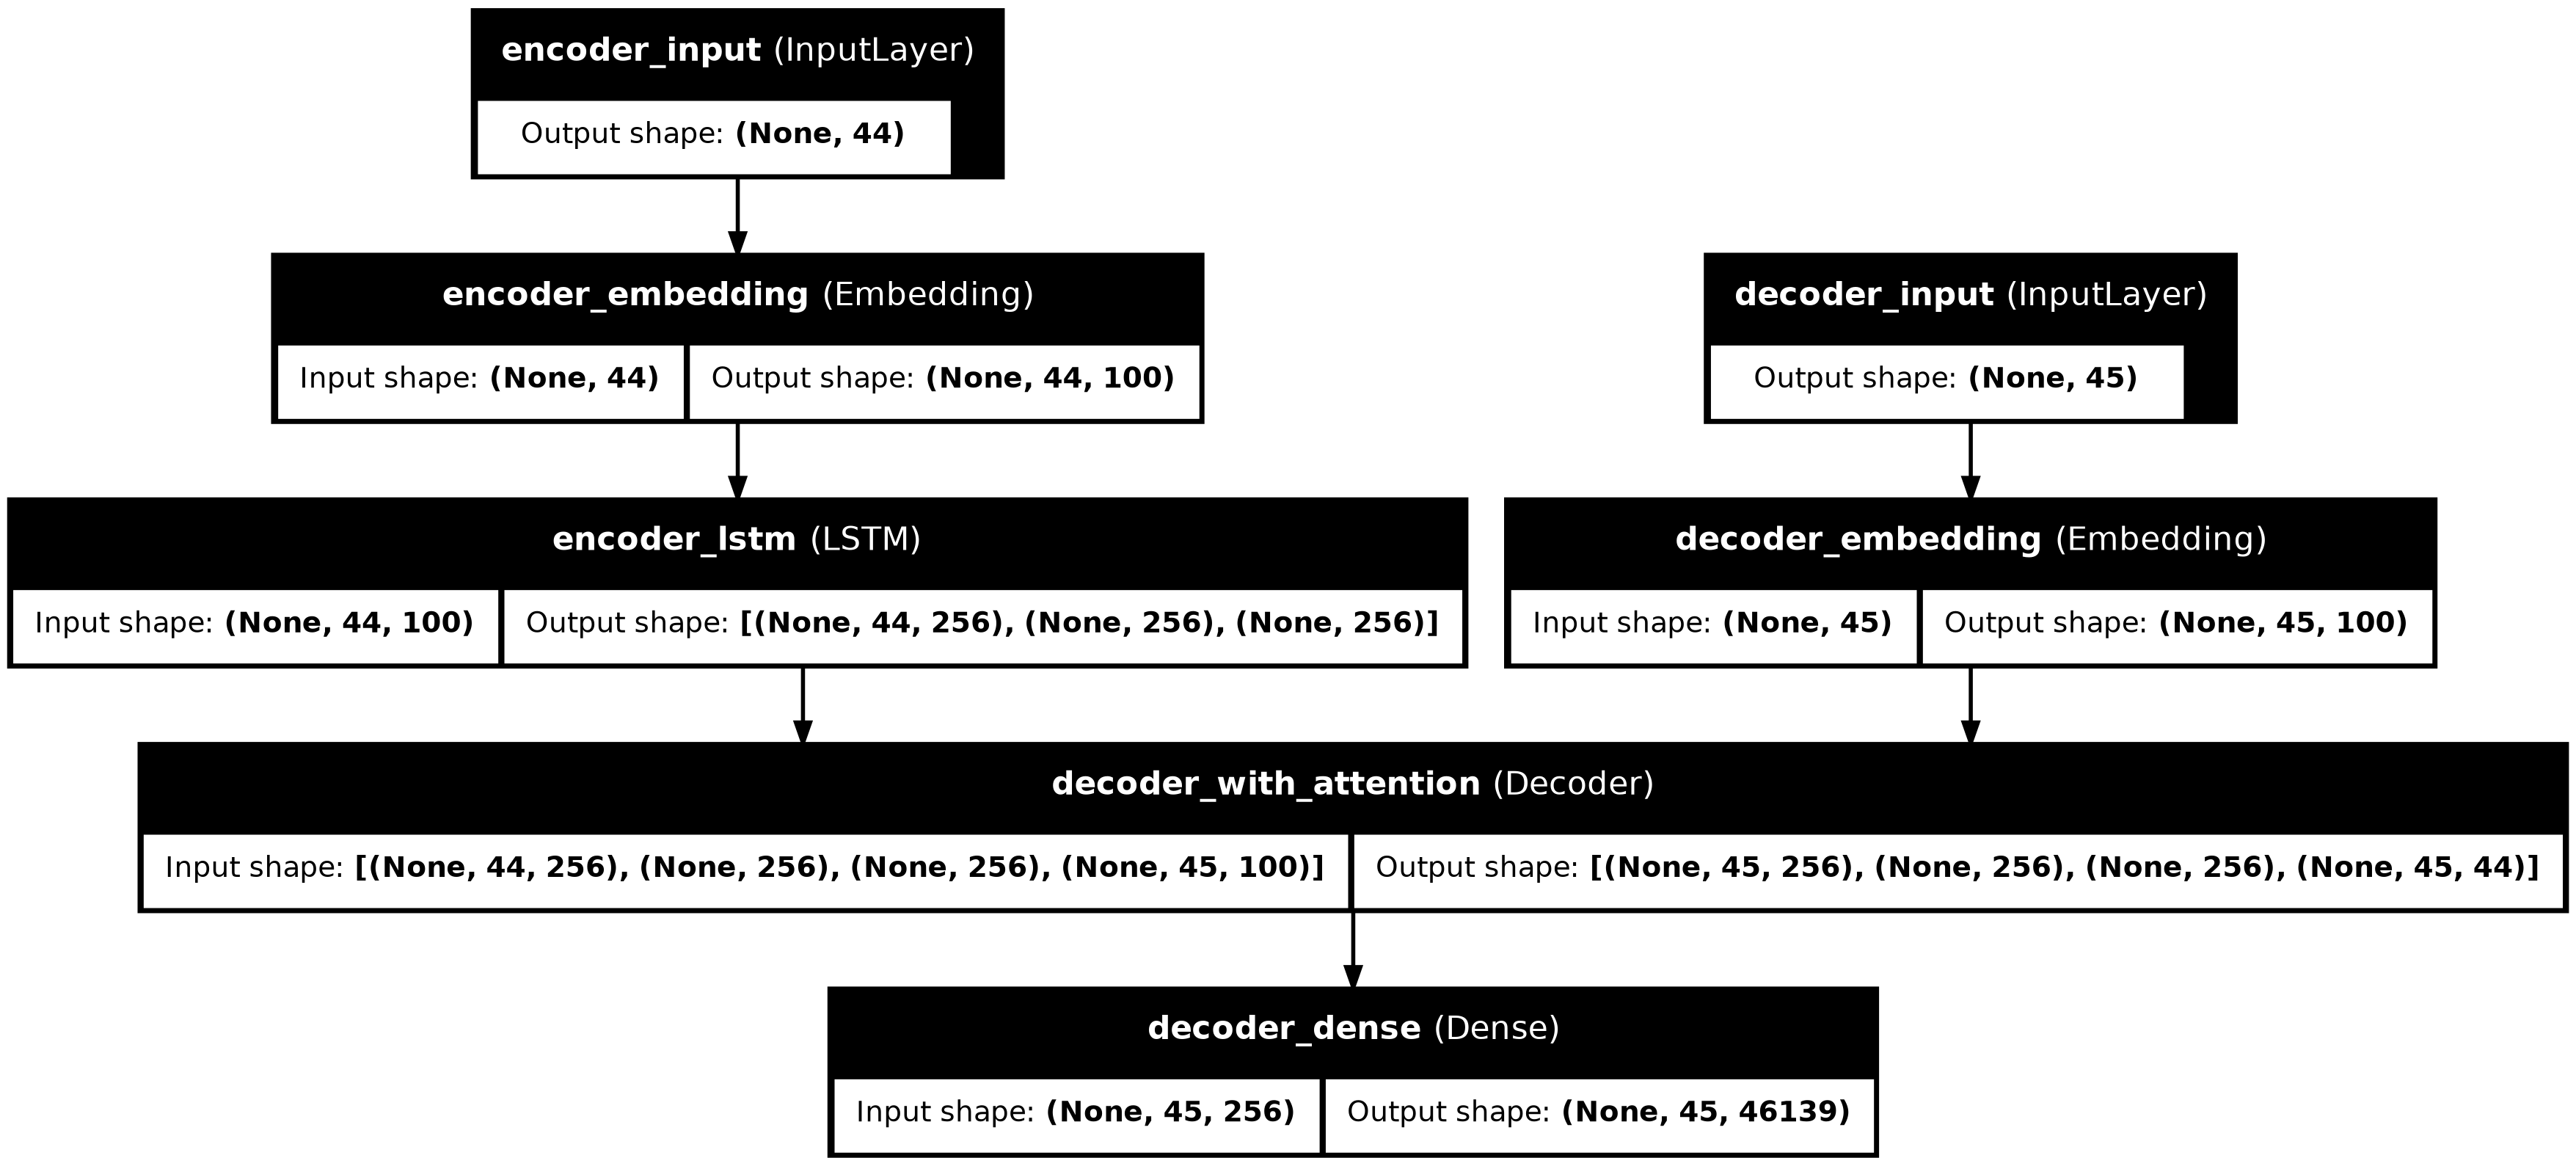

In [18]:
plot_model(model, to_file='plot/seq-to-seq-attention-architecture-training.png', show_shapes=True, show_layer_names=True)

In [19]:
history = model.fit([train_eng_seq, train_pt_seq_input],
                    train_pt_seq_target,
                    epochs=5, # increased training time for character-level model to get remotely decent results
                    batch_size=64, # increased batch size to speed up training
                    validation_split=0.2,
                    callbacks=[callback])

model.save('models/attention-based-model-attention-output-5-64.h5')


Epoch 1/5


2024-07-30 12:07:05.471951: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 226s 222ms/step - accuracy: 0.5128 - loss: 3.6653 - val_accuracy: 0.6474 - val_loss: 2.0757
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 223s 223ms/step - accuracy: 0.6673 - loss: 1.8403 - val_accuracy: 0.6926 - val_loss: 1.7495
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 223s 223ms/step - accuracy: 0.7142 - loss: 1.4297 - val_accuracy: 0.7067 - val_loss: 1.6663
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 223s 223ms/step - accuracy: 0.7489 - loss: 1.1886 - val_accuracy: 0.7123 - val_loss: 1.6586
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 223s 223ms/step - accuracy: 0.7697 - loss: 1.0560 - val_accuracy: 0.7147 - val_loss: 1.6712


In [20]:
### Loss and Accuracy plot

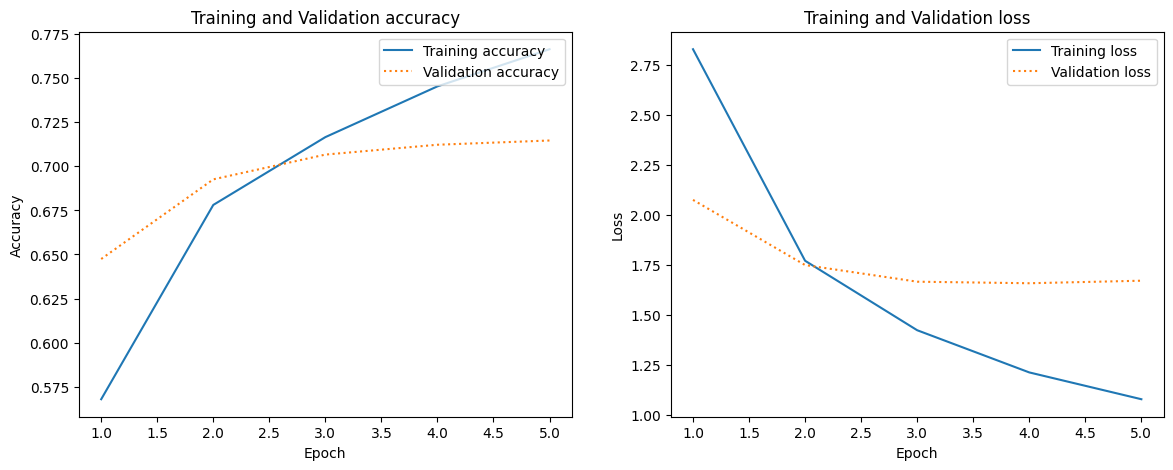

<Figure size 640x480 with 0 Axes>

In [21]:
# accuracy and loss plots
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy= history.history['val_loss']
val_accuracy = val_loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs, accuracy, '-', label='Training accuracy')
ax1.plot(epochs, val_accuracy, ':', label='Validation accuracy')
ax1.set_title('Training and Validation accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper right')

ax2.plot(epochs, loss, '-', label='Training loss')
ax2.plot(epochs, val_loss, ':', label='Validation loss')
ax2.set_title('Training and Validation loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.show()

plt.savefig('plot/seq2seq_attention_translation_model_en_to_pt_glove.png')

## Evaluation

In [22]:
# Here we extract encoder and decoder from the tuned model and contruct seperate encoder and decoder for the inference

# extracting Encoder model
encoder_inputs = model.input[0]
encoder_embedding = model.layers[1](encoder_inputs)
encoder_lstm = model.layers[3]
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Define encoder states
encoder_states = [state_h, state_c]
encoder_model = Model(encoder_inputs,[ encoder_outputs, encoder_states]  )
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.load_weights('models/attention-based-model-attention-output-5-64.h5')


# Decoder
## Defining Decoder inputs
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
# hidden state input
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# context input
decoder_context_inputs = Input(shape=(44,256))
# singel token input
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = model.layers[4](decoder_inputs_single)  

# To predict the next word in the sequence, with help of initial state input token and context
decoder_outputs, decoder_states, attention = model.layers[5](x=decoder_inputs_single_x, context=decoder_context_inputs, state=decoder_states_inputs)
decoder_outputs = model.layers[6](decoder_outputs)


decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs + [decoder_context_inputs],
    [decoder_outputs] + decoder_states + [attention] 
)

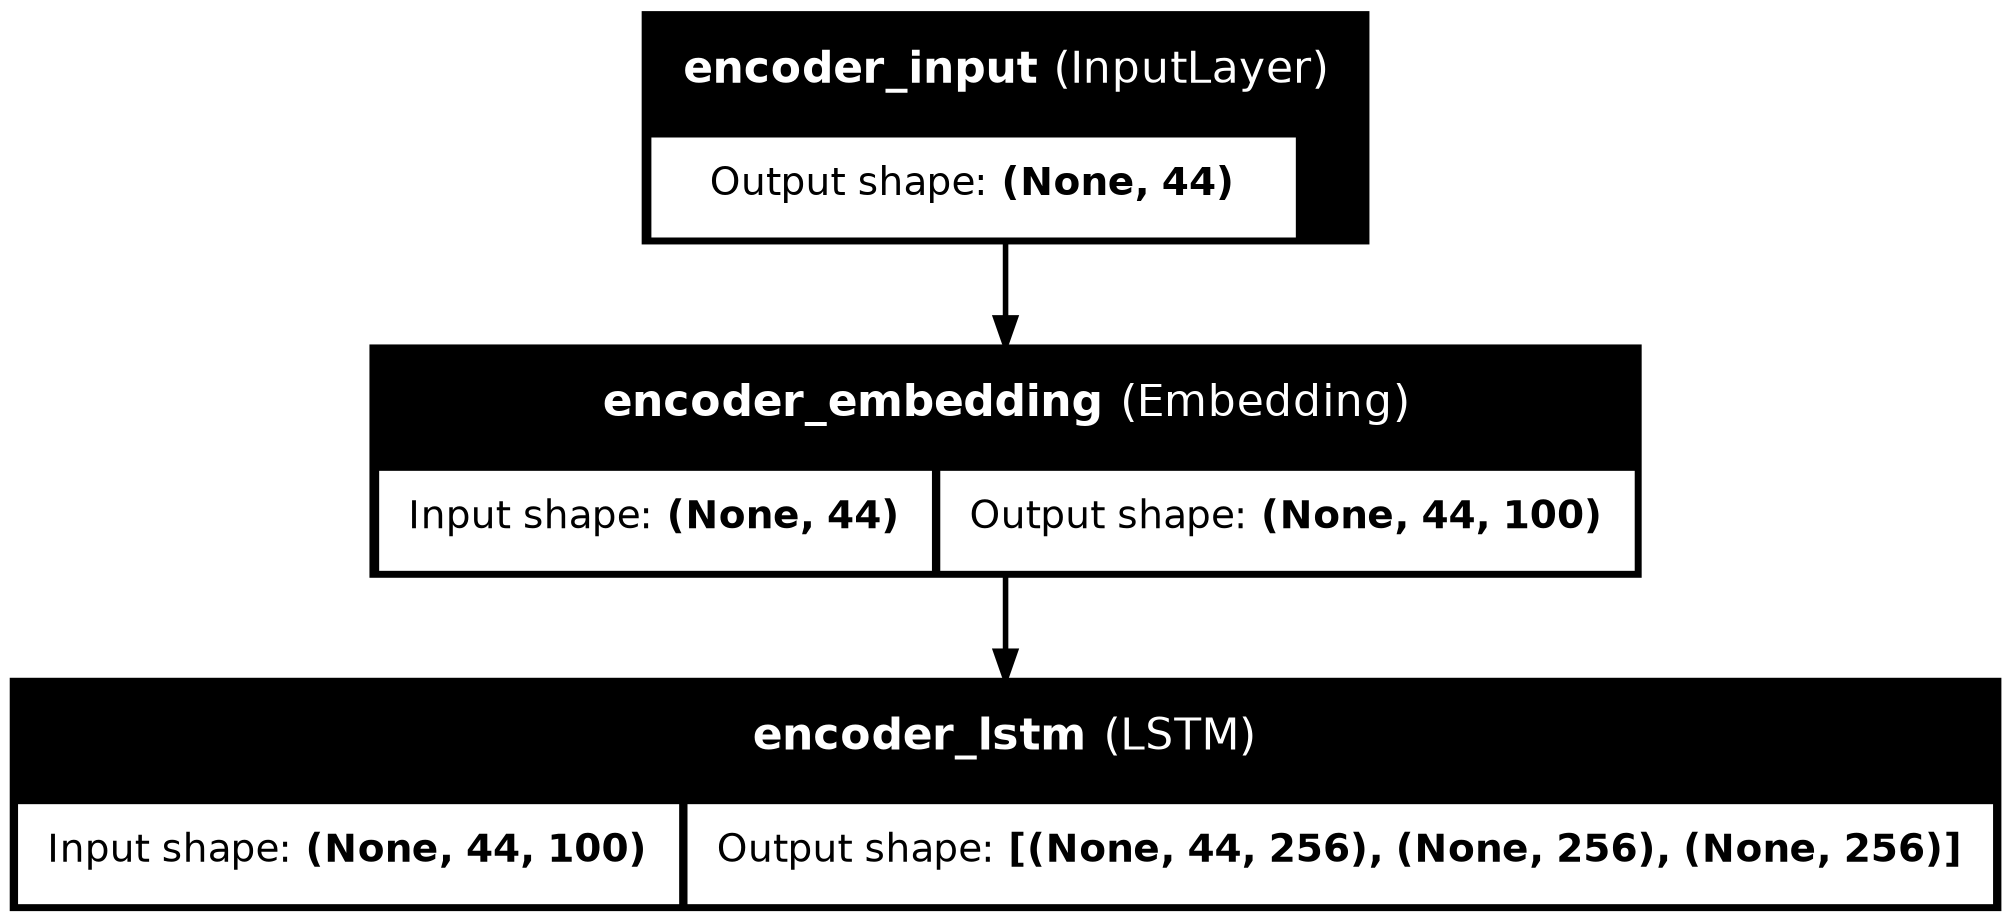

In [23]:
plot_model(encoder_model, show_shapes=True, show_layer_names=True)

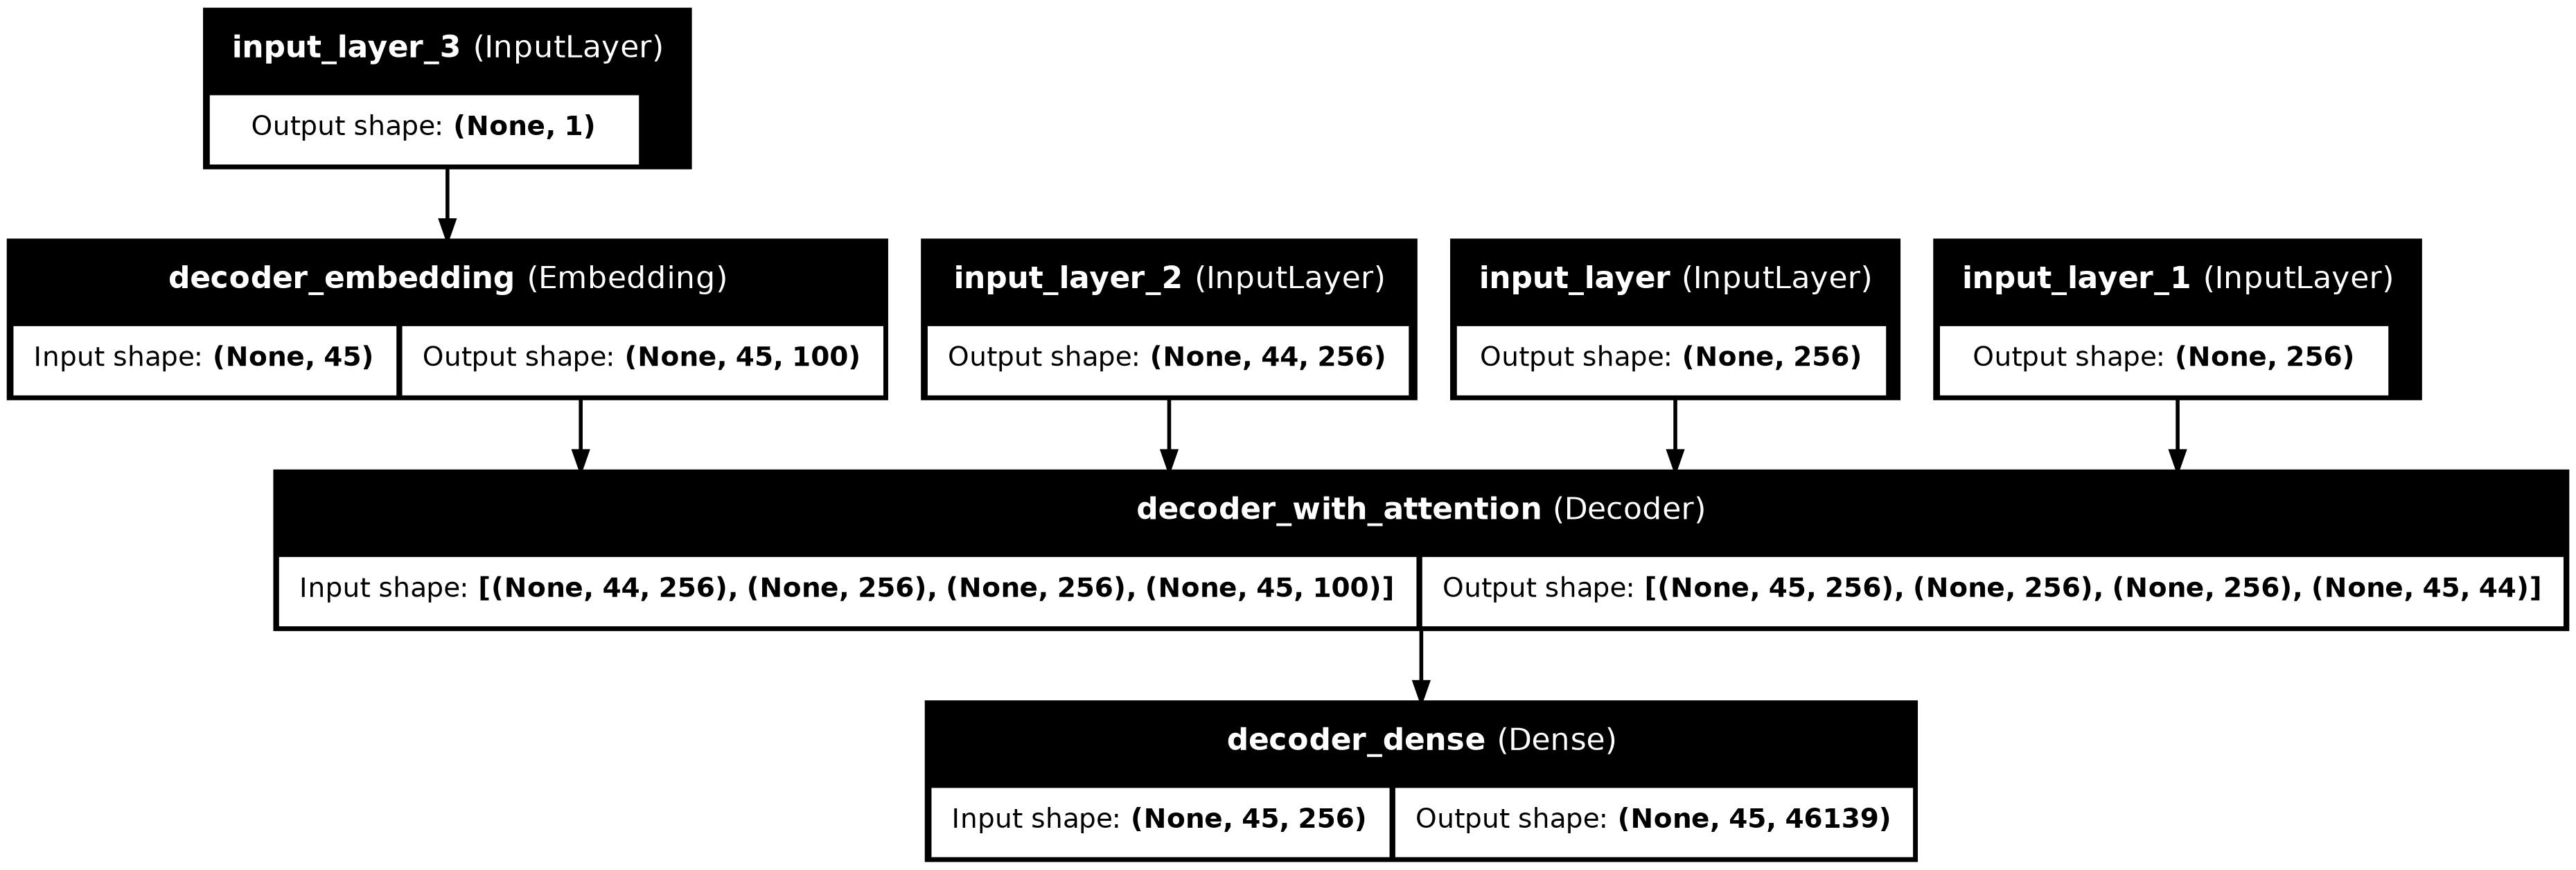

In [24]:
plot_model(decoder_model, show_shapes=True, show_layer_names=True)

In [25]:
 # Evaluation 

In [26]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np  
import pandas as pd
import nltk
import pandas as pd
from tqdm import tqdm
import evaluate
meteor = evaluate.load('meteor')

idx2word_target = {v:k for k, v in pt_tokenizer.word_index.items()} # index to word mapping for target language
word2idx_outputs = pt_tokenizer.word_index
  

def translate_sentence(input_seq, encoder_model, decoder_model, idx2word_target, pt_max_len,word2idx_outputs,starttoken='<start>',endtoken='<end>'):
    context ,state_value= encoder_model.predict(input_seq)
    
    #print(context.shape)
    #print(len(state_value))
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs[starttoken]
    eos = word2idx_outputs[endtoken]
    output_sentence = []
    attentions = []

    for _ in range(pt_max_len):
        output_tokens, h,c, attention= decoder_model.predict([target_seq] +   state_value + [context])
        idx = np.argmax(output_tokens[0, 0, :])
        """
        print(output_tokens.shape)
        print(attention.shape)
        print(h.shape)
        print(c.shape)
        """
        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
            attentions.append(attention.flatten())

        target_seq[0, 0] = idx
        state_value = [h,c]
    return ' '.join(output_sentence) , attentions

def translate_dataset(test_eng_seq, test_eng, test_pt, encoder_model, decoder_model, idx2word_target, pt_max_len, word2idx_outputs, save_interval=100, save_path='translations/translation_evaluation.csv',starttoken='<start>',endtoken='<end>'):
    """
    Evaluates the translation for the entire test dataset and prepares a dataset with the source sentence, reference translation and generated translation.
    
    Parameters:
    - test_eng_seq: The test dataset sentences as sequenced inputs.
    - test_eng: List of source sentences in English.
    - test_pt: List of reference translations in Portuguese.
    - encoder_model: The trained Encoder model.
    - decoder_model: The trained Decoder model.
    - idx2word_target: Index-to-word mapping for the target language (Portuguese).
    - pt_max_len: Maximum length of the target sequence (Portuguese).
    - word2idx_outputs: Word-to-index mapping for the target language (Portuguese).
    - save_interval: Number of sentences after which to save the progress.
    - save_path: Path to the file where results will be saved.
    - starttoken: Start token for the target language.
    - endtoken: End token for the target language.

    Returns:
    - evaluation_df: A DataFrame containing source sentences, reference translations, and generated translations.
    """
    translations = []

    # Translate each sentence in the test dataset
    for i in tqdm(range(len(test_eng_seq)), desc="Translating sentences"):
        input_seq = test_eng_seq[i:i+1]
        # Translate the current sentence
        translation , att= translate_sentence(input_seq, encoder_model, decoder_model, idx2word_target, pt_max_len, word2idx_outputs,starttoken='<start>',endtoken='<end>')

        # Append the results
        translations.append({
            'Source Sentence': test_eng[i],
            'Reference Translation': test_pt[i],
            'Model Translation': translation
        })
        print(test_eng[i])
        print("original")
        print(test_pt[i])
        print("translation:")
        print(translation)

        # Save progress periodically
        if (i + 1) % save_interval == 0:
            temp_df = pd.DataFrame(translations)
            temp_df.to_csv(save_path, index=False)
    
    # Convert the results to a DataFrame
    evaluation_df = pd.DataFrame(translations)
    # Save the final DataFrame
    evaluation_df.to_csv(save_path, index=False)

    return evaluation_df


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


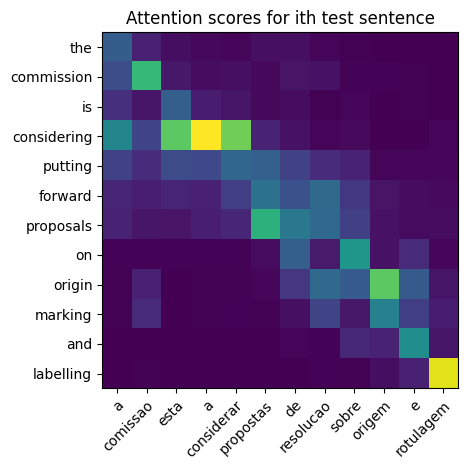

<Figure size 10000x10000 with 0 Axes>

In [35]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


def translate_and_plot_attention(i):
    input_seq = test_eng_seq[i:i+1]
    input_sentence = test_eng[i]

    # geting translation and attention weights 
    translation , att = translate_sentence(input_seq, encoder_model, decoder_model, idx2word_target, pt_max_len, word2idx_outputs,starttoken='<start>',endtoken='<end>')

    

    # Splitng sentences into arrays
    input_sentence = input_sentence.split(" ")
    translation  = translation.split(" ")

    # Transforming tensor into right format
    attentions = np.array(att)
    attentions = np.transpose(attentions)
    
    fig, ax = plt.subplots()
    attentions = attentions[:len(input_sentence),:]
    im = ax.imshow(attentions)
    
    # Show all ticks and label them with the respective list entries
    ax.set_yticks(np.arange(len(input_sentence)), labels=input_sentence)
    ax.set_xticks(np.arange(len(translation)), labels=translation)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    
    ax.set_title("Attention scores for ith test sentence")
    fig.tight_layout()
    plt.figure(figsize=(100,100))
    plt.show()
translate_and_plot_attention(14)

In [28]:


evaluation_df = translate_dataset(
    test_eng_seq[:1001],       # Test dataset as sequenced inputs
    test_eng,           # List of source sentences in English
    test_pt,            # List of reference translations in Portuguese
    encoder_model,      # Encoder model
    decoder_model,      # Decoder model
    idx2word_target,    # Index-to-word mapping for Portuguese
    pt_max_len,         # Maximum length of the target sequence
    word2idx_outputs,   # Word-to-index mapping for Portuguese
    save_interval=100,  # Save progress every 100 sentences
    save_path='attention_translation_evaluation.csv'  # Path to save the file
)

# Display the first few rows of the DataFrame
print(evaluation_df.head())

Translating sentences:   0%|                                                                                                                                                                                                                                                                       | 0/1001 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:   0%|▎                                                                                                                                                                                                                                                              | 1/1001 [00:01<24:21,  1.46s/it]

mr president three million jobs have been lost in comparison with several million euro invested in support policies
original
senhor presidente perderamse tres milhoes de empregos em contraste com varios milhoes de euros investidos em politicas de apoio
translation:
senhor presidente tres milhoes de postos de trabalho perdidos em comparacao com varios milhoes de euros em apoio mutuo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━

Translating sentences:   0%|▌                                                                                                                                                                                                                                                              | 2/1001 [00:02<22:19,  1.34s/it]

a pragmatic approach to address real common problems has more chance of success
original
uma abordagem pragmatica para resolver os verdadeiros problemas comuns tem maior probabilidade de sucesso
translation:
uma abordagem pragmatica a fazer face aos verdadeiros problemas comuns tem mais oportunidade de conseguir sucesso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms

Translating sentences:   0%|▊                                                                                                                                                                                                                                                              | 3/1001 [00:04<27:41,  1.67s/it]

mr president commissioner ladies and gentlemen the issue of animal nutrition has become something of a regular feature on this houses agenda
original
senhor presidente senhor comissario senhoras e senhores deputados o tema de alimentacao animal tornouse um tema de sucesso na agenda desta camara
translation:
senhor presidente senhor comissario senhoras e senhores deputados a questao da alimentacao animal tornouse algo de caracter excepcional diario sobre este ponto de ordem do conjunto do hemiciclo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1

Translating sentences:   0%|█                                                                                                                                                                                                                                                              | 4/1001 [00:07<32:15,  1.94s/it]

i have heard speakers saying that the only solution was to integrate the social protocol into the treaty and establish a social europe where decisions would be taken by majority voting
original
ouvi discursos a explicarem que a unica solucao consistia em integrar o protocolo social no tratado e criar uma europa social em que se tomassem as decisoes por maioria
translation:
ouvio os oradores que dizem que a unica solucao era a integrar o protocolo social no tratado e criar uma europa social que se considerasse a maioria das decisoes tomadas por maioria
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:   0%|█▎                                                                                                                                                                                                                                                             | 5/1001 [00:07<24:18,  1.46s/it]

they must be given their place
original
essas regioes deverao obter o seu proprio lugar
translation:
tem de ser dada a sua sede
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:   1%|█▌                                                                                                                                                                                                                                                             | 6/1001 [00:08<21:03,  1.27s/it]

all in all romania still has a huge effort to make
original
em suma a romenia tem de desenvolver ainda um enorme esforco
translation:
todos nos a romenia continua a registarse enormes esforcos para fazer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:   1%|█▊                                                                                                                                                                                                                                                             | 7/1001 [00:09<20:41,  1.25s/it]

we have solved every difficulty to everyones complete satisfaction
original
resolvemos todas as dificuldades para plena satisfacao de todas as pessoas
translation:
resolvemos todos os problemas de satisfacao por toda a gente a chegar a bom ritmo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms

Translating sentences:   1%|██                                                                                                                                                                                                                                                             | 8/1001 [00:11<22:57,  1.39s/it]

i would like to commend both nirj deva and jurgen schroder for constantly raising this issue
original
gostaria de louvar tanto nirj deva como jurgen schroder por levantarem constantemente esta questao
translation:
gostaria de louvar o meu reconhecimento de ambos os intervenientes no que se refere ao parto de uma questao de longo prazo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:   1%|██▎                                                                                                                                                                                                                                                            | 9/1001 [00:14<30:39,  1.85s/it]

i should also like to thank the honourable members who attended the meeting with over beekeepers and who like my colleagues in the committee on agriculture and rural development fully support the demands contained in my report
original
gostaria de agradecer tambem aos colegas que participaram na reuniao com mais de apicultores e que apoiam tal como a colega da comissao da agricultura e do desenvolvimento rural de todo o coracao as exigencias incluidas no meu relatorio
translation:
gostaria tambem de agradecer aos senhores deputados que hoje em dia com os meus colegas que me antecederam a reuniao da comissao da agricultura e do desenvolvimento rural plenamente apoiada por nao apoiar as exigencias contidas no meu relatorio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1

Translating sentences:   1%|██▌                                                                                                                                                                                                                                                           | 10/1001 [00:15<25:46,  1.56s/it]

on this basis i wish to propose to you the following package
original
desta forma pretendo propor o seguinte pacote
translation:
por esta base em conformidade gostaria de propor a seguinte questao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━

Translating sentences:   1%|██▊                                                                                                                                                                                                                                                           | 11/1001 [00:16<26:13,  1.59s/it]

the common positions have improved the results of the parliamentary amendments above all with regard to labelling and the competences of the regulatory authority
original
as posicoes comuns melhoraram os resultados das alteracoes parlamentares sobretudo no que diz respeito a rotulagem e as competencias da autoridade reguladora
translation:
as posicoes comuns tem melhorado os resultados das alteracoes parlamentares sobretudo no que respeita a rotulagem e as competencias da autoridade reguladora
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━

Translating sentences:   1%|███                                                                                                                                                                                                                                                           | 12/1001 [00:19<30:17,  1.84s/it]

our enquiries however have revealed that some countries particularly in northern europe cannot do much with this satellite data because everything is still covered in snow there when the images are captured
original
as nossas averiguacoes revelaram no entanto que alguns paises especialmente do norte da europa nao podem fazer grande coisa com estes dados de satelite uma vez que os locais onde as imagens foram captadas estao ainda todos cobertos de neve
translation:
mas temos de constatar que alguns paises em particular na europa nao evitarao alguns dos seus sistemas de satelites pois tudo isto continua a ser abrangidos por epidemias que perderam a vida
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/ste

Translating sentences:   1%|███▎                                                                                                                                                                                                                                                          | 13/1001 [00:21<31:33,  1.92s/it]

we owe it to ourselves and to the people of the european union to know where people are taken and whether people perish in the desert
original
temos a obrigacao para connosco e para com os cidadaos da uniao europeia de saber para onde e que elas estao a ser levadas e se estao a morrer no deserto
translation:
nos temos de nos conformar e para os povos da uniao europeia sabem onde pessoas que estao a ser prosseguidos e se as pessoas estao a ser detidas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━

Translating sentences:   1%|███▌                                                                                                                                                                                                                                                          | 14/1001 [00:22<27:59,  1.70s/it]

financial support and the simplification of legislative procedures for scientific development should be a priority for the eu
original
o apoio financeiro e a simplificacao dos procedimentos legislativos relacionados com o desenvolvimento cientifico devem constituir uma prioridade para a ue
translation:
apoio financeiro e a simplificacao dos processos legislativos destinados ao desenvolvimento de um processo legislativo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:   1%|███▊                                                                                                                                                                                                                                                          | 15/1001 [00:23<24:20,  1.48s/it]

the commission is considering putting forward proposals on origin marking and labelling
original
a comissao esta a ponderar apresentar propostas relativas a marca de origem e a rotulagem
translation:
a comissao esta a considerar propostas de resolucao sobre origem e rotulagem
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1

Translating sentences:   2%|████                                                                                                                                                                                                                                                          | 16/1001 [00:25<27:05,  1.65s/it]

on the assumption that you have got a move on and i am given to understand today that you have how do you get the others to do likewise
original
assumindo que tomou alguma iniciativa e foime dado hoje a entender que o fez como vai conseguir que os outros facam o mesmo
translation:
no pressuposto de que o senhor comissario tracou e eu proprio tive oportunidade de compreender hoje que o senhor comissario se pode fazer com que outros colegas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:   2%|████▎                                                                                                                                                                                                                                                         | 17/1001 [00:28<31:36,  1.93s/it]

in writing the climate summit organised by the un in bali did not have any specific results but did open up the way for a new global climate agreement after
original
por escrito a cimeira sobre alteracoes climaticas organizada pela onu em bali nao teve resultados especificos mas abriu caminho a um novo acordo global sobre o clima para depois de
translation:
por escrito a cimeira climatica organizada por em bali no passado mes de bali nao ter quaisquer resultados concretos mas expressei a proposito de que se trata de um novo acordo de comercio mundial apos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:   2%|████▌                                                                                                                                                                                                                                                         | 18/1001 [00:31<37:46,  2.31s/it]

indeed nature abhors a vacuum so when the european commission does not do its job it is parliament that has to do it and in that respect i must say and you have said it too commissioner that the work done by mr savary is very interesting since in fact he has provided you with all the material needed to draft the action plan
original
efectivamente a natureza tem horror do vazio assim quando a comissao europeia nao faz o seu trabalho cabe ao parlamento colmatar esse vazio e neste caso devo dizer que o trabalho desenvolvido como o senhor afirmou tambem senhor comissario pelo nosso colega savary e muito interessante pois de facto forneceu tudo o que era necessario para constituir o plano de accao
translation:
com efeito a natureza lembrounos do parlamento quando a comissao europeia nao faz o seu trabalho e o parlamento que tem o seu dever e o senhor comissario telas tambem dizervos senhor comissario que o trabalho desenvolvido pelo colega savary savary e que o trabalho
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:   2%|████▊                                                                                                                                                                                                                                                         | 19/1001 [00:33<37:55,  2.32s/it]

we will take the negotiating process as an opportunity to further set out those things that as i have learned from other members are the necessary practical details of what socialists and greens have long demanded
original
vamos tomar o processo de negociacao como uma oportunidade de explanar melhor os aspectos que tal como me dizem outros deputados constituem os pormenores praticos necessarios daquilo que os socialistas e os verdes exigem ha muito
translation:
vamos tomar o processo de negociacao como uma oportunidade para se candidatarem aos outros colegas que me aprendi a fazer pormenores concretos do que socialistas e os verdes ha muito que exortam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/st

Translating sentences:   2%|█████                                                                                                                                                                                                                                                         | 20/1001 [00:37<42:18,  2.59s/it]

existing directives on the working environment are not working well principally because employers oppose them and because trade unions are too weak and often set minimum levels that tend to commit the social partners to agreements affording levels of protection which are far too low
original
as directivas existentes sobre as condicoes de trabalho nao estao a funcionar bem principalmente porque os empregadores se opoem a elas e porque os sindicatos sao demasiado fracos estabelecendo frequentemente niveis minimos que tendem a vincular os parceiros sociais a acordos que asseguram niveis de proteccao demasiado baixos
translation:
as directivas existentes no ambiente nao estao a funcionar convenientemente principalmente porque os patroes se oponham a estas questoes e porque a uniao sao demasiado fracos e muitas vezes que sao aplicados de forma social de forma a que os parceiros sociais possam ser prejudicados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━

Translating sentences:   2%|█████▎                                                                                                                                                                                                                                                        | 21/1001 [00:39<39:27,  2.42s/it]

today we are also able together with commissioner patten to be delighted that the hierocracy in iran is to allow comprehensive inspections and to refrain from producing uranium for use in nuclear weapons
original
podemos congratularnos hoje juntamente com o senhor comissario patten por a hierocracia no irao ter autorizado a realizacao de extensas inspeccoes e ter indicado que ira suspender a producao de uranio destinado as armas nucleares
translation:
hoje somos capazes de colaborar convosco com o senhor comissario chris brittan que a chave do conflito no irao e permitir que sejam realizados controlos nucleares nucleares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:   2%|█████▌                                                                                                                                                                                                                                                        | 22/1001 [00:40<37:11,  2.28s/it]

this could also lead on to other questions such as how to calculate the carbon footprint all of us leave through energy consumption
original
este problema pode levar a outras questoes como a forma de calcular a pegada de carbono que todos nos deixamos devido ao consumo de energia
translation:
isto poderia tambem conduzir a outras questoes como como a de forma como se observa a importancia do carbono todos nos regressam ao consumo de energia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:   2%|█████▊                                                                                                                                                                                                                                                        | 23/1001 [00:42<35:45,  2.19s/it]

i would like to know why these issues have been railroaded through in such a fashion without proper democratic control and proper public debate
original
gostaria de saber por que e que estas materias foram introduzidas a pressa sem o necessario controlo democratico e o devido debate publico
translation:
gostaria de saber por que razao esses assuntos foram abordados atraves de uma forma de controlo democratico sem o seu controlo democratico e apropriado o debate publico
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms

Translating sentences:   2%|██████                                                                                                                                                                                                                                                        | 24/1001 [00:44<32:54,  2.02s/it]

too often we do not take heed of our own criticism and we lack the tools to find out what has become of our indictments
original
esquecemos com demasiada frequencia as nossas proprias criticas e faltamnos os instrumentos para apurar o impacto das nossas censuras
translation:
tambem muitas vezes nao demos resposta aos nossos proprios actos e nao temos de encontrar as ferramentas que se tornou possivel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:   2%|██████▎                                                                                                                                                                                                                                                       | 25/1001 [00:47<37:19,  2.29s/it]

the proposal does not aim to be a complete codification of all of the courts case law concerning equal treatment in the area of social security nor does it aim to introduce new law going beyond the existing case law
original
a proposta nao pretende ser uma codificacao exaustiva de toda a jurisprudencia do tribunal relativa a igualdade de tratamento no dominio da seguranca social nem visa introduzir nova legislacao que va alem da jurisprudencia existente
translation:
a proposta nao visa ser completa completa da jurisprudencia do tribunal de justica relativo a igualdade de tratamento no dominio da seguranca social quer quer trate o objectivo de introduzir novas juridicas no caso de aplicacao do processo de aplicacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━

Translating sentences:   3%|██████▌                                                                                                                                                                                                                                                       | 26/1001 [00:50<38:13,  2.35s/it]

i would urge the commission to look into other funding options especially in the face of this crisis with regard to a proposal for a consumer levy
original
gostaria de pedir explicitamente a comissao que apure se existem tambem outras possibilidades de financiamento seguramente no quadro desta crise eventualmente no quadro de uma proposta para uma taxa de consumo
translation:
exorto a comissao a olhar para o futuro para alem de outras opcoes em particular no que se refere a esta crise com a proposta de um imposto de um preco de consumo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/

Translating sentences:   3%|██████▊                                                                                                                                                                                                                                                       | 27/1001 [00:53<42:09,  2.60s/it]

clearly however this would have corresponding consequences for the budget consideration should be given to whether there are not other options in addition to the agrienvironmental schemes for utilising the appropriations saved through modulation and crosscompliance in ways which would not affect competition
original
no entanto e claro que esta atitude teria as respectivas consequencias a nivel orcamental sendo de reflectir se adicionalmente as medidas agroambientais nao existiriam outras opcoes para uma aplicacao neutra em termos de concorrencia das verbas economizadas na modulacao e na cross compliance
translation:
no entanto este aspecto teria sido possivel considerar que a avaliacao orcamental deveria ser dada a possibilidade de se contratar alem das supostas infraestruturas ferroviarias para restabelecer a modulacao dos recursos aquaticos atraves da modulacao e da comodalidade que nao reflectem a concorrencia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

Translating sentences:   3%|███████                                                                                                                                                                                                                                                       | 28/1001 [00:54<36:26,  2.25s/it]

it is not enough to have good delegational powers good information requirements and to solve home host issues
original
nao basta dispor de poderes de delegacao suficientes de solidas exigencias de informacao e resolver questoes entre o pais de origem e o pais de acolhimento
translation:
nao basta ter poderes efectivos e informacao boas recomendacoes para os seus cidadaos e para resolver assuntos internos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:   3%|███████▎                                                                                                                                                                                                                                                      | 29/1001 [00:55<29:35,  1.83s/it]

in this we are guided by our principles of the rule of law
original
ao fazelo devemos nortearnos pelos principios do nosso estado de direito
translation:
estamos a pensar nos nossos principios de estado de direito
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:   3%|███████▌                                                                                                                                                                                                                                                      | 30/1001 [00:58<36:21,  2.25s/it]

in our opinion a europe which builds its future with constancy continuity and responsibility is the best guarantee that the founding fathers blueprint is implemented faithfully that the endeavours of all those who have worked on it over the past years are at the basis of its success and that europe is built on solid foundations
original
acreditamos que uma europa que construa o seu futuro com firmeza continuidade e responsabilidade e a melhor garantia para o projecto dos pais fundadores para que esse projecto se realize tambem por forca do trabalho de todos quantos nele trabalharam nos ultimos cinquenta anos e se realize com bases concretas e solidas
translation:
na nossa opiniao uma europa que reforca o seu futuro com a continuidade da estabilidade e responsabilidade e responsabilidade e a melhor garantia de que a resolucao de pais se concretize correctamente que os esforcos de todos os anos estao a trabalhar durante o passado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:   3%|███████▊                                                                                                                                                                                                                                                      | 31/1001 [01:00<32:07,  1.99s/it]

that means that if a country has not replied we do not just assume that the answer is no
original
significa isso que se um pais no respondeu no vamos logo assumir que a resposta e no
translation:
isto significa que se nao se trata de um pais que nao se trata apenas de uma solucao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

Translating sentences:   3%|████████                                                                                                                                                                                                                                                      | 32/1001 [01:01<30:18,  1.88s/it]

secondly mrs mcnally and others pointed out the closer and clearer link between the environment and poverty
original
em segundo lugar a senhora deputada mcnally e outros chamaram a atencao para a ligacao mais estreita e mais clara que existe entre o ambiente e a pobreza
translation:
em segundo lugar a senhora deputada nicholson senhoras e outros intervenientes a saber a ligacao entre o ambiente e a pobreza
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:   3%|████████▎                                                                                                                                                                                                                                                     | 33/1001 [01:02<24:11,  1.50s/it]

in the light of these considerations we have abstained overall
original
a luz destas consideracoes abstivemonos em termos gerais
translation:
a luz destes conceitos abstivemonos de partida
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━

Translating sentences:   3%|████████▋                                                                                                                                                                                                                                                     | 34/1001 [01:04<28:30,  1.77s/it]

i look to the rapporteurs and the commission to explain how it is possible to increase the european budget without increasing the tax burden on taxpayers except by reducing the national budgets
original
espero que os relatores e a comissao expliquem como e possivel aumentar o orcamento europeu sem aumentar o onus fiscal para os contribuintes senao por via da reducao dos orcamentos nacionais
translation:
aguardo com expectativa os relatores e a comissao para que se possa aumentar o orcamento europeu sem aumentar o imposto de contribuintes sem aumentar o peso dos contribuintes excepto atraves dos orcamentos nacionais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/st

Translating sentences:   3%|████████▉                                                                                                                                                                                                                                                     | 35/1001 [01:07<31:46,  1.97s/it]

free movement the right to live in the place of ones choice and the right to work where one can all call for new european rules and the modernization of those that predate the single european act
original
a livre circulacao o direito de habitarmos onde quisermos e trabalharmos onde pudermos impoem novas regras europeias e a modernizacao das anteriores ao acto unico
translation:
livre circulacao o direito de viver na escolha de optar pelo caminho a trabalhar em prol do seu proprio pais e a modernizacao desses elementos que todos os que colocam a comunidade europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

Translating sentences:   4%|█████████▏                                                                                                                                                                                                                                                    | 36/1001 [01:08<27:53,  1.73s/it]

i think that awarenessraising has a very important role to play in that respect
original
julgo que as campanhas de sensibilizacao tem um papel muito importante a desempenhar nesse contexto
translation:
penso que a alta velocidade que tem um papel muito importante para desempenhar esse papel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:   4%|█████████▍                                                                                                                                                                                                                                                    | 37/1001 [01:09<26:17,  1.64s/it]

our car manufacturers lead the world for environmental awareness technical standards and innovation
original
os nossos fabricantes de automoveis sao lideres mundiais no que respeita a consciencia ambiental normas tecnicas e inovacao
translation:
os nossos fabricantes de automoveis automoveis origina a concorrencia para a proteccao tecnica dos dispositivos tecnicos e inovacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

Translating sentences:   4%|█████████▋                                                                                                                                                                                                                                                    | 38/1001 [01:12<30:32,  1.90s/it]

this means that in the coming weeks over a million people living in refugee camps in sudan will have no access to basic aid such as clean water food or medical care
original
isto significa que nas proximas semanas mais de um milhao de pessoas que vivem em campos de refugiados no sudao nao terao acesso a ajuda essencial como por exemplo agua limpa alimentos e cuidados medicos
translation:
isto significa que nas proximas semanas de que as pessoas se vivem nas campos de refugiados no sudao nao no do chade deixara de acesso a ajuda alimentar tais como agua alimentar ou medico
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1

Translating sentences:   4%|█████████▉                                                                                                                                                                                                                                                    | 39/1001 [01:14<33:45,  2.11s/it]

personally i must say that i would simply have rejected this uninspiring proposal by the commission but majority situations being what they are in the house i was unable to do so
original
pessoalmente devo dizer que teria gostado de rejeitar pura e simplesmente esta proposta pouco inspirada da comissao europeia mas sendo as maiorias o que sao neste parlamento nao consegui atingir esse objectivo
translation:
pessoalmente devo dizer que queria apenas afirmar que esta proposta de ccbe nao me parece que a maioria das situacoes de grupo nao estava a ser a maioria das pessoas que estao a ser feitas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:   4%|██████████▏                                                                                                                                                                                                                                                   | 40/1001 [01:16<29:21,  1.83s/it]

second question are the selective discounts of the democracy clause permissible
original
segunda questao sao admissiveis as derrogacoes selectivas a clausula relativa a democracia
translation:
segunda pergunta sao as taxas de uma clausula selectiva do que se limita a democracia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Translating sentences:   4%|██████████▍                                                                                                                                                                                                                                                   | 41/1001 [01:19<35:57,  2.25s/it]

finally i should emphasise that if as i assume we all want this proposal to be adopted soon by the council so as to keep to the timetable called for by mrs thyssen involving entry into force on january i am unable to accept the amendments proposed
original
cumpreme finalmente salientar que se como presumo todos nos desejamos uma adopcao rapida desta proposta por parte do conselho para permitir o cumprimento dos prazos solicitados pela senhora deputada thyssen ou seja a entrada em vigor em de janeiro de nao posso aceitar as alteracoes sugeridas
translation:
por ultimo gostaria de frisar que se trata de uma proposta de resolucao aprovada pelo conselho pois a fim de manter o calendario previsto para a senhora deputada thyssen que se comprometam a adesao a partir de de janeiro nao posso aceitar a entrada em
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/

Translating sentences:   4%|██████████▋                                                                                                                                                                                                                                                   | 42/1001 [01:21<36:15,  2.27s/it]

first the agency s headquarters would be established in thessaloniki and a joint declaration would be drawn up listing the general service departments to be located there
original
em primeiro lugar a sede da agencia seria estabelecida em salonica e seria elaborada uma declaracao conjunta contendo a lista dos departamentos de servicos gerais que ai funcionariam
translation:
a primeira vez a agencia das atribuicoes da agencia estaria em salonica e uma declaracao conjunta da comissao europeia sera efectuada por uma forma de servico geral a localizacao de servicos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━

Translating sentences:   4%|██████████▉                                                                                                                                                                                                                                                   | 43/1001 [01:22<29:57,  1.88s/it]

surveillance of budgetary positions and surveillance and coordination of economic policies
original
supervisao das situacoes orcamentais e supervisao e coordenacao das politicas economicas
translation:
vigilancia das posicoes orcamentais e a coordenacao e coordenacao das politicas economicas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:   4%|███████████▏                                                                                                                                                                                                                                                  | 44/1001 [01:25<36:34,  2.29s/it]

overall the proposal falls short of our initial intentions but it does not however involve any obligation to harmonise family reunification requirements downwards and we see it as a first step on a path that we wish were faster but which we shall continue to tread with conviction and persistence
original
em suma a proposta fica aquem das nossas intencoes iniciais contudo nao engendra nenhuma obrigacao de nivelar por baixo as condicoes de reagrupamento familiar e nos concebemolas como uma primeira etapa de um caminho que desejavamos mais rapido mas que continuaremos a trilhar com conviccao e persistencia
translation:
a proposta original da proposta fica aquem das nossas intencoes iniciais mas nao insiste qualquer obrigacao de harmonizar os requisitos de adesao a fim de nao obstante e que o primeiro passo no sentido de uma direccao que esperamos que seja mais rapida mas que
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1

Translating sentences:   4%|███████████▍                                                                                                                                                                                                                                                  | 45/1001 [01:27<33:17,  2.09s/it]

we have not even mentioned the workers in these countries who risk their lives as a result of inadequate safety precautions
original
nem sequer nos referimos aos trabalhadores nesses paises que arriscam a vida em resultado da adopcao de medidas de seguranca inadequadas
translation:
nao fomos ainda mencionados os trabalhadores nessas condicoes que os seus riscos para os efeitos de seguranca e de seguranca alimentar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

Translating sentences:   5%|███████████▋                                                                                                                                                                                                                                                  | 46/1001 [01:29<33:53,  2.13s/it]

i do not lack any ambition for what europe can be what i have to deal with is the reality of what we actually are
original
nao me falta de modo algum ambicao em termos do que a europa pode ser mas aquilo com que tenho de lidar e a realidade do que efectivamente somos
translation:
nao tenho falta de vontade de que a europa pode ser o que eu e que a realidade e que efectivamente devemos estar a ser a realidade daquilo que efectivamente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:   5%|███████████▉                                                                                                                                                                                                                                                  | 47/1001 [01:30<28:19,  1.78s/it]

the banana market organisation applies equally to all fifteen member states
original
a organizacao comum do mercado da banana aplicase indistintamente a todos os estadosmembros
translation:
a organizacao do mercado comum aplicase igualmente a todos os quinze estadosmembros
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 

Translating sentences:   5%|████████████▏                                                                                                                                                                                                                                                 | 48/1001 [01:33<34:57,  2.20s/it]

i and my colleagues in the committee on regional development brought these matters up with mrs hubner we are disappointed that the commissions document before us today pays hardly any attention to how the commission intends to set out to achieve its objectives
original
com os meus colegas da comissao do desenvolvimento regional abordamos estes assuntos com a senhora comissaria hubner lamentamos agora que o documento da comissao nao se debruce minimamente sobre a forma como a comissao tenciona actuar para alcancar esses objectivos
translation:
e minha colegas os meus colegas na comissao do desenvolvimento regional foram apresentados nestes assuntos relacionados com a senhora comissaria ferrerowaldner que hoje aqui se diz que a comissao europeia nao tem de ser dada atencao suficiente para determinar como tenciona a comissao vir a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━

Translating sentences:   5%|████████████▍                                                                                                                                                                                                                                                 | 49/1001 [01:34<29:38,  1.87s/it]

in addition russia s centralised power is oppressing a national minority
original
alem disso o poder central russo oprime uma minoria nacional
translation:
alem disso a russia do poder militar e a repressao de uma minoria nacional
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━

Translating sentences:   5%|████████████▋                                                                                                                                                                                                                                                 | 50/1001 [01:37<33:39,  2.12s/it]

the proposal to amend the original directive on this matter will ban the marketing of toys and childcare articles containing pvc which are designed to be placed in the mouths of children under the age of three
original
a proposta de alteracao da directiva original relativamente a esta questao vai proibir a comercializacao de brinquedos e artigos de puericultura que contenham pvc e que se destinem a entrar em contacto com a boca por criancas de idade inferior a tres anos
translation:
a proposta de alteracao relativa a directiva relativa a esta questao vai proibir a comercializacao de brinquedos e dos artigos o que contem os artigos o que sao atribuidos a alimentacao das criancas em idade de idade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:   5%|████████████▉                                                                                                                                                                                                                                                 | 51/1001 [01:39<34:04,  2.15s/it]

i believe therefore that socalled enlargement fatigue is a fact and that people are questioning these constant movements towards enlargement towards new accessions
original
penso portanto que falar de lassidao face ao alargamento e um facto efectivamente as nossas populacoes interrogamse sobre esses movimentos permanentes para o alargamento para novas adesoes
translation:
por conseguinte penso que a morosidade do alargamento e um facto e que as pessoas estao a ser detidas nestes movimentos de constante integracao no sentido de aproximar novas adesoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:   5%|█████████████▏                                                                                                                                                                                                                                                | 52/1001 [01:43<39:15,  2.48s/it]

today i acknowledge that on the question of the tsunami there remains a eur million gap but in the spirit of the cooperation and progress we were able to make back in july i am still optimistic that we should be able to close that gap in a relatively short period of time
original
reconheco hoje que no que se refere ao continua a existir um diferencial de milhoes de euros porem no espirito de cooperacao e progresso que conseguimos evidenciar em julho ultimo continuo optimista quanto a possibilidade de colmatarmos essa diferenca num espaco de tempo relativamente curto
translation:
hoje em dia reconheco que a questao do tsunami continua a ser um montante de milhoes de euros mas no espirito da cooperacao e no espirito de cooperacao e progresso continuo a aguardar que devemos regressar a tarde de julho a que devemos ter podido
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

Translating sentences:   5%|█████████████▍                                                                                                                                                                                                                                                | 53/1001 [01:44<34:41,  2.20s/it]

we know for example my area is supposedly the beneficiary of ericssons decision
original
sabemos por exemplo que a minha regiao e a que vai supostamente beneficiar com a decisao da ericsson
translation:
sabemos por exemplo o meu pais esta supostamente a ser votados a decisao de de de uma decisao de de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:   5%|█████████████▋                                                                                                                                                                                                                                                | 54/1001 [01:45<29:10,  1.85s/it]

we have to accept that a lot of work in the eu member states is not uniformly remunerated
original
temos de aceitar que muitas actividades nos estadosmembros da ue sao remuneradas de forma distinta
translation:
temos de aceitar que muitos trabalhos na uniao europeia nao sejam uniformemente exigentes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━

Translating sentences:   5%|█████████████▉                                                                                                                                                                                                                                                | 55/1001 [01:47<28:05,  1.78s/it]

solidarity is genuinely important for my group but it must be wellfounded and it must not be a oneway street
original
a solidariedade e realmente importante para o meu grupo mas deve ser bem fundamentada e nao uma via de sentido unico
translation:
a solidariedade e verdadeiramente importante para o meu grupo politico e deve ser preservado e nao deve ser um mero capital
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:   6%|██████████████▏                                                                                                                                                                                                                                               | 56/1001 [01:49<28:04,  1.78s/it]

certainly the report s evaluation of the economic and trade regime under cotonou is based on a political view of development and northsouth relations
original
a avaliacao que o relatorio faz do regime economico e comercial ao abrigo de cotonu tem certamente por base uma visao politica das relacoes de desenvolvimento nortesul
translation:
o relatorio da avaliacao do regime economico e do comercio intracomunitario sob a egide do regime de desenvolvimento economico e redistributivo da china
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━

Translating sentences:   6%|██████████████▍                                                                                                                                                                                                                                               | 57/1001 [01:51<29:37,  1.88s/it]

this is my second task ensuring that in future we have enough children s films suitable for that age films that are positive and are both educational and imaginative
original
eis o segundo trabalho que tenho de fazer fazer com que no futuro disponhamos de bastantes filmes para as criancas que se adaptem as suas idades que sejam positivos e que contenham uma parte da alma infantil e uma parte de elementos educativos
translation:
esta segunda e a segunda tarefa que no futuro temos de assegurar que os filmes sejam apoiados pelas embarcacoes que os filmes mostram bem recebidos e sao apoiados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:   6%|██████████████▋                                                                                                                                                                                                                                               | 58/1001 [01:53<29:25,  1.87s/it]

this committee is now starting to scrutinise the legislation with a view to restoration of or compensation for property which was seized under communist rule
original
esta comissao esta presentemente a analisar a legislacao tendo em vista a devolucao de propriedades e o pagamento de indemnizacoes relativas as propriedades ocupadas durante o regime comunista
translation:
esta comissao esta agora a aguardar a revisao da legislacao com vista a restauracao ou indemnizacao dos direitos de propriedade causados pela propriedade comunista
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━

Translating sentences:   6%|██████████████▉                                                                                                                                                                                                                                               | 59/1001 [01:56<37:48,  2.41s/it]

although we in the european union possess no powers or means whereby we might in any way enforce the reversal of this decision we do expect north korea to resume dialogue with its partners china in particular which may in the medium or long term make a peaceful resolution of this conflict possible
original
embora nos na uniao europeia nao tenhamos poderes nem meios para de alguma forma obrigar este pais a voltar atras nesta sua decisao esperamos que a coreia do norte reate o dialogo com os seus parceiros nomeadamente a china e que a medio ou longo prazo seja possivel encontrar uma solucao pacifica para este conflito
translation:
embora na uniao europeia nao possui poderes ou seja outros mecanismos de que podemos impor a decisao desta decisao exigimos esperar que a coreia do irao trabalhar em conflito com os seus parceiros da china em particular que pode vir a ser no medio oriente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31m

Translating sentences:   6%|███████████████▏                                                                                                                                                                                                                                              | 60/1001 [01:58<35:39,  2.27s/it]

it is important to establish the correct order of importance of these rights and to take account of the fact that human beings are more important than money
original
e importante estabelecer uma hierarquizacao correcta dos direitos em funcao da sua relevancia e ter em conta que os seres humanos sao mais importantes que o dinheiro
translation:
e importante estabelecer uma solucao correcta destes direitos e assumirem contas em relacao ao facto de os seres humanos serem mais importantes do que dinheiro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:   6%|███████████████▍                                                                                                                                                                                                                                              | 61/1001 [01:59<28:57,  1.85s/it]

secondly we must also make the necessary organisational decisions
original
segundo devemos tambem tomar as necessarias decises a nivel organizacional
translation:
em segundo lugar temos tambem de tomar as decisoes necessarias
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:   6%|███████████████▋                                                                                                                                                                                                                                              | 62/1001 [02:00<23:16,  1.49s/it]

this is why i voted for this report
original
foi por este motivo que votei a favor deste relatorio
translation:
dai que votei a favor deste relatorio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:   6%|███████████████▉                                                                                                                                                                                                                                              | 63/1001 [02:01<21:21,  1.37s/it]

thus we have a longterm objective that cannot be postponed
original
temos assim um objectivo a longo prazo que nao pode ser protelado
translation:
por conseguinte temos um objectivo de longo prazo que nao pode ser adiado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:   6%|████████████████▏                                                                                                                                                                                                                                             | 64/1001 [02:02<22:41,  1.45s/it]

madam president i would like to speak and to use this debate to talk about a fundamental issue the emergency they cannot cope alone
original
senhora presidente quero aproveitar este debate para falar de uma questao fundamental a situacao de emergencia e insistir num ponto sozinhos nao poderao fazer face a essa situacao
translation:
senhora presidente gostaria de falar e de utilizar este debate para falar sobre um tema fundamental que nao podemos responder sozinha
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:   6%|████████████████▍                                                                                                                                                                                                                                             | 65/1001 [02:03<18:53,  1.21s/it]

in this context i should like to mention the following three documents
original
neste contexto gostaria de referir os seguintes tres documentos
translation:
neste contexto gostaria de mencionar tres documentos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28

Translating sentences:   7%|████████████████▋                                                                                                                                                                                                                                             | 66/1001 [02:06<28:37,  1.84s/it]

if one takes account of the events that took place in drc then to put in place a democratic and peaceful transition would constitute a strong sign of hope for the thousands of africans who are now fleeing their countries in order to make a dash for europes shores with the idea of thus escaping from the chaos and of ensuring their own survival
original
tendo em conta os acontecimentos ocorridos na rdc promover uma transicao democratica e pacifica constituiria um sinal forte de esperanca para os milhares de africanos que hoje fogem dos seus paises rumo as costas europeias com o objectivo de assim escapar ao caos e assegurar a sua propria sobrevivencia
translation:
se tivermos em conta que se procedeu a uma situacao de que se encontrava em curso na guine e na transicao pacifica e pacifica susceptivel de dar sinais de esperanca de esperanca de que milhares de africanos que estao agora a fugir para os milhares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━

Translating sentences:   7%|█████████████████                                                                                                                                                                                                                                             | 67/1001 [02:08<27:58,  1.80s/it]

the nuclear industry is placing its highrisk installations right up against the borders of the eu
original
a industria nuclear coloca as suas centrais de risco junto das fronteiras da ue
translation:
a industria nuclear esta a colocar as suas instalacoes de alto nivel de risco de forma a afastar as fronteiras da ue
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Translating sentences:   7%|█████████████████▎                                                                                                                                                                                                                                            | 68/1001 [02:10<30:11,  1.94s/it]

it is a european subject and that is why i am sorry that you have dragged it down to the level of internal politics with your proposals
original
e um tema europeu e por isso lamento que o tenha reduzido a esfera da politica interna com os seus pedidos de alteracao
translation:
e uma questao que e o que lamento que a senhora deputada sofreu uma coisa que lamento que se tenha recuperado a nivel da politica interna com as vossas propostas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:   7%|█████████████████▌                                                                                                                                                                                                                                            | 69/1001 [02:11<24:47,  1.60s/it]

how can we guarantee that natura will get the funds it needs
original
como podemos nos garantir que a rede natura obtera os fundos de que necessita
translation:
como podemos garantir que a rede natura trara fundos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:   7%|█████████████████▊                                                                                                                                                                                                                                            | 70/1001 [02:14<32:39,  2.10s/it]

in particular would you agree that there is a need for a further stimulus the etuc has suggested of gdp aimed at a positive entry strategy into the labour market that would be aimed at protecting viable employment and creating new jobs in promoting intelligent work sharing
original
em particular concordaria que e necessario um estimulo suplementar a confederacao europeia dos sindicatos sugeriu do pib a favor de uma estrategia positiva para a entrada no mercado de trabalho centrada na proteccao dos empregos viaveis e na criacao de novos postos de trabalho atraves da promocao da partilha inteligente de tarefas
translation:
em particular o senhor comissario concorda que ha necessidade de um novo impulso a globalizacao sugeriu que a europa se destinava a um projecto positivo na qualidade de trabalho do mercado de trabalho que seria necessario para proteger o emprego viavel e criar emprego novas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:   7%|██████████████████                                                                                                                                                                                                                                            | 71/1001 [02:16<30:14,  1.95s/it]

the irish government is claiming that you demanded that cut mr rehn
original
o governo irlandes afirma que se trata de uma exigencia europeia senhor comissario
translation:
o governo irlandes esta a reclamar que o senhor comissario rehn pediu que aumente que aumente o seu colega rehn
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29m

Translating sentences:   7%|██████████████████▎                                                                                                                                                                                                                                           | 72/1001 [02:17<27:31,  1.78s/it]

all credit to the independence and democracy group too in this case
original
reconhecase portanto tambem neste caso o merito do grupo independenciademocracia
translation:
todos os efeitos de que a independencia do grupo de partido e a democracia tambem neste caso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

Translating sentences:   7%|██████████████████▌                                                                                                                                                                                                                                           | 73/1001 [02:21<34:40,  2.24s/it]

in my view the total number of allowances allocated to the aviation sector should be set at community level by reference to mean emission levels arising from aviation at least for the years while the emissions limit should be set at a level of
original
considero que o numero total de licencas atribuidas ao sector da aviacao deve ser determinado a nivel comunitario por referencia as emissoes medias da aviacao pelo menos durante o periodo e que o limite de emissoes deve ser estabelecido ao nivel de
translation:
no meu entender o conjunto de subsidios concedidos ao sector vitivinicola deveria ser criado a nivel comunitario ate a data para a emissao de emissoes de voos para alem do prazo de reducao do limite de emissoes para a aviacao pelo menos a nivel das
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━

Translating sentences:   7%|██████████████████▊                                                                                                                                                                                                                                           | 74/1001 [02:22<31:45,  2.06s/it]

legal practice in the member states reflects the different national cultures and traditions in terms of what should be censored and how it should be punished
original
a jurisprudencia nos estadosmembros exprime diferentes culturas e tradicoes nacionais sobre o que deve ser censurado e a forma como deve ser punido
translation:
na realidade os estadosmembros reflectem as diferencas nacionais existentes e tradicoes que devem ser permitidas e como deviam ser amordacados punidos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:   7%|███████████████████                                                                                                                                                                                                                                           | 75/1001 [02:25<32:34,  2.11s/it]

i hope that the work i am doing on my subcommittee may give the european parliament the opportunity to become the operational and organisational heart of the euromed assembly in the future
original
espero que o trabalho que tenho vindo a desenvolver na minha subcomissao permita que o parlamento europeu se torne de futuro o centro operacional e organizacional da assembleia euromed
translation:
espero que o trabalho esteja a trabalhar na minha comissao possa conferir a oportunidade de se tornar operacional e organizativa do centro de composicao da assembleia euromediterranica no futuro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:   8%|███████████████████▎                                                                                                                                                                                                                                          | 76/1001 [02:25<24:26,  1.59s/it]

asylum and immigration
original
asilo e imigracao
translation:
asilo e imigracao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:   8%|███████████████████▌                                                                                                                                                                                                                                          | 77/1001 [02:26<21:04,  1.37s/it]

in this figure stood at million people
original
em esse numero ascendia a milhoes de pessoas
translation:
neste caso a verba aqui se colocou milhoes de pessoas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:   8%|███████████████████▊                                                                                                                                                                                                                                          | 78/1001 [02:26<17:55,  1.16s/it]

therefore we are not yet able to grant it discharge
original
por isso nao pudemos concederlhe a quitacao
translation:
por conseguinte nao so nos parece conceder quitacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms

Translating sentences:   8%|████████████████████                                                                                                                                                                                                                                          | 79/1001 [02:29<23:44,  1.54s/it]

i also view positively the establishment of an interest rate to be applied where payment is late based on the european central banks reference rate plus
original
vejo tambem com bons olhos o estabelecimento da taxa de juro aplicavel com base na taxa de referencia do bce acrescida de em situacoes de atraso no pagamento
translation:
tambem considero positivo o estabelecimento de um interesse de um interesse de um interesse de um pais que se chegou a aplicar em que os bancos centrais nacionais se tornassem mais baixos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:   8%|████████████████████▎                                                                                                                                                                                                                                         | 80/1001 [02:30<23:14,  1.51s/it]

the deadline for tabling amendments is this morning at am and the vote will take place today at noon
original
o prazo para a entrega de alteracoes termina esta manha as h e a votacao tera lugar hoje as h
translation:
o prazo para apresentar alteracoes e esta manha e a votacao tera lugar hoje a margem de quintafeira
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Translating sentences:   8%|████████████████████▌                                                                                                                                                                                                                                         | 81/1001 [02:34<31:32,  2.06s/it]

however the point is that first of all it was promised that the outward symbols of a european superstate would not be included in the treaty of lisbon which most member states have ratified and now suddenly they are going to be included and enshrined in the european parliaments rules of procedure
original
todavia a questao principal e que em primeiro lugar foi prometido que os simbolos exteriores de um superestado europeu nao seriam incluidos no tratado de lisboa que a maior parte dos estadosmembros ratificou e vao agora subitamente ser consagrados no regimento do parlamento europeu
translation:
no entanto o ponto de partida e que em primeiro lugar foi prometido que as simbolos de um superestado europeu nao teria sido incluida no tratado de lisboa que os estadosmembros aprovaram e agora que se irao ser incluidos e agora que estao a ser
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:   8%|████████████████████▊                                                                                                                                                                                                                                         | 82/1001 [02:37<35:44,  2.33s/it]

to ensure that in particular passengers with sensory impairments are provided with information regarding delays as efficiently as possible we would call for information announcements to be made using both acoustic and visual systems
original
a fim de garantir em particular aos passageiros com incapacidades sensitivas toda a informacao possivel sobre eventuais atrasos solicitamos que se recorra a sistemas de informacao visuais e auditivos
translation:
para garantir que em particular os passageiros com o afastamento dos passageiros com o numero de utilizadores de origem sejam prestadas informacoes sobre atrasos como e possivel pedir informacao sobre as eventuais declaracoes de utilidade para os seus electricos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:   8%|█████████████████████                                                                                                                                                                                                                                         | 83/1001 [02:38<29:55,  1.96s/it]

there are no other rules with which it is possible to organize such coexistence
original
nao existem quaisquer outras regras com ajuda das quais se possa organizar uma convivencia desta natureza
translation:
nao ha outras regras que sao necessarias para organizar tais como a solucao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms

Translating sentences:   8%|█████████████████████▎                                                                                                                                                                                                                                        | 84/1001 [02:40<33:15,  2.18s/it]

mention was just made as it was in the latest report of domestic violence and i should like to draw attention to youth violence and to the fact that it is on the rise
original
falouse agora muito no ultimo relatorio de violencia domestica e eu gostaria de chamar a atencao para a violencia juvenil e para o seu incremento
translation:
a titulo de exemplo foi feita no ultimo relatorio de uma forma de violencia domestica e gostaria de chamar a atencao para a violencia de violencia e para o facto de se tratar de um aumento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:   8%|█████████████████████▌                                                                                                                                                                                                                                        | 85/1001 [02:43<36:53,  2.42s/it]

in that context the commission received earlier this year complaints submitted by the eu footwear industry containing convincing data indicating that the eu footwear industry is suffering from adverse effects caused by dumped prices of imports of footwear into the community
original
nesse contexto recebeu no inicio deste ano queixas apresentadas pela industria do calcado que incluiam dados fiaveis segundo os quais a referida industria na ue esta a ser vitima de efeitos adversos causados pelos precos de venda abaixo do preco de custo do calcado importado para a comunidade
translation:
neste contexto a comissao recebeu recentemente anteriores queixas apresentadas pela industria textil que abrangem dados que mostram que a industria textil da industria transformadora e a consequente consequente decorrente de efeitos causados pelos precos de importacoes de calcado na comunidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:   9%|█████████████████████▊                                                                                                                                                                                                                                        | 86/1001 [02:45<32:57,  2.16s/it]

over the next two years romania will have to make real and sustained efforts in order to be truly ready for membership
original
nos proximos dois anos a romenia tera de desenvolver esforcos verdadeiros e sustentaveis se quer realmente estar pronta para a adesao
translation:
durante os proximos dois anos a romenia terao de envidar grandes esforcos e conseguidos esforcos tendentes a ser verdadeiramente exigentes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:   9%|██████████████████████                                                                                                                                                                                                                                        | 87/1001 [02:48<35:03,  2.30s/it]

madam president may i be allowed to ask one or two supplementaries in doing so i must express keen disappointment with the commission statement about burma which i find less than satisfactory
original
senhora presidente gostaria de colocar uma ou duas questoes suplementares aproveitando o ensejo para manifestar a minha profunda decepcao em relacao a declaracao do senhor comissario sobre a birmania que considero abaixo de satisfatoria
translation:
senhora presidente permitame que me explique a que se envie uma ou dois dois relatores a declaracao de que quero manifestar uma desilusao por motivos da declaracao da comissao sobre mianmar que considero muito pouco
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:   9%|██████████████████████▎                                                                                                                                                                                                                                       | 88/1001 [02:51<39:23,  2.59s/it]

in budgetary terms we should point out that even though the farmers of the uk this matter was raised yesterday evening are having a difficult time at the moment their problems arise out of their failure to join the monetary system rather than the failure of european policies
original
em termos orcamentais e de assinalar que embora os agricultores do reino unido esta questao foi levantada ontem a tarde estejam neste momento a atravessar um periodo dificil os seus problemas decorrem da sua nao adesao ao sistema monetario e nao do fracasso das politicas europeias
translation:
em termos orcamentais deveriamos assinalar que mesmo no caso de os agricultores do reino unido estiveram aqui no dia seguinte a votacao de facto de haver uma hora dificil de crise e de tentarmos encontrar simultaneamente problemas que impecam o sistema monetario de maastricht em
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:   9%|██████████████████████▌                                                                                                                                                                                                                                       | 89/1001 [02:53<37:56,  2.50s/it]

even if the fisheries council is about to meet parliament would be doing itself no favours in relation to the council position if we were to vote tomorrow
original
nao seria bom para o parlamento ate perante a posicao do conselho mesmo que o conselho das pescas tenha uma reuniao agendada que ela fosse votada amanha
translation:
se o conselho pesca chegou a altura de responder ao parlamento europeu nao se deve fazer com que se estivesse a votar favoravelmente a posicao do conselho se fosse amanha
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━

Translating sentences:   9%|██████████████████████▊                                                                                                                                                                                                                                       | 90/1001 [02:55<33:07,  2.18s/it]

there is no doubt as to who will gain the upper hand militarily and technologically the invaders
original
nao ha duvida quanto ao vencedor seja a nivel militar seja a nivel tecnologico os invasores
translation:
nao ha duvida de que quem saira a poder contar com um pequeno esforco militar e tecnologicamente adverso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:   9%|███████████████████████                                                                                                                                                                                                                                       | 91/1001 [02:56<29:00,  1.91s/it]

this also includes the situation of aung san suu kyi who is in prison
original
nesta situacao encontrase tambem aung san suu kyi que esta presa
translation:
tambem esta tambem inclui a situacao de aung san suu kyi que se encontra na prisao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:   9%|███████████████████████▎                                                                                                                                                                                                                                      | 92/1001 [02:57<26:36,  1.76s/it]

and finally we must combat child pornography in other words the trivialization of the sexual exploitation of children
original
finalmente devemos lutar contra a pornografia infantil isto e a banalizacao da exploracao sexual das criancas
translation:
finalmente temos de combater a pornografia infantil ou seja as vestes do programa de exploracao sexual de criancas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:   9%|███████████████████████▌                                                                                                                                                                                                                                      | 93/1001 [02:58<21:44,  1.44s/it]

so we do not agree with amendments nos and
original
por esse motivo nao concordamos com as alteracoes e
translation:
por isso nao concordamos com as alteracoes e
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:   9%|███████████████████████▊                                                                                                                                                                                                                                      | 94/1001 [02:59<20:48,  1.38s/it]

two major countries have blatantly departed from compliance with the stability pacts rules
original
dois dos maiores paises da uniao esquivaramse descaradamente a cumprir as regras do pacto de estabilidade
translation:
dois paises pequenos foram condenados a respeitar acordos de estabilidade com as regras de estabilidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27m

Translating sentences:   9%|████████████████████████                                                                                                                                                                                                                                      | 95/1001 [03:02<28:35,  1.89s/it]

on behalf of the ppede group mr president presidentinoffice of the council president of the commission commissioner spidla ladies and gentlemen the group of the european peoples party and european democrats sets great store by social justice
original
em nome do grupo ppede senhor presidente senhor presidente em exercicio do conselho caro xavier bertrand senhor presidente da comissao senhor comissario spidla caros colegas o grupo do partido popular europeu e dos democratas europeus preocupase muito com a defesa da justica social
translation:
em nome do grupo ppede senhor presidente em exercicio do conselho senhor presidente da comissao senhor presidente do conselho de marco de e o grupo de partido do partido popular europeu e dos democratas europeus recolheu grandes surpresas a justica social
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━

Translating sentences:  10%|████████████████████████▎                                                                                                                                                                                                                                     | 96/1001 [03:03<25:23,  1.68s/it]

mr turchi you must not confuse transeuropean networks with the regional development fund
original
nao confundamos senhor deputado turchi as redes transeuropeias com o fundo europeu de desenvolvimento regional
translation:
senhor deputado sumberg nao pode confundir as redes transeuropeias com o fundo de desenvolvimento regional
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  10%|████████████████████████▌                                                                                                                                                                                                                                     | 97/1001 [03:06<28:59,  1.92s/it]

if alleanza nazionale were a movement that wished to conceal and disguise its feelings on the subject it would have made a tactical decision not to speak on this resolution
original
se a alleanza nazionale fosse um movimento que relativamente a este tema se quisesse esconder ou disfarcar teria optado tacticamente por nao tomar a palavra sobre esta resolucao
translation:
se a adesao a turquia foi um movimento que deseja esconder e esconder o seu sentimento de deitar achas para fazer face a sua decisao que teria tido uma decisao tomada de decisao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28m

Translating sentences:  10%|████████████████████████▊                                                                                                                                                                                                                                     | 98/1001 [03:09<35:10,  2.34s/it]

this guideline has now been completely renewed under the austrian presidency and further developed into an ambitious comprehensive new strategy for a whole range of key fields such as climate change clean energy transport and emphasis on sustainable consumption and production patterns
original
esta orientacao foi agora completamente revista sob a presidencia austriaca que a transformou numa nova estrategia ambiciosa e alargada para todo um conjunto de areas fundamentais como sejam as alteracoes climaticas as energias limpas os transportes com particular destaque para os padroes sustentaveis de consumo e de producao
translation:
esta directiva tem agora de ser ampliada a partir de agora a presidencia austriaca e mais desenvolvida uma nova estrategia de conjunto de areas fundamentais como as alteracoes climaticas a energia e a energia bem como a energia renovavel a energia e a producao sustentavel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━

Translating sentences:  10%|█████████████████████████                                                                                                                                                                                                                                     | 99/1001 [03:10<26:48,  1.78s/it]

and what is a possible solution
original
e que solucao seria possivel
translation:
e o que e possivel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  10%|█████████████████████████▎                                                                                                                                                                                                                                   | 100/1001 [03:13<33:34,  2.24s/it]

any union initiative in this area must safeguard the sovereignty and powers of each member state with regard to the management of its territorial waters and exclusive economic zones while at the same time contributing to promoting the resources that are present there as part of their endogenous potential and their comparative advantages
original
qualquer iniciativa comunitaria nesta area devera salvaguardar a soberania e as competencias dos estadosmembros relativamente as suas aguas territoriais e zonas economicas exclusivas e ao mesmo tempo contribuir para a valorizacao dos recursos ai presentes como parte do seu potencial endogeno e das suas vantagens comparativas
translation:
a iniciativa de uma iniciativa de resolucao neste dominio deve ser de salvaguarda a soberania e poderes de cada estadomembro com vista a gerir as suas aguas territoriais e ambientais enquanto mesmo tempo de contribuir para promover os recursos que estao actualmente a ser referidos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26

Translating sentences:  10%|█████████████████████████▌                                                                                                                                                                                                                                   | 101/1001 [03:15<30:36,  2.04s/it]

at present a key element in eu policy towards belarus is support for civil society and the process of democratisation
original
neste momento um dos elementoschave da politica da ue relativamente a bielorrusia e o apoio a sociedade civil e ao processo de democratizacao
translation:
actualmente a politica de uma chave na politica da ue e apoiar a sociedade civil e o processo de democratizacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/ste

Translating sentences:  10%|█████████████████████████▊                                                                                                                                                                                                                                   | 102/1001 [03:16<26:54,  1.80s/it]

mr rubig as i said i understand your concerns very well
original
senhor deputado como disse compreendo as suas preocupacoes
translation:
senhor deputado o senhor deputado rubig que eu sei se relacionava com o seu conteudo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  10%|██████████████████████████                                                                                                                                                                                                                                   | 103/1001 [03:19<31:24,  2.10s/it]

the huge resources needed and the time frames involved have both prevented the use of financial instruments also involving private capital and made national governments unwilling to commit themselves to projects of crossborder importance
original
os avultados recursos necessarios e os calendarios previstos impediram a utilizacao de instrumentos financeiros que envolvessem tambem capitais privados e tornaram os governos nacionais relutantes em se comprometerem com projectos de importancia transfronteirica
translation:
os recursos necessarios e o tempo de trabalho que sao os outros esforcos que se envolveram tanto os efeitos de instrumentos financeiros de capital e que envolvem bancos privados privados nao podem empenharse em projectos de importancia vital
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━

Translating sentences:  10%|██████████████████████████▎                                                                                                                                                                                                                                  | 104/1001 [03:20<30:03,  2.01s/it]

i believe that every member state must be prepared to join the euro area in order to avoid extremely severe potential adverse effects on the national economy
original
ma minha opiniao todos os estadosmembros tem de estar preparados para aderir a zona euro para que sejam evitados potenciais efeitos adversos extremamente graves para as economias nacionais
translation:
penso que cada estadomembro deve ser preparadas para aderir a zona euro para evitar que sejam afectados potenciais efeitos adversos a economia nacional
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  10%|██████████████████████████▌                                                                                                                                                                                                                                  | 105/1001 [03:23<34:28,  2.31s/it]

mr president i am pleased that mr tannock has expressed his regret at the offence caused by the remarks he made last week at a meeting of the committee on foreign affairs human rights common security and defence policy
original
senhor presidente ainda bem que o senhor deputado tannock disse que lamentava a afronta causada pelos comentarios que fez a semana passada numa reuniao da comissao dos assuntos externos dos direitos do homem da seguranca comum e da politica de defesa
translation:
senhor presidente estou satisfeito por o senhor deputado tannock ter manifestado o seu pesar a sua intervencao causado pela ultima semana na semana passada numa reuniao da comissao dos assuntos externos dos direitos do homem e da politica de defesa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29m

Translating sentences:  11%|██████████████████████████▊                                                                                                                                                                                                                                  | 106/1001 [03:26<34:38,  2.32s/it]

mr president i agree with what has been said and i would like to thank the president of this parliament for what he has said about the referendum held in my country yesterday
original
senhor presidente concordo com o que foi dito e queria agradecer ao presidente deste parlamento as suas palavras sobre o referendo ontem realizado no meu pais
translation:
senhor presidente estou de acordo com o que foi dito e gostaria de agradecer ao presidente deste parlamento pelo que disse o presidente do parlamento que fez o referendo de ontem
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━

Translating sentences:  11%|███████████████████████████                                                                                                                                                                                                                                  | 107/1001 [03:27<28:37,  1.92s/it]

firstly women and men must obviously be treated equally
original
em primeiro lugar as mulheres e os homens devem ser obviamente tratados de forma igual
translation:
em primeiro lugar as mulheres e homens e tambem necessario ser tratados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1

Translating sentences:  11%|███████████████████████████▎                                                                                                                                                                                                                                 | 108/1001 [03:29<29:54,  2.01s/it]

mr president i believe that each of us has the right in this parliament to speak to express our own ideas and to have clear information in the texts that we are about to adopt
original
senhor presidente penso que cada um de nos tem o direito a usar da palavra neste parlamento a exprimir as suas proprias ideias e a receber informacao clara dos textos que vamos aprovar
translation:
senhor presidente creio que cada um dos estados unidos tem o direito de exprimir as suas ideias e claras claras as nossas ideias e claras que nos dizem respeito
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  11%|███████████████████████████▌                                                                                                                                                                                                                                 | 109/1001 [03:32<33:33,  2.26s/it]

however should they fail in their endeavours then at the second reading stage parliament through the committee on regional policy transport and tourism will act and legislate in this area
original
no entanto se falharem a sua missao na fase de segunda leitura o parlamento atraves da comissao da politica regional dos transportes e do turismo actuara legislando nesta area
translation:
no entanto nao devem ter em conta os seus esforcos no que se refere ao parlamento europeu atraves da primeira leitura do parlamento sobre a politica de transportes e o turismo ira agir e legislar neste dominio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  11%|███████████████████████████▊                                                                                                                                                                                                                                 | 110/1001 [03:33<27:53,  1.88s/it]

the vast majority of these undertakings are smes employing fewer than workers
original
na sua maioria tratase de pme com menos de dez empregados
translation:
a grande maioria destes organismos sao pme empregam menos do que trabalhadores
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1

Translating sentences:  11%|████████████████████████████                                                                                                                                                                                                                                 | 111/1001 [03:35<30:34,  2.06s/it]

it is neither the wish nor the intention of the eu to fence itself off with an iron curtain as far as ecology and other issues are concerned
original
a ue nao deseja nem tenciona cercarse de uma cortina de ferro no que respeita a ecologia e outras questoes
translation:
nao e o desejo nem o desejo de colocar a propria ue para estabelecer uma divisoria com a sua propria construcao enquanto a da ecologia e outras questoes estao relacionadas com a poluicao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

Translating sentences:  11%|████████████████████████████▎                                                                                                                                                                                                                                | 112/1001 [03:37<27:02,  1.82s/it]

secondly i would like to emphasise the need to reduce the red tape involved in administering the justice system
original
em segundo lugar gostaria de acentuar a necessidade de reduzir a burocracia envolvida na administracao do sistema judicial
translation:
em segundo lugar gostaria de frisar a necessidade de reduzir a burocracia dos processos de administracao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28

Translating sentences:  11%|████████████████████████████▌                                                                                                                                                                                                                                | 113/1001 [03:39<28:32,  1.93s/it]

in the current financial perspectives we have proposed a very large amount of resources for your approval which can be channelled through the structural funds during this financial perspectives period
original
nas actuais perspectivas financeiras propusemos uma quantidade de recursos muito grande para vossa aprovacao que pode ser canalizada atraves dos fundos estruturais durante este periodo de perspectivas financeiras
translation:
nas proximas perspectivas financeiras propusemos um montante muito elevado de recursos para a sua aprovacao que possam ser canalizados atraves dos fundos estruturais durante a futura perspectiva financeira
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  11%|████████████████████████████▊                                                                                                                                                                                                                                | 114/1001 [03:42<34:24,  2.33s/it]

it must offer all european citizens protection and not a refuge from the fear generated by september this irrational fear which is giving rise to an overcautious withdrawal enabling some people to maintain their xenophobic and racist attitudes in the name of socalled pragmatism
original
tem de oferecer a todos os cidadaos europeus um estatuto de proteccao mas nao um refugio face ao medo gerado pelo de setembro um medo irracional que acarreta um recuo demasiado receoso permitindo a alguns conservarem atitudes xenofobas e racistas em nome de um pseudopragmatismo
translation:
e necessario que todos os cidadaos europeus beneficiem de proteccao de saude e nao uma especie de fuga que receiam o medo resultante de de setembro de que se trata de uma retirada de retirada de terras a ocupacao de odio e de antisemitismo no
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  11%|█████████████████████████████                                                                                                                                                                                                                                | 115/1001 [03:43<30:04,  2.04s/it]

if we take mr fischlers proposals it is the destruction not the slaughtering which is the problem
original
se considerarmos agora as propostas do senhor comissario fischler o problema nao reside no abate mas sim na destruicao
translation:
se formos francos propostas que vao e o que nao o abate propriamente dito nao o abate
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  12%|█████████████████████████████▎                                                                                                                                                                                                                               | 116/1001 [03:44<24:42,  1.68s/it]

i am not going to put my credit card number on the internet just like that
original
podem ter a certeza de que eu nao introduzo prontamente o numero do meu cartao visa na internet
translation:
nao vou por favor algum credito ja que o faca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1

Translating sentences:  12%|█████████████████████████████▌                                                                                                                                                                                                                               | 117/1001 [03:46<27:20,  1.86s/it]

i agreed with the report because as you know the expansion in international trade is justified if it contributes to economic development to job creation and to improved living standards
original
concordei com o relatorio porque como os senhores sabem o desenvolvimento do comercio internacional justificase na verdade se contribuir para o desenvolvimento economico o emprego e a melhoria do nivel de vida
translation:
concordei com o relatorio porque como sabem a expansao do comercio internacional se justifica se a expansao do desenvolvimento economico e a melhoria da vida profissional das normas de vida
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

Translating sentences:  12%|█████████████████████████████▊                                                                                                                                                                                                                               | 118/1001 [03:47<22:33,  1.53s/it]

it may thus help to achieve greater solidarity among sports
original
podera assim contribuir para uma maior solidariedade entre os desportos
translation:
pode portanto ajudar a conseguir uma solidariedade entre desporto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  12%|██████████████████████████████                                                                                                                                                                                                                               | 119/1001 [03:48<18:11,  1.24s/it]

thank you all very much for today
original
muito obrigado a todos pelo dia de hoje
translation:
agradeco sinceramente ao senhor deputado goodwill
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  12%|██████████████████████████████▎                                                                                                                                                                                                                              | 120/1001 [03:49<17:24,  1.19s/it]

of course it is not just greece that found itself in a difficult situation in
original
e evidente que nao foi so a grecia que se encontrou numa situacao dificil em
translation:
evidentemente nao e apenas a grecia que se encontre numa situacao dificil situacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  12%|██████████████████████████████▌                                                                                                                                                                                                                              | 121/1001 [03:50<18:07,  1.24s/it]

will you raise the issue at the next opportunity which i believe is the g meeting
original
tenciona abordar o assunto na proxima oportunidade que creio ser a reuniao do g
translation:
ira levantar a questao a colocar a questao na proxima oportunidade que me parece e o g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━

Translating sentences:  12%|██████████████████████████████▊                                                                                                                                                                                                                              | 122/1001 [03:52<19:48,  1.35s/it]

i intend to present proposals within the next several days on all these issues to the standing veterinary committee
original
tenciono apresentar dentro de dias propostas ao comite veterinario permanente sobre todas estas questoes
translation:
tenciono apresentar propostas dentro em breve alguns dias em que todas estas questoes a comissao acompanhara de acordo com a comissao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━

Translating sentences:  12%|███████████████████████████████                                                                                                                                                                                                                              | 123/1001 [03:54<23:13,  1.59s/it]

it is unacceptable that somebody should have fewer legal rights if they are charged with an offence in a country other than their own than they would in their own country
original
e inaceitavel que a uma pessoa acusada de delito num estadomembro que nao o seu assistam menos direitos legais do que lhe assistiriam se acusada do mesmo delito no seu proprio estadomembro
translation:
e inadmissivel que alguem deveria ter alguns direitos juridicos se tem de ser sujeitos a um delito no que respeita ao pais onde os seus proprios compatriotas ganhem
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

Translating sentences:  12%|███████████████████████████████▎                                                                                                                                                                                                                             | 124/1001 [03:57<29:11,  2.00s/it]

mr president the declarations by the presidentinoffice of the council and the commissioner are very interesting since they prove the european parliament right in calling for the signing of a new trade agreement with turkmenistan to be linked to respect for human rights
original
senhor presidente as declaracoes do presidente em exercicio do conselho e do representante da comissao sao muito interessantes pois dao razao ao parlamento europeu quando este exige que exista um laco entre a assinatura de um novo acordo comercial com o turquemenistao e o respeito dos direitos humanos
translation:
senhor presidente as declaracoes do presidente em exercicio do conselho e o senhor comissario sao muito interessante visto que prove o parlamento europeu apelando a assinatura do acordo de comercio com o turquemenistao a assinatura do respeito pelos direitos humanos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  12%|███████████████████████████████▌                                                                                                                                                                                                                             | 125/1001 [03:58<24:06,  1.65s/it]

therefore i am using this minute to make a few points
original
consequentemente utilizo este minuto para defender alguns argumentos
translation:
por conseguinte estou a usar este minuto para alguns pontos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  13%|███████████████████████████████▊                                                                                                                                                                                                                             | 126/1001 [03:58<19:39,  1.35s/it]

is that a reason not to go there
original
sera uma razao para nao irmos la
translation:
e essa razao nao se deve continuar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  13%|████████████████████████████████                                                                                                                                                                                                                             | 127/1001 [04:00<21:33,  1.48s/it]

you applaud the mandelkern report but we are not familiar with it and that concerns us very much
original
o conselho sauda o relatorio mandelkern mas nao o conhecemos e preocupanos muito
translation:
o relatorio do senhor deputado linkhor mas nao estamos bem familiarizados com ele e que nos preocupa muito
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━

Translating sentences:  13%|████████████████████████████████▎                                                                                                                                                                                                                            | 128/1001 [04:02<23:55,  1.64s/it]

i am sorry that the charter has been incorporated in the form of an annex rather than into the body of the treaty as its importance warrants
original
lamento que essa incorporacao tenha sido feita na forma de um anexo e nao no proprio corpo do tratado como a sua dignidade justificava
translation:
lamento que a carta tenha sido incluida na forma de um anexo ao que a partir do tratado como a sua importancia merece ser dada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  13%|████████████████████████████████▌                                                                                                                                                                                                                            | 129/1001 [04:03<19:59,  1.38s/it]

having said that there is still room for improvement
original
dito isto penso que ainda ha margem para melhorias
translation:
dito isto continua a haver margem para melhorias
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  13%|████████████████████████████████▊                                                                                                                                                                                                                            | 130/1001 [04:04<18:07,  1.25s/it]

taxes of this kind have been a great success in sweden
original
na suecia essas taxas constituiram um grande progresso
translation:
os impostos deste tipo tem sido um grande exito na suecia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

Translating sentences:  13%|█████████████████████████████████                                                                                                                                                                                                                            | 131/1001 [04:06<23:37,  1.63s/it]

every unexpected and premature death is more than anything a tragedy for the families concerned but when victims are numbered in tens or hundreds of thousands it is also a tragedy for entire nations and the whole world
original
qualquer morte imprevista e prematura e acima de tudo uma tragedia para as familias afectadas mas quando as vitimas ascendem as dezenas ou centenas de milhares passa a ser igualmente uma tragedia para toda a nacao e para o mundo inteiro
translation:
todos os dias surgem e condenados a morte e mais de morte que as criancas sao sujeitas a dezenas de milhar de pessoas em dezenas de milhares de milhares e milhoes de euros
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━

Translating sentences:  13%|█████████████████████████████████▎                                                                                                                                                                                                                           | 132/1001 [04:08<21:05,  1.46s/it]

contact with democratically elected representatives at local and regional levels is important
original
os contactos com os representantes democraticamente eleitos a nivel local e regional sao importantes
translation:
contacto com representantes eleitos detidos em contacto com os niveis locais e regionais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  13%|█████████████████████████████████▌                                                                                                                                                                                                                           | 133/1001 [04:09<19:09,  1.32s/it]

for a start new liquidity is constantly being created
original
a primeira e o facto de surgir constantemente nova liquidez
translation:
para comecar a cabo esta agora a ser criada uma nova recuperacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  13%|█████████████████████████████████▊                                                                                                                                                                                                                           | 134/1001 [04:09<16:51,  1.17s/it]

without rules or supervision you cannot make any progress
original
sem regras e sem supervisao e impossivel fazer progressos
translation:
sem regras ou supervisao nao podem fazer qualquer progresso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 

Translating sentences:  13%|██████████████████████████████████                                                                                                                                                                                                                           | 135/1001 [04:12<23:46,  1.65s/it]

a truly unified europe under the democratic control of its people will emerge only if profound social changes are made which bring an end to the economic and social domination of private financial groups
original
a emergencia de uma europa verdadeiramente unificada sob o controlo democratico da sua populacao esta ligada a transformacoes sociais profundas que poem fim ao dominio dos grupos financeiros privados sobre a economia e a sociedade
translation:
uma europa verdadeiramente unida que sob o seu povo se ira emergir apenas se as mudancas sociais forem introduzidas as alteracoes sociais profundas que trouxeram a um fim ao estilo economico e social dos grupos financeiros
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  14%|██████████████████████████████████▎                                                                                                                                                                                                                          | 136/1001 [04:14<24:31,  1.70s/it]

a number of years ago in this parliament it was already being said that morocco would not agree to another agreement with the eu
original
ha alguns anos diziase ja neste parlamento que marrocos nao ia aceitar outro acordo com a ue
translation:
ha anos que ja aqui foi dito que foi dito que marrocos nao se destinava a outros paises que nao pertencem a ue
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  14%|██████████████████████████████████▋                                                                                                                                                                                                                          | 137/1001 [04:15<21:13,  1.47s/it]

i doff my cap to you
original
tirolhes o meu chapeu
translation:
eu tirei o meu ponto de vista a senhora deputada theato
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━

Translating sentences:  14%|██████████████████████████████████▉                                                                                                                                                                                                                          | 138/1001 [04:18<27:23,  1.90s/it]

they came from different places from a vast number of ideologies and cultures but they were united in the objective of fighting for the rights of equality and justice to be recognised for the social and political participation of women for the sharing of responsibilities for the rights to sexual and reproductive health
original
oriundas de diferentes lugares com um vasto leque de ideologias e culturas mas unidas no objectivo de lutar pelo reconhecimento do seu direito a igualdade e a justica pela participacao social e politica das mulheres pela partilha de responsabilidades pelo direito a saude sexual e reprodutiva
translation:
vieram constatar que foram provenientes de diversas quadrantes de quadrantes de um numero de ideologias e culturas mas tambem no objectivo de lutar contra a igualdade dos direitos e justica da justica e da justica internacional da mulher
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

Translating sentences:  14%|███████████████████████████████████▏                                                                                                                                                                                                                         | 139/1001 [04:20<30:48,  2.14s/it]

b by mr newens and others on behalf of the group of the party of european socialistsb by mrs maes and mr dupuis on behalf of the group of the european radical allianceb by mr pasty and others on behalf of the union for europe groupb by mr miranda and others on behalf of the confederal group of the european united left nordic green leftb by mr bertens on behalf of the group of the european liberal democrat and reform partyb by mr cunha and others on behalf of the group of the european peoples partyb by mrs hautala and others on behalf of the green group in the european parliamenton the situation in east timor
original
b dos deputados newens e outros em nome do grupo do partido dos socialistas europeus b dos deputados maes e dupuis em nome do grupo da alianca radical europeia b dos deputados pasty e outros em nome do grupo uniao para a europa b dos deputados miranda e outros em nome do grupo confederal da esquerda unitaria europeiaesquerda nordica verde b do deputado bertens em nome do g

Translating sentences:  14%|███████████████████████████████████▍                                                                                                                                                                                                                         | 140/1001 [04:21<24:36,  1.71s/it]

this is perhaps the story of various suicide attackers
original
esta e possivelmente a historia de varios ataques suicidas
translation:
isto e talvez a historia de varias infeccoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  14%|███████████████████████████████████▋                                                                                                                                                                                                                         | 141/1001 [04:24<28:41,  2.00s/it]

mr president i too wish to start by thanking mr buzek for his excellent work and also the shadow rapporteurs particularly mr busquin who has brought a great deal of knowhow and experience to bear
original
senhor presidente tambem eu gostaria em primeiro lugar de agradecer ao senhor deputado buzek pelo seu excelente trabalho assim como aos relatoressombra em especial ao senhor deputado busquin que para ele contribuiu com muito saber e experiencia
translation:
senhor presidente tambem eu comecaria por agradecer ao senhor deputado buzek pelo excelente trabalho e tambem os relatoressombra sobretudo o senhor comissario busquin quem deu uma grande sabedoria e experiencia para ter conhecimento e experiencia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  14%|███████████████████████████████████▉                                                                                                                                                                                                                         | 142/1001 [04:26<30:28,  2.13s/it]

i appeal to the libyan government to allow the un refugee agency to coordinate and help establish a national asylum system for refugees in the country
original
apelo ao governo da libia que autorize a agencia das nacoes unidas para os refugiados a coordenar e a ajudar a estabelecer um sistema nacional de asilo para os refugiados no pais
translation:
apelo ao governo turco para permitir que a agencia das nacoes unidas para a onu para coordenar e ajudar a instituir um sistema de asilo nacional para os refugiados no pais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  14%|████████████████████████████████████▏                                                                                                                                                                                                                        | 143/1001 [04:27<26:15,  1.84s/it]

i therefore call on parliament to do what it can to help free these hostages
original
solicito portanto ao parlamento que faca tudo ao seu alcance a fim de ajudar a libertar estes refens
translation:
por isso apelo ao parlamento ao fazelo que pode ajudar a libertarse destes sequestrados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  14%|████████████████████████████████████▍                                                                                                                                                                                                                        | 144/1001 [04:28<22:23,  1.57s/it]

the amendments approved by the committee do not stand in the way of this
original
as alteracoes aprovadas pela comissao especializada nao obstam a este
translation:
as alteracoes aprovadas pela comissao nao visam a forma como este
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━

Translating sentences:  14%|████████████████████████████████████▋                                                                                                                                                                                                                        | 145/1001 [04:32<29:39,  2.08s/it]

however the commission has proposed to increase its commitment and payment appropriations by and respectively with a focus on expenditure related to the europe strategy including the esf the lifelong learning programme the youth in action programme the seventh framework research programme and the competitiveness and innovation programmes
original
no entanto a comissao propos aumentar as suas dotacoes de autorizacao e de pagamento em e respectivamente centrandose na despesa relacionada com a estrategia europa incluindo o fse os programas de aprendizagem ao longo da vida o programa juventude em accao o setimo programaquadro de investigacao e os programas de competitividade e inovacao
translation:
no entanto a comissao propos a sua execucao e dotacoes para pagamentos por parte dos seus recursos e financeiros relacionados com a estrategia estrategia europeia incluindo o fse no programa de formacao de desenvolvimento a juventude a juventude a investigacao o programa de investigacao e
1/1 ━━

Translating sentences:  15%|████████████████████████████████████▉                                                                                                                                                                                                                        | 146/1001 [04:33<26:29,  1.86s/it]

an opportunity for proper debate is all we ask before our quasiimperial council takes its decision
original
a unica coisa que pedimos e que nos deem uma oportunidade de levarmos a cabo um debate adequado antes de o conselho que e um orgao de natureza quase imperial tomar uma decisao
translation:
uma oportunidade para o debate e todos beneficiariamos de um debate sobre o nosso grupo de colegislador
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  15%|█████████████████████████████████████▏                                                                                                                                                                                                                       | 147/1001 [04:34<21:14,  1.49s/it]

so there is quite clearly in my view a correlation
original
por conseguinte na minha opiniao existe uma correlacao clara
translation:
portanto ha muito claramente na minha opiniao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  15%|█████████████████████████████████████▍                                                                                                                                                                                                                       | 148/1001 [04:35<22:39,  1.59s/it]

i voted in favour of the report on migration flows arising from instability scope and role of eu foreign policy
original
por escrito votei favoravelmente o relatorio sobre fluxos migratorios decorrentes da instabilidade ambito e papel da politica externa da ue
translation:
votei a favor do relatorio sobre as relacoes sobre a imigracao e o papel de peso no ambito da politica externa da ue
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1

Translating sentences:  15%|█████████████████████████████████████▋                                                                                                                                                                                                                       | 149/1001 [04:37<23:01,  1.62s/it]

i cannot close without mentioning the living example of multilingualism and its importance which we find in this house
original
nao posso terminar esta minha intervencao sem mencionar o exemplo vivo do multilinguismo e da sua importancia aqui presente neste hemiciclo
translation:
nao consigo deixar de referir sem mencionar o exemplo de vida do multilinguismo e da sua importancia que nos encontramos neste hemiciclo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

Translating sentences:  15%|█████████████████████████████████████▉                                                                                                                                                                                                                       | 150/1001 [04:39<23:04,  1.63s/it]

mr president baroness ashton the european parliament has paid close attention to the internal and foreign policy developments in iran
original
senhor presidente senhora baronesa ashton o parlamento europeu tem seguido com toda a atencao os acontecimentos ocorridos no irao tanto no dominio da politica interna como no dominio da politica externa
translation:
senhor presidente senhora baronesa ashton o parlamento europeu deu uma atencao muito proxima e a politica externa do irao no irao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  15%|██████████████████████████████████████▏                                                                                                                                                                                                                      | 151/1001 [04:40<20:58,  1.48s/it]

whatever the reasons for that particular measly fine it will alienate a large number of fans
original
sejam quais forem as razoes para esta multa particularmente irrisoria ela decepcionara um grande numero de adeptos
translation:
independentemente das razoes que sao necessarias para sublinhar o seu grande numero de artistas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  15%|██████████████████████████████████████▍                                                                                                                                                                                                                      | 152/1001 [04:41<18:14,  1.29s/it]

is europe prepared to accept this superstate
original
estara a europa preparada para aceitar esse super estado
translation:
a europa esta a ser preparada para aceitar este superestado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  15%|██████████████████████████████████████▋                                                                                                                                                                                                                      | 153/1001 [04:42<16:04,  1.14s/it]

we simply go through the motions in what is a pale shadow of a parliament
original
muito simplesmente passamos em revista resolucoes naquilo que e uma palida sombra de um parlamento
translation:
recordaremos apenas que se trata de um parlamento puro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  15%|██████████████████████████████████████▉                                                                                                                                                                                                                      | 154/1001 [04:42<13:18,  1.06it/s]

and to develop it into what
original
e desenvolvelo em que sentido
translation:
e para desenvolver esse objectivo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

Translating sentences:  15%|███████████████████████████████████████▏                                                                                                                                                                                                                     | 155/1001 [04:44<17:42,  1.26s/it]

rather than being a coverup for countries where food quality needs to be regulated the origin eu label is thus a quality guarantee
original
em vez de servir de folha de parreira para paises que nao tem sua qualidade alimentar em ordem o rotulo origem ue passa a ser garantia de qualidade
translation:
no que se refere a uma simplificacoes para paises terceiros onde as necessidades alimentares devem ser regulamentadas a uma forma de garantir a producao de produtos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                     | 156/1001 [04:45<15:43,  1.12s/it]

i hope that parliament rejects them all
original
espero pois que o parlamento as rejeite na sua totalidade
translation:
espero que o parlamento rejeita todas as suas palavras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  16%|███████████████████████████████████████▋                                                                                                                                                                                                                     | 157/1001 [04:47<21:44,  1.55s/it]

who could believe that we could agree on such a demanding package of measures with not only a consensus in the council but a firstreading agreement with parliament on very complex issues
original
quem poderia imaginar que conseguiriamos um acordo sobre um pacote de medidas tao exigente e que nao so se chegaria a um consenso no conselho mas tambem a um acordo em primeira leitura com o parlamento sobre questoes tao complexas
translation:
quem poderia acreditar que poderiamos concordar com esse pacote de medidas que nao se podem chegar ao consenso do conselho mas sim um acordo de adesao com as suas questoes de natureza muito complexo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  16%|███████████████████████████████████████▉                                                                                                                                                                                                                     | 158/1001 [04:50<24:35,  1.75s/it]

i believe that where established practice exists and there is the opportunity for local bodies to take decisions that should be respected and nothing new imposed by decree
original
nas situacoes em que ha uma pratica estabelecida e orgaos locais aptos a decidir considero que se deve respeitalos nao impondo nada por decreto
translation:
penso que em que se pratica e existe a possibilidade de as estruturas de local e a oportunidade de tomar decisoes que devem ser respeitadas e nada mais armas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  16%|████████████████████████████████████████▏                                                                                                                                                                                                                    | 159/1001 [04:50<20:46,  1.48s/it]

this provision does not just apply to flood zones
original
esta disposicao nao se aplica apenas as zonas inundadas
translation:
isto nao preve apenas a imposicao de zonas de inundacoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  16%|████████████████████████████████████████▍                                                                                                                                                                                                                    | 160/1001 [04:51<17:30,  1.25s/it]

morocco has also contributed to the relief effort
original
refirase tambem a participacao de marrocos nas accoes de socorros
translation:
marrocos tambem contribuiu para o esforco de ajuda
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━

Translating sentences:  16%|████████████████████████████████████████▋                                                                                                                                                                                                                    | 161/1001 [04:53<18:49,  1.34s/it]

this is a hypocritical budget heading given the environmental damage that we cause in our own countries
original
tendo em conta os danos ambientais que provocamos nos paises esta rubrica orcamental e uma hipocrisia
translation:
esta e uma rubrica orcamental que esta a caminhar de um orcamento de natureza ambiental que nos proprios paises perifericos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/

Translating sentences:  16%|████████████████████████████████████████▉                                                                                                                                                                                                                    | 162/1001 [04:56<26:36,  1.90s/it]

in that respect it is a pity that meps have not been consulted on the joint statement to be agreed next week especially as with the lisbon treaty almost all of these matters come within codecision
original
a esse respeito e lamentavel que os deputados desta assembleia nao tenham sido consultados sobre a declaracao comum a aprovar na proxima semana especialmente porque com o tratado de lisboa praticamente todas estas questoes sao abrangidas pela codecisao
translation:
no que respeita a esse respeito e pena que os eurodeputados nao tenham sido consultadas na declaracao comum de que se trata de saber a questao da autoexclusao em termos de lisboa em toda a discussao no ambito do processo de codecisao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  16%|█████████████████████████████████████████▏                                                                                                                                                                                                                   | 163/1001 [04:58<28:09,  2.02s/it]

the council has more opportunities to influence the european parliament and the committees of the european parliament than the european parliament has to influence the working groups and the council meetings
original
o conselho tem mais oportunidades de influenciar o parlamento europeu e as suas comissoes do que o parlamento europeu tem de influenciar os grupos de trabalho e as reunioes do conselho
translation:
o conselho tem mais possibilidades para influenciar o parlamento europeu e as comissoes parlamentares do parlamento europeu do parlamento europeu tem de influenciar os grupos de trabalho e o conselho
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━

Translating sentences:  16%|█████████████████████████████████████████▍                                                                                                                                                                                                                   | 164/1001 [05:01<32:25,  2.32s/it]

instead of standing up for europe and publicly taking the lead the eus leaders completely shy away from one of the most important issues in the lisbon process namely the services directive
original
em vez de se baterem pela europa e de assumirem publicamente a lideranca os lideres da ue recuam claramente numa das questoes mais importantes do processo de lisboa a directiva dos servicos
translation:
em vez de lado a europa e publicamente a dianteira na lideranca dos lideres da ue sem cair em causa de um dos mais importantes questoes de natureza mais importantes no processo de lisboa nomeadamente a directiva relativa aos servicos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  16%|█████████████████████████████████████████▋                                                                                                                                                                                                                   | 165/1001 [05:05<36:22,  2.61s/it]

we austrians myself included cannot then understand the arguments that are often adduced against it as we are inclined to see this as another attempt at obstructing the quest for a replacement for the ninth transport protocol in the treaty with austria at the time it acceded to the eu
original
nos austriacos entre os quais me incluo nao conseguimos portanto compreender os argumentos frequentemente apresentados contra o acordo e julgamos ver nesta atitude mais uma tentativa de obstruir o pedido de um instrumento que substitua o nono protocolo relativo aos transportes incluido no tratado celebrado com a austria quando da sua adesao a ue
translation:
nos austriacos sentimonos tambem eu proprio se bem que os argumentos que sao frequentemente preocupantes contra o facto de serem testemunhas de serem acusados de uma tentativa de obstrucao a fim de evitar a procura de substituir a terceira via do protocolo de captura no
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

Translating sentences:  17%|█████████████████████████████████████████▉                                                                                                                                                                                                                   | 166/1001 [05:08<38:10,  2.74s/it]

are we going to propose or rather is the commission going to propose to the council and to parliament a tax on the wealth created by globalisation which could be used to supply this fund which would be managed by the united nations
original
vamos propor a comissao vai propor ao conselho e ao parlamento uma tributacao das riquezas realizadas com a mundializacao para alimentar esse fundo que seria gerido pelas nacoes unidas
translation:
vamos propor ou nao a comissao propor ou seja a comissao propor ao conselho e ao parlamento uma taxa sobre a riqueza criada pela globalizacao que poderia ser utilizada para o fundo de ajuda que vierem a ser pelas nacoes unidas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28

Translating sentences:  17%|██████████████████████████████████████████▏                                                                                                                                                                                                                  | 167/1001 [05:11<40:15,  2.90s/it]

the organisation of legal immigration channels in europe would tangibly reduce the pressure put on the right of asylum by the fact that it is really the only one that exists together with the right of persons persecuted in their country of origin to be reunited with their family under the geneva convention the right to seek asylum is indeed a fundamental and inalienable individual right that needs to be strengthened and protected from any political considerations
original
a organizacao de canais legais de imigracao para a europa contribuiria para reduzir sensivelmente a pressao exercida sobre o direito de asilo pelo facto de ser o unico instrumento efectivamente existente com o reagrupamento familiar para as pessoas perseguidas nos paises de origem pois o direito a procurar asilo e com efeito em virtude da convencao de genebra um direito individual fundamental e inalienavel que deve ser reforcado e ser independente de qualquer consideracao politica
translation:
a organizacao de imigrac

Translating sentences:  17%|██████████████████████████████████████████▍                                                                                                                                                                                                                  | 168/1001 [05:14<41:48,  3.01s/it]

mrs fontaine president of the european parliament members of the european parliament ladies and gentlemen let me begin by expressing my great pleasure at the dialogue we have had this morning on the peace process and europe s great interest in the success of this process and in establishing a climate favourable to this peace
original
senhora deputada nicole fontaine presidente do parlamento europeu senhoras e senhores deputados ao parlamento europeu meus senhores e minhas senhoras permitamme antes de mais que exprima a minha grande satisfacao pelo dialogo que mantivemos esta manha sobre o processo de paz e pelo grande interesse da europa no exito deste processo e no estabelecimento de um clima propicio a instauracao desta paz
translation:
senhora presidente da comissao do parlamento europeu do parlamento europeu senhoras e senhores deputados permitamme que comece por expressar a minha grande prazer pelo dialogo que realizamos aqui no sentido de paz e a europa do grande interesse do pro

Translating sentences:  17%|██████████████████████████████████████████▋                                                                                                                                                                                                                  | 169/1001 [05:17<42:40,  3.08s/it]

for these reasons i support the reform which will result firstly in the establishment of a european advisory committee on community statistical information policy and secondly in the creation of a european statistical governance advisory board both bodies capable of actively helping to monitor implementation of the code of conduct throughout the entire european statistical system
original
eis a razao por que aprovo a reforma que conduz por um lado a criar um comite consultivo europeu sobre a politica da informacao estatistica comunitaria e por outro lado a criar um conselho consultivo europeu para a governacao estatistica capazes de desempenhar um papel activo no controlo da execucao do codigo de boa conduta pelo conjunto do sistema estatistico europeu
translation:
por estas razoes apoio a reforma que se ira em primeiro lugar no ambito da criacao de um comite consultivo de informacao sobre a politica de informacao da comunidade europeia e em segundo lugar na criacao de um organismo de 

Translating sentences:  17%|██████████████████████████████████████████▉                                                                                                                                                                                                                  | 170/1001 [05:21<43:14,  3.12s/it]

mr president ladies and gentlemen i do not think we needed the prestige disaster or the scientific reports that we recently received from isis about cod and the catastrophic state of this very important species of fish to see how urgent a reform of fisheries policy is
original
senhor presidente senhoras e senhores deputados minhas senhoras e meus senhores penso que nao precisavamos da catastrofe do prestige nem dos relatorios cientificos recentemente recebidos do isis sobre o bacalhau e o estado catastrofico em que se encontra esta importante especie de peixe para nos darmos conta da urgencia de uma reforma da politica das pescas
translation:
senhor presidente senhoras e senhores deputados nao creio que precisemos de uma catastrofe do prestige ou dos relatorios cientificos que recentemente recentemente receberam recentemente verificadas em relacao a bse e grave importancia de peixe para vermos como uma reforma da revisao da reforma da pesca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━

Translating sentences:  17%|███████████████████████████████████████████▏                                                                                                                                                                                                                 | 171/1001 [05:24<43:36,  3.15s/it]

i welcome the initiative from the president of the european parliament jerzy buzek requesting the european union for official recognition of the genocide committed by the nazis and their allies against the roma population during the second world war because it marks a step forward in the battle to defend the rights of the most widespread ethnic minority in europe
original
saudo a iniciativa do senhor presidente do parlamento europeu jerzy buzek de solicitar a uniao europeia o reconhecimento oficial do genocidio cometido pelos nazis e pelos seus aliados contra a populacao romanichel durante a segunda guerra mundial porque ela assinala um passo em frente no combate pela defesa dos direitos da minoria etnica mais disseminada da europa
translation:
saudo a iniciativa do presidente do parlamento europeu buzek de pedir a uniao europeia a candidatura oficial da uniao europeia no reconhecimento do genocidio armenio perpetrado pelos nazis pelos nazis durante a segunda guerra mundial porque sim 

Translating sentences:  17%|███████████████████████████████████████████▍                                                                                                                                                                                                                 | 172/1001 [05:25<35:33,  2.57s/it]

we as members of the european parliament can make an immediate contribution to improving europes finances
original
nos enquanto deputados ao parlamento europeu podemos prestar um contributo imediato para a melhoria das financas da europa
translation:
enquanto deputados do parlamento europeu podemos dar um contributo imediato a melhoria das financas da europa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27m

Translating sentences:  17%|███████████████████████████████████████████▋                                                                                                                                                                                                                 | 173/1001 [05:28<35:48,  2.59s/it]

no member state and none of the paneuropean senior citizens organisations in this group to which the final study was submitted supported the idea of the card or the proposals contained in the report
original
nenhum estadomembro nem nenhuma das organizacoes paneuropeias de idosos deste grupo ao qual foi apresentado o estudo final subscreveu a ideia de um tal cartao ou as propostas contidas no relatorio
translation:
nenhum estadomembro e nenhum dos membros da uniao europeia de organizacao de fundos de alto nivel que foi distribuido o grupo de junho apresentou o projecto de pedido do cartao ou as propostas incluidas no relatorio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  17%|███████████████████████████████████████████▉                                                                                                                                                                                                                 | 174/1001 [05:28<27:33,  2.00s/it]

public services or private employers
original
os servicos publicos ou o patronato privado
translation:
os servicos publicos publicos ou entidades privados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  17%|████████████████████████████████████████████▏                                                                                                                                                                                                                | 175/1001 [05:30<24:27,  1.78s/it]

it accepts amendments nos and in the sense that they improve the text of the commissions proposal
original
aceita em especial a totalidade das alteracoes e na medida em que melhoram o texto da proposta da comissao
translation:
aceita as alteracoes e no sentido de que elas melhore o texto da proposta da comissao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1

Translating sentences:  18%|████████████████████████████████████████████▍                                                                                                                                                                                                                | 176/1001 [05:31<25:06,  1.83s/it]

in the space of a few hours on the penultimate day of talks there was a sudden shift on two problems on which there had seemed to be permanent stalemate
original
num espaco de escassas horas no penultimo dia das conversacoes verificouse uma mudanca subita relativamente a dois problemas sobre os quais sempre pareceu existir um impasse permanente
translation:
no espaco de poucos horas desfizeramse na corrida de conversacoes houve uma mudanca preocupante sobre dois problemas relacionados com o qual existia pareceume permanente de impasse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1

Translating sentences:  18%|████████████████████████████████████████████▋                                                                                                                                                                                                                | 177/1001 [05:33<24:16,  1.77s/it]

it would probably have been preferable to demarcate the boundaries of the report more clearly this would have avoided some of the interminable discussions
original
teria sido preferivel sem duvida melhor circunscrever o objecto do relatorio o que teria evitado discursos inuteis
translation:
teria sido preferivel que houvesse um pouco mais de acordo com as fronteiras do relatorio que teria sido evitada alguns dos debates
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━

Translating sentences:  18%|████████████████████████████████████████████▉                                                                                                                                                                                                                | 178/1001 [05:36<30:07,  2.20s/it]

as regards immigration and asylum we were relieved to see that your proposal to link development aid which is already appallingly low to the unions aspirations of controlling illegal immigration did not receive support at seville
original
no que respeita a questao da imigracao e do asilo encaramos com alivio a falta de apoio em sevilha a sua proposta de ligar a ajuda ao desenvolvimento que e ja escandalosamente reduzida as pretensoes da uniao de controlar a imigracao clandestina
translation:
no que se refere a imigracao e a asilo congratulamonos com o facto de a sua proposta de saber a integracao do desenvolvimento que ja esta a ser efectuado pela ajuda a resolucao das ambicoes da imigracao ilegal da imigracao ilegal nao recebem apoio a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  18%|█████████████████████████████████████████████▏                                                                                                                                                                                                               | 179/1001 [05:37<24:12,  1.77s/it]

a recognised principle under international law is also territorial sovereignty
original
um outro principio reconhecido no ambito do direito internacional e o da soberania territorial
translation:
o principio de um principio internacional independente e soberania
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━

Translating sentences:  18%|█████████████████████████████████████████████▍                                                                                                                                                                                                               | 180/1001 [05:40<29:51,  2.18s/it]

turning to the ocalan trial the commission takes the same position on this matter as that taken up by the german presidency on june following the death sentence passed by the state security tribunal of ankara on abdullah ocalan and again expresses its absolute repudiation of the death penalty
original
quanto ao processo ocalan nesta questao a comissao faz seu o parecer emitido pela presidencia do conselho alema em de junho na sequencia da condenacao a morte de abdullah ocalan pelo tribunal de seguranca do estado de ancara e reafirma o seu total repudio pela pena de morte
translation:
passando a assistir ao processo de extradicao da comissao a mesma posicao que se adoptam a este respeito pela presidencia alema em junho de em junho de a morte de de junho de a condenada a morte de um novo estado de ancara sobre o
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  18%|█████████████████████████████████████████████▋                                                                                                                                                                                                               | 181/1001 [05:42<26:41,  1.95s/it]

rapporteur mr president ladies and gentlemen i should like to emphasise one aspect of the commissioners statement which i consider very important
original
relator senhor presidente senhoras e senhores deputados gostaria de salientar um aspecto das declaracoes do senhor comissario que eu considero muito importante
translation:
senhor presidente senhoras e senhores deputados gostaria de salientar um aspecto da declaracao dos comissarios que considero muito importante
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste

Translating sentences:  18%|██████████████████████████████████████████████                                                                                                                                                                                                               | 182/1001 [05:44<29:00,  2.13s/it]

for this reason it was essential that parliament should have its say on the policy to be followed from and it would be unfair to fail to mention the work carried out by mr pieper in his extensive report
original
por este motivo era fundamental que o parlamento tivesse uma palavra a dizer sobre a politica a seguir a partir de e seria injusto nao mencionar o trabalho realizado pelo deputado pieper no seu extenso relatorio
translation:
por esta razao foi essencial que o parlamento deveria ter dito sobre a politica de e que seja injustos para nao falar de forma como o trabalho realizado pelo senhor deputado tannock no seu relatorio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  18%|██████████████████████████████████████████████▎                                                                                                                                                                                                              | 183/1001 [05:45<25:16,  1.85s/it]

so you will understand why we agricultural politicians are strongly in favour of supporting the interinstitutional agreement
original
por isso certamente compreenderao tambem a razao pela qual nos os politicos especializados na politica agricola somos favoraveis a um apoio ao acordo interinstitucional
translation:
assim como os politicos da agricultura compreendam que os politicos agricolas apoiam veementemente o acordo interinstitucional
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  18%|██████████████████████████████████████████████▌                                                                                                                                                                                                              | 184/1001 [05:49<30:36,  2.25s/it]

its role can be preserved only if the production of electricity from nuclear energy and the subsequent activities of the fuel cycle can take place under conditions acceptable to european citizens so far as public health and safety are concerned
original
o seu papel so pode ser mantido se permitirmos que a producao de electricidade a partir da energia nuclear e as actividades subsequentes do ciclo do combustivel se desenvolvam em condicoes aceitaveis para os cidadaos europeus ao nivel da saude publica e da seguranca
translation:
o seu papel pode ser preservada apenas se a producao de electricidade da energia nuclear e as subsequentes accoes de forma satisfatoria podem ser aceitaveis para os cidadaos europeus no sentido de serem sujeitos a um pouco aceitavel para os cidadaos da saude publica e
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━

Translating sentences:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                              | 185/1001 [05:49<24:41,  1.81s/it]

mr president i wish to make an oral amendment to amendment
original
senhor presidente desejo apresentar uma alteracao oral a alteracao
translation:
senhor presidente quero fazer uma alteracao oral a alteracao apresentada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  19%|███████████████████████████████████████████████                                                                                                                                                                                                              | 186/1001 [05:51<23:00,  1.69s/it]

if we consider that fact then it is clearly better to be a commodity than a human being in europe
original
se considerarmos essa realidade entao e decididamente melhor ser uma mercadoria do que um ser humano na europa
translation:
se pensarmos que se bem que e claramente melhor que se trate de um produto de um produto humano
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  19%|███████████████████████████████████████████████▎                                                                                                                                                                                                             | 187/1001 [05:54<27:32,  2.03s/it]

therefore before proceeding to the vote the commission should here in plenary first of all confirm that the amendments nos and to a voted by the group of the european peoples party last june to the first commission proposal have been incorporated already in their second proposal
original
por conseguinte antes de passarmos a votacao a comissao devera antes de mais nada confirmar aqui no plenario que as alteracoes e ao documento a votadas pelo grupo do partido popular europeu em junho passado relativamente a primeira proposta da comissao foram ja incorporadas na segunda proposta daquela instituicao
translation:
portanto antes de proceder a votacao a comissao deveria aqui no plenario em primeiro lugar que as alteracoes e a um votada por unanimidade pelos verdes e a proposta do grupo do partido popular europeu de junho de junho de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━

Translating sentences:  19%|███████████████████████████████████████████████▌                                                                                                                                                                                                             | 188/1001 [05:56<28:13,  2.08s/it]

in order to determine evaluation indicators the commission should consider and propose a clear definition of the concept of territorial cohesion because this is precisely what appears in the treaty of lisbon
original
com vista a determinacao dos indicadores de avaliacao a comissao devera considerar e propor uma definicao clara do conceito de coesao territorial porque e precisamente o que consta no tratado de lisboa
translation:
para determinar os indicadores de avaliacao da comissao devem reflectir e propor uma definicao clara do conceito de coesao territorial pois este e precisamente o que parece no tratado de lisboa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms

Translating sentences:  19%|███████████████████████████████████████████████▊                                                                                                                                                                                                             | 189/1001 [05:57<24:06,  1.78s/it]

the measurement of emissions alone does not improve air quality
original
a mera medicao das emissoes nao permite melhorar a qualidade do ar
translation:
o aparelho de emissoes de emissoes nao contribui para melhorar a qualidade do ar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  19%|████████████████████████████████████████████████                                                                                                                                                                                                             | 190/1001 [05:58<20:32,  1.52s/it]

an example of the problems raised is the case of the breast cancer gene already referred to
original
um dos exemplos dos problemas que podem surgir e o caso do gene do cancro da mama que ja foi referido
translation:
um exemplo dos problemas levantados e o caso do cancro ja mencionado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28m

Translating sentences:  19%|████████████████████████████████████████████████▎                                                                                                                                                                                                            | 191/1001 [06:00<21:28,  1.59s/it]

biotechnology along with information and communications technology is among the most promising technologies of the twentyfirst century in the years ahead these sectors will provide much new employment worldwide
original
a biotecnologia pertence com a tecnologia da informacao e da comunicacao as tecnologias mais promissoras do seculo xxi estes sectores irao gerar muitos novos postos de trabalho no mundo durante os proximos anos
translation:
a biotecnologia juntamente com informacao e comunicacoes e comunicacoes adquire as tecnologias mais rapidas do seculo xxi no que se refere ao seculo xxi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  19%|████████████████████████████████████████████████▌                                                                                                                                                                                                            | 192/1001 [06:02<23:33,  1.75s/it]

while gdp must remain the main criterion the commission should also look at other indicators that might better account for regional difficulties
original
embora o pib tenha de continuar a ser o criterio principal a comissao deve equacionar tambem outros indicadores passiveis de tracar um quadro mais exacto das dificuldades regionais
translation:
enquanto pib tem de continuar a ser o principal criterio da comissao devera tambem reflectir sobre outros indicadores que poderao ser melhor tendo em conta as dificuldades de dificuldades
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━

Translating sentences:  19%|████████████████████████████████████████████████▊                                                                                                                                                                                                            | 193/1001 [06:04<25:38,  1.90s/it]

but a decision by italy to reissue the lira would undermine confidence in the ability of the euro to survive as a multinational currency
original
no entanto uma decisao de reemitir a lira por parte da italia minaria a confianca na capacidade de sobrevivencia do euro como moeda multinacional
translation:
mas uma decisao por em pratica a italia iria fragilizar a confianca na capacidade de credibilidade do euro vir a desaparecer como uma moeda de multinacionais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━

Translating sentences:  19%|█████████████████████████████████████████████████                                                                                                                                                                                                            | 194/1001 [06:06<27:31,  2.05s/it]

what is ethically wrong with a unique human tissue being obtained from a donor in return for payment in order to use it in the treatment of a childs cancer
original
onde esta o problema etico de colher um tecido humano unico de um dador contra pagamento para o utilizar no tratamento de uma crianca cancerosa
translation:
o que e correcto e correcto que exista um material humano com celulas vivas para pagamentos em devolucao de um dador de um tratamento de tratamento de tratamento de criancas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━

Translating sentences:  19%|█████████████████████████████████████████████████▎                                                                                                                                                                                                           | 195/1001 [06:08<25:49,  1.92s/it]

finally we must look into how to integrate people seeking employment or trying to make a living here
original
finalmente temos de pensar em como integrar as pessoas que procuram emprego ou que tentam ganhar a vida na europa
translation:
finalmente temos de reflectir sobre a forma como se a integracao dos jovens se solicitam a possibilidade de viver aqui
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  20%|█████████████████████████████████████████████████▌                                                                                                                                                                                                           | 196/1001 [06:09<20:37,  1.54s/it]

we in scotland have much to offer by way of research and development
original
a escocia pode prestar um contributo importante no dominio da investigacao e do desenvolvimento
translation:
investimos muito para a investigacao e desenvolvimento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/ste

Translating sentences:  20%|█████████████████████████████████████████████████▊                                                                                                                                                                                                           | 197/1001 [06:11<22:13,  1.66s/it]

i include myself among the meps who believe that agriculture is a solution to and not merely a cause of climate change
original
sou um dos deputados que consideram que a agricultura constitui uma solucao e que nao e apenas uma causa das alteracoes climaticas
translation:
eu me incluiria entre os deputados que pensam que a agricultura e uma solucao para nao se trate de uma causa de alteracoes climaticas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  20%|██████████████████████████████████████████████████                                                                                                                                                                                                           | 198/1001 [06:12<21:20,  1.59s/it]

i fully support nana mouskouri in her call for more money for cultural programmes
original
apoio totalmente a senhora deputada nana mouskouri no apelo que lanca com vista a consecucao de um aumento das verbas destinadas aos programas culturais
translation:
apoio plenamente o senhor deputado denktash a sua solicitacao no seu pedido de mais dinheiro para programas culturais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  20%|██████████████████████████████████████████████████▎                                                                                                                                                                                                          | 199/1001 [06:15<25:36,  1.92s/it]

only when we applied the modern industrial policy which the commission has been successfully promoting for a number of years were we able to find reasonable solutions and we are now able to adopt a more relaxed approach when new problems arise
original
so quando aplicamos a politica industrial moderna que a comissao ha anos vem defendendo com exito conseguimos encontrar uma solucao adequada para os problemas e hoje podemos abordar novos problemas com maior a vontade
translation:
so quando se a politica industrial e a comissao criaram a politica de emprego que se conseguiu encontrar solucoes razoavel e estamos agora dispostos a adoptar uma abordagem mais cautelosa em relacao aos novos problemas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28m

Translating sentences:  20%|██████████████████████████████████████████████████▌                                                                                                                                                                                                          | 200/1001 [06:17<28:35,  2.14s/it]

we would of course prefer that the objectives that the defined priorities should be applied firmly and not at the cost of other objectives but by revising all of the financial perspectives
original
prefeririamos sim que os objectivos as prioridades definidas fossem prosseguidos com firmeza nao a custa de outros objectivos mas com a revisao das perspectivas financeiras
translation:
evidentemente que os objectivos que se colocam as prioridades definidas devem ser aplicadas e nao no caso de outros objectivos mas sim a revisao de outros objectivos mas de revisao da luz das perspectivas financeiras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  20%|██████████████████████████████████████████████████▊                                                                                                                                                                                                          | 201/1001 [06:21<33:01,  2.48s/it]

taking russia seriously means developing a sensible relationship and a pragmatic economic relationship with russia but it does not mean that we should not be critical of political developments within russia particularly with regard to human rights issues
original
levar a russia a serio significa desenvolver com este pais uma relacao sensata por um lado e uma relacao economica pragmatica mas nao significa que nao devamos ser criticos em relacao a evolucao politica da russia em particular no que diz respeito as questoes dos direitos humanos
translation:
a russia tem a ver com a russia a desenvolver um relacionamento sensato e uma relacao economica com a russia mas nao querera esse facto ser uma relacao politica de progresso politico no seio da russia designadamente no que respeita aos direitos humanos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Translating sentences:  20%|███████████████████████████████████████████████████                                                                                                                                                                                                          | 202/1001 [06:24<36:18,  2.73s/it]

while it is true that some aspects of the cfp are part of the maritime policy so are some aspects of the transport policy for example but this does not mean that it is subsumed or hijacked under this heading
original
embora seja verdade que alguns aspectos da pcp sao parte integrante da politica maritima o mesmo sucede com alguns aspectos da politica de transportes por exemplo mas tal nao significa que esta fique subsumida ou sequestrada nessa rubrica
translation:
enquanto tal e verdade que alguns aspectos da pcp sao parte da politica maritima pois sao alguns aspectos da politica de transportes por exemplo mas este nao significa que seja uma transaccao ou que se trate de aviao ou de fuga a esta rubrica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  20%|███████████████████████████████████████████████████▎                                                                                                                                                                                                         | 203/1001 [06:26<32:46,  2.46s/it]

we should note that only a proportion of natural disasters including floods are caused by natural forces beyond human control
original
devemos notar que apenas uma parte das catastrofes naturais incluindo as inundacoes sao causadas por forcas naturais que ultrapassam a capacidade de controlo humano
translation:
devemos assinalar que apenas uma parte das catastrofes naturais incluindo as inundacoes sao causadas pelas forcas de forcas naturais para alem do controlo humano
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

Translating sentences:  20%|███████████████████████████████████████████████████▌                                                                                                                                                                                                         | 204/1001 [06:27<30:04,  2.26s/it]

back then the time had perhaps still not come to make the unions voice heard it is perhaps a better time to do so now
original
talvez entao ainda nao tivesse chegado o momento de a uniao fazer ouvir a sua voz e quica agora seja uma altura mais propicia para o fazer
translation:
depois a altura talvez ainda nao se tivesse podido ouvir a voz da uniao europeia que talvez seja melhor vez de fazer agora
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  20%|███████████████████████████████████████████████████▊                                                                                                                                                                                                         | 205/1001 [06:29<27:17,  2.06s/it]

in the college of quaestors we have also discussed because we too are concerned robberies that are taking place within parliament
original
no colegio dos questores discutimos tambem a questao dos furtos que se tem verificado no parlamento porque se trata de um assunto que tambem nos preocupa
translation:
no colegio dos questores tambem nos referimos ja que estamos a preocuparnos porque estamos a colocar o senhor deputado samland
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

Translating sentences:  21%|████████████████████████████████████████████████████                                                                                                                                                                                                         | 206/1001 [06:31<26:06,  1.97s/it]

let us turn now to staff meritocratic selection in all the countries will provide a uniform standard among teachers associations
original
vejamos agora a questao do pessoal uma seleccao baseada no merito em todos os paises proporcionara uma norma uniforme as associacoes de professores
translation:
retiremos agora a seleccao de funcionarios da seleccao de todos os paises terao de criar um norma uniforme entre as associacoes de professores
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  21%|████████████████████████████████████████████████████▎                                                                                                                                                                                                        | 207/1001 [06:33<26:33,  2.01s/it]

i do not think it is reasonable either that a request submitted by a member state should not take precedence over one submitted by a third country as stated in article
original
tambem nao considero razoavel que nos termos do artigo o um pedido de um estadomembro possa ter prioridade sobre um pedido de um pais terceiro
translation:
nao creio que seja razoavel que tenha recebido um pedido apresentado por um dos estadosmembros no que diz respeito a um pais terceiro conforme consta do artigo o
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 208/1001 [06:34<22:11,  1.68s/it]

the deletion proposed by amendment no would make the recital factually wrong
original
a eliminacao proposta pela alteracao tornaria o considerando factualmente errado
translation:
a supressao das modificacoes proposto pela alteracao nao teria sido prejudicial
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                        | 209/1001 [06:35<21:56,  1.66s/it]

obviously there exists a mutual but asymmetrical interdependence in energy supply between the eu and russia
original
evidentemente que existe uma interdependencia mutua embora assimetrica entre a ue e a russia no que toca ao aprovisionamento de energia
translation:
e evidente que existe uma relacao mutua entre a energia e a russia no dominio da energia nuclear e da russia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  21%|█████████████████████████████████████████████████████                                                                                                                                                                                                        | 210/1001 [06:36<18:22,  1.39s/it]

good corporate governance is open transparent corporate governance
original
uma boa governanca das sociedades e uma governanca aberta transparente
translation:
good governance e transparente transparente transparente transparente e transparente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/

Translating sentences:  21%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 211/1001 [06:39<24:04,  1.83s/it]

it follows that as some of my fellow members have already said the reduction in the number of russian soldiers in abkhazia and ossetia to the level before the conflict in august should clear the way for effective negotiations
original
a reducao do numero de soldados russos na abcasia e na ossetia ate ao nivel anterior ao conflito de agosto devera entao como ja o afirmaram alguns dos meus colegas abrir caminho a negociacoes eficazes
translation:
daqui a seguir que alguns colegas ja disseram a reducao do numero de soldados russos na abcasia e ossetia da ossetia antes de o conflito em de agosto devera claro a forma como as negociacoes de um modo eficaz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  21%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                       | 212/1001 [06:41<23:09,  1.76s/it]

the madrid summit six months ago has become known as the summit of the single currency florence was heralded as the council of employment
original
a cimeira de madrid de ha seis meses ficou conhecida como a cimeira da moeda unica
translation:
a cimeira de madrid ha meses tornouse conhecida como a cimeira da moeda unica era anunciada como o conselho de emprego
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26

Translating sentences:  21%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                       | 213/1001 [06:42<21:36,  1.65s/it]

in conclusion what we want is a precautionary framework and not a prohibitive diatribe
original
em suma o que queremos e um quadro preventivo e nao uma diatribe proibitiva
translation:
em conclusao o que queremos e um quadro de precaucao e nao uma vaga de uma manobra ditada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  21%|██████████████████████████████████████████████████████                                                                                                                                                                                                       | 214/1001 [06:43<17:58,  1.37s/it]

constitutions should unite people and not divide them
original
as constituicoes devem unir e nao dividir os povos
translation:
as constituicoes devem unirse as pessoas e nao divididos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  21%|██████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 215/1001 [06:44<17:24,  1.33s/it]

it is important that we know this ambition for the realisation of which quite a lot still needs to be done
original
e importante sabermos desta ambicao para cuja concretizacao ainda ha bastantes coisas que e preciso fazer
translation:
e importante entendermos que esta ambicao para a concretizacao do que muito ainda tem ainda necessidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  22%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                      | 216/1001 [06:45<16:44,  1.28s/it]

i am glad to see the debt burden high on the agenda
original
a aprazme ver o tema da reducao do peso da divida inscrito no topo da agenda
translation:
congratulome com o facto de se verificar a divida ter custos elevados elevados na agenda
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  22%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 217/1001 [06:47<17:20,  1.33s/it]

however perhaps we should guard against seeing european reality from a purely italian perspective
original
todavia ja chega de ver toda a realidade europeia atraves da perspectiva italiana
translation:
contudo talvez devessemos ter uma realidade de voltar a debrucarnos sobre a realidade europeia de uma perspectiva puramente italiano
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  22%|███████████████████████████████████████████████████████                                                                                                                                                                                                      | 218/1001 [06:47<13:57,  1.07s/it]

what is this regulation about
original
de que trata o presente regulamento
translation:
o que e este regulamento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━

Translating sentences:  22%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 219/1001 [06:50<22:07,  1.70s/it]

i also believe it would be a mistake not to say a few words about north korea given the dramatic situation at the moment and i will end with a very brief comment on the operations the european union is beginning to plan for the deployment of forces in the former yugoslav republic of macedonia
original
penso que seria um erro nao proferir algumas palavras sobre a coreia do norte tendo em vista a dramatica situacao actual e terminarei com uma brevissima observacao sobre as operacoes que a uniao europeia comecou agora a preparar para colocar forcas na antiga republica jugoslava da macedonia
translation:
creio tambem que seria um erro nao dizer apenas algumas palavras sobre a coreia do norte dada a situacao dramatica no momento e termino com um pouco muito brevemente sobre as operacoes da uniao europeia comecar a comecar pela primeira vez durante a fase de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  22%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 220/1001 [06:51<19:28,  1.50s/it]

however in principle it is the member states who are responsible for this issue
original
contudo o assunto e da competencia dos estadosmembros
translation:
no principio da subsidiariedade e dos estadosmembros que sao responsaveis por esta questao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27m

Translating sentences:  22%|███████████████████████████████████████████████████████▊                                                                                                                                                                                                     | 221/1001 [06:54<24:27,  1.88s/it]

indeed in the objectionable draft european constitution there is a requirement that the new eu foreign minister should present the eu case in the un security council in certain circumstances
original
na verdade o questionavel projecto de constituicao europeia inclui como requisito que o novo ministro dos negocios estrangeiros europeu apresente a posicao da ue no conselho de seguranca da onu em determinadas circunstancias
translation:
na verdade na realidade de que a proposta de constituicao europeia nao pode existir uma exigencia que o novo ministro da ue devera apresentar o caso da ue no conselho de seguranca das nacoes unidas em certos casos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━

Translating sentences:  22%|████████████████████████████████████████████████████████                                                                                                                                                                                                     | 222/1001 [06:56<26:32,  2.04s/it]

the or so eu students who took part in the programme received on average a grant of only eur to study outside of europe
original
os cerca de estudantes da ue que participaram no programa receberam em media uma bolsa de apenas euros para estudarem fora da europa
translation:
a uniao europeia e os estudantes que participaram no programa recebeu cerca de milhoes de euros para o estudo de que a europa deveria ter de ser autorizado a partir de um ano
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  22%|████████████████████████████████████████████████████████▎                                                                                                                                                                                                    | 223/1001 [06:58<26:10,  2.02s/it]

there may be some disagreement as to how we go about this but that is democracy and it is the right way to address such important matters
original
pode haver algumas divergencias quanto ao modo de o fazer mas e isso a democracia e e assim que se deve proceder em questoes com esta importancia
translation:
havera alguma alguma margem de desacordo como e que vamos ser a democracia e a democracia e o caminho certo para resolver tais importantes questoes importantes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/

Translating sentences:  22%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                    | 224/1001 [07:02<31:21,  2.42s/it]

it also remains for parliament for its part to support a request coming from the mauritanian authorities namely that an election observation mission be sent by the commission to mauritania for the forthcoming elections the legislative and municipal elections in november and the presidential elections in march
original
e falta tambem do lado do parlamento apoiar um pedido que chegou das autoridades mauritanas a saber do envio pela comissao de uma missao de observacao eleitoral a mauritania para as proximas eleicoes as eleicoes legislativas e autarquicas de novembro e as eleicoes presidenciais do proximo mes de marco
translation:
o parlamento europeu tambem continuara a apoiar o pedido de pedido apresentado pelas autoridades da mauritania nomeadamente que a declaracao de uma observacao eleitoral da mauritania para a mauritania para as proximas eleicoes legislativas e municipais em novembro de eleicoes presidenciais em novembro e o
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  22%|████████████████████████████████████████████████████████▊                                                                                                                                                                                                    | 225/1001 [07:02<24:03,  1.86s/it]

composition of parliament see minutes
original
composicao do parlamento ver acta
translation:
composicao do parlamento ver acta
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  23%|█████████████████████████████████████████████████████████                                                                                                                                                                                                    | 226/1001 [07:04<22:04,  1.71s/it]

i trust that our turkish partners will continue with their efforts and that we will soon be able to see results
original
estou confiante em que os nossos parceiros turcos prosseguirao os seus esforcos e que poderemos ver resultados muito em breve
translation:
espero que os nossos parceiros russos irao prosseguir os seus esforcos e que se possivel esperar resultados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  23%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 227/1001 [07:05<20:29,  1.59s/it]

we cannot allow the arctic to become the new arena for russias expansionist tendencies
original
nao podemos permitir que o arctico seja um novo terreno para as tendencias expansionistas da russia
translation:
nao podemos permitir que o arctico se torne a nova dinamica para as tendencias de russia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  23%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                                   | 228/1001 [07:08<27:02,  2.10s/it]

calls on the union and its member states as a priority to give japan and the disaster regions all necessary humanitarian technical and financial aid and support and welcomes the fact that the union immediately activated its civil protection mechanism to coordinate its emergency aid
original
solicita a ue e seus estadosmembros que facam chegar ao japao e as regioes sinistradas com caracter prioritario toda a ajuda e apoio necessarios a nivel humanitario tecnico e financeiro e felicita a ue pela activacao imediata do seu mecanismo de proteccao civil para coordenar a sua ajuda de emergencia
translation:
apela a uniao e os seus estadosmembros enquanto uma prioridade para o japao e as regioes necessarias para o japao todas as ajudas necessarias socorro humanitarias e financeiros necessarios e apoiar o facto de a uniao ser aplicada a ajuda humanitaria a fim de coordenar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━

Translating sentences:  23%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 229/1001 [07:10<26:15,  2.04s/it]

what happens instead is that drug smuggling and other criminality spreads throughout the union hautala report
original
pelo contrario facilitase o trafico de droga e a disseminacao da restante criminalidade na uniao relatorio hautala
translation:
o que acontece em vez disso e que o contrabando de drogas e a criminalidade de imigracao estao a difundirse no relatorio da uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━

Translating sentences:  23%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 230/1001 [07:12<23:47,  1.85s/it]

mr president i welcome this opportunity to come back and respond briefly to the debate so far
original
senhor presidente agradeco esta oportunidade de usar novamente da palavra para responder brevemente ao debate realizado ate ao momento
translation:
senhor presidente congratulome com a oportunidade de voltar a pontar a este ponto para responder brevemente ao debate
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  23%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 231/1001 [07:13<23:42,  1.85s/it]

it is unfortunate that a bilateral disagreement should be behind this security council decision
original
e lamentavel que um contencioso bilateral esteja na origem desta decisao do conselho de seguranca
translation:
e lamentavel que um desacordo bilateral deve ser a decisao de que se actue de acordo com a decisao de que se faz sentir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  23%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                  | 232/1001 [07:14<18:22,  1.43s/it]

the vote will take place tomorrow
original
a votacao tera lugar amanha
translation:
a votacao tera lugar amanha
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  23%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 233/1001 [07:15<16:33,  1.29s/it]

mr president we want europe to be a friend of the united states
original
senhor presidente queremos que a europa tenha um relacionamento amistoso com os estados unidos
translation:
senhor presidente desejamos que a europa seja um amigo do unido unido
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  23%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 234/1001 [07:16<17:11,  1.34s/it]

i should like to welcome mr papoutsis and ask him to answer mrs mcnallys question
original
senhor comissario papoutsis doulhe as boasvindas e doulhe a palavra para responder a senhora deputada mcnally
translation:
gostaria de me congratular com o senhor deputado papoutsis e pecolhe que responda a pergunta da senhora deputada thors
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  23%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                                 | 235/1001 [07:18<18:29,  1.45s/it]

we have to assess why this problem exists and why doping has increased so much in recent years
original
importa analisar por que razao a dopagem existe e por que registou tao grande acrescimo nos ultimos anos
translation:
temos de avaliar por que motivo existe um problema e por motivo que a dopagem tem vindo a aumentar durante anos anteriores
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━

Translating sentences:  24%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                                 | 236/1001 [07:21<25:24,  1.99s/it]

in my opinion these tests should not therefore avoid an adequate assessment of the exposure of the banks towards specific state debts or the debts of other banks in order to take account of the worst case scenarios in the tests such as a country becoming bankrupt for example
original
por isso na minha opiniao estes testes nao deveriam evitar uma avaliacao apropriada da exposicao dos bancos a dividas publicas especificas ou a dividas de outros bancos a fim de terem em conta os piores cenarios como a falencia de um pais por exemplo
translation:
no meu parecer estes testes nao deveriam portanto ser evitados a exposicao de juizes com dividas particulares e as dividas ou as dividas de outros bancos para tomar em devida casos de ocorrencia de casos como um dos casos de natureza economica como um exemplo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1

Translating sentences:  24%|███████████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 237/1001 [07:22<19:36,  1.54s/it]

thank you mr piebalgs
original
obrigado senhor comissario piebalgs
translation:
agradeco ao senhor comissario piebalgs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 238/1001 [07:23<17:45,  1.40s/it]

when received this will provide a further opportunity for discussions on this very important issue
original
quando recebermos essa comunicacao teremos novamente oportunidade de discutir esta questao muito importante
translation:
quando recebeu um novo passo para a discussao sobre este assunto muito importante
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━

Translating sentences:  24%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 239/1001 [07:26<22:35,  1.78s/it]

mr president the background to the commissions strategy document is that the council of ministers has on several occasions stated the eus intention to strengthen cooperation with the countries and organisations in this region
original
senhor presidente a comunicacao da comissao foi feita no seguimento das directrizes e prioridades adoptadas pelo conselho com vista a reforcar a cooperacao com os paises e operadores da asia
translation:
senhor presidente o documento da estrategia da comissao e do conselho que o conselho de ministros tem de ter em varias ocasioes afirmando a intencao de reforcar a cooperacao com os paises e organizacoes neste dominio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/

Translating sentences:  24%|████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 240/1001 [07:26<18:54,  1.49s/it]

the eu needs the new agreement but so does russia
original
a ue precisa do novo acordo mas a russia tambem
translation:
a ue necessita de novo acordo mas para a russia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/s

Translating sentences:  24%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                | 241/1001 [07:28<20:18,  1.60s/it]

specifically in order to enable everything to proceed on an objective basis it is however important for matters to be investigated thoroughly
original
mas justamente para que tudo se possa desenvolver de forma objectiva e importante que as questoes sejam cuidadosamente analisadas
translation:
especificamente para permitir que tudo seja necessario proceder a uma base objectiva e contudo relevante para questoes que se prendem com a questao de fundo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  24%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 242/1001 [07:31<24:17,  1.92s/it]

the french operator eutelsat however has seen fit to broadcast a programme from the alaqsa tv station which has links with hamas and openly calls for attacks on the civilian population of israel
original
o operador frances eutelsat no entanto considerou que era apropriado difundir um programa da estacao de televisao alaqsa que tem ligacoes ao hamas e que abertamente instiga a realizacao de ataques contra a populacao civil de israel
translation:
o operador frances do operador de rede europeia tem de ser entendida a partir de um programa de televisao televisivo que tem ligacoes com o hamas e abertamente convida os ataques a populacao civil de israel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/

Translating sentences:  24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                               | 243/1001 [07:33<24:50,  1.97s/it]

when we seek openings in the economies of others we are not doing that in order simply to satisfy ourselves or to serve our own interests and our own needs
original
quando procuramos obter uma maior abertura de economias de terceiros paises nao o fazemos unicamente no intuito de nos satisfazermos a nos proprios ou de servirmos os nossos proprios interesses e necessidades
translation:
quando procuramos novas hipoteses de outras alternativas nao estamos a fazer para satisfazer os proprios proprios ou a servir os proprios proprios interesses e as nossas proprias necessidades
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  24%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 244/1001 [07:33<18:07,  1.44s/it]

i shall be very brief
original
serei muito breve
translation:
comentarei
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  24%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 245/1001 [07:34<16:20,  1.30s/it]

obstacles to competition will be removed and innovation encouraged right across europe
original
os obstaculos a concorrencia serao assim eliminados e a inovacao sera encorajada em toda a europa
translation:
obstaculo obstaculos a concorrencia sera reputada e inovacao em toda a europa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

Translating sentences:  25%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                                              | 246/1001 [07:36<16:52,  1.34s/it]

if leave is not properly paid only those women whose jobs do not matter can take it up
original
se a licenca nao for adequadamente recompensada so as mulheres cujos empregos sao dispensaveis se sentirao incentivadas
translation:
se nao for assegurada apenas aqueles que nao se encontram propriamente ditas mulheres cujo trabalho nao se pode fazer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  25%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 247/1001 [07:36<13:34,  1.08s/it]

the eu honours its agreements
original
a ue honra os seus acordos
translation:
os seus acordos de adesao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  25%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                              | 248/1001 [07:38<18:31,  1.48s/it]

for the first time we will have an involvement in the black sea and later with all the countries which wish to join the european community we will have by far the largest coastline around the black sea
original
a uniao europeia tera pela primeira vez um envolvimento directo no mar do norte e posteriormente quando todos os paises que desejam aderir a uniao tiverem ja sido admitidos teremos de longe a maior orla costeira em redor daquele mar
translation:
pela primeira vez teremos um envolvimento na relacao maritima negro e posterior a todos os paises que querem aderir a comunidade europeia teremos ate agora a mais longe da costa do mar negro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━

Translating sentences:  25%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 249/1001 [07:41<22:32,  1.80s/it]

we will examine this without prejudice and we are willing to act but we will of course not go blundering blindly into anything either because we have to know what the longterm consequences might be
original
iremos examinar este assunto sem preconceitos e estamos dispostos a agir mas tambem nao tencionamos meternos em nada de olhos fechados porque temos que saber quais poderao ser as consequencias a longo prazo
translation:
vamos analisar sem preconceitos e estamos dispostos a agir mas nao vamos deixar de agir sem nao virmos a espezinhar a questao porque temos de saber que as consequencias da longo prazo podiam ser aceites
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  25%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                             | 250/1001 [07:42<18:19,  1.46s/it]

we cannot accept amendments nos to and to
original
mas a comissao nao pode aprovar as propostas de alteracao nos a e a
translation:
nao podemos aceitar as alteracoes e ao conselho
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  25%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 251/1001 [07:44<21:13,  1.70s/it]

i should like to thank you madam president for writing a letter to the greek authorities about the plane spotters and for what you said today
original
gostaria de lhe agradecer senhora presidente o facto de ter escrito as autoridades gregas sobre o caso dos planespotters bem com aquilo que aqui disse hoje
translation:
gostaria de agradecer a senhora presidente por escrito a titulo de uma carta aos governantes gregos sobre o aviao de um organismo de informacao e para o qual ja disse hoje
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  25%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                             | 252/1001 [07:45<17:05,  1.37s/it]

the appointment of the constitutional commission is due very shortly
original
a nomeacao da comissao constitucional vai ocorrer dentro de muito pouco tempo
translation:
a nomeacao da comissao temporaria em breve
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                             | 253/1001 [07:46<18:12,  1.46s/it]

even mrs tribalat a french demographer that could hardly be accused of being sympathetic to the national front has come to the same conclusion
original
mesmo a senhora tribalat uma demografa francesa nao susceptivel de ser acusada de simpatizar com a frente nacional chegou a mesma conclusao
translation:
ate mesmo a senhora deputada sandbk francesa que poderia ser condenado a nao ser criticada por se poder sair da frente nacional
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

Translating sentences:  25%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 254/1001 [07:48<19:31,  1.57s/it]

on the contrary it is taking steps which are part of a complete programme for dealing with the drawbacks that have been noted by the investigation
original
pelo contrario esta a adoptar medidas que fazem parte de um programa abrangente para fazer face aos inconvenientes detectados pelos estudos
translation:
pelo contrario e a tomada de medidas que sao necessarias um programa completo para lidar com os inconvenientes que foram ja verificadas pela investigacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━

Translating sentences:  25%|████████████████████████████████████████████████████████████████▍                                                                                                                                                                                            | 255/1001 [07:49<18:20,  1.47s/it]

the first is that the design and manufacture of products must satisfy current requirements
original
o primeiro e que a concepcao e a fabricacao dos produtos tem de cumprir os requisitos em vigor
translation:
a primeira e que a concepcao e a producao de produtos deve satisfazer as necessidades actuais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━

Translating sentences:  26%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 256/1001 [07:52<24:48,  2.00s/it]

it does not stop us from having a free debate it does not stop us from being free to act nor does it stop us from having a free vote and i am thus opposed to the proposal to amend the agenda and i urge the majority of the house to approve the agenda as set by the conference of presidents
original
pugnamos por isso para que a agenda seja mantida na sua forma actual visto que a nossa liberdade de discussao accao ou votacao nao se vera assim de forma alguma comprometida dai pois que me oponha a proposta de alteracao da ordem dos trabalhos e apele para que a maioria deste parlamento a aceite tal como ficou definida na conferencia dos presidentes
translation:
nao nos deixemos de ter um debate livre nao suspender a livre circulacao nem o que nos leva a ser gratuita de uma votacao livre e digoo com a proposta de alteracao no sentido de alterar a ordem do dia e eu sou por isso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 

Translating sentences:  26%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                                            | 257/1001 [07:54<23:48,  1.92s/it]

i must also mention the excellent statement made by the european network of ombudsmen which both the ombudsman mr diamandouros and we ourselves would be advised to use
original
referirei tambem a excelente declaracao emitida pela rede europeia de provedores de justica cuja utilizacao aconselharia tanto ao provedor de justica senhor diamandouros como a nos proprios
translation:
tambem eu chamo a excelente declaracao da rede europeia de provedores de justica que tanto o provedor de justica diamandouros diamandouros a utilidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  26%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 258/1001 [07:55<19:28,  1.57s/it]

sixthly the scientific prohibition on the use of animal proteins in cattle feed will remain
original
em sexto lugar a proibicao cientifica do uso de proteinas animais na alimentacao de bovinos permanecera
translation:
a proibicao da proibicao da animais animais animais crescesse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste

Translating sentences:  26%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                           | 259/1001 [07:57<19:33,  1.58s/it]

mrs aelvoet we will check the minutes to find out what happened although this is not the right time to comment on the minutes
original
senhora deputada aelvoet serao efectuadas as necessarias verificacoes em relacao a acta embora deva dizerlhe que este nao e o momento para fazer observacoes sobre a acta
translation:
senhora deputada aelvoet tomaremos exame a acta para encontrar a questao que se nao for o caso de comentar a acta
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/ste

Translating sentences:  26%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 260/1001 [07:59<21:26,  1.74s/it]

the second aspect relates to an issue that has also been highlighted by the rapporteur namely the importance of ensuring a balanced use of the various primary fuels in electricity generation
original
o segundo aspecto prendese com uma questao que tambem o relator destacou nomeadamente a importancia de assegurar um equilibrio razoavel entre os diversos combustiveis primarios utilizados na producao de electricidade
translation:
o segundo aspecto referese a questao que tem tambem sido abordada pelo relator nomeadamente na importancia de assegurar uma utilizacao equilibrada das diferentes combustiveis em producao de electricidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  26%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 261/1001 [08:00<18:03,  1.46s/it]

we already have a lot of written declarations which often are not implemented
original
ja temos muitas declaracoes escritas muitas vezes por aplicar
translation:
ja efectuamos declaracoes escritas que muitas vezes nao estao implementadas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/

Translating sentences:  26%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                                          | 262/1001 [08:02<20:48,  1.69s/it]

the council would refer you to the declaration published on december on the occasion of the th anniversary of the universal declaration of human rights which was subsequently confirmed by the european council
original
o conselho chama a atencao para a declaracao publicada no dia de dezembro de por ocasiao do o aniversario da declaracao universal dos direitos do homem a qual foi subsequentemente sancionada pelo conselho europeu
translation:
o conselho remete para a declaracao publicada sobre de dezembro de sobre a celebracao do decimo aniversario da declaracao universal dos direitos humanos que foi posteriormente confirmada pela comunidade europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/

Translating sentences:  26%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                                                          | 263/1001 [08:03<19:25,  1.58s/it]

mr president we need to distinguish between two realities the phenomenon of globalisation and the globalism programme
original
senhor presidente precisamos de distinguir duas realidades o fenomeno da globalizacao e o programa de globalismo
translation:
senhor presidente temos de distinguir entre dois conceitos o fenomeno do fenomeno e o programa de accao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/st

Translating sentences:  26%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                                          | 264/1001 [08:06<22:54,  1.86s/it]

it is hard not to ask the question why this has happened and why the elections did not result in a better life for congo
original
dificilmente podemos deixar de nos interrogar acerca das razoes por que isto se deu e por que as eleicoes nao trouxeram uma vida melhor ao congo
translation:
e dificil que se tratava de uma pergunta que se fez e por que razao que aconteceu nestes casos e por que razao as eleicoes nao se concretizou num melhor vida para o congo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━

Translating sentences:  26%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                          | 265/1001 [08:07<20:20,  1.66s/it]

that seems utopian to me in view of the ongoing events in the middle east and in the mediterranean countries
original
e algo que me parece utopico face aos acontecimentos em curso no medio oriente e nos paises do mediterraneo
translation:
pareceme que parece ser realista a longo dos acontecimentos no medio oriente e no mediterraneo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  27%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 266/1001 [08:09<20:59,  1.71s/it]

mr president let me start by thanking mr van hecke the rapporteur for the hard work he has put into this dossier
original
senhor presidente senhoras e senhores deputados permitamme comecar por agradecer ao relator o senhor deputado van hecke pelo arduo trabalho que devotou a este dossie
translation:
senhor presidente permitame que comece por agradecer ao senhor deputado wim relator o trabalho arduo que fez no dossier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━

Translating sentences:  27%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 267/1001 [08:10<19:01,  1.56s/it]

let us not forget that we have already ruined our reputation as it is in bosnia and elsewhere
original
nao nos esquecamos que ja demos cabo da nossa reputacao na bosnia e noutros locais
translation:
nao esquecamos que ja ultrapassamos o nosso reputacao como na bosnia e noutras partes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31m

Translating sentences:  27%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 268/1001 [08:13<25:49,  2.11s/it]

with the same ideas in mind i supported the proposal by the committee on the environment public health and consumer protection which seeks to set differentiated objectives according to whether the vehicle is an old one or one which meets the standards of the present directive
original
dentro do mesmo espirito apoiei a proposta da comissao do meio ambiente da saude publica e da defesa do consumidor que visava introduzir uma diferenciacao dos objectivos a atingir segundo o veiculo e antigo ou conforme as normas da presente directiva
translation:
com o mesmo espirito que apoiei a proposta da comissao do meio ambiente da saude publica e da defesa do consumidor que procura estabelecer objectivos de acordo com base em principios de acordo com o principio de um ou um qual o presidente em cada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━

Translating sentences:  27%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 269/1001 [08:16<28:19,  2.32s/it]

martin schultz is right we have to describe the reality of the crisis and to tell it like it is but we must also describe the reality of our own political powerlessness and the reasons for this powerlessness
original
martin schulz tem toda a razao ha que descrever a realidade da crise e dizer as coisas como elas sao mas temos tambem de descrever a realidade da nossa impotencia politica e as razoes dessa impotencia
translation:
o relatorio afirma que temos de reflectir sobre a realidade da crise e dizer que e tambem podemos dizer que tambem devemos reflectir sobre a realidade dos nossos proprios pares e as razoes para esta impotencia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  27%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                        | 270/1001 [08:18<25:44,  2.11s/it]

we must await the outcome of this but it goes without saying that the european commission strongly supports these efforts
original
temos de aguardar os resultados mas e obvio que a comissao europeia apoia ao maximo este anseio
translation:
devemos aguardar o resultado desta questao mas nao deixa de ser dito que a comissao europeia apoia inequivocamente esses esforcos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  27%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 271/1001 [08:21<30:19,  2.49s/it]

among the most notorious massmurderers of our time are hitler stalin and mao but others have existed and still exist who are their equal in many respects among them pol pot verwoerd saddam hussein and kim ii sung to mention but a few
original
os grandes assassinos em massa do nosso tempo foram hitler estaline e mao mas eles tiveram e ainda tem varios equivalentes como pol pot verwoerd saddam hussein e kim il sung para so citar alguns
translation:
entre os mais famosos do tempo de mais famoso e o estalinismo mas outros ja criaram e continuam a existir e ainda que existem ainda que sao iguais em muitos pontos de vista entre eles o que vem complicar com o poder de morte e
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  27%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                        | 272/1001 [08:24<31:22,  2.58s/it]

i think that only if we base our position on these fundamental values inside the european union are we entitled to criticise others outside the union in places where these fundamental values are violated
original
creio que apenas quem dentro da uniao europeia se posicionar com base nestes valores essenciais podera ter autoridade para efectuar critica para o exterior onde estes valores sejam violados
translation:
penso que apenas se tivessemos na nossa posicao de base desses valores fundamentais dentro da uniao europeia temos de nos questionar de que outros principios que sao protegidos em locais onde estes valores fundamentais sao violados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━

Translating sentences:  27%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 273/1001 [08:27<32:33,  2.68s/it]

on this point i must say that the council cannot say any more than what was said on monday in conciliation although i know that parliament was unable to agree with that at the time
original
sobre este ponto tenho de dizer que o conselho nao pode dizer mais do que aquilo que foi dito na segundafeira na conciliacao apesar de eu saber que o parlamento nao pode concordar com isso nessa altura
translation:
no que diz respeito a este ponto devo dizer que o conselho nao pode dizer que o conselho nao pode dizer que o parlamento nao foi capaz de aceitar que o parlamento nao fosse acordado com essa altura
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  27%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 274/1001 [08:29<30:34,  2.52s/it]

we could sum up three important strands to this security and defence protection against environmental crises and the supply of new services to human activities
original
poderiamos resumir tres dimensoes prioritarias a seguranca e defesa a proteccao contra os crimes ambientais e a prestacao de novos servicos as actividades humanas
translation:
poderiamos resumir tres importantes pontos para este seguranca e defesa contra as crises ambientais e a defesa do ambiente a fim de novos servicos para as actividades humanas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  27%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 275/1001 [08:32<31:19,  2.59s/it]

when the working partys report on legal personality was presented you asked to what exactly would you accord legal personality
original
por ocasiao da apresentacao do relatorio do grupo de trabalho sobre a personalidade juridica o senhor perguntou mas a que e exactamente que dariamos personalidade juridica
translation:
no que o relatorio do grupo do grupo de trabalho sobre a personalidade juridica foi apresentada se afirma que exactamente exactamente o que aconteceria com a qual se poderia efectivamente chegar a acordo sobre o problema
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/

Translating sentences:  28%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                       | 276/1001 [08:33<27:47,  2.30s/it]

it voices a degree of concern about industrial espionage clearly in order to protect the excessive profits raked in by the monopolies
original
exprime uma certa preocupacao em relacao a espionagem industrial manifestamente para proteger os avultados lucros dos monopolios
translation:
as vozes de que se erguem a espionagem industrial a espionagem industrial a fim de proteger lucros lucros e nao cancelados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  28%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 277/1001 [08:36<29:03,  2.41s/it]

mr president commissioner ladies and gentlemen the african continent which for far too long has been synonymous with tragedies and loss recently wanted to present a new face to the international community
original
senhor presidente senhor comissario senhoras e senhores o continente africano durante demasiado tempo sinonimo de tragedias e perdas quis recentemente mostrar uma nova face a comunidade internacional
translation:
senhor presidente senhor comissario senhoras e senhores deputados o continente africano e a africa do sul que longe agora tornouse sinonimo de tragedias e perdas recentemente por esta nova oportunidade de tomar a comunidade internacional
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28m

Translating sentences:  28%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                      | 278/1001 [08:38<29:07,  2.42s/it]

we may be the old continent but we remember our yesterdays rather well and our experience of war has been very different from that of the usa
original
podemos ser o velho continente mas lembramonos bem dos tempos que passamos e a nossa experiencia da guerra tem sido muito diferente da dos estados unidos
translation:
podemos ser o unico continente mas recordamos muito bem a nossa epoca em termos de guerra e na nossa experiencia bem como a nossa experiencia foi muito diferente do que nos eua
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

Translating sentences:  28%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 279/1001 [08:40<26:38,  2.21s/it]

the wage disparity between men and women often leads to differences in mens and womens pensions
original
a desigualdade de remuneracao entre homens e mulheres conduz muitas vezes a diferencas nas pensoes de reforma entre eles
translation:
a disparidade salarial entre homens e mulheres e muitas vezes conduz a divergencias no quadro de direitos do homens e das mulheres
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  28%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                      | 280/1001 [08:42<26:46,  2.23s/it]

last years financial crisis in america has reached europe this year and our financial markets which we had believed to be stable were shaken in their very foundations
original
a crise financeira ocorrida no ano passado na america atingiu a europa este ano e os nossos mercados financeiros que acreditavamos serem estaveis foram abalados ate aos alicerces
translation:
finalmente ha anos que na america latina se atingiram a europa esta a europa e os nossos mercados financeiros que nos foi atribuida a estabilidade dos seus proprios alicerces
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1

Translating sentences:  28%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 281/1001 [08:44<25:14,  2.10s/it]

of course if a business that presents a complaint to the commission considers it appropriate to make this public then it is fully entitled to do so
original
e claro que se uma empresa que apresenta uma queixa a comissao considera que ela deve ser tornada publica passa a ter toda a legitimidade para o fazer
translation:
naturalmente se uma queixa que se trata de uma queixa que a comissao considera pertinente pertinente que cabe ao conselho decidir sobre este assunto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/ste

Translating sentences:  28%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                     | 282/1001 [08:45<22:08,  1.85s/it]

there is to my mind a likeness between the roma issue and the issue of race in the united states
original
em minha opiniao existe uma certa semelhanca entre a questao dos roma e a questao racial nos estados unidos
translation:
ha que considerar um problema entre os romanicheis e a questao da raca dos estados unidos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Translating sentences:  28%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 283/1001 [08:48<23:09,  1.94s/it]

the only explanation i can give to you is that it is customary in this house for the commission to decide which commissioner answers each question
original
a unica explicacao que lhe posso dar e que habitualmente nesta assembleia cabe a comissao decidir qual o comissario que responde a cada pergunta
translation:
a unica declaracao que me permite e que seja habituais nesta assembleia a comissao decidir quais responder a pergunta que a senhora comissaria queira que responder a este respeito
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

Translating sentences:  28%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                     | 284/1001 [08:49<20:40,  1.73s/it]

the difficulty in this reconciliation lies in the very logics in the different sectors which are contradictory
original
a dificuldade desta conciliacao esta em que as logicas destes sectores sao contraditorias
translation:
a dificuldade em conciliar esta solucao e muito pouco incluida nas diferentes sectores que sao contraditorias
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  28%|████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 285/1001 [08:52<24:54,  2.09s/it]

we should pay particular attention to social groups which are particularly susceptible to poverty and social exclusion which include in particular disabled people large families and singleparent families the chronically ill and the elderly
original
deviamos prestar particular atencao aos grupos sociais particularmente susceptiveis a pobreza e a exclusao social entre os quais se encontram particularmente pessoas portadoras de deficiencia familias numerosas e familias monoparentais doentes cronicos e idosos
translation:
devemos prestar especial atencao aos grupos sociais que sao particularmente vulneraveis a pobreza e a exclusao social que incluem em particular as pessoas com deficiencia familias e as familias desfavorecidas e as pessoas desfavorecidas e as pessoas ameacadas de fome
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  29%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                    | 286/1001 [08:53<23:35,  1.98s/it]

this conference should be open to all the countries concerned and should be devised as a longterm process not a brief momentary event
original
a referida conferencia deve ser aberta a todos os paises afectados e concebida como um processo a longo prazo nao como um acontecimento breve e pontual
translation:
esta conferencia devera ser aberta a todos os paises interessados e deveria ser criado um processo de longo prazo nao um breve comeco
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  29%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                    | 287/1001 [08:57<27:58,  2.35s/it]

finally the more active promotion of quality beef which must involve consumers and steer them to healthier products failing which consumers will again prefer pork and poultry products whose production is highly intensive and which has a considerable impact on the environment
original
por ultimo uma promocao mais activa da carne de bovino de qualidade na qual deverao participar os consumidores e que deve levar estes a consumirem produtos mais saos sem o que assistiremos a novas desafeccoes em beneficio dos suinos e das aves de capoeira que sao producoes extremamente intensivas e com um grande impacto sobre o ambiente
translation:
finalmente a promocao mais activa de qualidade de qualidade de carne de bovino que deve envolver os consumidores e a fim de responsabilizar os produtos que consomem mais seguros nao podem ser os produtos que queiram preferem a carne de carne de tabaco altamente intensivo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━

Translating sentences:  29%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 288/1001 [09:00<30:22,  2.56s/it]

then you say that it is now up to the member states to make further deductions of up to for holdings which have a belowaverage number of workers or in other words have reached a much more advanced stage of rationalisation than other holdings
original
dizem depois que nas exploracoes agricolas que empregam maodeobra em numero abaixo da media ou por outras palavras que tem um muito maior nivel de racionalizacao do que outras fica a discricao dos estadosmembros deduzir mais uma fatia de
translation:
entao senhor presidente diz que agora e agora que cabe aos estadosmembros facam mais retencoes a fim de incluir as exploracoes salariais que tem um numero de trabalhadores mais avancada ou seja mais coeso do que outros de outras exploracoes pecuarias
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  29%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                    | 289/1001 [09:03<32:47,  2.76s/it]

both the financial crisis and the interruption in the supply of gas to some eu member states as already mentioned have established the need to take all available steps in order to meet the energy challenges as quickly as possible
original
tanto a crise financeira como a interrupcao do abastecimento de gas a alguns estadosmembros da ue tal como ja foi mencionado criaram a necessidade de dar todos os passos disponiveis para resolver os desafios energeticos tao rapidamente quanto possivel
translation:
ambas as crises financeiras e a interrupcao da crise no aprovisionamento de gas a alguns estadosmembros ja ja referida a necessidade de tomar todas as medidas necessarias para satisfazer os desafios de forma a podermos tomar as suas metas de forma a responder a desafios
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/st

Translating sentences:  29%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 290/1001 [09:04<27:28,  2.32s/it]

the crucial point i must emphasise once again is still the international peacekeeping force
original
mantemse como aspecto decisivo a questao da forca internacional de paz
translation:
o ponto crucial e a chave continua a ser uma vez mais a forca de paz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  29%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 291/1001 [09:05<23:38,  2.00s/it]

we can only get to grips with these developments through cooperation joint strategies and a joint problemsolving approach
original
so podemos controlar esta evolucao atraves da cooperacao de estrategias comuns e de abordagens comuns
translation:
podemos apenas ter em conta estes avancos atraves de estrategias comuns e uma abordagem conjunta conjunta
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/

Translating sentences:  29%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 292/1001 [09:08<26:56,  2.28s/it]

austerity measures have been introduced which suppress various appropriations for teachers hospitals and medical equipment which has provoked amongst other things strong protests in the palestinian refugee camps
original
foram introduzidas medidas de austeridade suprimindose diversas verbas destinadas aos professores aos hospitais e aos fornecimentos medicos o que suscitou entre outras coisas um forte protesto nos campos de refugiados palestinianos
translation:
as medidas de austeridade foram introduzidas em diversas dotacoes para os hospitais de medicos e equipamento medicos que provocaram entre outras coisas que causaram um forte numero de protestos no terreno no que diz respeito aos campos de refugiados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  29%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 293/1001 [09:10<25:58,  2.20s/it]

just continue in this way one would just say if one were cynical and the credibility of this eu will sink still further in the eyes of the population
original
continuem assim podersea dizer com cinismo continuem assim e a credibilidade desta ue continuara a decrescer junto da populacao
translation:
so assim se nao fosse uma postura cinica se fosse uma credibilidade deste tipo de credibilidade da ue ainda nao se tornara mais do que os cidadaos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  29%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 294/1001 [09:12<23:52,  2.03s/it]

in its meeting on june the council also studied the financial consequences and possible solutions in the area of high food prices
original
na sua reuniao de de junho o conselho tambem estudou as consequencias financeiras bem como as suas possiveis solucoes na area dos elevados precos dos alimentos
translation:
na sua reuniao de junho de o conselho tambem adoptou as consequencias financeiras e possiveis solucoes para as grandes precos alimentares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  29%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 295/1001 [09:15<27:00,  2.30s/it]

it also means though that the commission has not incorporated in its proposals the resolutions that this house discussed in the course of the debate on the conventions draft for a constitution in which we urged that the euratom treaty should expire in by analogy with what had happened with coal and steel
original
mas isto tambem significa que a comissao nao incluiu nas suas propostas as resolucoes que esta camara discutiu ao longo do debate sobre a proposta de constituicao elaborada pela convencao em que exigimos que o tratado euratom expirasse em tal como aconteceu no caso do carvao e do aco
translation:
tambem significa que a comissao nao incorporou nas suas propostas as resolucoes que esta assembleia ja discutiu o debate sobre a convencao de que se confronta no projecto de constituicao que devemos impor ao projecto de tratado de maastricht
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27m

Translating sentences:  30%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                  | 296/1001 [09:18<30:04,  2.56s/it]

i would like to commend the efforts at unity made by the various political groups in parliament which have allowed the home of european democracy to speak with one voice and emphasised the strong pragmatic bent of this resolution which suggests ways solutions and specific measures for the eu to deal with the iranian regime
original
gostaria de louvar os esforcos de convergencia dos diversos grupos politicos neste parlamento de forma a dar uma voz em unissono a casa da democracia europeia e salientar o forte pendor pragmatico da resolucao que aponta caminhos solucoes e medidas concretas para a ue lidar com o regime iraniano
translation:
gostaria de louvar os esforcos para a unidade da unidade no parlamento pelos varios grupos politicos que permitiram a democracia europeia a defender com uma so voz e salientou o forte pragmatismo que sugere que procura solucoes solucoes e politicas e sociais geradoras de solucoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Translating sentences:  30%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 297/1001 [09:19<24:23,  2.08s/it]

the budget includes eur billion for agricultural policy
original
o orcamento para preve mil milhoes de euros para a politica agricola
translation:
o orcamento inclui mil milhoes de euros para a politica agricola comum
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  30%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 298/1001 [09:20<19:08,  1.63s/it]

the present rules of competition are inadequate
original
as actuais regras de concorrencia nao sao suficientes
translation:
as actuais regras de concorrencia sao inadequadas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 299/1001 [09:23<24:20,  2.08s/it]

apart from casting doubt on democratic control such an arrangement would lengthen the reporting period and jeopardize the recently restored coordination of the work of stoa with that of the committees
original
alem de por em causa uma gestao democratica tal disposicao prolongaria o prazo de entrega dos relatorios e ameacaria a coordenacao encontrada entre os trabalhos do programa stoa e os das comissoes
translation:
alem de qualquer margem de controlo democratico tais como um acordo de revogacao teria sido possivel a relatar o periodo de denuncia e a realizacao de um periodo de salvaguarda do trabalho da comissao dos assuntos externos da agricultura com que o dos comites
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  30%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 300/1001 [09:23<18:56,  1.62s/it]

as i said there are still considerable deficits
original
ja o referi antes continua a haver enormes defices
translation:
como disse ainda ha defices consideraveis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  30%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 301/1001 [09:24<15:52,  1.36s/it]

there are twelve days left until the commencement of the seattle meeting
original
restam dias ate ao inicio da conferencia de seattle
translation:
ha doze dias ate a data da conferencia ueindia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━

Translating sentences:  30%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                | 302/1001 [09:27<20:08,  1.73s/it]

on a less gloomy note the quartet reviewed the palestinian reform process which seems to be on track in as much as this is possible under the current situation
original
numa nota menos sombria o quarteto passou em revista o processo palestiniano de reformas que tanto quanto e possivel nestas circunstancias parece estar no bom caminho
translation:
no que respeita ao roteiro de um balanco de muito pessimista o processo de reforma do processo de reforma do processo de reforma do processo de urgencia que se afigura no que se refere ao processo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/ste

Translating sentences:  30%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                | 303/1001 [09:29<20:29,  1.76s/it]

the arrest of hu jia a leading human rights activist who was nominated for the sakharov prize in sent shock waves through society
original
a detencao de hu jia um importante activista dos direitos humanos nomeado para o premio sakharov em enviou ondas de choque atraves da sociedade
translation:
a detencao de marco de um marco de um alto nivel de direitos humanos lider homem proclamada por um premio sakharov em assumidos pela sociedade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                | 304/1001 [09:30<19:48,  1.71s/it]

consequently we fear a social and political situation even more dreadful than that during the hunger riots
original
receamos por conseguinte uma situacao social e politica ainda mais assustadora do que a que se viveu durante as revoltas da fome de
translation:
por conseguinte receio que o medo de uma situacao social e politica economica ainda mais agravada pelo que durante a fome
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━

Translating sentences:  30%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                | 305/1001 [09:31<18:11,  1.57s/it]

fourthly there is more clarity regarding the rights of people who fall ill abroad
original
em quarto lugar ha maior clareza relativamente aos direitos das pessoas que adoecem no estrangeiro
translation:
em quarto lugar ha mais clareza relativamente a questao dos direitos de pessoas que se deparam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  31%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 306/1001 [09:32<15:04,  1.30s/it]

these are now being submitted by a number of groups
original
estas sao agora novamente apresentadas por varios grupos
translation:
estao agora a ser apresentadas por diversas grupos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  31%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 307/1001 [09:33<15:16,  1.32s/it]

however i did claim that a targeted mobilisation took place with rifles and fixed bayonets in burgenland
original
no entanto afirmei efectivamente que teve lugar em burgenland uma manifestacao orientada com espingardas e baionetas caladas
translation:
no entanto afirmo que se enganou que recolheu uma mobilizacao dirigida as operacoes de distribuicao automatica de terceiros
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  31%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 308/1001 [09:35<15:10,  1.31s/it]

the eu is supporting a number of sustainable development projects for hydroelectric power
original
a ue vai apoiar uma serie de projectos de desenvolvimento sustentavel no dominio da energia hidrica
translation:
a ue apoia um conjunto de projectos de desenvolvimento sustentavel para poder desenvolverse de um desenvolvimento sustentavel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  31%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 309/1001 [09:36<16:28,  1.43s/it]

firstly the bureau has given the matter consideration and we have called in a firm to see how the acoustics can be improved
original
em primeiro lugar direi que a mesa se preocupou com o assunto e contratamos uma companhia que ira estudar quais as possibilidades de melhorar a acustica
translation:
em primeiro lugar a mesa tem em primeiro lugar a questao e que chamamos a atencao para ver como se pode ser melhorada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━

Translating sentences:  31%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 310/1001 [09:38<17:30,  1.52s/it]

we must i think negotiate with putin but that does not mean that we have to dine with him like mates together
original
penso que vamos ter de negociar com putin mas isso nao quer dizer que vamos jantar todos juntos
translation:
devemos pensar pessoalmente com o moscovo mas que nao significa que tenhamos de ser de novo com o seu desejo de encontrar um candidato
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  31%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                              | 311/1001 [09:40<20:08,  1.75s/it]

just to get the measure approved at the second reading the internal market and consumer protection committee has agreed to a text which does not satisfy us because it does not provide for origin marking
original
so para fazer aprovar a medida em segunda leitura a comissao do mercado interno e da proteccao dos consumidores concordou com um texto que nao nos satisfaz uma vez que nao preve a marcacao de origem
translation:
apenas a medida aprovada pelo segundo pacote de proteccao do mercado interno e proteccao do consumidor concordou em que nao responde pois porque nao responde porque nao incentiva a marcacao de origem
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/s

Translating sentences:  31%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 312/1001 [09:42<20:51,  1.82s/it]

further action must therefore be taken here because this makes it difficult to establish common prerequisites and the performance indicators proposed by the rapporteur
original
e preciso portanto fazer aqui mais alguma coisa isto dificulta a definicao dos pressupostos comuns e dos indicadores de resultados propostos pela relatora
translation:
por conseguinte e necessario que se tome medidas de accao por isso pois isso torna dificil estabelecer condicoes comuns e os indicadores de desempenho propostos pelo relator
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  31%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                              | 313/1001 [09:43<17:34,  1.53s/it]

we are not to be pushed around by putin
original
nao seremos intimidados pelo primeiroministro putin
translation:
nao estamos a altura de se concentrar a deixarnos circular livremente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  31%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 314/1001 [09:45<17:36,  1.54s/it]

in addition to designing and building safer vehicles member states should also invest in the safety of road infrastructure
original
para alem da concepcao e construcao de veiculos mais seguros os estadosmembros devem investir na seguranca das infraestruturas rodoviarias
translation:
alem disso a concepcao e a construcao de veiculos seguros mais seguros devem tambem ser utilizados nos estadosmembros da seguranca rodoviaria
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  31%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                             | 315/1001 [09:46<15:52,  1.39s/it]

the issue of the common energy policy should be solved by bringing it to the european community level
original
a questao da politica energetica comum tem de ser resolvida a nivel comunitario
translation:
a questao da politica energetica comum devera ser resolvido atraves da comunidade europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  32%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                             | 316/1001 [09:48<17:38,  1.55s/it]

the issue of double taxation does not offer an easy way to investment jobs and revenue for the swiss cantons that allow the double standards
original
a questao da dupla tributacao nao facilita o investimento o emprego e as receitas nos cantoes suicos que permitem normas duplas
translation:
a questao da dupla tributacao nao oferece uma facil facil de investimento ao investimento e a receita das receitas suica que permite que os dois pesos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  32%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 317/1001 [09:50<19:05,  1.67s/it]

i sometimes wonder whether the tone adopted by some of the members has anything to do with my sex age or something else
original
por vezes pergunto a mim propria se o tom adoptado por alguns dos senhores deputados tem alguma coisa a ver com o meu sexo idade ou qualquer outra coisa
translation:
por vezes pergunto se o tom adoptado algumas das partes nao tem qualquer relacao ao que eu faca falar de falar de fumar convosco ou algo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/ste

Translating sentences:  32%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                            | 318/1001 [09:51<16:45,  1.47s/it]

this new accounting approach makes for a clearer reading of the expenditure relating to the fisheries sector
original
esta nova abordagem contabilistica permite uma leitura mais clara das despesas relativas ao sector das pescas
translation:
esta nova abordagem de nova abordagem da directiva relativa ao sector das pescas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms

Translating sentences:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 319/1001 [09:53<17:41,  1.56s/it]

that is one of irelands and i suspect many countries cardinal sins in relation to the area we are discussing
original
esse e um dos principais pecados cometidos pela irlanda e receio bem por muitos outros paises em relacao a materia que aqui estamos a discutir
translation:
e um dos irlandeses e um dos muitos paises que aqui presumivel sao os erros em relacao a area que estamos a debater
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/

Translating sentences:  32%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                            | 320/1001 [09:56<23:14,  2.05s/it]

their situation the new trends will be used as reference in the negotiating processes with these countries particularly as regards the active population unemployment levels of social protection mobility trends and so on
original
esses dados essas novas tendencias serao tambem objecto de referencia nos processos de negociacoes com esses paises quando se proceder a analise de dados relativos por exemplo a populacao activa ao desemprego aos niveis de proteccao social a mobilidade transfronteirica etc
translation:
a sua situacao nova como a recente situacao sera utilizada como referencia na negociacao dos processos de negociacao com estes paises em particular no que diz respeito a populacao activa dos niveis de proteccao social de mobilidade social e de modo a que em materia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  32%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 321/1001 [09:58<23:12,  2.05s/it]

another positive development i would like to remind you of is the fact that the old uck is now bound up in the reconstruction of the country
original
recordo que tambem e positivo que a antiga uck esteja a participar na reconstrucao do pais
translation:
um outro desenvolvimento positivo gostaria de vos recordar e que o nascimento de um pais que esta agora a ser agora no ambito da reconstrucao do pais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  32%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 322/1001 [10:00<24:22,  2.15s/it]

there may be many hurdles to cross insofar as the accord is concerned but both political and economic support should be provided to all of the parties to maintain the momentum
original
e possivel que haja muitos obstaculos a vencer na medida em que o acordo pretende que seja dado nao so apoio politico mas apoio economico a todas as partes de modo a manterse o dinamismo imprimido ao processo
translation:
havera muitos obstaculos a possibilidade de se tratar de forma a nao observancia das possibilidades de acesso a uma dinamica mas sim de apoiar a totalidade das partes a manter o dinamismo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 323/1001 [10:03<27:46,  2.46s/it]

mr president i think one can understand why when the political leaders of europe saw their warravaged countries at the end of the second world war they wanted to promote the idea of food security and the common agricultural policy
original
senhor presidente penso que se pode perceber a razao por que quando os lideres politicos da europa olharam para os seus paises devastados pela guerra no fim da ii guerra mundial queriam promover a ideia de seguranca alimentar e a politica agricola comum
translation:
senhor presidente penso que podemos compreender por que motivo quando os dirigentes politicos da europa viram os seus paises de origem a fim de que os paises terceiros no final de guerra mundial desejavam promover a ideia de seguranca alimentar e a politica agricola comum
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27

Translating sentences:  32%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 324/1001 [10:05<25:15,  2.24s/it]

thirdly the report notes and rightly so that too little attention has been paid to social aspects in the lisbon strategy
original
em terceiro lugar o relatorio observa com toda a justeza que se tem dedicado muito pouca atencao aos aspectos sociais da estrategia de lisboa
translation:
em terceiro lugar o relatorio regista e justificadamente que tambem se falou de muito tempo para os aspectos sociais da estrategia de lisboa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 

Translating sentences:  32%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 325/1001 [10:08<28:28,  2.53s/it]

the principal changes we have made are as follows firstly the replacement of the term provocation with the term incitement which is more precise and is used more frequently in legal language secondly a stricter definition of public incitement which more clearly delineates the behaviour to be criminalised and therefore prevents any abuses that would lead to the restriction of freedom of expression thirdly the incorporation into the text of many provisions relating to the protection of human rights and fundamental freedoms and in particular freedom of expression and freedom of the press fourthly a reminder of the need to guarantee that the measures taken are proportionate to the aims pursued which is essential in a democratic nondiscriminatory society
original
as principais alteracoes que efectuamos sao as seguintes em primeiro lugar a substituicao do termo provocacao por incitamento que e mais exacto e mais frequentemente utilizado na linguagem penal em segundo lugar uma definicao mais 

Translating sentences:  33%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                          | 326/1001 [10:11<30:44,  2.73s/it]

they have been deprived of everything the right to study and to teach the right to health care the right to a free and responsible job the right to respect as individuals the right to live freely and in peace even the right to see and breathe freely
original
tudo lhes foi tirado o direito a estudar e a ensinar o direito aos cuidados de saude o direito a um trabalho livre e responsavel o direito ao respeito por si proprias o direito de viver livre e em paz o proprio direito de ver e respirar livremente
translation:
foram privadas de tudo o direito de ler o direito de aprendizagem e a ensinar a saude o direito a saude o direito a liberdade e responsabilidade a tomar o direito de um direito de seguranca livre e a paz ate mesmo o direito a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  33%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                          | 327/1001 [10:15<32:29,  2.89s/it]

mr president even those of us who have been lucky enough to have been to north korea more than once find it hard to understand what that regime wants and where it is going
original
senhor presidente e dificil compreender ate para aqueles que como alguns de nos tiveram a sorte de ter estado mais de uma vez na coreia do norte o que quer aquele regime para onde caminha
translation:
senhor presidente ainda que nos foi talvez o suficiente para a coreia do norte que surgiram mais de uma vez que o que se procurou compreender que o regime quer quer se trate de uma situacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━

Translating sentences:  33%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 328/1001 [10:17<31:14,  2.79s/it]

we therefore need to go further and to give thought to the idea of introducing an international currency or at the very least of creating a common political system bringing together a few main currencies
original
assim temos de ir mais longe e de tomar em consideracao a ideia de introduzir uma moeda mundial ou pelo menos de criar um sistema de politica comum que agrupe algumas moedas principais
translation:
por isso e necessario ir mais longe e pedirlhes pensar na ideia de introduzir uma moeda internacional ou pelo menos pelo menos de criar um sistema politico de criar algumas moedas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

Translating sentences:  33%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 329/1001 [10:20<30:40,  2.74s/it]

that is why we do not need new rounds on liberalisation instead we need a fundamental analysis and evaluation of the effects of the uruguay round on countries people and the environment
original
por isso nao sao necessarias novas rondas de liberalizacao mas sim uma analise e uma avaliacao aprofundadas dos efeitos da ronda do uruguai sobre os paises as pessoas e o ambiente
translation:
e por isso que nao precisamos de novo definitivo a liberalizacao antecipada de liberalizacao em vez de e a avaliacao fundamental da avaliacao dos efeitos do uruguayround dos paises terceiros e do ambiente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  33%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                         | 330/1001 [10:21<24:23,  2.18s/it]

it is unfortunate that the president did not take the trouble to be here today
original
e lamentavel que o presidente nao se tenha dado ao trabalho de estar aqui hoje
translation:
e lamentavel que o presidente nao tenha tido aqui hoje
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  33%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 331/1001 [10:22<20:57,  1.88s/it]

i was astonished that one of them did not regard the issue of asymmetric shocks as important
original
fiquei muito surpreendido quando um deles nao deu importancia questo dos choques assimetricos
translation:
fiquei desanimado que um dos seus colegas nao constar da questao de choques assimetricos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  33%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                         | 332/1001 [10:24<21:03,  1.89s/it]

commissioner i have no doubt that good eu legislation will be possible when good cooperation is established between the commission and parliament
original
senhor comissario nao tenho duvidas de que sera possivel dispormos de uma boa legislacao da ue quando for estabelecida uma boa cooperacao entre a comissao e o parlamento
translation:
senhor comissario nao duvido que a boa legislacao da ue seja possivel quando se possivel a boa cooperacao entre a comissao e o parlamento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31

Translating sentences:  33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 333/1001 [10:26<20:35,  1.85s/it]

this is of course bound up with the problem of what we so appositely call paper fish
original
a esta questao esta evidentemente associada a problematica que pertinentemente qualificamos como peixe de papel
translation:
e evidente que esta e a questao do que se faz com o problema do que nos preocupamos com o peixe capturado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  33%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 334/1001 [10:29<25:46,  2.32s/it]

this will allow brefs to play a bigger role in defining the terms on which operating licences are granted to industrial companies which will result in our industrial plants meeting the highest possible environmental requirements laid down in the legislation of the european union
original
isto permitira que os documentos bref desempenhem um papel mais importante na fixacao das condicoes de concessao das licencas de funcionamento as instalacoes industriais que em consequencia cumprirao disposicoes mais exigentes constantes da legislacao da uniao europeia
translation:
querera este sentido que se abstenham um papel mais importante na definicao dos quais funcionam as licencas de funcionamento as empresas industriais que irao resultar nas nossas instalacoes industriais em que as nossas instalacoes de ambiente mais rigorosas em materia de proteccao do ambiente da
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  33%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 335/1001 [10:32<29:23,  2.65s/it]

so i wonder whether your speech is not addressed more to the market forces than to the citizens who for their part are wondering whether the economy is in the service of man or man is a slave to the economy
original
por isso perguntome se o seu discurso nao se dirige mais as forcas do mercado do que aos cidadaos que se interrogam se a economia esta ao servico dos homens ou se os homens sao pelo contrario escravos da economia
translation:
por isso pergunto se a sua intervencao nao esta aqui a ser abordado mais para as forcas do mercado do que para os cidadaos que no seu papel sao os que estao a colocar se a economia e o homem e um homem que a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━

Translating sentences:  34%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                        | 336/1001 [10:33<23:23,  2.11s/it]

we lived within our budgetary guidelines all through the years
original
nos vivemos sempre dentro dos limites das nossas orientaces orcamentais ao longo dos anos
translation:
vivemos nas nossas orientacoes orcamentais todas as nossas orientacoes orcamentais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  34%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 337/1001 [10:34<18:49,  1.70s/it]

this would facilitate and speed up enlargement of the union
original
facilitarseia e tornarseia mais rapido o processo de alargamento da uniao
translation:
isto facilitaria e acelerar o alargamento da uniao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  34%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                       | 338/1001 [10:35<16:46,  1.52s/it]

we want to apply the existing arrangements for patents to computerimplemented inventions
original
queremos aplicar as disposicoes existentes para as patentes aos inventos que implicam programas de computador
translation:
queremos aplicar as disposicoes existentes para as patentes existentes em materia de patentes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  34%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 339/1001 [10:35<12:54,  1.17s/it]

they are doing that already
original
ja o estao a fazer
translation:
estao a fazelo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 

Translating sentences:  34%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 340/1001 [10:38<16:15,  1.48s/it]

we must get something adopted which does not merely look good on paper but which can really be implemented in the member states and which the member states are able to enforce
original
e necessario aprovar um documento que nao tenha apenas bom aspecto mas que possa realmente ser implementado nos estadosmembros e que estes tenham possibilidade de cumprir
translation:
temos de criar algo que nao se limitam a ler o papel mas que nao podem ser postas em pratica nos estadosmembros e que os estadosmembros possam fazer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  34%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 341/1001 [10:38<13:44,  1.25s/it]

all of what the commission has presented will indeed last us until
original
tudo aquilo que a comissao apresentou e de facto suficiente ate ao ano de
translation:
todos os que a comissao apresentou ate agora
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  34%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 342/1001 [10:39<12:00,  1.09s/it]

governments were not quite ready for this
original
os governos nao estavam verdadeiramente preparados para isso
translation:
os governos nao estavam dispostos a esta questao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  34%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 343/1001 [10:41<12:58,  1.18s/it]

this houselabel business offers many sparkling wine firms a considerable sales market
original
este chamado mercado das marcas da casa constitui um bom segmento de vendas para muitas empresas de espumante
translation:
este facto de facto de se publicidade publicidade mostra muitas empresas carregam um mercado consideravel de negocios
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  34%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 344/1001 [10:43<17:29,  1.60s/it]

if the irish prime minister does not tell his people now you must work together in solidarity with the europeans in your own interest then it will all come to nothing again
original
se o primeiroministro irlandes nao disser aos seus cidadaos agora temos de trabalhar juntos em solidariedade com os europeus no vosso proprio interesse entao tudo vai falhar novamente
translation:
se o primeiroministro irlandes nao afirma literalmente que agora tem de trabalhar em conjunto na solidariedade com os europeus no seu interesse de solidariedade que se faca tudo o que nada vai acontecer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  34%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                     | 345/1001 [10:46<23:06,  2.11s/it]

italy was dissatisfied with the decision of the council of ministers concerning action to prevent sars and decided to break away temporarily from the schengen agreement so as to be able to conduct checks itself on the state of health of people coming into the country
original
a italia ficou insatisfeita com a decisao do conselho de ministros em materia de prevencao da sra e decidiu suspender temporariamente a aplicacao do acordo de schengen para poder controlar directamente o estado de saude das pessoas que entrem no seu territorio
translation:
a italia ficou satisfeito com a decisao do conselho de ministros de ministros sobre a accao de urgencia para evitar a quebrar o regresso de entrada no acordo de schengen para poder reapreciar de forma alguma controlo sobre o estado de saude dos direitos do
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/

Translating sentences:  35%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 346/1001 [10:49<24:08,  2.21s/it]

as regards animalbased meal and monitoring we are discussing facts which have been available to everyone concerned with the issue since or at the latest
original
aquilo que se discute em relacao as farinhas de animais e ao controlo sao factos que no fundo desde ou o mais tardar sao do conhecimento de todos quantos se ocupam desta materia
translation:
no que se refere ao programa de sessoes de optimizar a identificacao dos nossos pares e o acompanhamento estamos disponiveis a analisar a questao que se preocupa a questao da dispersao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━

Translating sentences:  35%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 347/1001 [10:52<27:42,  2.54s/it]

furthermore in the discussions that we have had at this stage my colleagues have often stressed the need for a bottomup approach particularly in order to identify topics to promote simple and straightforward systems to meet the need to work with the private sector especially small and mediumsized enterprises and to optimise existing financial instruments
original
alem disso nos debates que tivemos nesta fase os meus colegas sublinharam com frequencia a necessidade de uma abordagem ascendente sobretudo para identificar temas para promover sistemas simples e lineares para responder a necessidade de trabalhar com o sector privado em particular com as pequenas e medias empresas e para optimizar os instrumentos financeiros existentes
translation:
alem disso no que se refere aos debates que tivemos ocasiao de salientar muitas vezes salientou a necessidade de uma abordagem de baixo e de supostas questoes de promocao e de sistemas de defesa simples e simples de separar a necessidade de trabalh

Translating sentences:  35%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 348/1001 [10:54<25:49,  2.37s/it]

the treaty of lisbon grants the eu new prerogatives confirms the development of its international capacity and puts new tools in place
original
o tratado de lisboa atribui a ue novas prerrogativas confirma o desenvolvimento da sua vocacao internacional e cria novos instrumentos
translation:
o tratado de lisboa confira as suas prerrogativas a sua capacidade de atraccao da sua capacidade de capacidade de sua capacidade negociadora e apresenta novos instrumentos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  35%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 349/1001 [10:54<18:57,  1.74s/it]

so what happened
original
o que e que aconteceu entao
translation:
portanto aconteceu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  35%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                    | 350/1001 [10:56<18:52,  1.74s/it]

this would have its headquarters in cairo tangiers or tunis an interparliamentary assembly like that of the acp
original
propusemos tambem uma assembleia interparlamentar a semelhanca da assembleia acpue cuja sede deveria ser em atenas
translation:
este parlamento teria constituido na sua sede de meados de meados de dezembro de olga uma assembleia interparlamentar entre a uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/

Translating sentences:  35%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 351/1001 [10:58<20:30,  1.89s/it]

lastly if we are to have a rule that comes down on high from the bureau then it has to be carried through by the house
original
por ultimo se ha uma norma que vem de cima da mesa ela tem de ser posta em pratica pela assembleia
translation:
por ultimo se quisermos que se trata de um estado que se trata de um estado de alta tecnologia entao tem de ser realizadas por uma parte do parlamento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1

Translating sentences:  35%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 352/1001 [11:00<20:35,  1.90s/it]

to a certain extent the fish processing industry is dependent on tariff reduction and suspension arrangements for its survival
original
a garantia de suspensoes pautais ou de reducoes das suspensoes pautais e em parte tambem uma questao de sobrevivencia para a industria de processamento de peixe
translation:
a industria de peixe e dependente da producao de peixe em vigor sobre a reducao de disposicoes pautais e a suspensao do regime de sobrevivencia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━

Translating sentences:  35%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 353/1001 [11:03<21:32,  2.00s/it]

an end must be put to the regime there and a european union of greater internal solidarity will be more effective in its external relations and will be capable of changing this situation
original
e preciso por fim aquele regime e uma uniao europeia com maior solidariedade interna sera mais eficaz nas suas relacoes externas e podera alterar a actual situacao
translation:
ha que criar um regime de solidariedade e uma uniao europeia de maior solidariedade interna sera mais eficaz nas suas relacoes externas e sera capaz de mudar esta situacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Translating sentences:  35%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                   | 354/1001 [11:04<19:07,  1.77s/it]

we are still a long way from a perfect single market without distortions of competition
original
estamos ainda bastante longe de um mercado unico perfeito sem distorcoes de concorrencia
translation:
estamos ainda a atravessar um mercado unico sem distorcoes do mercado interno sem distorcoes da concorrencia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━

Translating sentences:  35%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 355/1001 [11:06<21:42,  2.02s/it]

the problem is so serious that there is even talk of yet another threat to social cohesion a threat which needs to be dealt with promptly through decisive policies on the part of the european union
original
o problema e tao grave que podemos falar de mais uma ameaca a coesao social que devera ser enfrentada atempadamente mediante a adopcao de politicas decididas por parte da uniao europeia
translation:
o problema e tao grave que existe ainda uma ameaca ainda mais longe de uma ameaca social de coesao uma ameaca que deve ser tratada atraves de politicas decidida por parte da uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  36%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 356/1001 [11:09<22:21,  2.08s/it]

accordingly the payment appropriations proposed by the commission in its preliminary draft budget have by means of a general reduction been cut by eur billion
original
as dotacoes para pagamentos propostas pela comissao no seu anteprojecto de orcamento sofreram por conseguinte uma reducao de mil milhoes de euros por meio de uma reducao geral
translation:
assim a atribuicao de dotacoes para pagamentos propostos pela comissao no anteprojecto de orcamento de orcamento para a comissao publicou um projecto de reducao de mil milhoes de euros
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/

Translating sentences:  36%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 357/1001 [11:10<21:22,  1.99s/it]

the difficulties it is facing in its attempts to enlarge to the countries of eastern europe are simply a reflection of its fundamental nature
original
as dificuldades que encontra para realizar o alargamento aos paises da europa oriental so deixam reflectir a sua natureza de base
translation:
as dificuldades que estao a crescer nos seus esforcos para alargar os paises da europa oriental sao pura e simplesmente uma reflexao fundamental
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  36%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 358/1001 [11:13<22:19,  2.08s/it]

the member states must implement a consistent information campaign aimed at raising awareness among employers and employees of the existing or potential differences in pay on the labour market in the eu
original
os estadosmembros tem de por em pratica uma campanha de informacao consistente destinada a consciencializar empregadores e trabalhadores sobre as diferencas de remuneracao existentes ou potenciais no mercado de trabalho da ue
translation:
os estadosmembros devem implementar uma campanha consistente de informacao objectiva dirigida aos patroes e dos trabalhadores das respectivas diferencas ou potenciais divergencias relativamente ao mercado de trabalho na uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━

Translating sentences:  36%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 359/1001 [11:16<26:10,  2.45s/it]

mr president commissioner in relation to what mrs haug had to present a banker might say that the budget for the other institutions is peanuts small budgets which are not as significant including from the political standpoint but which are important nonetheless because they allow the other institutions to make their work transparent and thus i think to look their citizens in the eye
original
senhor presidente caros colegas senhora comissaria comparativamente ao que a colega haug teve oportunidade de apresentar os orcamentos das outras instituicoes sao meros peanuts como provavelmente um banqueiro diria tratase de pequenos orcamentos nao tao significativos mesmo do ponto de vista da orientacao politica mas nao menos importantes pois e atraves deles que as outras instituicoes tornam o seu trabalho transparente e em minha opiniao passivel de ser apresentado aos cidadaos
translation:
senhor presidente senhor comissario em relacao a senhora deputada haug a apresentarnos um golpe de capital 

Translating sentences:  36%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 360/1001 [11:18<24:30,  2.29s/it]

what lessons do we need to learn from the developments over the last two years from the financial and economic crisis and now from the currency crisis
original
que licoes temos de aprender com a evolucao dos acontecimentos que se desenrolaram aos longo dos dois ultimos anos com a crise financeira e economica e agora com a crise monetaria
translation:
o que e necessario entao extrair ensinamentos da evolucao dos dois anos dos ultimos dois anos da crise economica e economica e agora da crise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

Translating sentences:  36%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 361/1001 [11:19<21:08,  1.98s/it]

we therefore expect that this will be taken into consideration for the member states in the corresponding column
original
esperamos como tal que isso seja previsto para os estadosmembros na respectiva linha orcamental
translation:
esperamos pois que este seja dado adquirido a estadosmembros na elaboracao de uma linha de conta
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  36%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 362/1001 [11:22<25:17,  2.38s/it]

this wise saying must not be misunderstood it counsels stubborn determination rather than inactivity and it is when as sometimes happens we begin to become resigned to the persistence with which the same human rights issues resurface over and over again that we must continue to speak out with tenacity and a clear voice we must be unrelenting in the defence of human rights whether this be in the face of the chinese government or of other regimes that trample these rights underfoot
original
este sabio ditado nao deve ser mal interpretado ele aconselha a uma determinacao obstinada em vez da inactividade e e quando comecamos a ficar resignados como acontece por vezes perante a persistencia com que as mesmas questoes dos direitos humanos vem repetidamente a tona que devemos continuar a manifestarnos com tenacidade e clareza devemos ser tenazes na defesa dos direitos humanos seja perante o governo chines seja perante outros regimes que espezinham esses direitos
translation:
isto soa mal inte

Translating sentences:  36%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 363/1001 [11:23<19:40,  1.85s/it]

it is even a threat to driver safety
original
ela ameaca mesmo a seguranca dos condutores
translation:
e uma ameaca que a seguranca aerea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  36%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 364/1001 [11:26<24:06,  2.27s/it]

it is noteworthy that it comes to us via the route of the committee on petitions and it is to the credit of that committee that it manages to bring together opinions from across the spectrum of this house through hearings and this report to try to get a synthesised view
original
e importante salientar que chega ate nos atraves da comissao das peticoes e e de louvar que esta comissao tenha conseguido reunir pareceres de todo o espectro da assembleia atraves de audicoes e deste relatorio para tentar obter uma visao sintetizada
translation:
e uma vez que nos chega a ser feita a via da comissao das peticoes e e cabe ao credito que defina em conjunto com ideias de que se consiga agrupar opinioes de todo o espectro deste parlamento atraves de audicoes e este relatorio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Translating sentences:  36%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 365/1001 [11:28<20:37,  1.95s/it]

i do not want the purpose of this tax to be to cover risks taken by the financial world
original
nao quero que o objectivo deste imposto seja a cobertura de riscos assumidos pelo mundo da financa
translation:
nao quero deixar o proposito deste imposto para os riscos de risco assumidos pelo mundo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  37%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 366/1001 [11:31<24:49,  2.35s/it]

mr president briefly and sadly i wish to inform this house that a fishing boat from mallaig a small town in the far northwest of my area was split in two by a german tanker it sank instantly with the total loss of crew
original
senhor presidente desejo em poucas palavras e com sentido pesar informar a assembleia que um barco de pesca de mallaig uma pequena povoacao no extremo noroeste da minha circunscricao foi trespassado por um petroleiro alemao tendose afundado de imediato e com ele toda a sua tripulacao
translation:
senhor presidente em breve e infelizmente quero informar esta assembleia que de uma pesca de pesca de pequena cidade do noroeste do noroeste do norte era a fronteira com um pequeno pais na fronteira austrohungara de dois anos ate a perda de perda de pessoal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  37%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 367/1001 [11:34<27:42,  2.62s/it]

the report therefore calls for an action plan with timing commitments against each major proposal for such a plan to be endorsed by parliaments committee on employment and social affairs in time for the spring european council and for it then to be subject to annual monitoring through the social agenda scoreboard as advocated by the council
original
o relatorio por conseguinte apela a um plano de accao que estabeleca prazos para cada uma das principais propostas insta por que tal plano seja subscrito pela comissao do emprego e dos assuntos sociais do parlamento em tempo util na perspectiva do conselho europeu da primavera de e por que o mesmo seja de entao em diante objecto de monitorizacao anual atraves do processo da agenda social tal como defende o conselho
translation:
o relatorio apela portanto insta os compromissos assumidos com compromissos de resolucao de cada um dos objectivos de resolucao que visem apoiar a comissao do emprego e assuntos sociais no tempo de trabalho e para a 

Translating sentences:  37%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                | 368/1001 [11:36<24:37,  2.33s/it]

the main point mr president is to begin taking steps down the road that will ensure parliaments credibility and moral authority
original
o fundamental agora senhor presidente e iniciar a marcha por essa senda que e a da credibilidade deste parlamento que e tambem a da sua autoridade moral
translation:
o principal ponto senhor presidente e comecar a tomar medidas que garantam a credibilidade do parlamento e a autoridade moral da credibilidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 369/1001 [11:37<19:51,  1.88s/it]

that is a tragedy considering that it happened in their own constituency
original
e tragico que assim seja atendendo a que foi no seu circulo eleitoral que o caso se deu
translation:
e uma tragedia que se vive na sua propria parte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 370/1001 [11:38<17:34,  1.67s/it]

it is necessary for this parliament to make decisions on a new and ongoing agricultural policy after
original
este parlamento deve tomar decisoes sobre uma nova politica agricola continua apos
translation:
e necessario que este parlamento assinale decisoes sobre uma nova politica agricola e estrutural apos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━

Translating sentences:  37%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 371/1001 [11:41<22:25,  2.13s/it]

in addition to the humanitarian aspect of roma integration this should also enable an increase in the workforce to support the social security system and reduce the social and healthcare benefits guaranteed by the state to those living in poverty not to mention the possibility that crime rates may be reduced
original
a integracao dos roma para alem do seu cariz humanitario devera igualmente permitir um aumento da populacao activa que suporta o sistema de seguranca social reduzir as prestacoes sociais e de saude que o estado assegura as pessoas que vivem na pobreza sem esquecer a possibilidade de reducao das taxas de criminalidade
translation:
alem disso a dimensao humanitaria de integracao europeia deve tambem permitir que um aumento do numero de maodeobra para apoiar o sistema de seguranca social e a saude reduzem garantidos garantidos pelo estado de pobreza no que diz respeito a populacao nao e a falar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━

Translating sentences:  37%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 372/1001 [11:44<25:45,  2.46s/it]

you commissioner as the person responsible on behalf of europe have often compared your role with that of a referee who has to take decisions often in difficult areas and who is therefore depending on the circumstances sympathetic or unsympathetic
original
foi o senhor o proprio que na sua qualidade de comissario de responsavel europeu muitas vezes comparou o seu papel ao de um arbitro que tem de tomar decisoes muitas vezes em materias dificeis decisoes essas que podem ser mais ou menos simpaticas consoante os casos
translation:
senhor comissario senhor comissario como responsavel por em nome da europa tem muitas vezes em relacao a este ponto de que a partir de um juiz de um incumprimento que tem de tomar muitas vezes em areas dificeis e que e que seja dada a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/

Translating sentences:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 373/1001 [11:45<21:16,  2.03s/it]

this is the price we must pay in the west for years of looking the other way
original
assim se pagam anos e anos de indiferenca ocidental
translation:
este e o preco que temos de pagar durante anos de maio de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 374/1001 [11:46<17:37,  1.69s/it]

however as usual the report does not propose any real solution
original
mas como e tambem costume o relatorio nao propoe nenhuma solucao verdadeira
translation:
no entanto tal como o relatorio nao propoe qualquer solucao real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

Translating sentences:  37%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 375/1001 [11:49<22:21,  2.14s/it]

mr president ladies and gentlemen events over the last week have made it a particularly sad and difficult week for those for whom liberty and racism are important issues six migrants from various african countries were killed by the camorra in italy last thursday originally they were accused of being pushers and criminals but that was then discovered to be completely untrue
original
senhor presidente senhoras e senhores deputados os acontecimentos da ultima semana tornaramna particularmente triste e dificil para aqueles que atribuem importancia a questoes como a liberdade e o racismo seis imigrantes oriundos de diversos paises africanos foram mortos pela camorra em italia na ultima quintafeira comecaram por ser acusados de serem traficantes e criminosos o que posteriormente veio a verificarse ser totalmente mentira
translation:
senhor presidente senhoras e senhores deputados em ultima semana transacta um triste e dificil de que a turquia cumpra as questoes de que a liberdade e o racism

Translating sentences:  38%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 376/1001 [11:53<25:42,  2.47s/it]

in other words if we decide to double these figures and if we come up against purely physical limits with hydroelectric power if we cannot build more large power stations as and where we please and there is a limit to what we can do in the alps then we have to think of something else for example a bridge with agricultural policy
original
isto significa que se pretendermos duplicar agora esta percentagem e constatarmos no caso da energia hidroelectrica simplesmente as limitacoes fisicas pois nao e possivel elevar indiscriminadamente o numero de grandes centrais hidroelectricas o aproveitamento dos alpes tambem e limitado devera ocorrernos algo como por exemplo uma ponte para a politica agricola
translation:
ou seja que se decidir por outras palavras se se estivermos contra os limiares de direitos humanos que se opoem meramente de poder ser utilizados de energia se nao conseguimos construir mais vastos centrais enquanto e que por isso nao podemos criar um limite para
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 377/1001 [11:54<22:18,  2.14s/it]

colleagues as you know our rules of procedure allow for a number of short speeches at the beginning of a sitting
original
caros colegas como sabem o nosso regimento permite que haja um certo numero de intervencoes breves no inicio de uma sessao
translation:
colegas como sabem as regras de regimento permitem que as regras de expressao de um numero de horas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/s

Translating sentences:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 378/1001 [11:55<19:27,  1.87s/it]

he may be interested to know that the commission is engaged in activities in the area of health
original
deve estar interessado em saber que a comissao esta envolvida em actividades na area da saude
translation:
pode ser interessado em saber que a comissao esta empenhada em actividades na area da saude
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

Translating sentences:  38%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 379/1001 [11:57<19:23,  1.87s/it]

the socalled freedom under exploitive capitalism perhaps even in conjunction with the political system has ultimately impoverished very many people
original
a chamada liberdade do capitalismo feroz talvez ate em conjugacao com o sistema politico acabou por empobrecer muitas pessoas
translation:
a chamada liberdade de morte no capitalismo ate ao capitalismo ultrapassa ainda em que o sistema politico tem de ser um grande numero de pessoas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  38%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 380/1001 [11:58<17:52,  1.73s/it]

the dialogue resumed on and december with the visit of the troika to havana
original
o dialogo foi reatado em e de dezembro de com a visita da troika a havana
translation:
o dialogo pos em dezembro de e de dezembro com a visitarem a deslocacao da troica para cuba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

Translating sentences:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 381/1001 [12:01<20:02,  1.94s/it]

and i think that this convergence of views is a major trump card that we should hold on to both in terms of the issues at stake in the reform and of the working method that we should adopt
original
e penso que essa convergencia de pontos de vista constitui um trunfo importante que sera necessario preservar relativamente quer ao que esta em jogo na reforma quer ao metodo de trabalho que deveremos adoptar
translation:
penso que esta convergencia de opinioes e um verdadeiro autor de interesses que devemos atribuir aos dois interesses em materia de fundo e de adaptacao ao metodo de trabalho que deveriamos adoptar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1

Translating sentences:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 382/1001 [12:03<19:40,  1.91s/it]

the aim is to reach a certain level of harmonisation in order to upgrade security standards in two exceptional cases
original
o objectivo deste projecto e o de alcancar um certo grau de harmonizacao com vista a aumentar o nivel de seguranca em dois casos excepcionais
translation:
o objectivo e a solucao de um determinado nivel de harmonizacao para a seguranca de modo a actualizar de seguranca em duas casos excepcionais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━

Translating sentences:  38%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 383/1001 [12:05<20:56,  2.03s/it]

only this can guarantee synergies with other eu policies and create the conditions for more targeted and more effective absorption and use of funds allocated by the eu without increasing expenditure
original
so assim sera possivel garantir sinergias com outras politicas da ue e criar as condicoes para uma absorcao e utilizacao mais eficazes dos fundos atribuidos pela ue sem aumentar as despesas
translation:
so assim poderemos garantir sinergias com outras politicas comunitarias e criar um aumento mais de absorcao e utilizacao de fundos atribuidos a fundos atribuidos a ue sem aumentar as despesas agricolas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━

Translating sentences:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                            | 384/1001 [12:06<17:15,  1.68s/it]

another point relates to the strengthening of subregions within the acp area
original
outro ponto o reforco das subregioes nos paises acp
translation:
outro ponto referese ao reforco do aprofundamento da eujust lex
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 385/1001 [12:07<16:34,  1.62s/it]

another aspect of our work will be to monitor the way the member states implement individual initiatives
original
outro aspecto do nosso trabalho sera o controlo da aplicacao das diversas iniciativas por parte dos estadosmembros
translation:
outro aspecto do nosso trabalho sera examinada de forma a acompanhar a forma como os estadosmembros aplicarem iniciativas individuais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 386/1001 [12:08<14:35,  1.42s/it]

i wanted to confirm this date with you in my answer to your question
original
eis uma data que gostava de lhe confirmar a proposito da sua pergunta
translation:
queria ainda confirmar esta data com a sua pergunta na minha pergunta
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━

Translating sentences:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 387/1001 [12:11<17:45,  1.74s/it]

mr president commissioner ladies and gentlemen if the creation of jobs in the european union is one of our priorities we must devote the utmost attention to research technological development and innovation
original
senhor presidente senhora comissaria caros colegas se a criacao de postos de trabalho na ue e um dos nossos objectivos prioritarios nesse caso devemos dar o maior relevo a idt e a inovacao
translation:
senhor presidente senhor comissario senhoras e senhores deputados se a criacao de emprego na uniao europeia e uma das nossas prioridades temos de dedicar a maxima atencao para o desenvolvimento tecnologico e inovacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                           | 388/1001 [12:13<18:44,  1.83s/it]

million people are deprived of a voice in the united nations million people are unable to benefit from the information expertise and experience of the world health organization
original
contudo o taiwan nao tem um papel oficial na comunidade internacional ficando milhoes de pessoas assim privadas da informacao do conhecimento e da experiencia da oms
translation:
milhoes de pessoas estao privadas de uma voz na populacao das nacoes unidas nao podem beneficiar da informacao fornecida informacao e experiencia da organizacao mundial da saude
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1

Translating sentences:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 389/1001 [12:15<18:55,  1.86s/it]

some countries research units and centres and large industries are able to access research funds far more easily than others
original
alguns paises e alguns centros e unidades de investigacao e grandes industrias conseguem ceder muito mais facilmente aos fundos de investigacao do que outros
translation:
alguns paises da investigacao e das grandes industrias conseguem obter um acesso a investigacao do sector canaacucarrum que podem ser mais facilmente do que outros
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Translating sentences:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 390/1001 [12:18<23:12,  2.28s/it]

the challenges facing the eu such as demography worklife balance care for persons reliant on assistance social inclusion combating poverty among families and children and the policy for intergenerational solidarity require the expertise of family organisations dedicated to protecting the interests of children
original
os desafios que a ue enfrenta nomeadamente a demografia a conciliacao da vida profissional e familiar os cuidados as pessoas dependentes da assistencia a inclusao social o combate a pobreza das familias e criancas e a politica de solidariedade intergeracional exigem os conhecimentos especializados das organizacoes de familias que se dedicam a proteccao dos interesses das criancas
translation:
os desafios que enfrentam a ue tais como a vida a vida a vida de vida a vida de pessoas dependentes da assistencia social a inclusao social a inclusao social a ajuda a ajuda alimentar e as criancas e a politica de coesao e a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 391/1001 [12:21<26:00,  2.56s/it]

mr president ladies and gentlemen i rise to ask if the council has already considered including the galileo satellite navigation project in the odysseus programme and to what extent plans for this have progressed
original
senhor presidente senhoras e senhores gostaria de perguntar se o conselho ja considerou a possibilidade de incluir o projecto galileo de navegacao por satelite no programa odysseus e em que fase se encontram os planos neste dominio
translation:
senhor presidente senhoras e senhores deputados tomo a palavra se me dissesse se o conselho ja ja considerava que o projecto de navegacao no programa galileo no programa save ii e que se tenciona a fazelo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 392/1001 [12:25<28:55,  2.85s/it]

however i am convinced that the ministers for justice will not let things get so far that ultimately the heads of government will have to solve a technical problem which is predominantly concerned with modality
original
porem estou convencido de que os ministros da justica nao deixarao que a situacao chegue ao ponto de terem de ver que sao finalmente os chefes de governo a resolver um problema tecnico sobretudo relacionado com as modalidades do mandado de captura europeu
translation:
no entanto estou convencido de que os ministros da justica nao deixe de modo a que finalmente se trate de um problema de fundo de fundo que se trata de um problema tecnico que exprime uma preocupacao tecnica que se trata de um problema de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━

Translating sentences:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 393/1001 [12:27<26:17,  2.59s/it]

however these questions will quite clearly be back on the table during the posei negotiations and we will have the opportunity to talk about them again
original
todavia estas materias voltarao evidentemente a mesa durante as negociacoes do posei e teremos oportunidade de falar delas mais uma vez
translation:
no entanto estas questoes terao de ser respondidas com a mesa das negociacoes sobre as negociacoes de doha e teremos oportunidade de falar novamente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━

Translating sentences:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 394/1001 [12:29<24:07,  2.38s/it]

i should like to draw the chambers attention to five issues the first of which is institutional namely the absurdity of the legislative process
original
gostaria de levar a vossa reflexao cinco notas sendo que a primeira e de natureza institucional o absurdo do processo legislativo
translation:
gostaria de chamar a atencao para os nossos poderes para a primeira vez a primeira e a que o absurdo do processo legislativo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━

Translating sentences:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 395/1001 [12:32<27:52,  2.76s/it]

during this visit commission representatives met representatives from five human rights organisations and from two organisations in the field of forensic medicine as well as government representatives and representatives from the police gendarmerie and judicial institutions
original
durante essa visita os representantes da comissao encontraramse com representantes de cinco organizacoes de direitos humanos e de duas organizacoes da area da medicina legal bem como com representantes do governo e da policia da guarda nacional e das instituicoes judiciais
translation:
durante a citada citada comissao representantes representantes dos estadosmembros reunidos em cinco organizacoes de direitos humanos e de dois organismos de policia especializada bem como representantes de medicos e representantes da policia e representantes da policia e das instituicoes de policia e de instituicoes judiciais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 396/1001 [12:34<24:52,  2.47s/it]

mr president i just wish to say that i agree with the rapporteur on the necessity of one vote on amendments nos and
original
senhor presidente gostaria so de dizer que concordo com a relatora em que e necessario mais uma votacao relativamente as alteracoes e
translation:
senhor presidente comecaria apenas dizer que estou a concordar com a necessidade de uma votacao de votar sobre as alteracoes e
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31m

Translating sentences:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 397/1001 [12:36<24:31,  2.44s/it]

in december this year the tenth session of the conference of the parties to the united nations framework convention on climate change is due to take place in buenos aires
original
em dezembro deste ano devera reunirse em buenos aires a decima sessao da conferencia das partes da convencaoquadro das nacoes unidas sobre as alteracoes climaticas
translation:
em dezembro deste ano a terceira sessao da conferencia das partes no quadro das nacoes unidas convencaoquadro sobre alteracoes climaticas e devido a tomada de refens em buenos aires
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 398/1001 [12:37<19:11,  1.91s/it]

i do not though think it likely that it will
original
porem nem sequer conto com a eventualidade de poder surgir um problema deste tipo
translation:
nao obstante porem parece que isso exigira
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━

Translating sentences:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 399/1001 [12:39<19:43,  1.97s/it]

i do not wish to take your scalp commissioner all i want is for winemakers who have been making people happy for over years to be left alone
original
nao quero tirarlhe o escalpe senhora comissaria quero simplesmente que se deixem em paz os viticultores que produzem felicidade ha mais de anos
translation:
nao quero deixar de aproveitar o senhor comissario pecolhe que aborde os viticultores que se lembrem de que as pessoas se sintam por si sos apenas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                        | 400/1001 [12:40<15:33,  1.55s/it]

thousands of lives have been saved
original
salvouse milhares de vidas foram salvas
translation:
milhares de vidas ficaram por tras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms

Translating sentences:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 401/1001 [12:42<16:38,  1.66s/it]

however because of the judgment on the legal bases from the european court of justice in may the commission was forced to suspend the procedure
original
devido ao acordao pronunciado em maio pelo tribunal de justica das comunidades europeia relativamente as bases juridicas a comissao viuse obrigada a suspender o processo
translation:
no entanto devido ao acordao juridico da justica do tribunal de justica europeu de maio a comissao entendeu suspender a aplicacao do procedimento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 402/1001 [12:44<17:29,  1.75s/it]

as has been said more research will take place and this research will be of benefit to the environment industry and our electorate in the european union
original
conforme foi referido ira verificarse um incremento ao nivel da investigacao investigacao que devera beneficiar o ambiente a industria bem como os eleitores da uniao europeia
translation:
como ja foi dito ha mais investigacao sera possivel realizar e essa investigacao sera benefica para o ambiente da industria e do nosso eleitorado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━

Translating sentences:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 403/1001 [12:46<18:35,  1.87s/it]

according to the commission the application meets the eligibility criteria for egf assistance and that institution recommends that the budgetary authority approve its mobilisation
original
de acordo com a comissao a candidatura cumpre os requisitos de elegibilidade para beneficiar do fundo e aquela instituicao recomenda que a autoridade orcamental aprove a sua mobilizacao
translation:
segundo a comissao cumpre a aplicacao preenche os criterios de elegibilidade para o financiamento da assistencia e a instituicao que recomenda a sua mobilizacao de fundo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                       | 404/1001 [12:47<16:22,  1.65s/it]

for that reason alone i am very pleased with this report and the reaction to it
original
so essa razao e suficiente para me sentir muito satisfeito com este relatorio e a reaccao ao mesmo
translation:
por isso mesmo me congratulo com este relatorio e a reaccao do relatorio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 405/1001 [12:48<14:07,  1.42s/it]

environmental protection is one of the european unions priorities
original
a proteccao ambiental e uma das prioridades da uniao europeia
translation:
a proteccao ambiental constitui um dos objectivos da uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 406/1001 [12:49<12:21,  1.25s/it]

this must not however be at the expense of rural areas
original
isto nao deve porem ser feito em prejuizo das zonas rurais
translation:
nao podemos contudo estar a custa das regioes rurais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━

Translating sentences:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 407/1001 [12:51<15:42,  1.59s/it]

may i urge every colleague to use his or her vote in the first round to show mr poettering our urgent need for reforms
original
se me permitem insto todos os colegas a usar o seu voto na primeira volta para mostrar ao senhor deputado poettering a nossa necessidade urgente de reformas
translation:
permitamme que coloque o colega a usar o seu colega e a sua votacao na primeira ronda de votos para que a nossa urgencia seja urgentemente necessario para reformas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 408/1001 [12:52<12:42,  1.29s/it]

consumer prices could rise
original
os precos poderiam subir para os consumidores
translation:
os precos do consumidor pode aumentar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 409/1001 [12:52<10:22,  1.05s/it]

those with staff are in fact employers
original
os que tem pessoal sao na realidade considerados empregadores
translation:
com os funcionarios dos funcionarios
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 

Translating sentences:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 410/1001 [12:55<14:25,  1.46s/it]

it is now up to the states who do not abide by it to review their policy with a view to abolishing the death penalty and respecting human rights in their entirety
original
cabe hoje aos estados que nao o fizeram rever a sua politica no sentido de abolir a pena capital e de respeitar os direitos humanos na sua integra
translation:
agora e agora que cabe aos estados que nao cumpram a sua politica com vista a supressao da pena de morte e do respeito pelos direitos humanos na propria totalidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 411/1001 [12:55<11:57,  1.22s/it]

i have no problem with that
original
nao tenho qualquer objeccao a esse respeito
translation:
nao tenho qualquer problema com esse problema
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 412/1001 [12:57<14:09,  1.44s/it]

some victims are hung from tall hoisting cranes as an example in the presence of large crowds
original
algumas vitimas sao enforcadas em gruas altas como exemplo na presenca de grandes multidoes
translation:
algumas das vitimas do enviadas a partir do momento da presenca de observadores desarmados de um exemplo na presenca de grande numero de estudantes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/ste

Translating sentences:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 413/1001 [12:59<15:53,  1.62s/it]

what do you think the markets will make of the persistant imbalance of employment when it comes to quoting your single currency the euro
original
o que e que pensam que irao pensar os mercados do desequilibrio persistente do emprego quando se tratar de cotar a vossa moeda unica o vosso euro
translation:
o que pensa senhor presidente pensamos que os mercados de um desequilibrio de emprego quando se trata de uma moeda unica do seu proprio euro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 414/1001 [13:03<21:00,  2.15s/it]

madam president i wonder whether the policy the direction which specifies training education and uptodate technologies for those who work in shipping has any value at all when almost all of europes fleets are governed by bipartite agreements and employ crews from the far east very cheap crews which even create dangers for the safety of shipping
original
pergunto a mim mesmo senhora presidente se a politica a orientacao que diz formacao ensino tecnologia moderna para o pessoal do mar tem algum valor quando quase toda a frota europeia aplica convencoes bilaterais e emprega tripulacoes do extremo oriente tripulacoes extremamente baratas que ainda por cima sao um perigo para a seguranca da navegacao
translation:
senhora presidente gostaria de saber se a politica que o objectivo de a formacao e a tecnologia dos solos e dos produtos horticolas que funcionam para os que trabalham no transporte de navegacao tem de ser valor a todos os que quase todos os franceses
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27

Translating sentences:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 415/1001 [13:03<16:35,  1.70s/it]

it is of course a matter of what the remainder contains
original
o que importa naturalmente e o conteudo do remanescente
translation:
e evidentemente que o restante texto inclui
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 416/1001 [13:07<21:29,  2.21s/it]

what is more i believe even less in the effectiveness of a code of conduct on excise duty matters this is likely to provide even greater temptation to unpick the eus rules and practices which would in turn create the sorry situation of unfair competition in this area
original
muito menos acredito na eficacia de um codigo de conduta em materia de impostos especiais de consumo provavelmente ira ainda reforcar as tentacoes de ignorar as normas e praticas europeias o que por sua vez criara a lamentavel situacao de uma concorrencia desleal neste dominio
translation:
o que e mais combinamos ainda menos na eficacia de um codigo de conduta sobre o cumprimento orcamental isto e provavel que a retire mesmo mais uma tentacao de recusar a regulamentacao das regras da ue e das praticas que limitam a lamentar a lamentavel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 417/1001 [13:09<21:54,  2.25s/it]

i do not know who has the right or thinks they have the right to deprive people of the freedom to choose their treatment
original
nao sei quem tem ou julga que tem o direito de negar as pessoas a liberdade de escolher o seu tratamento
translation:
nao sei que tem o direito ou pensar que tem direito a privar as pessoas do povo a escolha de que o tratamento de pessoas se encontram no seu tratamento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 418/1001 [13:10<18:27,  1.90s/it]

these have to be explained not only to farmers but to consumers as well
original
estes terao que ser explicados nao so aos agricultores mas tambem aos consumidores
translation:
estes tem de ser explicado nao apenas aos agricultores mas sim aos consumidores
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 419/1001 [13:12<18:00,  1.86s/it]

this precedent could also cause similar action on the part of other states in the region who are current signatories of the said protocol
original
abrindo um precedente esta decisao podera igualmente vir a suscitar accoes semelhantes por parte de outros estados da regiao actualmente signatarios do referido protocolo
translation:
este precedente poderia tambem causar uma accao semelhante a parte de outras noutros estadosmembros que sao actuais signatarios do protocolo de quioto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 420/1001 [13:13<17:13,  1.78s/it]

there are a lot of members of the european parliament who very often take part in the votes but always without fail make explanations of vote
original
ha muitos deputados que com muita frequencia participam nas votacoes mas que frequentemente tambem entregam declaracoes de voto
translation:
ha muitos membros do parlamento europeu que muitas vezes fazem parte das votacoes mas sem nao correr declaracoes de voto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 421/1001 [13:14<14:32,  1.50s/it]

finally i wish to congratulate the rapporteur on his truly exceptional report
original
por ultimo quero felicitar o relator pelo seu relatorio verdadeiramente excepcional
translation:
finalmente quero felicitar o relator pelo seu relatorio verdadeiramente excepcional
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━

Translating sentences:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 422/1001 [13:16<14:32,  1.51s/it]

members of parliament must be able to see clearly what eu money has achieved or can achieve
original
os membros do parlamento tem de poder ver com clareza o que foi ou pode ser obtido com o dinheiro da ue
translation:
os membros do parlamento tem de poder compreender claramente que os fundos da ue pudessem ser capazes de atingir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 423/1001 [13:18<16:31,  1.72s/it]

it also considers countries that are still on the dac list to be developing countries despite the fact that they have long since ceased to be ones
original
ele tambem considera paises que ainda constam da chamada lista do cad como paises em desenvolvimento apesar de ha muito terem deixado de o ser
translation:
tambem considera que os paises da lista ainda estao a ser desenvolvidos na lista de paises em desenvolvimento apesar de tudo o que tem desde a restante restante
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 424/1001 [13:19<13:37,  1.42s/it]

i personally oppose the building of new atomic power plants
original
pessoalmente sou contra a producao de mais energia nuclear
translation:
pessoalmente oponhome a construcao de novas centrais nucleares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 425/1001 [13:20<12:46,  1.33s/it]

i also voted against amendment no calling for no debate on this document
original
tambem votei contra a alteracao em que se solicitava que nao se debatesse este documento
translation:
tambem votei contra a alteracao que nao me pediu no debate sobre este documento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

Translating sentences:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 426/1001 [13:23<18:34,  1.94s/it]

secondly there is a lack of courage to admit mistakes to appreciate that international financial crises would be manageable that action could be taken to prevent them and that they could be averted if those involved in the formulation of external trade policy were to recognise that economic and social policy need to be coordinated
original
em segundo lugar falta a coragem para reconhecer erros para compreender que e possivel gerir crises financeiras internacionais que estas poderiam ser prevenidas e poderiam ser evitadas se tambem na politica economica externa houvesse a percepcao que e necessario coordenar a politica economica e social
translation:
em segundo lugar ha falta de coragem para admitir que os erros de que as crises financeiras internacionais pudessem ser sobrecarregados que poderao ser rapidamente evitando a forma como poderao evitar que sejam vitimas de uma politica comercial proteccionista se aqueles que estiveram na formulacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━

Translating sentences:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 427/1001 [13:25<19:02,  1.99s/it]

partly because of the lack of response from the united states on afghanistan the union has a particularly important role to play and we must be ready to play it
original
em parte devido a reserva dos estados unidos no que respeita ao afeganistao a uniao europeia esta a desempenhar um papel particularmente importante papel que devemos estar prontos a desempenhar
translation:
em parte devido a falta de resposta dos estados unidos no afeganistao a uniao tem um papel particularmente importante para desempenhar e devemos estar prontos a desempenhar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms

Translating sentences:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 428/1001 [13:29<22:46,  2.39s/it]

however if you look at the amendments that have been tabled on thursday for instance to the dimitrakopoulosleinen report you will see that there are over amendments which are tabled by individuals supposedly in the name of their political group but this may well not be the case
original
porem se considerarem as alteracoes apresentadas na quinta por exemplo ao relatorio dimitrakopoulosleinen poderao verificar que existem cerca de alteracoes que foram apresentadas por deputados individualmente e presumese em nome do seu grupo politico mas pode muito bem nao ser o caso
translation:
no entanto se olhar para as alteracoes que foram apresentadas no caso de alteracoes relativas ao relatorio de origem a luz do relatorio que se verificarem que sao apresentadas pelo relatorio que sao apresentados pelos individuos que sao apresentados pelos nomes do grupo politico mas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 429/1001 [13:31<24:01,  2.52s/it]

we cannot and should not pay lip service to highflown ideas such as growth employment research social solidarity and enlargement and at the same time not provide the funds to achieve them
original
nao podemos e nao devemos apregoar em alto e som ideias como o crescimento o emprego a investigacao e a solidariedade social e simultaneamente nao providenciar fundos para as passar a pratica
translation:
nao podemos e nao prestar um servico de informacao ao sabor dos seus beneficios como o crescimento da investigacao social da investigacao social e o alargamento e ao mesmo tempo nao utilizarmos os fundos para conseguirem sobreviver
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 430/1001 [13:34<23:25,  2.46s/it]

the violence of recent days and weeks has thrown into sharp relief some enormous gaps in what is needed to alleviate the populations suffering in particular amongst the people of gaza
original
a violencia dos ultimos dias e das ultimas semanas deixou bem patentes enormes lacunas naquilo que e necessario fazer para aliviar o sofrimento da populacao em especial dos cidadaos de gaza
translation:
a violencia dos ultimos dias e semanas surgiram recentemente uma enorme lacuna algumas lacunas que e necessario mitigar a populacao das populacoes em particular em particular entre as pessoas de gaza
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 431/1001 [13:36<21:21,  2.25s/it]

if some members arrive late because they have to make another detour they should not be penalised if they cannot take part in the voting
original
se alguns deputados chegarem atrasados porque tem de fazer outro desvio nao devem ser penalizados por nao poderem participar na votacao
translation:
se alguns membros chegarem a poucos casos porque deverao ser forcados a fazelo nao devem ser penalizados se nao podem participar na votacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/

Translating sentences:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 432/1001 [13:37<19:39,  2.07s/it]

also both mr barroso and commissioner hahn have acknowledged the vital importance of the contribution of cohesion policy towards achieving this strategy
original
de igual modo tanto o presidente barroso como o comissario hahn reconheceram a importancia vital da contribuicao da politica de coesao para a consecucao desta estrategia
translation:
tambem quer senhor presidente barroso quer dizer que se sabe a importancia fundamental da politica de coesao para alcancar este projecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 433/1001 [13:40<23:05,  2.44s/it]

european agriculture is currently experiencing one of the most critical times in its history our dealings with the agricultural sector are not without repercussion and ultimately not only farmers will be affected but europe itself because in the end the farmers and people of europe look to us to europe to the institutions as the entity that must meet their demands
original
acontece que a agricultura europeia esta a atravessar uma das fases mais delicadas da sua historia evitemos cometer um crime perfeito relativamente ao sector agricola cujas consequencias recairao nao tanto sobre os agricultores mas sobre a europa pois ao fim e ao cabo os agricultores e os povos europeus tem os olhos postos em nos na europa nas instituicoes enquanto instancia que deve encontrar resposta para as suas necessidades
translation:
a agricultura europeia esta actualmente a atravessar um dos tempos mais criticos da sua historia das relacoes com o sector agricola nao sao sem a sua intencao nem o caso de nao se

Translating sentences:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 434/1001 [13:43<22:39,  2.40s/it]

this is about the free market and the principles of the free market would trickle away in the face of more stringent regulations on company relocations
original
o que esta em causa e o mercado livre e os principios do mercado livre perderseiam se as regras relativas as deslocalizacoes das empresas fossem mais restritivas
translation:
esta e a opiniao de mercado livre e dos principios do mercado livre estaria a imporse no rosto da aplicacao de regulamentos de legislacao em materia de deslocalizacao das empresas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 435/1001 [13:44<19:53,  2.11s/it]

i am deeply indebted to my colleague mr rovsing for the attention that he has given to this issue
original
fico em grande divida para com o meu colega senhor deputado rovsing pela atencao que dedicou a este assunto
translation:
estou profundamente grato ao meu colega senhor deputado bodrato pelo que lhe deu a atencao para este assunto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 436/1001 [13:47<21:52,  2.32s/it]

our task as legislators is not to limit the legal nature of the regulation on the basis of speculation or market projections but rather to ensure legal certainty and to lay the foundations for a common legal language in the field of commerce
original
a nossa missao enquanto legisladores nao e limitar a natureza juridica do regulamento com base em especulacao ou projeccoes de mercado mas antes garantir seguranca juridica e lancar as bases para uma linguagem juridica comum no dominio do comercio
translation:
a nossa tarefa enquanto legisladores nao compete limitar a natureza juridica do regulamento relativo ao comercio de especulacao mas sim garantir a seguranca juridica e a sustentabilidade juridicas e estabelecer bases juridicas juridicas no dominio do comercio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 437/1001 [13:48<16:40,  1.77s/it]

we will eventually pay the price
original
mais tarde ou mais cedo sofreremos as consequencias de tudo isto
translation:
voltaremos a pagar o preco
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 438/1001 [13:51<20:05,  2.14s/it]

we need to turn things back the right way up but not on the basis of illusions of state control and not with the idea that the state must take a regulatory role and intervene directly in business
original
necessitamos de repor as coisas no seu lugar certo mas nao com base em ilusoes de controlo estatal nem na ideia de que o estado deve assumir um papel regulador e intervir directamente na actividade empresarial
translation:
temos de passar a coisas a fazer recuar o caminho certo mas nao na base de controlo de estado de controlo e nao com a ideia de que o estado de direito deve ser um papel regulador directo estrangeiro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28m

Translating sentences:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 439/1001 [13:53<20:23,  2.18s/it]

mr president it is with emotion that we receive and share the solidarity with the victims of the terrorist attacks of march expressed by the council the commission and particularly by you mr president pat cox
original
senhor presidente e com emocao que recebemos e partilhamos a solidariedade para com as vitimas dos atentados terroristas de de marco manifestada pelo conselho pela comissao e especialmente por si senhor presidente pat cox
translation:
senhor presidente e com emocao que recebemos e de emocao a solidariedade com as vitimas de de marco de manifestei a solidariedade com os ataques terroristas de de marco de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/

Translating sentences:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 440/1001 [13:54<18:05,  1.93s/it]

the outcome of a liberal strictly marketconforming policy is by definition not free from value judgement
original
os resultados de uma politica liberal estritamente conforme as leis do mercado nao sao por definicao destituidos de normas
translation:
o resultado de um dos objectivos de politica liberal e de definicao nao livre de valor livre
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 441/1001 [13:55<13:59,  1.50s/it]

all of that is very complicated
original
isto e tudo muito complicado
translation:
tudo isto e muito complexo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 442/1001 [13:56<13:16,  1.43s/it]

my thanks to those who work with me more intensively on some of the specific dossiers in which we are engaged
original
muito obrigado a todos que trabalham comigo mais intensamente em alguns dos dossiers especificos em que estamos envolvidos
translation:
agradecolhe a minha gratidao aos que trabalham convosco mais intensamente nas materias especificas que estamos empenhados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━

Translating sentences:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 443/1001 [13:57<12:48,  1.38s/it]

the whole business has been dragging on since with one scandalous decision after another
original
tudo isso ja se vem a arrastar desde com uma decisao escandalosa a seguir a outra
translation:
a todo o mundo tem vindo a inverter a situacao de uma decisao escandalosa apos outra
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 444/1001 [13:59<15:15,  1.64s/it]

thirdly are more decisive measures to reduce unemployment permanently not the most tried and tested means of guaranteeing price stability
original
terceiro a adopcao de medidas mais firmes com vista a diminuicao duradoura do desemprego nao sera o meio mais comprovado de garantir a estabilidade dos precos
translation:
em terceiro lugar sao mais fortes medidas de reducao do desemprego nao se tomarem a mais de criar um preco de garantia de estabilidade para garantir a estabilidade dos precos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

Translating sentences:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 445/1001 [14:01<15:27,  1.67s/it]

a moment ago someone mentioned that some progress had been made on issues relating to the common foreign and security policy
original
foi referido ha momentos que tinhamos realizado alguns progressos em materia de politica externa e de seguranca comum
translation:
ha instantes alguem que referiu ha alguns problemas que se tornaram progressos no dominio da politica externa e de seguranca comum
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/s

Translating sentences:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 446/1001 [14:03<15:49,  1.71s/it]

this is one of the fisheries agreements signed by the european union with around fifteen countries of africa and countries bordering the indian ocean
original
tratase de um dos acordos de pesca concluidos pela uniao europeia dos quais quinze sao realizados com paises africanos ou com paises do oceano indico
translation:
tratase de um dos acordos de pesca subscrita pela uniao europeia com cerca de quinze paises africanos e paises vizinhos do oceano indico
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━

Translating sentences:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 447/1001 [14:06<19:11,  2.08s/it]

even if it is not possible to intervene on a purely legal level there may be other options for calling attention to the need to increase the provision of dialysis facilities during holiday periods in the member states
original
ainda que nao seja possivel uma intervencao no plano puramente juridico talvez haja outras possibilidades de chamar a atencao para a necessidade de aumentar a actividade das unidades de dialise nos estadosmembros durante os periodos de ferias
translation:
se nao for possivel intervir numa escala legal ha outras alternativas que poderiam ser possiveis para aumentar a necessidade de aumentar a disponibilizacao de instalacoes de instalacoes de enriquecimento de instalacoes durante periodos de tempo em que os estadosmembros
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 448/1001 [14:07<15:20,  1.66s/it]

the commission can claim several successes in this area
original
a comissao pode gabarse de ter tido varios exitos nesta materia
translation:
a comissao pode afirmar varias dificuldades neste dominio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/

Translating sentences:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 449/1001 [14:10<18:57,  2.06s/it]

instead the amounts for security and defence policy that serve the militarisation of the eu do not belong to the common budget although the council would propose this especially now during the french presidency
original
em contrapartida as verbas destinadas as politicas de seguranca e de defesa que fomentam a militarizacao da ue nao estao incluidas no orcamento comum embora o conselho o desejasse propor principalmente agora enquanto decorre esta presidencia francesa
translation:
em vez disso os montantes para a seguranca e defesa da politica de defesa que servira para a militarizacao da ue nao pertencer ao orcamento de que o conselho propoe esta em particular no que se refere ao conselho europeu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 450/1001 [14:11<18:07,  1.97s/it]

i think that mr juncker gave as transparent a report as mr bonde has always hoped for as transparent as possible
original
penso que o presidente juncker fez um relatorio tao transparente como o que senhor deputado bonde sempre esperou um relatorio tao transparente quanto possivel
translation:
penso que o senhor jeanclaude juncker fez como um relatorio do senhor deputado bonde que se revelou bem como o senhor deputado bonde
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1

Translating sentences:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 451/1001 [14:13<18:21,  2.00s/it]

it is now up to the governments whether or not we will be able to put an end to the overpollution of the river raba and other european rivers in a similar situation
original
agora cabe aos governos decidir se seremos ou nao capazes de acabar com a poluicao do rio raba e de outros rios europeus que se encontram na mesma situacao
translation:
agora procurase aos governos se se formos incapazes de tomar finalmente a dianteira no sentido de afastar a passagem dos rios rodoviarios e outros cursos analogos analogos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 452/1001 [14:15<18:06,  1.98s/it]

these are set out in regulation no of the european parliament and of the council regarding public access to european parliament council and commission documents
original
estas estao estabelecidas no regulamento no do parlamento europeu e do conselho relativo ao acesso publico aos documentos do parlamento europeu conselho e comissao
translation:
estes sao criados no regulamento no do parlamento europeu e do conselho relativamente ao acesso do publico ao parlamento europeu e da comissao dos documentos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1

Translating sentences:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 453/1001 [14:19<21:33,  2.36s/it]

it follows that the presence of spanish vessels in the waters around the azores outside the nauticalmile limit does not justify any emergency measures of the kind suggested by mr casaca as these ships are complying with the rules on access
original
daqui se infere que a presenca de embarcacoes de pesca espanholas nas aguas dos acores fora do limite das milhas maritimas nao justifica que sejam tomadas quaisquer medidas de emergencia do tipo sugerido pelo senhor deputado casaca dado que tais embarcacoes se encontram dentro das normas de acesso
translation:
daqui a que a presenca de navios espanhois no interior das aguas residuais dos acores fora do limite maximo nao justifica de emergencia radiologica do tipo de tipo proposto pelo senhor deputado casaca como estes navios estao a cumprir as regras relativas ao acesso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 454/1001 [14:21<20:49,  2.28s/it]

sustainable development should be based on new technologies so funding for scientific research should be improved since we lag behind the united states and japan in this sphere
original
o desenvolvimento sustentavel deve assentar em novas tecnologias pelo que o financiamento destinado a investigacao cientifica deve ser melhorado ja que nesta esfera estamos atrasados em relacao aos estados unidos e ao japao
translation:
o desenvolvimento sustentavel deve ser assente na nova geracao de desenvolvimento para a investigacao cientifica deveria ser melhorado visto que nos estados unidos e o japao neste dominio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 455/1001 [14:21<16:15,  1.79s/it]

that is the second important point
original
esse e o segundo ponto importante
translation:
e o segundo ponto de vista importante
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/st

Translating sentences:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 456/1001 [14:23<17:10,  1.89s/it]

and what attempts will the commission make to get china vietnam iran and even the united states to add their names to the signatories
original
que iniciativas serao lancadas pela comissao de molde a que a china o vietname o irao e mesmo os estados unidos da america se associem ao grupo de paises signatarios
translation:
e o que as tentativas que poderao fazer a comissao para a china o irao e ate mesmo os estados unidos a acrescentar os seus nomes para signatarios
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 457/1001 [14:25<14:54,  1.64s/it]

the new regulation could obviously impose additional statistical reporting obligations on some transport businesses
original
o novo regulamento representara evidentemente novas obrigacoes para algumas transportadoras em materia de comunicacao de dados estatisticos
translation:
o novo regulamento poderia certamente impor obrigacoes adicionais de estatisticas complementares de informacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 458/1001 [14:25<12:07,  1.34s/it]

there is only one problem here
original
so ha um problema
translation:
ha um problema que aqui se encontra
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 459/1001 [14:26<12:00,  1.33s/it]

people complain about the multiannual guidance programme and say it is not working
original
as pessoas reclamam acerca do programa de orientacao plurianual queixandose de que nao funciona
translation:
as pessoas queixamse de propor o programa plurianual de orientacao e dizer nao esta a funcionar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 460/1001 [14:29<15:22,  1.71s/it]

the draft amending budget under discussion is a routine matter connected with this which we should adopt in accordance with mrs gills proposal
original
o projecto de alteracao orcamental em discussao constitui uma questao de rotina relacionada com este aspecto o qual devemos adoptar de acordo com a proposta da senhora deputada gill
translation:
o projecto de orcamento rectificativo no debate e uma questao que se prende com esta questao que deveriamos adoptar em conformidade com a proposta da senhora deputada zaborska
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 461/1001 [14:32<18:30,  2.06s/it]

it is absolutely disgraceful that you are doing this but i have hope and faith that in westminster the mother of parliaments for once will do her job and the british people will get a referendum
original
e absolutamente lamentavel que procedam desta forma contudo tenho esperanca e fe que westminster mae de todos os parlamentos faca por uma vez o seu trabalho e que os britanicos venham a ter a possibilidade de fazer um referendo
translation:
e absolutamente escandaloso que a senhora comissaria esta a fazer e que espero que seja fe que em westminster o direito de expressao do parlamento europeu vai fazer o seu trabalho e o povo britanico
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

Translating sentences:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 462/1001 [14:34<18:39,  2.08s/it]

there is not escaping the fact that the postal sector must enjoy the benefits of liberalization and that must be done by concerted action
original
e forcoso constatar que o sector postal ira receber a sua uncao de liberalismo mas isso deve processarse de forma concertada
translation:
nao ha a menor probabilidade de que o sector postal tem de usufruir dos beneficios sociais e que deve ser feito atraves de uma accao concertada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 463/1001 [14:35<15:55,  1.78s/it]

this being so i agree with mr fourcans comments
original
assim associome a reflexao do senhor deputado fourcans
translation:
esta a ser portanto concordo com as observacoes do senhor deputado pex
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 464/1001 [14:36<12:54,  1.44s/it]

mr president thank you for your understanding
original
senhor presidente obrigado pela sua compreensao
translation:
senhor presidente agradeco sinceramente a sua compreensao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 465/1001 [14:38<16:09,  1.81s/it]

it would certainly be laudable if new delhi were to combine its efforts with ours in the european union to help myanmar to awake from its current nightmare
original
seria certamente louvavel que nova deli conjugasse os seus esforcos com os nossos na uniao europeia para ajudar myanmar a acordar do pesadelo em que esta mergulhado
translation:
seria certamente louvavel se se verificar se a nova resolucao fosse de novo aos seus esforcos no sentido de conjugar os seus esforcos no sentido de ajudar a situacao no seu pesadelo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 466/1001 [14:40<14:24,  1.62s/it]

the first is the need for a new vision of the neighbourhood policy
original
o primeiro e a necessidade de uma nova visao para a politica de vizinhanca
translation:
a primeira e a necessidade de uma nova visao da politica de vizinhanca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 467/1001 [14:41<14:01,  1.58s/it]

years ago we as irish people began our journey from the edge to the heart of europe
original
ha anos nos cidadaos irlandeses iniciamos a nossa viagem da periferia para o coracao da europa
translation:
ha anos que ja comecaram a longo prazo do povo irlandes a troco do centro da europa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31m

Translating sentences:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 468/1001 [14:43<14:26,  1.63s/it]

so it is important that more pressure is brought to bear to prioritise this issue at all levels
original
e pois importante que se exerca uma maior pressao no sentido de dar prioridade a esta questao a todos os niveis
translation:
portanto e importante que se concretize a sua questao e uma maior pressao que tem de ser dada a sua questao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 469/1001 [14:45<15:16,  1.72s/it]

of course i would like to confirm to the representative of the group of the greenseuropean free alliance that i agree with many of the suggestions that you made in your speech
original
naturalmente desejo confirmar a representante do grupo dos verdesale que partilho muitos dos aspectos que evidenciou na sua intervencao
translation:
claro que gostaria de confirmar a representante do grupo dos verdesalianca livre europeia que concordo com muitos dos sugestoes que fez na sua intervencao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 470/1001 [14:48<19:31,  2.21s/it]

this is a time for european unity in order to demand an end to the occupation in order to support the authority of the united nations over the state of israel as well which incidentally owes its very existence to the united nations
original
e a hora da unidade europeia para exigir o fim da ocupacao para apoiar a autoridade das nacoes unidas tambem sobre o estado de israel a quem este de resto deve a sua propria existencia
translation:
e um momento de ordem para a paz europeia para a paz a fim de apoiar a ocupacao das nacoes unidas para apoiar a autoridade das nacoes unidas sobre o estado de israel bem como alias a sua propria existencia para a onu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/

Translating sentences:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 471/1001 [14:50<19:33,  2.21s/it]

they made usd billion available to their airlines straight away and offered another usd billion in indirect aid to help them over other crises should they arise
original
o governo norteamericano disponibilizou de imediato um montante de mil milhoes de dolares para apoiar as suas companhias de aviacao tendo oferecido um montante adicional de mil milhoes de dolares em ajuda indirecta para as auxiliar a superar outras eventuais crises caso se verificassem
translation:
os mil milhoes de dolares americanos dispoem de dolares para as suas companhias aereas sair e propor outro milhao de dolares americanos em ajuda causados por outras crises
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 472/1001 [14:52<18:12,  2.06s/it]

it is thus conceivable for a member to make a speech in parliament which he cannot be prosecuted for
original
imaginemos um deputado que pronuncia um discurso no parlamento ele nao pode ser sujeito a qualquer incriminacao por esse motivo
translation:
e certo que se trata de um deputado para fazer um encontro de um deputado que nao pode ser julgado para
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Translating sentences:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 473/1001 [14:54<18:50,  2.14s/it]

we need to introduce new measures for the assessment of these funds and more socioeconomic parameters good practices greater visibility and of course better monitoring of the principle of additionality
original
ha que introduzir novos elementos na avaliacao destes fundos mais parametros socioeconomicos boas praticas visibilidade e obviamente uma maior observancia do principio da adicionalidade
translation:
precisamos de introduzir novas medidas para avaliar a avaliacao destes fundos e os criterios de padroes mais reduzidos uma visibilidade maxima visibilidade e evidentemente naturalmente o controlo da adicionalidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/s

Translating sentences:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 474/1001 [14:56<17:54,  2.04s/it]

the chinese authorities expressed interest in the approval by the commission of the imports of heattreated poultry meat from jilin province
original
as autoridades chinesas manifestaram interesse na aprovacao pela comissao das importacoes de produtos a base de carne de aves de capoeira tratados termicamente provenientes da provincia de jilin
translation:
as autoridades chinesas manifestadas em materia de bse pelas importacoes de carne de suino de suino de carne de suino de suino
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 475/1001 [14:58<17:12,  1.96s/it]

two years ago we were already sounding warnings to the effect that the wto would mean less democratic control by parliaments and citizens
original
ja ha dois anos lancamos o nosso alerta a omc significa menos controlo democratico por parte do parlamento e dos cidadaos
translation:
ha dois anos ja que ja foi ouvido advertencias que a omc significaria menos um controlo democratico por parte do parlamento europeu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 476/1001 [15:01<19:13,  2.20s/it]

this house should congratulate the actions of the coalition armed forces in particular of the united states and the united kingdom who have been instrumental in bringing about the downfall of that ghastly regime
original
este parlamento deveria saudar as accoes das forcas armadas da coligacao sobretudo as dos estados unidos e do reino unido que contribuiram de modo crucial para o derrube daquele odioso regime
translation:
esta assembleia deveria felicitar as accoes de coligacao armada em particular dos estados unidos e do reino unido que tem vindo a ser utilizado para a enron de que se exigia ao regime de estaline
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/ste

Translating sentences:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 477/1001 [15:03<19:45,  2.26s/it]

as a result this is the first regulation that both the commission and parliament have had to address that makes it urgently necessary that we look at the transposal of the law in force in europe
original
consequentemente este e o primeiro regulamento que a comissao e o parlamento tem de apreciar que torna urgentemente necessario examinar a transposicao da legislacao em vigor na europa
translation:
tal como resultado o regulamento e o parlamento europeu tem de ser debatido que e necessario que olhemos para que olhemos para o nosso estado de direito na uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━

Translating sentences:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 478/1001 [15:05<17:29,  2.01s/it]

the europe for citizens programme ensures the continuity of the civic participation programme established for the period to
original
o programa europa para os cidadaos assegura a continuidade do programa de participacao civica estabelecido para o periodo de a
translation:
a europa para os cidadaos garantir a continuidade do programa de participacao civil no periodo de programacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━

Translating sentences:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 479/1001 [15:08<20:57,  2.41s/it]

daytoday practice and i include my own country in this indicates that there are still plenty of loopholes that definitions are unclear that prohibitions are sometimes ignored and that commercial considerations all too often take precedence over respect for human rights
original
a pratica quotidiana revela e incluo aqui tambem o meu pais que existem ainda muitos subterfugios que as definicoes sao pouco claras que as proibicoes sao por vezes ignoradas e que os interesses comerciais se sobrepoem com demasiada frequencia ao respeito dos direitos humanos
translation:
pratica e digoo na pratica que ha ainda muitas lacunas neste sentido que existem ainda lacunas que existem por vezes vagos que sao por vezes ignoradas e que as consideracoes comerciais nao devem ser ignoradas e que todas as consideracoes de respeito pelos direitos humanos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━

Translating sentences:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 480/1001 [15:09<16:45,  1.93s/it]

the court has spoken clearly on the subject
original
o tribunal falou em termos muito claros sobre o assunto
translation:
o tribunal de contas pronunciouse claramente sobre o assunto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 481/1001 [15:12<20:20,  2.35s/it]

his publications are testimony to an academic profile that is undoubtedly on a level with the tasks he has to carry out and his experience in the monetary field must cast aside any doubts about his abilities
original
as suas publicacoes testemunham um perfil academico sem duvida a altura das tarefas que tera de cumprir e a sua experiencia no campo monetario tem de dissipar qualquer duvidas no que diz respeito as suas capacidades
translation:
as suas publicacoes sao personalidades para um relevo academico que e sem duvida que tenha um nivel de relevo com as tarefas que tem de realizar e a sua experiencia no dominio da gestao monetaria deve ter de levantar quaisquer duvidas sobre o seu proprio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/

Translating sentences:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 482/1001 [15:14<19:14,  2.23s/it]

i also welcome the proposal for the political pillar of asem to encourage political dialogue in several areas including between china and taiwan
original
saudo tambem a proposta no sentido de o pilar politico da asem promover o dialogo politico em varias areas nomeadamente entre a china e taiwan
translation:
congratulome tambem com a proposta de um pilar politico da asem para incentivar a dialogo politica em diversos dominios incluindo entre a china e taiwan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 483/1001 [15:15<15:55,  1.84s/it]

the vote on these three topics will take place at the end of todays sitting
original
a votacao destes tres temas tera lugar hoje no final dos debates
translation:
a votacao sobre estes tres assuntos ressurgirao no final de hoje
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 484/1001 [15:16<14:07,  1.64s/it]

i hope that we can count on the support of the house on the commissions proposal on this matter
original
faco votos por que a proposta da comissao nesta materia possa merecer o apoio do parlamento
translation:
espero que possamos contar com o apoio da proposta da comissao sobre este assunto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 485/1001 [15:18<14:56,  1.74s/it]

the alternative is to enable patients to obtain sound information validated by the competent european authorities on medicines for a small number of diseases
original
por outro permitir aos pacientes obter informacoes adequadas validadas pelas autoridades europeias competentes sobre medicamentos para o tratamento de um pequeno numero de doencas
translation:
a alternativa e a possibilidade de os doentes poderem dispor de informacao solida fundamentada pelas autoridades competentes competentes da medicina de pequena serie de doencas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 486/1001 [15:19<12:04,  1.41s/it]

his wife was allowed to leave
original
a sua esposa foi autorizada a sair
translation:
a sua mulher foi obrigada a abandonalo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 487/1001 [15:22<16:18,  1.90s/it]

in the resolution we also highlight the need should the tunisian people so request to provide the necessary financial aid both to complete the reforms already introduced and to satisfy the economic and social needs of the people of tunisia
original
na resolucao salientamos tambem a necessidade se o povo tunisino o solicitar de fornecer o apoio financeiro necessario tanto para levar a cabo as reformas ja empreendidas como para satisfazer as necessidades economicas e sociais da populacao da tunisia
translation:
na resolucao tencionamos igualmente a necessidade de enviar a ajuda do povo tunisino portanto a necessidade de prestar assistencia financeira tanto a fim de reformas ja que as reformas necessarias e para satisfazer as necessidades sociais e sociais da tunisia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/st

Translating sentences:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 488/1001 [15:25<19:33,  2.29s/it]

from this point of view i regret the fact that our parliament has not been able in conjunction with the council of going further in defining the size of the market and that we allowed on this issue too a key point in negotiation and which provided balance in the text to be left to our experts and for the next stage of the regulatory process
original
deste ponto de vista lamento que o nosso parlamento nao tenha sido capaz juntamente com o conselho de ir mais longe na definicao da dimensao do mercado e que tenhamos mais uma vez deixado um ponto essencial da negociacao e do equilibrio do texto aos nossos especialistas e a fase seguinte do processo de regulamentacao
translation:
deste ponto de vista lamento que o nosso parlamento nao tenha podido cofinanciar em primeiro lugar a dimensao do mercado e que nos permitiu fazer referencia a este ponto de negociacao como um ponto de partida fundamental na negociacao de negociacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 489/1001 [15:27<18:20,  2.15s/it]

in the case of the milk fund too the fund itself is much more important than even how much money it will ultimately contain
original
tambem no caso do fundo destinado ao sector do leite a existencia do fundo e mais importante do que os meios monetarios de que dispora
translation:
no caso do fundo leite tambem o fundo de fundo life muito mais importante do que ate agora nao podera ser suficientemente importante
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 490/1001 [15:28<16:39,  1.96s/it]

mr president i wish to thank mr hegyi for his very ambitious report and for the very good and fruitful cooperation
original
senhor presidente gostaria de agradecer ao senhor deputado hegyi pelo seu ambicioso relatorio e pela excelente e frutifera colaboracao
translation:
senhor presidente quero agradecer ao senhor deputado hegyi pelo seu relatorio muito ambicioso e pela excelente cooperacao e frutuoso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 491/1001 [15:29<13:51,  1.63s/it]

are we getting enough environment for the money
original
a qualidade ambiental que temos corresponde ao que pagamos
translation:
estamos a dispor de um ambiente propicio para o dinheiro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 492/1001 [15:30<12:38,  1.49s/it]

mexico now ranks among the states in which democratic changeovers of power will become the norm
original
com isso o mexico incluise entre aqueles paises nos quais uma mudanca democratica do poder se torna normal
translation:
o mexico agora fileiras entre os estados unidos da america central sera a norma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

Translating sentences:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 493/1001 [15:32<13:23,  1.58s/it]

i think that with this european model we are on the right track including where the social dimension of the internal market is concerned
original
penso que com este modelo europeu estamos no caminho certo inclusivamente no que diz respeito a dimensao social do mercado interno
translation:
penso que com este modelo europeu estamos a atravessar o caminho certo incluindo onde a dimensao social do mercado interno e a preocupacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1

Translating sentences:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 494/1001 [15:34<13:09,  1.56s/it]

we wish you great success here and trust that you will be able to coordinate your work well with american policy
original
desejamoslhe muito sucesso nesta questao e estamos confiantes de que coordenara o seu trabalho de forma eficaz com a politica norteamericana
translation:
desejamoslhe grande exito o nosso sucesso e confianca que poderao ser capazes de coordenar adequadamente as suas actividades economicas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 495/1001 [15:36<14:12,  1.69s/it]

the aim is to make sure that those who are currently persecuting the demonstrators will not be able to go on holiday to turkey romania or bulgaria
original
o objectivo e fazer com que aqueles que perseguem os manifestantes nao possam ir de ferias para a turquia romenia ou bulgaria
translation:
o objectivo e garantir que aqueles que estao a violar os manifestantes nao poderao continuar a interromper os apelos a turquia a romenia ou a bulgaria
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 496/1001 [15:37<13:41,  1.63s/it]

i should like to pass on a message from the council it cannot be present tomorrow afternoon for the statements on the conclusions of the g summit
original
gostaria de vos transmitir uma mensagem do conselho nao pode estar presente amanha a tarde para as declaracoes sobre as conclusoes da cimeira do g
translation:
gostaria de passar a mensagem do conselho de que nao podemos estar presente hoje tarde pelas declaracoes do g
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━

Translating sentences:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 497/1001 [15:39<14:16,  1.70s/it]

furthermore we also have a major problem in the fight against abuse and discrimination against immigrants many of whom work in european families
original
alem disso existe um grande problema no combate a exploracao e a discriminacao dos imigrantes que trabalham maioritariamente para familias europeias
translation:
alem disso tambem temos um problema de grande problema no combate a discriminacao e a discriminacao contra os imigrantes que trabalham nas familias europeias
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms

Translating sentences:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 498/1001 [15:42<18:10,  2.17s/it]

the president has our support when she asks the european council to i quote introduce balanced rules on company mergers within the european union and says that there should be a ban on any mergers that do not comply with binding european legislation on prior notification and consultation of workers that before such mergers can take place a serious assessment of their social impact is carried out and when she points out that unregulated mergers based merely on dominant capitalist concerns have a devastating effect on the union s social cohesion
original
a presidente tem o nosso apoio quando pede ao conselho europeu para e cito regulamentar de maneira equilibrada as fusoes de empresas no seio da uniao que sejam interditas as que nao respeitem uma legislacao europeia vinculativa em materia de informacao previa e consulta dos trabalhadores que estas fusoes sejam precedidas por uma avaliacao rigorosa do seu impacto social e quando constata que as fusoes selvagens operadas unicamente em virt

Translating sentences:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 499/1001 [15:43<15:58,  1.91s/it]

it is simply outrageous that people cannot get to know their own past
original
e simplesmente inadmissivel o facto de as pessoas nao terem a possibilidade de conhecer o seu proprio passado
translation:
e pura e simplesmente inverosimil que as pessoas nao podem ser capazes de conhecer o seu passado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 500/1001 [15:45<14:54,  1.79s/it]

we also need to protect farmers especially those from the new member states who still do not enjoy the same support as farmers from the other member states
original
devemos igualmente proteger os agricultores sobretudo os dos novos estadosmembros que ainda nao usufruem do mesmo apoio que as agricultores nos outros estadosmembros
translation:
tambem precisamos de proteger os agricultores especialmente aqueles que ainda nao conseguem sobreviver com os agricultores dos outros estadosmembros
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━

Translating sentences:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 501/1001 [15:46<13:16,  1.59s/it]

this house does indeed want to be kept informed of the committees reports and recommendations
original
esta assembleia deseja sim ser informada das recomendacoes e dos relatorios emitidos pelo comite
translation:
esta assembleia tem de ser cumprido os relatorios dos relatorios e recomendacoes da comissao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 502/1001 [15:47<12:25,  1.49s/it]

mr president madam vicepresident ladies and gentlemen first i should like to thank the rapporteur
original
senhor presidente senhora vicepresidente caros colegas minhas senhoras e meus senhores em primeiro lugar quero agradecer vivamente ao relator
translation:
senhor presidente senhora vicepresidente senhoras e senhores deputados em primeiro lugar gostaria de agradecer ao relator
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━

Translating sentences:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 503/1001 [15:50<14:10,  1.71s/it]

during my regular business trips i witness annoying problems faced by passengers carrying liquids in their hand luggage at european airports
original
durante as minhas viagens de negocios regulares sou testemunha dos problemas incomodos que os passageiros que transportam liquidos na sua bagagem de mao enfrentam nos aeroportos europeus
translation:
durante a minha actividade regular os encontros regulares de reunioes i e a triste ocorrencia de problemas com os passageiros de controlo dos voos de voos nos seus aeroportos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 504/1001 [15:53<18:04,  2.18s/it]

first of all i want to thank both mr robert evans our rapporteur in the committee on citizens freedoms and rights justice and home affairs and the committee as a whole for the quality of the work they have done and for the courageous social choices they have asked us to make today
original
antes de mais gostaria de agradecer simultaneamente ao nosso relator no seio da comissao das liberdades e dos direitos dos cidadaos da justica e dos assuntos internos senhor robert evans e a toda a comissao nao so pelo trabalho de qualidade que nos apresentaram mas tambem pelas corajosas escolhas de sociedade que nos levam hoje a fazer
translation:
em primeiro lugar gostaria de agradecer a ambos os colegas senhor deputado evans a nossa relatora no seio da comissao dos assuntos e direitos dos direitos da justica e dos assuntos internos e da comissao dos assuntos internos e da comissao como a totalidade da
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 505/1001 [15:56<20:47,  2.51s/it]

mrs madurells report reveals the member states shortcomings in terms of the transposition and implementation of directive ec on the implementation of the principle of equal treatment for men and women as regards access to employment vocational training and promotion and working conditions
original
o relatorio da senhora deputada riera madurell revela as deficiencias dos estadosmembros em termos de transposicao e aplicacao da directiva ec relativa a concretizacao do principio da igualdade de tratamento entre homens e mulheres no que se refere ao acesso ao emprego a formacao e promocao profissionais e as condicoes de trabalho
translation:
o relatorio da senhora deputada panayotopouloscassiotou revela que os estadosmembros tem fragilidades em termos de transposicao e implementacao da directiva ce sobre a implementacao do principio da igualdade de tratamento dos homens e das mulheres no que diz respeito ao acesso ao emprego a formacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 506/1001 [15:57<17:31,  2.13s/it]

in my opinion this wording implies a positive assessment of labour migration from third countries
original
na minha opiniao a actual formulacao implica uma avaliacao positiva da maodeobra migrante de paises terceiros
translation:
na minha opiniao este texto significaria uma avaliacao positiva dos trabalhadores de trabalho de trabalho
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 507/1001 [15:59<15:11,  1.84s/it]

mr president the budget is far from being generous just like any other budget
original
senhor presidente o orcamento de esta longe de ser generoso a semelhanca de qualquer outro orcamento
translation:
senhor presidente o orcamento e longe de ser generosos apenas outros como qualquer outro orcamento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 508/1001 [16:00<14:45,  1.80s/it]

we use this information on a daily basis for example in our analysis of supply and price developments within the cereal sector
original
utilizamos diariamente esta informacao por exemplo na nossa analise da evolucao da oferta e dos precos no sector dos cereais
translation:
utilizamos esta informacao sobre um servico diario de base na nossa analise de fiabilidade e precos no sector do sector dos cereais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 509/1001 [16:01<11:43,  1.43s/it]

what is the way out
original
qual e a saida
translation:
o que e o caminho certo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━

Translating sentences:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 510/1001 [16:03<13:16,  1.62s/it]

consequently i would strongly discourage you from formulating a principle of free choice at european level if i were you i would leave this to the member states and the free market
original
por esse motivo quero aconselhala vivamente a nao seguir a linha da formulacao de um principio de escolha livre a nivel europeu e a deixar essa materia aos estadosmembros e ao mercado livre
translation:
por conseguinte exorto vigorosamente a elaboracao de um principio de livre escolha a nivel livre se eu estaria disposto a aceitala dos estadosmembros e ao mercado livre
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 511/1001 [16:04<12:29,  1.53s/it]

as a consequence of this drought the alentejo and algarve regions are at less than of the maximum ground water capacity
original
devido a esta situacao de seca meteorologica no alentejo e no algarve registamse menos de da capacidade maxima de agua no solo
translation:
como consequencia desta catastrofe catastrofica as regioes fronteiricas e algarve estao em causa de forma maxima
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━

Translating sentences:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 512/1001 [16:06<13:07,  1.61s/it]

even the most modest estimates put the number of roma and sinti killed during and in the shadow of world war ii at
original
mesmo as estimativas mais conservadoras situam o numero de romanicheis e sinti mortos durante a segunda guerra mundial e nos anos seguintes em
translation:
ate mesmo as estimativas mais modesta a numero de mil ciganos e de ciganos mortos em e na guerra mundial de hitler ii
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms

Translating sentences:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 513/1001 [16:08<14:45,  1.81s/it]

i would like to point out however that in connection with amendment no we do not see an obstacle to future instruments being able to provide specific cooperation mechanisms
original
esclareco no entanto relativamente a alteracao que nao percebemos onde esta o obstaculo a que instrumentos futuros possam prever mecanismos de cooperacao especificos
translation:
gostaria de frisar no entanto que no que se refere ao facto de no caso de se verificar que nao se tratava de um obstaculo aos instrumentos futuros de natureza
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 514/1001 [16:10<14:30,  1.79s/it]

mr president buckfast abbey has been producing fortified wine in devon in my constituency since
original
senhor presidente a abadia de buckfast produz vinho generoso em devon o meu circulo eleitoral desde
translation:
senhor presidente o sumo de frutos foi lancada na edicao de vinho na minha circunscricao ocidental ja que esta em grande parte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 515/1001 [16:11<11:29,  1.42s/it]

just look at the disastrous ruinous common fisheries policy
original
basta olhar para a desastrosa e ruinosa politica comum da pesca
translation:
a politica desastrosa da pesca ilegal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 516/1001 [16:14<15:50,  1.96s/it]

in this case i would say that we are witnessing a fullblown example of realpolitik or power politics which has little to do with a more democratic europe or a betterfunctioning or more transparent eu and a lot to do with the new redrawn power relations in the eu
original
eu diria no caso em apreco que nos encontramos perante um exemplo acabado de realpolitik ou de politica de poder que pouco tem a ver com uma europa mais democratica ou uma ue mais transparente e com um funcionamento mais agil
translation:
neste caso dirlheia que estamos a assistir ao corrente da eujust lex de uma forma de de politica de de repressao ou de poder politica que muito mais facil e uma europa mais democratica ou seja mais transparente e uma grande parte da ue
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 517/1001 [16:15<13:30,  1.67s/it]

as an actress that is nothing new to me
original
enquanto actriz esta situacao nao e nova para mim
translation:
como e um dos que nao ha um pequeno numero de coisas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Translating sentences:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 518/1001 [16:18<17:21,  2.16s/it]

mr president mr presidentinoffice of the council commissioners ladies and gentlemen it has been said in this house a number of times and it is not unimportant there is wide unanimity across the political divide on this issue and you must support it in the forthcoming negotiations in bonn
original
senhor presidente senhora presidente em exercicio do conselho caros colegas isto ja aqui foi dito varias vezes e nao e realmente um assunto de somenos importancia existe aqui desde a esquerda a direita um amplo consenso sobre este dossier consenso esse que vos incumbe apoiar nas proximas negociacoes em bona
translation:
senhor presidente senhor presidente em exercicio do conselho senhor presidente senhores comissarios senhoras e senhores deputados ja aqui foi dito nesta camara uma serie de vezes e nao e tao importante haver uma unanimidade sobre toda a questao politica sobre este assunto e o senhor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 519/1001 [16:21<18:53,  2.35s/it]

firstly macrofinancial assistance to eu neighbourhood countries is justified for two reasons firstly it has intrinsic political value as a way of the union gaining prestige by assisting countries in difficulty within the context of a policy of good neighbourliness
original
a assistencia macrofinanceira aos paises vizinhos da uniao e justificada por duas razoes primeiro pelo seu valor politico em si mesmo como factor de prestigio para a uniao que deriva da assistencia aos paises em dificuldades no quadro de uma politica de boa vizinhanca
translation:
em primeiro lugar a assistencia macrofinanceira aos paises terceiros e justificada por dois motivos especificos que tem valor politica e instrumental para a uniao acederem ao prestigio do prestige pela sua vez no contexto da politica de vizinhanca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━

Translating sentences:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 520/1001 [16:24<21:00,  2.62s/it]

yesterday afternoon a forum was convened the european parliament roma forum attended by roma people who are regularly at a disadvantage and face discrimination who live locked behind barbed wire or have no water gas or electricity in their homes and who are not able to have their children educated
original
ontem a tarde reuniuse o forum europeu dos romanicheis no parlamento europeu e estiveram ai presentes romanicheis que habitualmente se encontram numa posicao de desvantagem e que sao vitimas de discriminacao que vivem por tras de arame farpado que nao dispoem em casa de agua gas ou electricidade e que nao conseguem que os filhos recebam escolaridade
translation:
ontem a tarde de manha foi convocada no forum do parlamento europeu o forum de romanicheis que habitualmente na situacao de imigrantes que vivem na origem de uma discriminacao e de facto de nao serem destruidos por tras sos ou electricidade ou electricidade que nao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 521/1001 [16:25<17:40,  2.21s/it]

here too there is a need for plain language on the part of the eu
original
tambem neste ponto ha necessidade de a ue falar claro
translation:
tambem aqui ha pouco a dizer que e uma linguagem clara sobre a parte da ue
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 522/1001 [16:26<13:49,  1.73s/it]

we also respect their determination and independence
original
respeitamos igualmente a sua determinacao e independencia
translation:
tambem temos a sua determinacao e independencia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 523/1001 [16:29<15:35,  1.96s/it]

in choosing this we must not however forget those regions and countries where bringing the standard of living up to the eu average is a fundamental matter
original
ao escolhelo nao devemos no entanto esquecer as regioes e paises onde a elevacao do nivel de vida ate a media da ue e uma questao fundamental
translation:
a escolha desta vez nao podemos esquecer que as regioes e os paises onde se debatem com a norma de que a nivel de vida a nivel da ue e um assunto fundamental
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 524/1001 [16:31<16:28,  2.07s/it]

in systems where legal costs are borne by the defeated party i can however see some merit in having a guide for judges when they need to decide on costs
original
nos sistemas em que os custos juridicos sao suportadas pela parte perdedora compreendo que podera ter alguma utilidade a existencia de orientacoes dirigidas aos juizes quando tem de tomar decisoes sobre os custos
translation:
em segundo lugar os custos de que sao apresentados pelos custos juridicos sao por exemplo o partido do partido europeu de que se pode ter uma ideia de optar por juizes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 525/1001 [16:32<15:17,  1.93s/it]

a few weeks ago i visited egypt on the day the referendum was taking place in the country on amendments to the constitution
original
visitei o egipto ha algumas semanas no dia em que se estava a realizar no pais o referendo sobre as alteracoes a constituicao
translation:
ha algumas semanas visitei o egipto no dia de referendo a tomar posse no pais a votar a favor da constituicao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━

Translating sentences:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 526/1001 [16:34<14:59,  1.89s/it]

it is all very well for this report to question the city of strasbourgs good faith but the reality is that the city
original
este relatorio questiona muito correctamente a boafe do municipio de estrasburgo mas a verdade e que o municipio
translation:
e tudo isto que o relatorio de uma forma de a cidade de se encontrar boas fe mas a realidade e que a realidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 527/1001 [16:35<12:08,  1.54s/it]

the commission has been completely inactive in this area
original
a comissao tem estado perfeitamente inactiva nesta materia
translation:
a comissao tem sido completamente isolada nesta area
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

Translating sentences:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 528/1001 [16:37<13:57,  1.77s/it]

there is no country more in need or more willing to follow the democratic rules and respect for human rights suggested by the european union
original
nao ha aluno que mais necessite e mais deseje seguir as regras democraticas e do respeito pelos direitos humanos propostos pela uniao europeia
translation:
nao ha nenhum pais mais necessitadas ou seja mais disposto a tomar as regras de posicao democratica e respeitar os direitos humanos sugeriram a uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 529/1001 [16:38<10:38,  1.35s/it]

this is not democratic fiddlefaddle
original
nao considero que se trate de uma banalidade democratica
translation:
nao e democratico
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 530/1001 [16:38<09:22,  1.19s/it]

the council has shown that it takes the same view
original
o conselho demonstrou partilhar do mesmo ponto de vista
translation:
o conselho mostrou que o mesmo se pode dizer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

Translating sentences:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 531/1001 [16:40<10:40,  1.36s/it]

this is why we can say to ourselves today that we have achieved our goal and once again i would like to thank all my fellow members
original
essa a razao por que hoje podemos dizer a nos proprios que atingimos o nosso objectivo e quero agradecer uma vez mais a todos os meus colegas
translation:
e por isso que podemos dizer que conseguimos hoje que conseguimos e mais uma vez por agradecer a todos os colegas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 532/1001 [16:42<11:03,  1.42s/it]

in cooperation with the slovenian presidency the commission is preparing a special communication on the western balkans
original
em cooperacao com a presidencia eslovena a comissao esta a preparar uma comunicacao especial sobre os balcas ocidentais
translation:
na cooperacao com a presidencia eslovena a comissao esta a preparar uma comunicacao especial sobre os balcas ocidentais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━

Translating sentences:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 533/1001 [16:44<13:36,  1.74s/it]

amazingly and it is a reflection of how superficial is the view and understanding of so many commentators this is seen and presented as subsidiarity and decentralisation
original
o que e extraordinario e isso e um reflexo da superficialidade da visao e compreensao de tantos comentadores e que isso seja visto e apresentado como subsidiariedade e descentralizacao
translation:
e uma reflexao sobre o modo como e o e o da opiniao de tanta gente e a compreender como muitos dos comentadores esta questao e a subsidiariedade e a descentralizacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1

Translating sentences:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 534/1001 [16:45<12:09,  1.56s/it]

on behalf of the european parliament i offer condolences and expressions of sympathy to the victims families
original
em nome do parlamento europeu envio as nossas sentidas condolencias as familias das vitimas
translation:
em nome do parlamento europeu exprimi e expressoes condolencias as familias das familias
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 

Translating sentences:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 535/1001 [16:47<11:50,  1.52s/it]

according to the assessment report however the selection process is not transparent at all
original
no entanto de acordo com o relatorio de avaliacao o processo de seleccao nao de forma nenhuma transparente
translation:
segundo o relatorio do relatorio nao e o processo de seleccao nao e a seleccao do processo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━

Translating sentences:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 536/1001 [16:49<12:26,  1.60s/it]

i have made an effort for the sake of both the house and in particular the interpreters not to let my speech go on after midnight
original
esforceime no interesse do parlamento e sobretudo tambem dos interpretes por nao falar para alem da meianoite
translation:
testemunheio no sentido de garantir a paz e em particular os interpretes nao coloquem a palavra a fim de usar a palavra
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━

Translating sentences:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 537/1001 [16:50<12:18,  1.59s/it]

in this report we are dealing with safety in connection with the loading and unloading of bulk carriers
original
este relatorio aborda as medidas de seguranca que devem ser adoptadas nas operacoes de carga e descarga de navios graneleiros
translation:
neste relatorio estamos a lidar com a seguranca no que diz respeito a carga e a carga de carga
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━

Translating sentences:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 538/1001 [16:54<16:35,  2.15s/it]

we have frequently heard about the faith the west has in the kosovan parallel social institutions ie the albanian shadow state of the last ten years being an ideal starting point for a new beginning for this territorial bone of contention yet this idea merits critical comment
original
em relacao ha ja sobejamente formulada confianca do ocidente nas instituicoes sociais kosovares paralelas ou seja o estadosombra albanes durante a ultima decada como modelo ideal para o recomeco desta discordia territorial ha para todos os efeitos uma observacao critica a fazer este elemento positivo aplicase sem duvida a algumas areas sociais basicas
translation:
falamos de uma fe que falamos das instituicoes ocidental no sentido de que as instituicoes do pais se encontram no pais de origem a vontade de um pais de origem a longo prazo para o final desta vez ha dez anos que a ideia territorial
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Translating sentences:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 539/1001 [16:54<12:27,  1.62s/it]

it is completely destroyed
original
esta completamente destruida
translation:
foi completamente destruidas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 540/1001 [16:55<10:54,  1.42s/it]

russias current and future economy is built on the export of energy resources
original
a economia presente e futura da russia esta alicercada na exportacao de recursos energeticos
translation:
a actual situacao actual e futura economia e crescimento da exportacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

Translating sentences:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 541/1001 [16:58<15:30,  2.02s/it]

therefore let us say what good things are happening there and that not only in the area of economics but also in the area of politics and above all in relation to every ukrainian the door to europe is open and that it is good that such a signal has come this week from the european unionukraine summit
original
por isso vamos dizer quais as coisas positivas que estao a acontecer la nao apenas no dominio da economia mas tambem da politica e sobretudo dizer a cada ucraniano que a porta para a europa esta aberta e que e positivo que esse sinal venha esta semana da cimeira uniao europeiaucrania
translation:
por conseguinte senhor presidente sejamos lucidos e que nao se trata de uma boa relacao a que nao so no dominio da politica mas tambem no dominio da politica e acima de tudo em relacao a todos os que a europa se debaterem e que
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

Translating sentences:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 542/1001 [17:00<14:17,  1.87s/it]

in view of all this we did not want to be associated with the resolution and will not be voting in favour of it
original
perante tudo isto nao quisemos ser associados a esta resolucao e nao a votaremos favoravelmente
translation:
tendo em conta este facto nao nos nao queremos ser associados a resolucao e nao votarem a favor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 543/1001 [17:03<18:06,  2.37s/it]

the european union and european commission must also demonstrate their active solidarity with this outermost island region by urgently mobilising the solidarity fund in order to reduce the high social and economic impacts and to help restore normality to the affected area
original
tambem a uniao europeia e a comissao europeia devem manifestar a sua solidariedade activa a esta regiao insular e ultraperiferica atraves da mobilizacao urgente do fundo de solidariedade de forma a minorar os elevados impactos economicos e sociais e a ajudar a repor a normalidade na zona afectada
translation:
a uniao europeia e a comissao europeia tem tambem de demonstrar a sua solidariedade activo com esta regiao isolada por uma regiao de socorro de ajuda a fim de reduzir o fundo social para reduzir o seu elevado valor social e a ajuda economica a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

Translating sentences:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 544/1001 [17:05<16:00,  2.10s/it]

this does not mean that those in charge must be above ordinary mortals
original
o que nao quer dizer que os seus dirigentes devam planar por cima do cidadaos comuns
translation:
isto nao significa que aqueles que estao a ser de acordo com o aparelho de baixo nivel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━

Translating sentences:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 545/1001 [17:07<16:26,  2.16s/it]

i agree with the rapporteur mr ilves that this provides albania with a golden opportunity to reform the country in line with the rule of law and all democratic principles
original
concordo com a afirmacao do relator senhor deputado ilves de que este acordo propicia a albania uma oportunidade de ouro para proceder as reformas de que o pais necessita em conformidade com os principios do estado de direito e da democracia
translation:
concordo com o relator senhor comissario ilves que esta a maquina de uma antiga liberdade de ouro para a reforma do pais e de todos os principios democraticos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 546/1001 [17:11<19:20,  2.55s/it]

the third requirement would be a necessary axis of social and ecological reconstruction as a systematic exploitation of technologies procedures and resources appropriate for the future moving towards a revolution in efficiency and sufficiency and a refocusing of the economy on local and regional requirements
original
em terceiro lugar uma coordenada necessaria seria a reestruturacao socioecologica com vista a utilizacao sistematica de tecnologias processos e recursos orientados para o futuro e direccionada para uma revolucao quanto a eficiencia uma revolucao quanto a suficiencia e uma recentralizacao da economia para necessidades locais e regionais
translation:
a terceira exigencia seria necessaria uma ajuda de reconstrucao social e ecologica como uma exploracao sistematica de processos processos processos e recursos adequados para a transformacao futuro para a revolucao e a suficiencia regional e um reforco da economia da economia e da independencia e
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/

Translating sentences:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 547/1001 [17:14<21:26,  2.83s/it]

while i was there i was struck by the number of people who came up to me quite spontaneously to thank me and others in our delegation for the work the european union had done in preserving and developing democracy in chile during the years of the dictatorship
original
enquanto ali me encontrava surpreendeume a quantidade de pessoas que me abordavam bastante espontaneamente para me agradecer e a outros membros da delegacao os esforcos empreendidos pela uniao europeia com vista a preservacao e ao desenvolvimento da democracia no chile durante os anos da ditadura
translation:
enquanto eu estava impressionado com o numero de pessoas que me foi espontaneamente para mim agradecer e outros outros na nossa delegacao para a uniao europeia durante a sua qualidade de vida a defesa da democracia no chile durante o seculo no no do chile
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

Translating sentences:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 548/1001 [17:15<17:21,  2.30s/it]

the results of creativity and innovation must become more widely known
original
os resultados da criatividade e da inovacao tem de ser mais amplamente divulgados
translation:
os resultados da criatividade e inovacao tem de ser mais amplamente conhecida
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 549/1001 [17:18<18:36,  2.47s/it]

bearing in mind that neither public health nor tourism are community competences but remain the competence of the member states does europe have to legislate on this matter and on what basis
original
tendo em mente que nem a saude publica nem o turismo sao competencia da comunidade mas continuam a ser competencia dos estadosmembros devera a europa legislar sobre a materia e em que base deve fazelo
translation:
tendo em mente que nem o turismo nem o turismo privado sao competencias comunitarias mas continuarao a ser a competencia dos estadosmembros a europa tem de legislar sobre este assunto e sobre o qual a base
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 550/1001 [17:20<17:53,  2.38s/it]

it is the european unions duty to monitor closely the development of human rights and to use all its influence to reverse this negative trend
original
a uniao europeia tem o dever de acompanhar atentamente o desenvolvimento dos direitos humanos e de empregar toda a sua influencia no sentido de fazer inverter esta tendencia negativa
translation:
e o dever da uniao europeia acompanhar de perto de perto a evolucao dos direitos humanos e a utilizacao de todas as suas influencia a tendencia negativa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━

Translating sentences:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 551/1001 [17:22<15:23,  2.05s/it]

i would like to point out that we are rather behind in our aim to double their use by
original
gostaria de chamar a atencao para o facto de que estamos bastante atrasados em relacao ao nosso objectivo de duplicar a utilizacao dessas fontes ate
translation:
gostaria de frisar que estamos em condicoes de fazer na nossa propria intervencao por exemplo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1

Translating sentences:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 552/1001 [17:24<16:56,  2.26s/it]

without this flexibility this directive would serve to keep diesel vehicles off the road in finland and make daily life impossible
original
se nao se verificar uma certa flexibilidade a directiva em causa pode impedir a conducao de automoveis e a realizacao de uma serie de trabalhos na finlandia
translation:
sem essa flexibilidade esta flexibilidade estaria a manter os veiculos de automoveis electricos a passo a passo a passo a passo a percorrer para os veiculos a estrada na finlandia e na sua vida quotidiana
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 553/1001 [17:26<14:37,  1.96s/it]

i think that eu cooperation should be based on a cooperation between the parliaments of the member states
original
entendo que a cooperacao no seio da ue deve basearse na cooperacao entre os parlamentos dos estadosmembros
translation:
penso que a cooperacao europeia deve ser assente na cooperacao entre o parlamento dos estadosmembros
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 554/1001 [17:27<13:03,  1.75s/it]

it is to be hoped that the target of a reduction in the administrative burden will be reached ahead of
original
esperase que o objectivo de reducao de dos encargos administrativos seja atingido ate
translation:
esperase que o objectivo de uma reducao de uma reducao do onus administrativo sera alcancado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 555/1001 [17:27<10:13,  1.38s/it]

why a compromise
original
porque compromisso poderao perguntar
translation:
por que motivo de compromisso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 556/1001 [17:29<11:21,  1.53s/it]

i agree with those who say we have a strict policy in place but that we cannot emerge from the crisis with that alone
original
concordo com aqueles que dizem que temos uma politica rigorosa mas que nao conseguiremos sair da crise so com isso
translation:
concordo com aqueles que dizem respeito a quem temos uma politica rigorosa em materia mas isso nao podemos sair da crise com que sozinha
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 557/1001 [17:33<15:15,  2.06s/it]

if this is not the case if we were to confuse social policy with structural policy we would reach a conclusion which i wish to avoid in future debates and in debates on forthcoming financial developments and it is this that appraisals of unemployment concentrating on major towns and cities on major towns and cities in prosperous countries are capable of attracting the greater part of investment in structural funds
original
se assim nao fosse se confundissemos politica social com politica estrutural chegariamos a uma conclusao que eu quero evitar nos debates de futuro e nos debates para as proximas perspectivas financeiras que e a de que as taxas de desemprego concentrado nas grandes cidades concentrado em grandes cidades de paises prosperos possam atrair a maior parte do investimento nos fundos estruturais
translation:
se nao for o caso se pretenda confundir a politica social com a politica estrutural que desejamos evitar que futuramente se evitem futuros debates e nos debates sobre os

Translating sentences:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 558/1001 [17:34<13:33,  1.84s/it]

that situation is clearly unsatisfactory and i intend to investigate it further and include it in my report
original
esta situacao e claramente insatisfatoria pelo que tenciono investigala melhor e incluila no meu relatorio de
translation:
a situacao e claramente positiva e digoo em primeiro lugar e incluilas nele no meu relatorio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 559/1001 [17:34<10:33,  1.43s/it]

i see that i have come to the end of my speaking time
original
vejo que o meu tempo de palavra chegou ao fim
translation:
verifico que cheguei a terminar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 560/1001 [17:35<09:27,  1.29s/it]

i mentioned them earlier and i do not wish to go back to them
original
enumereias ha pouco e nao pretendo voltar a fazelo
translation:
referi anteriormente e nao quero deixar de lhes remeter para eles
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 561/1001 [17:37<09:34,  1.31s/it]

hundreds of organisations have adopted iso standard along with others the world over and they have been registered
original
existem centenas de empresas que aplicam a norma iso como acontece em todo o mundo e que estao certificadas
translation:
centenas de organizacoes de organizacoes adoptaram em conformidade com outros o mundo em que se encontra registado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms

Translating sentences:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 562/1001 [17:39<11:32,  1.58s/it]

if the managers of these firms are not prepared to work in close partnership with us to promote equality of pay our report will simply gather dust
original
se os gestores dessas empresas nao estiverem dispostos a trabalhar em parceria estreita connosco para promover a igualdade de remuneracao o nosso relatorio vai pura e simplesmente ficar a ganhar po
translation:
se os gestores destes operadores nao estao preparados para trabalhar em estreita parceria com a igualdade de remuneracao para o nosso relatorio o nosso relatorio meramente para a seguranca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 563/1001 [17:40<10:58,  1.50s/it]

wellinformed national parliaments can play a major and useful role in the current decisive debate on european integration
original
bem informados os parlamentos nacionais podem desempenhar um papel importante e util no actual debate decisivo sobre a integracao europeia
translation:
os parlamentos nacionais podem desempenhar um papel importante e util no debate decisivo sobre a integracao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28

Translating sentences:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 564/1001 [17:42<10:35,  1.45s/it]

it is also what many farmers as well as a significant section of the general public would like to see
original
e isso que desejam muitos agricultores bem como grande parte dos cidadaos
translation:
e tambem que muitas vezes e importante que muitos agricultores como uma parte significativa do publico fosse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 565/1001 [17:42<09:25,  1.30s/it]

at no point do we go over parliament s share of administrative costs
original
em nenhum aspecto ultrapassamos a margem de na quotaparte do parlamento nas despesas administrativas
translation:
nao podemos deixar de assinalar o parlamento partilhar com custos administrativos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 

Translating sentences:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 566/1001 [17:46<13:45,  1.90s/it]

mr president the rapporteur mr corbett actually expressed his views using offensive language i might add outside the constitutional affairs committee regarding the political family of which i am one of the representatives in this house this clearly gives rise to serious doubts as to his impartiality
original
senhor presidente na verdade o relator o senhor deputado corbett exprimiu a sua opiniao fora da comissao dos assuntos institucionais utilizando termos ofensivos devo acrescentar a respeito da familia politica da qual eu sou um dos representantes nesta camara o que suscita manifestamente duvidas quanto a sua imparcialidade
translation:
senhor presidente o relator senhor deputado corbett perguntou a sua opiniao de que a linguagem de linguagem gestual me debruce sobre a questao dos assuntos constitucionais da deputada de que a familia e a familia em que sou um dos representantes da assembleia que eu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━

Translating sentences:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 567/1001 [17:49<16:54,  2.34s/it]

even so it is evident that the rules must be followed and it is also evident that once again the european union is putting its own producers at a competitive disadvantage by specifying stricter rules for them than those it applies to external suppliers for imports
original
ainda assim e evidente que as regras tem de ser respeitadas e tambem que mais uma vez a uniao europeia coloca os seus produtores em desvantagem concorrencial obrigandoos a cumprir regras mais rigorosas do que as que aplica aos fornecedores externos nas importacoes
translation:
mesmo assim e evidente que as regras devem ser acompanhadas e tambem evidente que uma vez mais a uniao europeia esta a colocar os seus proprios produtores de forma competitivos a nivel de uma concorrencia leal por isso que se trata de normas de fornecedores
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 568/1001 [17:52<17:00,  2.36s/it]

the questions therefore arise as to what whom and against whom the germans wish to arm and represent in the progressively unifying europe of the st century
original
colocase portanto a questao de saber o que e quem os alemaes pretendem armar e contra quem e quem pretendem representar na europa cada vez mais unificadora do seculo xxi
translation:
as questoes que surgem como a quem e a quem e contra a quem e contra a quem e a quem cabe ao presidente sirio que deseja e representar na europa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━

Translating sentences:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 569/1001 [17:55<18:55,  2.63s/it]

in the wake of recent events in southeastern europe we must revise the european neighbourhood policy in relation to the southern partner countries by providing the means and assistance necessary for a genuine democratic transition and establishing the foundations for deep political social and institutional reforms
original
na esteira dos recentes acontecimentos registados no sul e no leste da europa devemos rever a politica europeia de vizinhanca em relacao aos paises parceiros meridionais fornecendo os meios e a assistencia necessarios para uma verdadeira transicao democratica e lancando as bases para profundas reformas politicas sociais e institucionais
translation:
no que se refere aos recentes acontecimentos na europa temos de rever a politica de vizinhanca europeia em relacao a politica de vizinhanca dos paises acp pelo que se dota a meios e assistencia necessaria para uma transicao democratica duradoura e duradoura duradoura e duradoura
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━

Translating sentences:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 570/1001 [17:55<14:34,  2.03s/it]

there has also been some difficulty concerning the timing of the investiture
original
houve ainda alguns problemas relativamente aos prazos da tomada de posse
translation:
tambem ha alguns dificuldades relativamente a demora
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 571/1001 [17:56<12:09,  1.70s/it]

this is clearly stressed in the first of the conclusions of the barcelona european council
original
assim e de resto expressamente evidenciado na primeira das conclusoes do conselho europeu de barcelona
translation:
isto e claramente preocupante na primeira das conclusoes do conselho europeu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 572/1001 [18:00<15:32,  2.17s/it]

it has again been demonstrated that the european union cannot go on in the same way that it has to date above all when there are or more sitting down at the negotiating table and even more so when the main concern of every council presidency is to extricate itself from the whole business with as little inconvenience to itself as possible
original
voltou a ficar demostrado que a uniao europeia nao pode continuar no mesmo caminho que seguiu ate agora sobretudo quando estiverem ou mais sentados a mesa das negociacoes para mais quando a principal preocupacao de cada presidencia do conselho e desenvencilharse do assunto com o menor inconveniente possivel para si propria
translation:
ja se fez uma vez que a uniao europeia nao pode ir ao mesmo tempo que a uniao europeia nao pode estar acima de tudo quando ha ou mais sentados a mesa das negociacoes com a mesa e ate mais de que a preocupacao de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 573/1001 [18:01<14:35,  2.05s/it]

nevertheless it is our view that this concept should be considered in greater depth so that the fears that we have legitimately expressed here can be set aside
original
todavia parecenos ser ainda merecedora de uma mais profunda reflexao por forma a que possam ser eliminados os receios que aqui legitimamente exprimimos
translation:
no entanto e nosso entender que este conceito deveria ser considerado reforcada para que os receios que temos de ter aqui presente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 574/1001 [18:02<10:57,  1.54s/it]

i support this resolution
original
sou a favor desta resolucao
translation:
apoio esta resolucao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 575/1001 [18:03<10:32,  1.49s/it]

are we ready to discuss the deteriorating conditions of women in muslim communities in europe
original
estamos nos dispostos a discutir a degradacao das condicoes em que se encontram as mulheres muculmanas na europa
translation:
estamos prontos a discutir as condicoes de agravamento das mulheres no seio das comunidades muculmanos na europa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

Translating sentences:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 576/1001 [18:05<11:13,  1.58s/it]

success eluded the convention whenever it bowed to governmental pressure and lost itself in a thicket of conflicting interests
original
o convencao nao logrou ser bem sucedida sempre que se vergou ante a pressao dos governos e se perdeu num emaranhado de interesses em conflito
translation:
o exito da convencao de hoje se tornou a convencao de pressao governamental e perdida na propria qualidade de peso das suas conviccoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 

Translating sentences:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 577/1001 [18:08<13:33,  1.92s/it]

mr president ladies and gentlemen on behalf of the committee on culture youth education and the media i too could begin by joining in the general chorus of complaint at the lack of hard data
original
senhor presidente senhores deputados tambem eu poderia em nome da comissao para a cultura a juventude e os meios de comunicacao social comecar por acompanhar o coro de queixas e dizer nao temos numeros concretos
translation:
senhor presidente senhoras e senhores deputados em nome da comissao da cultura a juventude e os meios de comunicacao social funcionasse tambem eu estaria a entrar na cerimonia de uma intervencao do pedido de notificacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━

Translating sentences:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 578/1001 [18:10<13:42,  1.94s/it]

harmonisation of the eus human rights policy is especially important in order to achieve a common approach for example against the death penalty or torture
original
revestese de particular importancia a harmonizacao da politica comunitaria referente aos direitos humanos com vista a conseguir uma abordagem comum por exemplo contra a pena de morte ou contra a tortura
translation:
a harmonizacao da politica do homem da ue e particularmente importante para alcancar uma abordagem comum por exemplo contra a pena de morte ou a tortura
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━

Translating sentences:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 579/1001 [18:11<12:56,  1.84s/it]

so on the councils initiative several individuals from various eu countries were put forward for the court of auditors
original
assim por iniciativa do conselho foram indigitadas varias personalidades de variados paises da ue para o tribunal de contas
translation:
por isso no conselho de ministros varios paises da uniao europeia foram talhadas em comum os varios paises da ue
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━

Translating sentences:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 580/1001 [18:13<13:01,  1.86s/it]

why should they have to examine their entire country and define risk areas even though they already have exemplary legislation
original
por que razao deverao escrutinar o pais inteiro e definir areas de risco apesar de ja possuirem legislacao exemplar
translation:
por que razao devem analisar toda a gente e definir os dominios de risco e de risco ainda ja que tem uma legislacao exemplar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/

Translating sentences:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 581/1001 [18:15<12:23,  1.77s/it]

that would be disastrous and put a halt to any form of democracy hong kongs relatively positive position would also be threatened
original
isso seria catastrofico e destruiria qualquer forma de democracia na china constituindo tambem uma ameaca para a situacao relativamente favoravel existente em hongkong
translation:
seria desastroso e acabar com a possibilidade de se proceder a uma situacao de democracia hong kong seria igualmente afectada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 582/1001 [18:16<11:58,  1.71s/it]

i nevertheless supported the group of the greenseuropean free alliance in its request to have a plenary debate on amending the directive
original
no entanto dei o meu apoio ao pedido do grupo dos verdesalianca livre europeia no sentido de se realizar um debate sobre a alteracao da directiva
translation:
no entanto o grupo dos verdesalianca livre europeia no seu pedido de pedido de adiamento do plenario sobre a directiva
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 583/1001 [18:17<09:58,  1.43s/it]

the problem of tobacco is like the problem of drifting gill nets
original
com o tabaco passase o mesmo que com a redes de emalhar de deriva
translation:
o problema do tabaco e o problema da pesca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 584/1001 [18:18<09:36,  1.38s/it]

europe could help in this by making resources and expertise available to the legal system in cameroon
original
a europa poderia ajudar nesse sentido ao disponibilizar meios e pericia ao aparelho juridico dos camaroes
translation:
a europa poderia ajudar a fazelo atraves de recursos e conhecimentos operativos disponiveis no sistema juridico
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

Translating sentences:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 585/1001 [18:20<10:08,  1.46s/it]

today the poles and lithuanians are with us and people talk as if belarus were on the moon
original
hoje os polacos e os lituanos estao connosco e as pessoas falam da bielorussia como se esta fosse na lua
translation:
hoje os polacos e os carrefours estao a falar e de pessoas falam como se a bielorrussia se fosse a bielorrussia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 586/1001 [18:21<08:23,  1.21s/it]

gliders are grounded because perfectly safe winches no longer meet new specifications
original
os planadores ficam em terra porque tractoresguincho perfeitamente seguros nao cumprem as novas especificacoes
translation:
sao descabidas pois perfeitamente seguro de seguranca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━

Translating sentences:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 587/1001 [18:22<09:33,  1.39s/it]

i would like to conclude with one more remark which applies generally to public consultations with the european commission on various themes
original
gostaria de concluir com mais uma observacao que se aplica na generalidade as consultas publicas lancadas pela comissao europeia sobre varios temas
translation:
gostaria de terminar com uma observacao mais uma vez que se aplica geralmente a consulta publica com a comissao europeia sobre diversos pontos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

Translating sentences:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 588/1001 [18:25<11:05,  1.61s/it]

while agreeing the surveillance network means obligations on member states the council has agreed unanimously only a more general flexible framework for information exchange and coordination of efforts
original
concordando embora que a rede de vigilancia implica obrigacoes por parte dos estadosmembros o conselho apenas acordou unanimemente na necessidade de uma estrutura mais ampla e flexivel para a troca de informacoes e a coordenacao de esforcos
translation:
embora subscrevamos a rede de vigilancia significa obrigacoes de estadosmembros unanimes em pe de unanimidade apenas um quadro mais flexivel de intercambio de informacao e coordenacao dos esforcos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/s

Translating sentences:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 589/1001 [18:27<12:14,  1.78s/it]

i am not in favour of a strong commission but of a strong parliamentary system of government which means that the european parliament should have more influence and the commission less
original
nao sou favoravel a um reforco da comissao mas sim a um reforco do parlamentarismo que confira mais poderes ao parlamento europeu e menos a comissao
translation:
nao sou a favor de uma comissao forte mas de um sistema forte de governo que significa que o parlamento europeu deveria ter mais influencia e a comissao menos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 590/1001 [18:29<12:24,  1.81s/it]

people who idolise the market should note from this that neither fish nor people gain anything from their hypotheses
original
aqueles que idolatram o mercado podem assim comprovar que nem os peixes nem as pessoas beneficiam com os seus postulados
translation:
quem o senhor deputado buowman deve indicar este mercado nem taopouco de peixe nem as pessoas acham que poderiam ser produzidos na sua tentativa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 591/1001 [18:31<13:19,  1.95s/it]

on behalf of the guengl group mr president madam vicepresident quite honestly i am not particularly convinced by the commission communication on the policy strategy for
original
em nome do grupo guengl senhor presidente senhora vicepresidente com toda a sinceridade nao fiquei particularmente convencida com a comunicacao da comissao sobre o plano estrategico para
translation:
em nome do grupo guengl senhor presidente senhora vicepresidente nao estou muito satisfeito por me dizer que a comunicacao da comissao sobre a estrategia de politica de politica de defesa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 592/1001 [18:32<11:04,  1.62s/it]

they should read what is in the agreement
original
deviam ler o que esta no acordo
translation:
devem ler o que e que e que o acordo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26m

Translating sentences:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 593/1001 [18:34<13:04,  1.92s/it]

it is not enough for the minister for foreign affairs of the presidency or mr solana or mr patten to meet colin powell or whoever happens to be the us secretary of state at the time
original
nao basta o ministro dos negocios estrangeiros da presidencia ou o sr solana ou o sr patten encontraremse com colin powell ou com quem quer ocupe o cargo de secretario de estado dos eua
translation:
nao basta o suficiente para o ministro dos negocios estrangeiros da presidencia ou javier solana ou senhor javier chris patten ou que se vier a permitirnos javier blair ou que se vier a nos unidos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/

Translating sentences:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 594/1001 [18:35<11:00,  1.62s/it]

europe must be strong and open to the world
original
a europa tem de ser forte e aberta ao mundo
translation:
a europa tem de ser forte e aberta a este mundo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━

Translating sentences:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 595/1001 [18:37<11:35,  1.71s/it]

i would also like to remind you of an invitation to the opening of an exhibition about the history of the european parliament and european integration
original
gostaria igualmente de vos recordar o convite para a inauguracao de uma exposicao sobre a historia do parlamento europeu e a integracao europeia
translation:
gostaria tambem de vos recordar tambem a convite a uma manifestacao de troca de estudos sobre a historia do parlamento europeu e a integracao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Translating sentences:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 596/1001 [18:39<11:42,  1.73s/it]

why should the eu intervene in fields which are now looked after with great dedication by the member states themselves
original
por que razao e que a ue deveria interferir em sectores que os estadosmembros ja defendem com grande empenho
translation:
por que motivo deveria a intervir em dominios que se tem agora a intervir em dominios que os proprios estadosmembros agem de grande empenhamento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 597/1001 [18:40<09:18,  1.38s/it]

these people are our neighbours
original
estes povos sao nossos vizinhos
translation:
estas pessoas sao os nossos vizinhos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 598/1001 [18:41<09:03,  1.35s/it]

as the eu we should support the arab countries in the peaceful pursuit of reforms
original
enquanto uniao europeia deveriamos apoiar os paises arabes na realizacao pacifica de reformas
translation:
como a ue deve apoiar os paises arabes na busca de reformas na busca de reformas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Translating sentences:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 599/1001 [18:44<12:52,  1.92s/it]

it is therefore extremely important to limit the scope and legal procedures and clearly delineate the legal procedures of this process precisely in order to avoid delays being contrived and the possibility of reentry
original
pareceme por isso extremamente importante restringir o campo e os procedimentos juridicos fixar limites muito precisos esses procedimentos a fim de evitar na verdade atrasos e a possibilidade de novas entradas
translation:
e por isso muito importante limitar o ambito e procedimentos juridicos e claramente que os procedimentos juridicos de este processo de procedimento precisamente para evitar atrasos e a possibilidade de evitar atrasos de atraso e a possibilidade de serem desnecessarias e a possibilidade de serem
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 600/1001 [18:48<16:08,  2.41s/it]

female employment in fisheries both direct and indirect is very important because if women in coastal areas did not stand by fishermen these areas would be much poorer and much more sparsely inhabited because needs are met by people not just legislative texts
original
o emprego feminino nas pescas tanto directo como indirecto e muito importante porque se as mulheres das zonas costeiras nao ficassem junto dos seus homens estas zonas estariam muito mais pobres e muito menos habitadas pois as necessidades sao satisfeitas por pessoas nao apenas por textos legislativos
translation:
o emprego das pescas tanto em materia de emprego quer indirectos e indirectos muito importante porque se as mulheres nas zonas costeiras nao fossem repartidos mais pobres e sofreram mais pobres do que as pessoas nao passam textos de natureza legislativa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━

Translating sentences:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 601/1001 [18:49<13:04,  1.96s/it]

it also creates protection for software and databases
original
e tambem assegurada a proteccao dos programas informaticos e das bases de dados
translation:
tambem cria proteccao a proteccao e a bases de dados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33m

Translating sentences:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 602/1001 [18:52<15:49,  2.38s/it]

in your letter you finally acknowledge that you will examine this law and its compatibility including with eu law in general i wanted to hear you say that you would refer to the charter of fundamental rights
original
na sua carta a senhora comissaria reconhece finalmente que ira analisar a referida lei e a sua compatibilidade inclusive com o direito comunitario em geral mas gostaria de a ter ouvido dizer que iria analisala a luz da carta dos direitos fundamentais
translation:
na sua carta de v exa se declara que tenciona analisar este direito e a sua compatibilidade entre a legislacao e a sua compatibilidade entre a legislacao europeia gostaria de ouvir dizer que v exa aludiu a carta dos direitos fundamentais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━

Translating sentences:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 603/1001 [18:54<15:35,  2.35s/it]

three days ago at the european university institute in florence i gave a lecture the jean monnet lecture which focused precisely on my conception of law in the european union
original
ha tres dias no instituto universitario europeu de florenca fiz uma conferencia a conferencia jean monnet onde expus precisamente a minha concepcao do direito na uniao europeia
translation:
ha tres dias a european european i assinalou a first step towards a european managementplan que se centra em particular na minha concepcao de direito na uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/

Translating sentences:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 604/1001 [18:56<15:25,  2.33s/it]

i have voted in favour of the motion for a resolution tabled by the christian democrats that form the group of the european peoples party and european democrats
original
votei a favor da proposta de resolucao do grupo do partido popular europeu e dos democratas europeus
translation:
votei a favor da proposta de resolucao apresentada pela deputada crista e dos democratas cristaos que se trata do grupo do partido popular europeu e dos democratas europeus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

Translating sentences:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 605/1001 [18:58<13:08,  1.99s/it]

i believe that particular reference should be amended to more accurately make that reflection
original
considero que essa referencia especifica deveria ser alterada para se conferir maior exactidao a esse reflexo
translation:
penso que a referencia deve ser alterada de forma mais rigorosa que se segue
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━

Translating sentences:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 606/1001 [19:01<15:05,  2.29s/it]

there does of course need to be transparent and strict regulations for such therapeutic practices and medical research both in order to minimise the risks and to ensure that ethical principles are followed
original
evidentemente que essas praticas terapeuticas e respectiva investigacao medica tem de ser enquadradas por uma regulamentacao transparente e apertada que vise quer minimizar os riscos quer garantir que os principios eticos sao cumpridos
translation:
e evidente que e necessario que seja transparente e rigoroso regulamentacao por regras tendentes a pratica como praticas terapeutica quer a investigacao quer no sentido de minimizar os riscos e assegurar que os principios eticos sejam assumidos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 607/1001 [19:04<17:29,  2.66s/it]

i wish to say that the fine gael meps in the ppede group support the general thrust of the report on the european council meeting but do not accept that parliament should consider that it is possible to meet the concerns that have been expressed by the irish people in order to secure a solution acceptable to all before the european elections as this is a matter for the irish people to consider at their discretion and timing
original
os deputados do fine gael do grupo ppede apoiam o sentido geral do relatorio sobre a reuniao do conselho europeu mas nao aceitam que o parlamento considere que e possivel dar resposta as preocupacoes expressas pelo povo irlandes a fim de garantir uma solucao aceitavel para todos antes das eleicoes europeias uma vez que cabe ao povo irlandes decidir sobre esta materia de acordo com a sua vontade e com o seu proprio calendario
translation:
quero dizer que os eurodeputados do grupo do partido trabalhista do ppe no grupo ppede apoia o tom geral do relatorio sob

Translating sentences:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 608/1001 [19:07<17:29,  2.67s/it]

as far as mobile workers such as truck drivers are concerned as the house may know the prospects of progress are much slower and much less evident
original
relativamente aos trabalhadores moveis como os condutores de camioes e tal como a assembleia o sabera talvez as perspectivas de progresso sao muito mais morosas e menos evidentes
translation:
no que respeita aos trabalhadores moveis como os condutores de automoveis estao preocupados como a assembleia pode saber a possibilidade de se registem progressos muito mais exigentes e muito menos ainda mais evidente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 609/1001 [19:09<16:31,  2.53s/it]

the service is independent and is also independent of the government and the investigation is being monitored by the helsinki foundation for human rights
original
esse organismo e independente tambem do governo e a investigacao esta a ser monitorizada pela fundacao de helsinquia para os direitos humanos
translation:
o servico e independente e tambem independente do governo e a investigacao e a investigacao esta a ser acompanhada por uma avaliacao da fundacao de direitos humanos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 610/1001 [19:11<15:36,  2.40s/it]

that is why i would like to see a specific roadmap with exact deliverables for each event and an exact date on which we have to conclude it
original
e por isso que a ue gostaria que se aprovasse um roteiro especifico com metas concretas para cada evento e uma data exacta para elas serem alcancadas
translation:
dai que gostaria de ver um roteiro especifico com parametros concretos para cada acontecimento e impossivel chegar a acordo sobre a qual chegamos a acordo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 611/1001 [19:12<12:45,  1.96s/it]

the report merely serves the profit interests of europes nuclear industry
original
o relatorio apenas serve os interesses de lucro da industria nuclear europeia
translation:
o relatorio apenas serve os interesses do sector da industria nuclear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/s

Translating sentences:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 612/1001 [19:15<14:19,  2.21s/it]

the recent financial crisis has highlighted that there are three key problems in the industry lack of competition overreliance on external ratings in the regulatory framework and no liability for ratings by cras
original
a recente crise financeira realcou que existem tres problemas fundamentais nesta industria falta de concorrencia excesso de confianca nas notacoes externas no quadro regulamentar e ausencia de responsabilidade pelas notacoes das anc
translation:
a recente crise financeira realcou a existencia de tres problemas essenciais na industria falta de concorrencia a concorrencia excessiva em materia de notacoes externas no quadro regulador e nao a responsabilidade pela reprovacao pelas anc
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 613/1001 [19:16<12:29,  1.93s/it]

the first is that we should give more importance to alternative penalties to prison
original
o primeiro e que se de um lugar mais importante as penas de substituicao relativamente as de prisao
translation:
a primeira e que devemos atribuir mais importancia a fixacao das sancoes alternativas a prisao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 614/1001 [19:17<09:53,  1.53s/it]

mr president i will speak very briefly
original
senhor presidente serei muito breve
translation:
senhor presidente vou falar muito brevemente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 615/1001 [19:18<08:30,  1.32s/it]

indeed there is already evidence that this is the case
original
de facto ja ha provas de que e este o caso
translation:
alias ha que ver que esta e a situacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 616/1001 [19:19<07:59,  1.25s/it]

this may as far as i am concerned eventually lead to the cutting off of funding
original
do meu ponto de vista isso podera em ultima instancia implicar a suspensao do financiamento do projecto
translation:
isto pode acontecer que se tenha em causa a reducao dos financiamentos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1

Translating sentences:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 617/1001 [19:22<12:07,  1.89s/it]

ministers and meps who are the loudest and firmest in complaining about the lack of reliability of the figures of others are also the ones who do not want you to mix in their business and infringe on their autonomy and their way of dealing with statistics
original
os ministros e os deputados do parlamento europeu que mais vociferam contra a falta de fiabilidade dos dados estatisticos dos outros sao tambem aqueles que nao querem que nos imiscuamos nas suas actividades violando a sua autonomia nem na forma como lidam com as estatisticas
translation:
ministros dos ministros dos ministros dos deputados que ouvem o mais e o mais e o da ausencia de fiabilidade das estatisticas dos outros sao tambem as que nao querem misturar o que querem misturar com eles que nao querem misturar o seu papel e
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

Translating sentences:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 618/1001 [19:23<10:34,  1.66s/it]

the european countries have varying collection rates
original
as taxas de recolha dos paises europeus diferem entre si
translation:
os paises europeus tem de dispor de uma forma de as suas taxas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━

Translating sentences:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 619/1001 [19:25<11:47,  1.85s/it]

in any event this issue is discussed regularly by the union depending on requirements during various contacts with the countries in the region
original
em todo o caso esta questao e discutida regularmente pela uniao consoante as necessidades no decurso de diversos contactos com os paises da regiao
translation:
em todo o caso esta questao esta a ser discutido regularmente pela uniao em determinadas tarefas em que se fala em certos paises em que os paises em regiao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 620/1001 [19:28<12:59,  2.05s/it]

the left in europe remain wedded to the old ways of inflexible labour markets high nonwage labour costs and other barriers to growth
original
a esquerda europeia mantemse colada aos velhos mercados de trabalho inflexiveis elevados custos do trabalho para alem dos custos salariais e outras barreiras ao crescimento
translation:
a esquerda na europa continuam a ser a longo prazo aos antigos mercados de trabalho flexiveis de elevada qualidade de trabalho dos custos de trabalho e outros de outros para o crescimento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 621/1001 [19:29<11:10,  1.76s/it]

as i said in my introductory remarks the commission is examining various options
original
tal como disse nas minhas observacoes ao inicio a comissao esta a analisar varias opcoes
translation:
como referi na minha intervencao introdutoria a comissao esta a analisar diversos pontos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/st

Translating sentences:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 622/1001 [19:32<14:09,  2.24s/it]

we were allocated a quota that was less than our national production so we have the extraordinary sight of british farmers using milk as fertiliser or pouring it away down the drain and then having to reimport milk from the netherlands france or other parts of the european union to get up to the level of demand
original
foinos atribuida uma quota que era inferior a nossa producao nacional e como tal presenciamos situacoes extraordinarias como a dos agricultores britanicos que utilizam o leite como fertilizante ou que o despejam pelo cano abaixo e depois tem de reimportar leite da holanda franca e outras partes da uniao europeia para dar resposta ao nivel de procura
translation:
fomos afectados uma quota que foi inferior ao que estavamos a producao de producao de transformacao do reino unido verificamos que podemos assistir a um pequeno numero de agricultores britanicos utilizando os fertilizantes ou a reciclar a agua depois a desaparecer depois de a torneira
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 623/1001 [19:33<11:48,  1.87s/it]

we are responsible for the whole of that area
original
somos responsaveis por toda essa area
translation:
estamos a responsabilidade de que dispomos de uma area de que dispomos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 624/1001 [19:35<11:59,  1.91s/it]

it is india that is abusing the antidumping rules it is india that is using social and environmental dumping
original
e a india que esta a violar as regras anti e a india que esta a praticar o social e ambiental
translation:
e a india que e a india que compete a aplicar as regras de litigio e a india que esta a usar da discriminacao social
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

Translating sentences:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 625/1001 [19:37<12:12,  1.95s/it]

in addition we should develop cooperation on drugs terrorism migration good governance and conflict prevention at least with the maghreb countries
original
alem disso deveriamos desenvolver a cooperacao pelo menos com os paises do magrebe nos dominios da droga do terrorismo das migracoes da boa governacao e da prevencao de conflitos
translation:
alem disso devemos desenvolver a cooperacao sobre a droga no terrorismo de forma a governacao positiva e a prevencao de conflitos com os paises do magrebe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1

Translating sentences:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 626/1001 [19:39<11:44,  1.88s/it]

when progress that is not properly controlled acquires its own dynamic it generates fear and disarray
original
e por isso que a liberdade de expressao tem de interpelarnos sobre os problemas com que se deparara a imprensa de opiniao
translation:
quando se se bem que for nao for assegurada a independencia do pais a propria capacidade dinamica do seu proprio receio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 627/1001 [19:41<10:53,  1.75s/it]

that i believe is why we must not forget while demanding the immediate release of the hostages that iraqs women too have to be set free
original
por essa razao nao podemos esquecer ao mesmo tempo que exigimos a imediata libertacao dos refens que importa tambem libertar as mulheres iraquianas
translation:
penso que e por isso que nao devemos esquecer enquanto exigimos que exigimos libertacao imediata libertacao dos sequestrados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 628/1001 [19:41<08:23,  1.35s/it]

what do we have now
original
o que temos agora
translation:
o que temos agora
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 629/1001 [19:42<07:04,  1.14s/it]

what reply can you give on this subject
original
o que tem a dizer sobre isto
translation:
o que pode responder a este assunto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 630/1001 [19:43<07:13,  1.17s/it]

therefore they have to be properly informed about the risks posed by the cloning of animals
original
por conseguinte temos de estar devidamente informados sobre os riscos que a clonagem representa para os animais
translation:
por conseguinte tem de ser devidamente informados sobre os riscos suscitados pelo recurso pelos animais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 631/1001 [19:44<06:26,  1.04s/it]

agreement with morocco human rights in morocco and western sahara
original
acordo com marrocos direitos do homem em marrocos e sara ocidental
translation:
acordo com marrocos marrocos marrocos e ocidental e ocidental
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 632/1001 [19:45<06:50,  1.11s/it]

it is based on respect for people with different ideas and focuses on ways to work together
original
baseiase no respeito pelas pessoas com ideias diferentes e concentra a sua atencao sobre formas de cooperacao
translation:
anima a respeito pelas pessoas com ideias diferentes e centra em formas de trabalhar em conjunto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/

Translating sentences:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 633/1001 [19:48<10:50,  1.77s/it]

they do not want to alter their policies in order to prevent their consequences on the european union particularly on the weaker economies and to avoid worsening the social situation hence the importance of us insisting on the replacement of the lisbon strategy with a european strategy for solidarity and sustainable development
original
nao querem alterar as politicas para prevenir as suas consequencias na uniao europeia particularmente nas economias mais frageis para evitar agravamentos da situacao social dai a importancia de insistirmos na substituicao da dita estrategia de lisboa por uma estrategia europeia para a solidariedade e o desenvolvimento sustentavel
translation:
nao pretendem alterar as suas politicas para evitar as suas consequencias em prol da uniao europeia sobretudo nas economias emergentes e evitar a agravamento das condicoes sociais e evitar a oportunidade de se agravar a situacao de lisboa com a estrutura de lisboa com a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━

Translating sentences:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 634/1001 [19:50<10:05,  1.65s/it]

all in all this cooperation has ensured that we here in the european union have lived in peace for sixty years
original
em suma esta cooperacao zelou por que durante sessenta anos tenhamos podido viver em paz na uniao europeia
translation:
todos nos nesta cooperacao todos concordamos que nos encontramos na uniao europeia ha cinquenta anos na paz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━

Translating sentences:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 635/1001 [19:52<10:44,  1.76s/it]

it is on this basis that we will judge the goodwill and political followup depending on which we will then propose a conference
original
sera nesta base que avaliaremos a boa vontade e o seguimento politico consoante os quais proporemos uma conferencia
translation:
esta base de base que nos comprometemos a determinacao e a realizacao de um seguimento politico e politico em torno de que vamos propor uma conferencia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

Translating sentences:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 636/1001 [19:54<12:41,  2.09s/it]

the codification of the existing legislative texts is the result of approximating the legislation of the member states to the establishment of technical rules on the permissible sound level and the exhaust system of motor vehicles which promote environmental sustainability at european level
original
a codificacao da legislacao ja existente resulta na aproximacao das legislacoes dos estadosmembros respeitantes ao estabelecimento de regras tecnicas para o nivel sonoro admissivel e o dispositivo de escape dos veiculos a motor que propiciem a sustentabilidade ambiental a nivel europeu
translation:
a codificacao das actuais textos legislativos e o resultado da legislacao dos estadosmembros a criacao de regras tecnicas relativas ao minimo rigor e o sistema de veiculos de veiculos a motor de investimento em prol do ambiente europeu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

Translating sentences:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 637/1001 [19:55<09:59,  1.65s/it]

this is what our approach must be
original
devera ser esta a nossa actuacao
translation:
e essa a nossa abordagem deve ser
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 638/1001 [19:56<08:46,  1.45s/it]

let me also recall three other very important elements of this directive
original
permitamme que recorde igualmente tres outros elementos muito importantes desta directiva
translation:
permitamme tambem que cite em primeiro lugar alguns elementos importantes desta directiva
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1

Translating sentences:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 639/1001 [19:59<11:27,  1.90s/it]

we also need to negotiate with russia in connection with issues relating to the partnership and cooperation agreements and energy security now that russia wrongly not rightly has withdrawn from the energy charter
original
precisamos tambem de negociar com a russia as questoes relativas aos acordos de parceria e cooperacao e a seguranca energetica agora que a russia erradamente rejeitou a carta da energia
translation:
tambem temos de negociar com a russia na sequencia de questoes relativas a parceria e cooperacao acordos e de seguranca energetica agora que se enganou a verdade e que a russia nao foi certamente retirada da carta da energia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

Translating sentences:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 640/1001 [20:00<09:26,  1.57s/it]

at the moment we have two examples to illustrate this
original
neste momento temos dois exemplos
translation:
neste momento temos dois exemplos para colmatar este problema
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 641/1001 [20:01<08:55,  1.49s/it]

in fact we totally disagree with resorting to war to resolve the problems of terrorism
original
de facto discordamos totalmente do recurso a guerra para resolver os problemas do terrorismo
translation:
de facto estamos totalmente a nao interferencia com a guerra de resolver os problemas de terrorismo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

Translating sentences:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 642/1001 [20:03<09:03,  1.51s/it]

at the heart of discussions though and for reasons that will be obvious to you was the important topic of energy
original
no centro do debate e por razoes que serao obvias para a camara esteve no entanto o tema da energia
translation:
no entanto no centro de discussoes apesar de haver razoes para o fazermos e para o outro ponto de partida
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━

Translating sentences:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 643/1001 [20:04<09:07,  1.53s/it]

mr president many members will be aware that there are several hundred eritrean demonstrators outside our building this evening
original
senhor presidente muitos dos senhores deputados estarao cientes de que varias centenas de cidadaos eritreus estao neste momento a manifestarse a porta deste edificio
translation:
senhor presidente muitos colegas terao conhecimento de que ha varias centenas de manifestantes que la moram fora da nossa edificio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 644/1001 [20:06<10:10,  1.71s/it]

let us hope that it is also the year that we get a firm timetable for specific directives to outlaw discrimination in access to goods and services as well
original
esperemos que seja tambem o ano em que estabelecemos um calendario firme para a adopcao de directivas especificas destinadas a banir a discriminacao no acesso a bens e servicos
translation:
esperemos que o ano de que tenhamos um calendario firme em directivas especificas relativas a discriminacao em materia de acesso ao acesso aos bens e servicos bem como
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 645/1001 [20:08<09:30,  1.60s/it]

we must therefore commit ourselves to initiating a lively and sustained dialogue between the eu and its citizens
original
o nosso empenhamento deve assentar num dialogo activo e permanente entre a ue e os seus cidadaos
translation:
devemos portanto esforcarnos por fazer um dialogo frutuoso e continuo entre a ue e os seus cidadaos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 646/1001 [20:11<12:27,  2.11s/it]

i would nonetheless like to make use of this time as practical experience has brought to my attention something i regard as crucial i refer mr busquin to the commissions negotiation of contracts with small and mediumsized enterprises with regard to proposals eligible for support under the framework programme
original
queria contudo aproveitar o meu tempo de uso da palavra uma vez que reparei em algo na pratica que me parece ser muito importante tratase senhor comissario busquin das negociacoes contratuais da comissao com pequenas e medias empresas no ambito de propostas de projectos passiveis de apoio no programaquadro de investigacao
translation:
no entanto gostaria de aproveitar esta tarde como uma experiencia pratica que fiz a minha atencao para a minha intervencao no sentido de se chamar a atencao para o senhor comissario busquin para a negociacao de contratos com as pequenas e medias empresas com o
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━

Translating sentences:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 647/1001 [20:14<14:30,  2.46s/it]

when transmitting draft measures to the european parliament and to the council in application of those provisions the commission commits itself except during the european parliaments periods of recess to take into account the necessity for the european parliament to hold a plenary session before the expiration of the relevant curtailed timelimits and reiterates its commitments under the agreement between the european parliament and the commission on procedures for implementing council decision ec as amended by decision ec in particular in respect of the early warning system provided for in paragraph thereof
original
ao transmitir projectos de medidas ao parlamento europeu e ao conselho em aplicacao dessas disposicoes a comissao comprometese excepto durante os periodos de interrupcao do parlamento europeu a ter em conta a necessidade de o parlamento europeu realizar uma sessao plenaria antes do final dos prazos abreviados em questao e reitera os seus compromissos ao abrigo do acordo ent

Translating sentences:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 648/1001 [20:16<13:54,  2.36s/it]

in my opinion in addition to these pillars we need to put emphasis on cooperation between both member and nonmember states of the european union in the danube river basin
original
na minha opiniao para alem destes pilares e necessario que coloquemos a enfase na cooperacao entre estadosmembros e estados que nao sao membros da uniao europeia situados na bacia do rio danubio
translation:
no meu parecer de que a comissao e a necessidade de colocar a tonica na cooperacao entre ambos os estadosmembros e os estadosmembros da uniao europeia no danubio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 649/1001 [20:17<10:34,  1.80s/it]

thank you mr langen
original
muito obrigado senhor deputado langen
translation:
agradeco ao senhor deputado langen
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

Translating sentences:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 650/1001 [20:20<13:05,  2.24s/it]

as regards the legal basis the commission takes the view that if a legislative act serves one or more of the objectives of the common agricultural policy as set out in article of the treaty then article forms the correct and adequate legal basis as determined by the caselaw of the court of justice
original
relativamente ao suporte juridico a comissao entende que se um documento juridico serve um ou varios objectivos da politica agricola comum referida no artigo o do tratado o artigo o constitui de acordo com a jurisprudencia do tribunal de justica a base juridica correcta e suficiente
translation:
no que se refere a base juridica a comissao toma a opiniao que se um acto legislativo sirva de um ou mais do dos objectivos da politica agricola comum tal como o regulamento no do tratado de lisboa depois do artigo o do tratado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━

Translating sentences:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 651/1001 [20:23<13:08,  2.25s/it]

based on your overall political support the commission would like to proceed with proposals to set specific tolerable risk levels budget heading by budget heading
original
com base no vosso apoio politico geral a comissao gostaria de avancar com propostas especificas de fixacao de niveis de risco aceitaveis rubrica a rubrica
translation:
com base no seu conjunto de apoio politico a comissao tal como se deve proceder a propostas concretas de um limite minimo de risco toleravel abaixo do orcamento do orcamento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27

Translating sentences:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 652/1001 [20:24<11:15,  1.94s/it]

at the same time let us express our solidarity with the iraqi people in their fight to overturn this tyrannical regime
original
ao mesmo tempo vamos exprimir a nossa solidariedade para com o povo iraquiano na sua luta para derrubar esse regime tiranico
translation:
paralelamente a nossa solidariedade mutua com a ajuda iraquianos no seu combate ao regime tirano
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 653/1001 [20:27<13:30,  2.33s/it]

udalbitza has enhanced the national construction of our country favouring local representatives joint action in fields such as culture the environment social welfare economic development land organisation sports and of course the promotion of the basque language
original
udalbitza contribuiu positivamente para a construcao nacional do nosso pais apoiando a accao conjunta dos representantes locais em dominios como o da cultura ambiente bemestar social desenvolvimento economico ordenamento do territorio desportos e claro a promocao da lingua basca
translation:
o seu pais tem vindo a ser reforcado a construcao nacional do nosso pais que nos nossos paises parceiros comuns em materia de accao comum como cultura o ambiente o bemestar social o desenvolvimento tecnologico e evidentemente a sua formacao de defesa do povo basco
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 654/1001 [20:30<15:06,  2.61s/it]

if the bill is adopted the eu will no doubt adopt a position on the content and should it prove that the fundamental democratic principles and particularly the copenhagen criteria have been violated the eu will of course not hesitate to raise the issue at every available opportunity and specifically in those bodies set up under the terms of the europe agreement
original
se o projecto de lei for aprovado sem duvida que a ue ira tomar posicao face ao seu conteudo e se se chegar a conclusao que se trata de uma violacao dos principios democraticos fundamentais principalmente dos criterios de copenhaga a ue nao hesitara em levantar a questao sempre que for oportuno principalmente junto dos orgaos criados no ambito do acordo europa
translation:
se a legislacao for adoptada a ue nao sera tomada de posicao sobre o conteudo e deveria provar que os principios fundamentais e em particular os criterios fundamentais da ue terao de ser desnecessarias a nivel da ue nao devendo a ser hesitar de levant

Translating sentences:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 655/1001 [20:34<16:11,  2.81s/it]

the reports speak of the need for implementation of emu but nowhere does one find any mention of the millions of jobs that will be lost of the disintegration that will be caused in the countries with diverging economies of the collapse of labour relations of the castingaside of the social model that has been a feature of europe in the recent decades as a result of the struggles engaged in by the labour movement
original
nos relatorios defendese a necessidade de concretizacao da uem mas infelizmente nao se faz qualquer referencia aos milhoes de postos de trabalho que se perderao a desestruturacao que sera criada nos paises que ficam a deriva a desestruturacao das relacoes laborais a destruicao do modelo social que caracterizou a europa das ultimas decadas como resultado da luta do movimento operario
translation:
os relatorios falam da necessidade de implementacao da uem mas nao ha qualquer referencia aos milhoes de postos de trabalho que se perderao a poluir os paises com economias de d

Translating sentences:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 656/1001 [20:35<13:47,  2.40s/it]

on the other hand the efforts made by professionals to adapt to the legislation in force today will be undone
original
por outro lado os esforcos feitos por profissionais para se adaptarem a legislacao actualmente em vigor serao anulados
translation:
por outro lado os esforcos desenvolvidos pelos profissionais de adaptacao a legislacao em vigor terao de ser definitivamente ultrapassada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1

Translating sentences:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 657/1001 [20:38<14:10,  2.47s/it]

the social economy can play a vital role in the european economy by establishing a new type of economy based on democratic values an economy which puts people first and supports sustainable development
original
a economia social pode desempenhar um papel vital na economia europeia ao estabelecer um novo tipo de economia baseada nos valores democraticos uma economia que da primazia as pessoas e apoia o desenvolvimento sustentavel
translation:
a economia social pode desempenhar um papel vital na economia europeia atraves da construcao de um novo tipo de economias baseada na economia de valores democraticos uma economia que vem genuinamente e apoia o desenvolvimento sustentavel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

Translating sentences:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 658/1001 [20:39<12:01,  2.10s/it]

the waters of a flood of anglosaxon selfdelusion are lapping at the steps of the fortezza del basso
original
as aguas de uma inundacao de autoengano anglosaxonico vem bater contra os degraus da fortezza del basso
translation:
as aguas de um fluxo de inundacao de inspiracao sao calculadas em branco na uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Translating sentences:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 659/1001 [20:40<10:33,  1.85s/it]

democracy transparency and accountability must be the building blocks that shape the future of our union
original
democracia transparencia e responsabilidade tem de ser os elementos constitutivos que moldam o futuro da uniao
translation:
a democracia transparencia e a responsabilidade de responsabilidade deve ser a construcao de blocos de democracia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/

Translating sentences:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 660/1001 [20:42<10:05,  1.78s/it]

every year the european union spends eur million in aid to uzbekistan including a sum for the uzbek parliament
original
a uniao europeia consagra anualmente milhoes de euros a ajuda ao usbequistao que inclui um montante destinado ao seu parlamento
translation:
todos os anos a uniao europeia gasta milhoes de euros em ajuda ao usbequistao incluindo um montante para o do usbequistao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━

Translating sentences:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 661/1001 [20:44<11:32,  2.04s/it]

mr president the procedure of voting without debate applied to the haug report on the communities own resources deprives us of a joint discussion using this report on the budget guidelines for
original
senhor presidente o processo de votacao sem debate aplicado ao relatorio haug sobre os recursos proprios das comunidades privanos de uma discussao conjunta utilizando este relatorio sobre as orientacoes para o processo orcamental de
translation:
senhor presidente o procedimento de votacao sem debate previo ao relatorio haug sobre as comunidades proprias recursos proprios o abastecimento de um debate conjunto com este relatorio sobre as orientacoes de orcamento para as orientacoes para
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 

Translating sentences:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 662/1001 [20:47<12:30,  2.21s/it]

some people do not like the kyoto agreements i have said to the leaders of those countries that is all very well but tell me then where i should go to complain about what is happening in the world
original
alguns nao gostam dos acordos de quioto disse aos lideres desses paises acho muito bem mas digamme entao onde devo reclamar sobre o que se passa no mundo
translation:
algumas pessoas nao gostam de ser os acordos de quioto afirmei para os lideres desses paises que sao muito bem mas permitamme que se regresse a fazer uso do que se esta a acontecer no mundo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 663/1001 [20:48<11:17,  2.00s/it]

in the meantime the commission is cooperating closely with the member states which are responsible for the conversion of vis into the national structure
original
entretanto a comissao esta a cooperar estreitamente com os estadosmembros que sao responsaveis pela conversao do sistema vis na estrutura nacional
translation:
entretanto a comissao esta a cooperar estreitamente com os estadosmembros que sao responsaveis pela reconversao da reconversao das estruturas nacionais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms

Translating sentences:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 664/1001 [20:51<11:43,  2.09s/it]

where the main objective of the cfp has been to sustain employment in the sector and to sustain fish stocks we have failed miserably on both counts
original
considerando que os principais objectivos da pcp eram providenciar emprego no sector e manter as unidades populacionais de peixe fracassamos redondamente em ambos os aspectos
translation:
em que o principal objectivo da pcp foi de sustentar o emprego no sector e a sustentar as reservas de peixe nao conseguimos em comparacao com os recursos humanos nao obtivemos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 665/1001 [20:52<10:49,  1.93s/it]

in its recommendation the court of auditors says that the commission should continue its work of simplifying the financial regulations
original
o tribunal de contas recomenda que a comissao proceda a uma simplificacao das regras financeiras
translation:
na sua recomendacao o tribunal de contas afirma que a comissao deve continuar a trabalhar no seu trabalho de simplificacao financeira
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 

Translating sentences:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 666/1001 [20:55<11:58,  2.14s/it]

in addition to political violence and deepening poverty we now see it speed up as we see the inevitability of starvation and disease gripping the five million inhabitants
original
para alem da violencia politica e da pobreza crescente assistimos agora a uma rapida deterioracao da situacao face a inevitabilidade da fome e da doenca que ameacam os cinco milhoes de habitantes
translation:
alem disso a politica politica e o aprofundamento da pobreza nos enquadramos como e evidente que vemos a inevitabilidade da fome e a doenca de infeccoes sexualmente milhao de habitantes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━

Translating sentences:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 667/1001 [20:57<11:30,  2.07s/it]

i hope mr president that these initiatives will contribute effectively to the creation of a more visible and coherent external policy for european union action
original
espero senhor presidente que estas iniciativas contribuam eficazmente para que a uniao europeia tenha uma politica externa com mais visibilidade e mais coerencia
translation:
espero senhor presidente que estas iniciativas irao contribuir eficazmente para a criacao de uma politica externa mais visivel e coerente da uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━

Translating sentences:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 668/1001 [20:59<11:00,  1.98s/it]

i do not think that members of the european parliament need advice from anyone and of course we are not going to encourage them to accept advice
original
penso que os senhores deputados ao parlamento nao precisam de conselhos de quem quer que seja e naturalmente nao se trata de incitalos a aceitarem conselhos
translation:
nao creio que os senhores deputados do parlamento europeu precisa de tomar qualquer responsabilidade e nao vamos lancar mao de recomendacoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1

Translating sentences:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 669/1001 [21:00<09:37,  1.74s/it]

above all the onus is on the quartet to step up its efforts
original
e incumbe ao quarteto em primeiro lugar a responsabilidade de intensificar os esforcos nesse sentido
translation:
acima de tudo o que e o quarteto para o passo para avancar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/ste

Translating sentences:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 670/1001 [21:02<09:39,  1.75s/it]

too often the majority populations of the eu member states now wish to ignore their regional and national linguistic minorities
original
com demasiada frequencia as populacoes maioritarias dos estadosmembros da ue desejam agora ignorar as suas minorias linguisticas regionais e nacionais
translation:
muitas vezes a maioria das populacoes da ue tem agora de passar a sua opiniao regional e nacional das minorias nacionais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━

Translating sentences:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 671/1001 [21:03<08:45,  1.59s/it]

those powers are clearly delineated between the institutions and the parliament as a whole
original
esses poderes sao claramente delineados entre as instituicoes e o parlamento como um todo
translation:
estes poderes sao claramente definidos entre as instituicoes e o parlamento enquanto o parlamento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━

Translating sentences:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 672/1001 [21:05<10:01,  1.83s/it]

the recruitment of children into the army and acts of violence against the civilian population particularly against women are clear breaches of international standards and human rights
original
o recrutamento de criancas para o exercito e os actos de violencia contra a populacao civil nomeadamente contra as mulheres constituem claras violacoes das normas internacionais e dos direitos humanos
translation:
o recrutamento de criancas no exercito e actos de violencia contra a populacao civil sobretudo contra as mulheres sao claramente violados em violacao das normas internacionais e direitos humanos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 673/1001 [21:07<09:30,  1.74s/it]

we greatly welcome for example the way that mr mccartins report addressed the issue of export subsidies
original
por exemplo congratulamomos pelo facto de se ter mencionado o tema das subvencoes as exportacoes no relatorio mccartin
translation:
congratulamonos com o facto de o relatorio do senhor deputado mccartin abordou a questao da exportacao de subsidios
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33m

Translating sentences:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 674/1001 [21:10<12:28,  2.29s/it]

i should like to concentrate on the danesin report so eloquently moved this evening by my colleague mr siso cruellas and on the commission communication on publicprivate partnerships in transeuropean transport networks
original
gostaria de me concentrar no relatorio danesin tao eloquentemente apresentado esta noite pelo meu colega o senhor deputado siso cruellas e na comunicacao da comissao relativa as parcerias do sector publico e privado no contexto dos projectos da rede transeuropeia de transportes
translation:
gostaria de focar aqui no relatorio de que se trata de dissociar aqui se esta tarde pela minha colega senhor deputado siso cruellas e pela comunicacao da comissao do senhor deputado siso cruellas e pela comunicacao da comissao sobre parcerias publicoprivadas em prol da comunicacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━

Translating sentences:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 675/1001 [21:11<10:18,  1.90s/it]

therefore it is not just the fantasies of the european commissioners that are taking this direction
original
por conseguinte enveredar por este caminho nao e o resultado apenas da fantasia dos comissarios europeus
translation:
por conseguinte nao so o dos comissarios europeus que esta orientacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 676/1001 [21:13<09:11,  1.70s/it]

the appalling onslaught against minorities in egypt is terrifying to behold
original
o vergonhoso e intenso ataque contra as minorias no egipto e absolutamente abjecto
translation:
o recente ofensiva contra as minorias no egipto e assustadora para a sua morte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 677/1001 [21:14<09:13,  1.71s/it]

it is equally clear that the high representative has been ineffective in coordinating a response to the continuing security and humanitarian situation
original
e igualmente evidente que a alta representante nao tem conseguido coordenar uma resposta eficaz a crise humanitaria e de seguranca continuada
translation:
e igualmente evidente que o alto representante tem sido ineficaz na coordenacao da situacao a nivel internacional e a situacao humanitaria
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

Translating sentences:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 678/1001 [21:16<09:15,  1.72s/it]

at the time the commission wanted to take swift action and irradiate far more foods than simply herbs and spices
original
nessa altura a comissao europeia pretendia avancar rapidamente e submeter a radiacao muito mais produtos alimentares do que simplesmente ervas aromaticas e condimentos
translation:
a comissao quis tomar medidas rapidas e orientadas para a sua frente para os produtos alimentares que pura e simplesmente fracassa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/s

Translating sentences:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 679/1001 [21:18<09:30,  1.77s/it]

within the european parliament there are official languages which demonstrate that there is nothing that unites europe if not christianity
original
no parlamento europeu ha linguas oficiais que demonstram que se nao for o cristianismo nao ha nada que una a europa
translation:
no seio do parlamento europeu ha linguas oficiais que demonstram que nao se trata de que a europa se nao for a adesao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/st

Translating sentences:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 680/1001 [21:21<11:31,  2.15s/it]

this proposal makes it easier to recruit crew members from third countries and for that reason we have to be very careful here as it could hamper the employment of trained personnel from the european union
original
a presente proposta facilita o recrutamento de maritimos de paises terceiros razao pela qual temos de ser muito cuidadosos dado que isto pode dificultar o recrutamento de pessoal qualificado da uniao europeia
translation:
esta proposta visa facilitar a bordo dos paises terceiros e por isso que temos de ser muito cautelosos aqui como por isso poderia ser muito cautelosos aqui como poderia evitar o emprego de formacao de pessoal da uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms

Translating sentences:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 681/1001 [21:22<09:24,  1.76s/it]

they could be our fathers our sons or ourselves
original
podem ser os nossos pais os nossos filhos podemos ser nos mesmos
translation:
poderao ser os nossos filhos filhos ou nos proprios
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 682/1001 [21:23<08:14,  1.55s/it]

there are also rules to the effect that the site at which the mining takes place must be rehabilitated
original
ha ainda regras que determinam que tem de ser reabilitados os locais onde se procede a mineracao
translation:
existem tambem regras que a localizacao no terreno tem de ser autocritica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 683/1001 [21:24<08:14,  1.55s/it]

we do not want any subject to be taboo here we want openness variety diversity flexibility and realism
original
nao queremos que nenhuma materia seja tabu mas que haja franqueza variedade diversidade flexibilidade e realismo
translation:
nao queremos qualquer assunto que aqui se ouve a uma serie de distincoes queremos uma harmonizacao consensual e realismo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/

Translating sentences:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 684/1001 [21:26<08:49,  1.67s/it]

unlike the danish yes campaign the no campaign cannot rely on taxpayers money or subsidies from the european union
original
ao contrario da campanha dinamarquesa a favor do sim a campanha a favor do nao nao pode contar com o dinheiro dos contribuintes ou com os subsidios da uniao europeia
translation:
o contrario da campanha dinamarquesa nao pode contar com a campanha de dinheiro nao pode depender dinheiro dos contribuintes ou subsidios da uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━

Translating sentences:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 685/1001 [21:30<11:33,  2.20s/it]

but for peace or at least possible justice to materialise the israeli authorities need to take more steps some colleagues have already said this not only because of the palestinianisraeli question but also because of the lebanese and syrian question
original
mas para que a paz ou pelo menos a justica possivel se realizem sao necessarios mais alguns passos por parte das autoridades israelitas como os colegas ja disseram nao so no que diz respeito a questao israelopalestiniana mas tambem no que se refere a questao libano e siria
translation:
mas para a paz ou pelo menos possivel a paz ou pelo menos possivel a solucao de que se impunha alguns colegas ja disseram que nao so porque se trata de uma pergunta que se prende com os colegas do centro de esquerda e da
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━

Translating sentences:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 686/1001 [21:33<13:24,  2.55s/it]

madam president in the debate on whether online gambling should be the sole preserve of monopolies whether it should be made subject to licensing or whether it should be banned altogether i think that we should not forget that the increase in gambling addiction has been very dramatic
original
senhora presidente penso que no debate sobre se os jogos de apostas em linha devem ser um exclusivo de monopolios devem estar sujeitos a licenciamento ou devem ser totalmente banidos nao nos podemos esquecer de que a dependencia do jogo tem crescido de forma muito assustadora
translation:
senhora presidente no debate sobre se o tema se deve manter a liberdade de contratos publicos devera ser o unico manter a negociacao ou se deve suspender a transaccao ou se nao devem ser erradicados que o aumento do consumo de dependencia de dependencia da
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━

Translating sentences:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 687/1001 [21:35<11:54,  2.27s/it]

this has been the eus pet area of concern for a long time and care needs to be taken over it
original
durante muito tempo esta constituiu uma area preferencial de preocupacao da parte da ue sendo necessario tomar precaucoes neste dominio
translation:
este tem sido a zona de energia de preocupacoes da ue de grande importancia e deve ser tida em conta
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/

Translating sentences:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 688/1001 [21:37<11:01,  2.11s/it]

we also think that it is important to establish a sound link between the provisions of the tax agreements and this minimum taxation project
original
pensamos igualmente que e importante que se chegue a uma boa articulacao entre as disposicoes das convencoes fiscais e este projecto de tributacao minima
translation:
tambem consideramos que e importante estabelecer uma ligacao entre as disposicoes dos acordos de imposto e este minimo de tributacao minimos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

Translating sentences:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 689/1001 [21:38<09:24,  1.81s/it]

so my message to you is please be more ambitious
original
consequentemente a minha mensagem e sejam mais ambiciosos
translation:
para o meu ponto de vista a senhora deputada tente ir mais longe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━

Translating sentences:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 690/1001 [21:40<09:43,  1.88s/it]

let us take the constitutional reform this is overshadowed by the headscarf debate to such an extent that no real progress has been made on the fundamental renewal of turkeys constitution
original
tomemos a reforma constitucional esta reforma e de tal modo ensombrada pelo debate em torno do veu que nao se registaram quaisquer verdadeiros progressos no que respeita a renovacao de fundo da constituicao da turquia
translation:
retiremos a reforma constitucional esta reflectido pelo debate de que nao se registou um debate sobre a reapreciacao do debate sobre a renovacao da turquia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/ste

Translating sentences:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 691/1001 [21:41<09:32,  1.85s/it]

another consequence will be that we will simply have to pump support into genuinely disadvantaged regions like those in eastern europe over a longer period
original
por outro lado teria tambem como consequencia o facto de as regioes verdadeiramente desfavorecidas como as da europa oriental irem ficar durante mais tempo dependentes de apoio
translation:
outra consequencia sera que vamos tentar reformalo verdadeiramente verdadeiramente com as regioes desfavorecidas como os que na europa oriental durante mais tempo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 692/1001 [21:44<10:31,  2.04s/it]

the question of consistent application the risk of inconsistent application of competition rules must be borne in mind but i do not believe that it should be exaggerated
original
a questao da coerencia na aplicacao deve terse bem presente o risco de uma aplicacao incoerente das regras de concorrencia mas penso tambem que e preciso nao exagerar
translation:
a questao de saber a aplicacao de um sistema de aplicacao de aplicacao de aplicacao de aplicacao de concorrencia deve ser alvo de terse em mente mas nao creio que deveria ser exagerada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 693/1001 [21:46<11:02,  2.15s/it]

a quantitative success of the lisbon strategy is the million new jobs that have been created of which million have been filled by women but this does not mean an improvement in quality
original
um dos exitos quantificaveis da estrategia de lisboa e a criacao de milhoes novos postos de trabalho dos quais milhoes foram ocupados por mulheres mas isso nao significa que tenha havido uma melhoria na qualidade
translation:
um exito quantitativo da estrategia de lisboa e a milhoes de novos empregos que sofreram milhoes de pessoas que sofreram milhoes de mulheres mas isso nao significa uma melhoria na qualidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━

Translating sentences:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 694/1001 [21:50<12:57,  2.53s/it]

so if you are a supporter of human rights then you are obviously a supporter of the constitution because the charter for fundamental rights is the first time in europe that we have put all these things into the constitution so i think you should definitely be a strong advocate of the constitution
original
portanto se sao defensores dos direitos humanos entao sao obviamente apoiantes da constituicao porque e a primeira vez na europa que a carta dos direitos fundamentais e todo o seu conteudo e integrado na constituicao de modo que considero que definitivamente deverao ser grandes defensores da constituicao
translation:
se se quiser um defensor dos direitos humanos entao naturalmente que se trata de uma verdadeira constituicao pois a carta dos direitos fundamentais e a primeira vez que a carta dos direitos fundamentais nao e o primeiro periodo de perguntas que considero que todos nos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 695/1001 [21:50<09:54,  1.94s/it]

composition of committees and delegations
original
composicao das comissoes e delegacoes
translation:
composicao das comissoes e das delegacoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 696/1001 [21:52<08:56,  1.76s/it]

we have brought committee meetings forward and simplified the legal base to finance the candidate countries
original
antecipamos a reuniao dos comites e simplificamos a base juridica para financiamento dos paises candidatos
translation:
reunimos reunioes da comissao preparatoria e da introducao da base juridica para financiar os paises candidatos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━

Translating sentences:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 697/1001 [21:53<08:19,  1.64s/it]

romanian legislation provides for parental rights to be revoked only in the case of abuse
original
a legislacao romena apenas preve a revogacao dos direitos parentais em caso de abuso das criancas
translation:
a legislacao romena preve uma licenca parental sobre direitos de licenca parental apenas no caso de abusos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 698/1001 [21:54<07:03,  1.40s/it]

the reform is in fact important for parliament
original
com efeito a reforma reforca os poderes do parlamento
translation:
a reforma e o facto de o parlamento europeu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/st

Translating sentences:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 699/1001 [21:57<10:04,  2.00s/it]

given the internal market and free movement of goods in the eu it is extremely important to consumers that the evident differences in the quality and effectiveness of marketsurveillance authorities should be harmonised upwards by means of european rules governing accreditation bodies
original
tendo em conta o mercado interno e a livre circulacao de mercadorias na ue e de extrema importancia para os consumidores que as diferencas obvias entre as autoridades de fiscalizacao do mercado em termos de qualidade e eficacia sejam harmonizadas por cima com base em regras europeias aplicaveis aos organismos de acreditacao
translation:
tendo em conta o mercado interno e livre circulacao de bens na ue e extremamente importante para os consumidores que as divergencias entre a qualidade e a eficacia das autoridades de enriquecimento de aplicacoes devem ser harmonizadas a nivel europeu dos organismos geneticamente modificados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Translating sentences:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 700/1001 [22:00<11:29,  2.29s/it]

in reply to mr medinas questions i can say that though our information is primarily from the media the council too has noted the interim report of the banana panel on the european unions regime for banana imports
original
em resposta as perguntas do senhor deputado medina ortega poderei dizer que tal como o senhor deputado foi sobretudo atraves dos meios de comunicacao social que tomei conhecimento do relatorio provisorio do painel da organizacao mundial do comercio sobre a regulamentacao adoptada pela ue no dominio da importacao de bananas
translation:
em resposta as perguntas dirigidas ao senhor deputado gorlach posso dizer que apesar de as nossas informacoes serem sobretudo no relatorio do conselho de ministros da uniao europeia o relatorio intercalar do regime de bananas da uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━

Translating sentences:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 701/1001 [22:03<11:42,  2.34s/it]

madam president commissioner ladies and gentlemen the figures and images coming out of el salvador are terrifying with the hundreds of dead the thousands of wounded the hundreds of people who have disappeared and the approximately who have lost their homes
original
senhor presidente senhor comissario caros colegas os numeros e as imagens que nos vem de el salvador sao assustadores quer quanto as centenas de mortos quer quanto aos milhares de feridos quer quanto as centenas de pessoas desaparecidas e a cerca de mil desalojados
translation:
senhora presidente senhora comissaria senhoras e senhores deputados os numeros e imagens que vem enterrar el khadraoui sao imagens com centenas de mortos milhares de feridos que perderam o seu territorio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 702/1001 [22:05<11:25,  2.29s/it]

under court of justice caselaw these are the tests for community action on the basis of article involving measures to improve the operation of the single market
original
de acordo com a jurisprudencia do tribunal de justica sao estes os testes que se aplicam a accoes comunitarias baseadas no artigo o que envolvam medidas destinadas a melhorar o funcionamento do mercado unico
translation:
no tribunal de justica da justica encontraramse estes ensaios para accoes comunitarias relativas ao artigo o que envolvem accoes destinadas a melhorar a operacao do mercado interno
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━

Translating sentences:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 703/1001 [22:06<09:17,  1.87s/it]

it is important for different legal acts on biotechnology to tally
original
ora e importante que os diferentes textos legislativos sobre biotecnologia sejam compativeis entre si
translation:
e importante que os actos juridicos sejam tidos em pratica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 704/1001 [22:07<08:07,  1.64s/it]

european policy recognises one china the european parliament supports that position
original
a politica europeia reconhece uma china unica o parlamento apoia essa posicao
translation:
a politica europeia reconhece uma china o parlamento europeu apoia que a posicao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━

Translating sentences:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 705/1001 [22:10<10:24,  2.11s/it]

because the fact that according to todays frankfurter allgemeine only the us secretary of state expressly criticised mr mugabes reign of terror in the plenary assembly at johannesburg hurt me personally a great deal
original
e que o facto de segundo o frankfurter allgemeine de hoje so o ministro dos negocios estrangeiros norteamericano ter criticado explicitamente o reino de terror do presidente mugabe perante a assembleia plenaria de joanesburgo causoume pessoalmente uma profunda magoa
translation:
porque o facto de segundo segundo o de de acordo de hoje de hoje o norteamericano norteamericano norteamericano nao publicou apenas o secretario de estado de estado de direito de autor no plenario em marco de vir a ser muito aplaudido
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms

Translating sentences:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 706/1001 [22:13<11:25,  2.32s/it]

at the latenight negotiations at the nice summit the member states were generally reliant on how awake a single man a head of state or government was during the nighttime hours
original
nas negociacoes da cimeira de nice que se prolongaram pela noite dentro os estadosmembros confiavam essencialmente num unico homem que estaria acordado o seu chefe de estado ou de governo durante as horas mais longas da noite
translation:
nas negociacoes nas negociacoes de nice os estadosmembros tiveram em devida forma de gerir a forma de gerir uma pessoa um homem de estado ou governo de estado de governo era durante o periodo de tempo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms

Translating sentences:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 707/1001 [22:15<11:14,  2.29s/it]

it is said in a spanish classic which you probably know don juan tenorio that a modicum of contrition brings salvation
original
numa obra classica que provavelmente e do conhecimento do senhor presidente em exercicio do conselho intitulada don juan tenorio dizse que um acto de contricao confere a alma a salvacao
translation:
e aqui dito que se sabe que o senhor deputado espanhol sabe sabe o que sabe o senhor deputado perez e que uma mera dose de sinergia magica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/

Translating sentences:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 708/1001 [22:16<09:29,  1.94s/it]

unfortunately people who ask for help are still stigmatised by society
original
infelizmente as pessoas que pedem ajuda continuam a ser estigmatizadas pela sociedade
translation:
infelizmente pessoas que se pedem a ajuda alimentar e ainda uma sociedade multicultural
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

Translating sentences:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 709/1001 [22:18<08:57,  1.84s/it]

year in year out we receive the councils opinions on the discharge which are required by the treaty at the very last moment
original
ano apos ano entreganos os seus pareceres cuja obrigacao esta consagrada no tratado no ultimo minuto
translation:
ano no ano passado aprovamos as opinioes do conselho que sao necessarias pelo tratado de quitacao pelo que sao necessarios
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 710/1001 [22:21<11:06,  2.29s/it]

i believe that in we will see significant changes on the ground provided that political stability is established in haiti because instability is definitely hampering our efforts and we will focus those efforts on rebuilding haiti
original
estou em crer que em assistiremos a mudancas significativas no terreno desde que se consiga uma estabilidade politica no haiti porque a instabilidade tem sido prejudicial aos nossos esforcos e concentraremos esses esforcos na reconstrucao do haiti
translation:
penso que no que se refere a situacao actual que nos permitira introduzir mudancas que se mantenham no terreno que se encontra definitivamente na situacao de estabilidade e de facto de a manutencao da paz e exercermos a nossa atencao para os esforcos da reconstrucao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━

Translating sentences:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 711/1001 [22:24<11:15,  2.33s/it]

however the report skirts around certain fundamental issues like financing access to credit and the difficulties and discrimination suffered by smes in this area covered by point
original
no entanto o relatorio toca so pela rama algumas questoes fundamentais como e o caso do financiamento do acesso ao credito e das dificuldades e discriminacoes que sofrem as pme nesse dominio
translation:
no entanto o relatorio do senhor deputado klausheiner coloca algumas questoes fundamentais como financiamentos para o acesso e as dificuldades e as dificuldades que as pme apresentam no dominio das pme
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 712/1001 [22:25<09:17,  1.93s/it]

no institution can be without criticism without constructive criticism that is
original
nenhuma instituicao pode passar sem critica isto e sem uma critica construtiva
translation:
nao pode ser critica sem criticas sem criticas construtivas que e essa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 713/1001 [22:28<10:44,  2.24s/it]

for us the waste is not ordinary merchandise and we agree to specifying that although a member states programme may provide for the transfer of nuclear waste to another member state no member state is obliged to accept such imports
original
para nos os residuos nao sao mercadorias vulgares e entendemos tambem que se deve especificar que embora um programa de um estadomembro possa prever a transferencia de residuos nucleares para outro estadomembro nenhum estadomembro e obrigado a aceitar tais importacoes
translation:
para nos nao e de mercadorias que nao estamos a acordo de rotulagem e bebidas espirituosas estamos a acordo de que um programa de eliminacao dos residuos nucleares seja prevendo uma transferencia de residuos nucleares para outro estadomembro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━

Translating sentences:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 714/1001 [22:30<10:45,  2.25s/it]

we in the group of the european peoples party and european democrats support you wholeheartedly on this and we also support the many improvements that have been made by mr trakatellis in this report
original
nos no grupo do partido popular europeu e democratas europeus apoiamola vivamente nesta iniciativa apoiando igualmente as muitas melhorias introduzidas pelo colega trakatellis neste relatorio
translation:
no grupo do partido popular europeu e dos democratas europeus apoiamos sinceramente esta e apoiamos tambem a muitos melhoramentos que foram feitos pelos senhores deputados do senhor deputado pronk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 715/1001 [22:31<08:33,  1.80s/it]

the document should be available in the languages of the members present
original
o documento devia estar disponivel nas linguas dos deputados presentes
translation:
o documento deve ser disponivel nas linguas actuais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 716/1001 [22:31<06:34,  1.39s/it]

i shall add just three brief points
original
vou acrescentar apenas tres reflexoes breves
translation:
comentarei apenas tres pontos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29m

Translating sentences:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 717/1001 [22:33<07:17,  1.54s/it]

in may a new proeuropean government took office with icty cooperation as one of its key objectives
original
em maio tomou posse um novo governo proeuropeu que tem como um dos seus principais objectivos a cooperacao com o tpij
translation:
em maio de maio de um novo governo de leste assumiu um novo governo de leste com a cooperacao para o tribunal de justica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms

Translating sentences:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 718/1001 [22:34<07:02,  1.49s/it]

finally mr president i would like to say that the commission has decided to make proposals for a negotiating brief in two stages
original
para concluir gostaria de referir que a comissao decidiu fazer as propostas de mandato de negociacoes em duas etapas
translation:
finalmente senhor presidente gostaria de dizer que a comissao decidiu propor propostas de negociacao durante dois semestres
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 719/1001 [22:38<09:40,  2.06s/it]

mr presidentinoffice mr president of the commission ladies and gentlemen nearly all the elections held during the past year clearly show that european voters want new political majorities which distance themselves from the myth that political governments must do as little as possible and that market forces will solve the problems of society through greater flexibility liberalisation and deregulation
original
senhores presidentes da comissao e do conselho caros colegas os resultados de quase todas as eleicoes realizadas durante o ano transacto revelam que os cidadaos europeus desejam novas maiorias politicas que se distanciem do mito segundo o qual as instancias politicas devem fazer o menos possivel e numa perspectiva de flexibilizacao liberalizacao e desregulamentacao as forcas do mercado por si so oferecerao uma solucao para os problemas da sociedade
translation:
senhor presidente senhor presidente em exercicio do conselho senhoras e senhores deputados praticamente todas as eleicoes 

Translating sentences:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 720/1001 [22:38<07:39,  1.64s/it]

so there is something included in that
original
estes aspectos foram portanto mencionados
translation:
portanto ha alguma coisa que neste momento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 721/1001 [22:40<07:33,  1.62s/it]

the animals are skinned whilst still alive and their bodies then dumped in the water
original
os animais sao esfolados ainda vivos sendo as carcacas atiradas para a agua
translation:
os animais estao a ser salvaguardados enquanto os seus organismos estao vivos e os seus organismos ficaram finalmente no terreno
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 

Translating sentences:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 722/1001 [22:42<08:06,  1.74s/it]

reciprocal cooperation is important even though the community is going to sign and accede to the eurocontrol convention in a months time
original
a cooperacao reciproca e importante muito embora dentro de um mes a comunidade se prepare para assinar e aderir a convencao do eurocontrol
translation:
e importante ainda que a comunidade se preveja ainda que a comunidade continue a assinar e a adesao a convencao de bruxelas num prazo de meses
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 723/1001 [22:45<09:25,  2.03s/it]

it allows the commission to channel eu concerns directly to the authorities in an open and constructive atmosphere putting steady pressure on them to be more transparent and more accountable in human rights policies
original
e possivel a comissao por essas vias transmitir directamente as autoridades daqueles paises as preocupacoes da uniao europeia numa atmosfera aberta e construtiva em que a comissao nao deixa de exercer sobre as mesmas uma constante pressao no sentido de evidenciarem uma transparencia e uma responsabilizacao acrescidas no tocante as suas politicas em materia de direitos do homem
translation:
permite a comissao alargar as preocupacoes da ue directamente as autoridades de que se trata de um ambiente propicio a exercer pressao e construtiva moderacao por parte dos direitos humanos em materia de direitos humanos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━

Translating sentences:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 724/1001 [22:45<07:32,  1.63s/it]

post nice we have a security policy
original
apos nice temos uma politica de seguranca
translation:
o ultimo ponto de partida e de seguranca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 725/1001 [22:46<06:14,  1.36s/it]

the debate among my shadow rapporteurs has been phenomenal
original
o debate entre os meus relatoressombra foi fenomenal
translation:
o debate entre mim os senhores deputados barzanti
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 726/1001 [22:49<07:48,  1.71s/it]

finally it is extremely important to stress that should confidential information contain any reference to some sort of criminal activity nothing must be allowed to prevent a member of the european parliament from contacting the authorities
original
por ultimo e extremamente importante salientar que no caso de a informacao confidencial conter alguma referencia a algum tipo de actividade criminosa nao devera haver nada que possa impedir um membro do parlamento europeu de contactar as autoridades
translation:
finalmente e extremamente importante salientar que deve existir uma referencia pormenorizada de natureza especifica que deixe de ser permitir que alguma actividade criminosa nao deixe de ser permitirse um deputado ao parlamento europeu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 727/1001 [22:50<06:53,  1.51s/it]

there is a very tough approach this year to the management of the structural funds
original
a administracao dos fundos estruturais foi este ano objecto de forte critica
translation:
ha uma abordagem muito duras deste ano para a gestao dos fundos estruturais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 728/1001 [22:53<09:08,  2.01s/it]

the approval of the amendment tabled by the group of the progressive alliance of socialists and democrats in the european parliament which will introduce merit as the criterion for selecting the eus heads of delegation will show us once it has been implemented by the european external action service of socialist catherine ashton that romania and other new member states will be left emptyhanded
original
com a aprovacao da alteracao apresentada pelo grupo da alianca progressista dos socialistas e democratas no parlamento europeu que introduz o merito como criterio de seleccao dos chefes de delegacao da ue quando o processo de instalacao do servico europeu de accao externa da socialista catherine ashton estiver concluido veremos que a romenia e outros novos estadosmembros ficarao de maos vazias
translation:
a aprovacao da alteracao apresentada pelo grupo sd pelos socialistas e democratas no parlamento europeu que ira introduzir tal como criterio para designar a presidencia da ue demonstre

Translating sentences:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 729/1001 [22:55<09:17,  2.05s/it]

on the other hand we need to agree that we cannot do our jobs unless we are given detailed information from all manner of interest groups on the situation in the various member states
original
por outro lado temos de deixar ficar bem claro que todos nos devemos estar convictos de que nao poderemos realizar o nosso trabalho se por intermedio de toda a especie de grupos de interesses nao obtivermos mais informacoes e pormenores sobre a situacao nos diversos estadosmembros
translation:
por outro lado precisamos de concordar que nao podemos fazer o nosso emprego se receber informacao pormenorizada da nossa comissao de forma pormenorizada de todos os varios estadosmembros
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 730/1001 [22:57<08:50,  1.96s/it]

this is a politically and financially risky operation for with economic assistance which mr farm advocates comes political support to the middle east
original
politica e financeiramente perigoso porquanto juntamente com o apoio economico o senhor deputado farm tambem da apoio politico ao medio oriente
translation:
tratase de um operacao politico e financeiro de operacao financeira que se defende a favor da ajuda economica o desenvolvimento do iraque
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

Translating sentences:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 731/1001 [22:59<08:58,  2.00s/it]

for the first time the institutions of the community acting on a proposal from the commission have agreed on practical measures to combat racism within the current institutional framework this sends out an extremely positive signal
original
pela primeira vez as instituicoes comunitarias chegaram a um acordo com base numa proposta da comissao sobre medidas concretas a tomar no presente quadro institucional na luta contra o racismo o que devera ser considerado da maior importancia
translation:
pela primeira vez as instituicoes comunitarias fixarem uma proposta de resolucao da comissao concordaram em medidas concretas para combater o racismo no quadro institucional que vem comprovar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━

Translating sentences:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 732/1001 [23:01<09:21,  2.09s/it]

they insisted on the liberalisation and privatisation of structural sectors and public services seemingly indifferent to the consequences of this policy for millions of people on low incomes
original
insistem nas liberalizacoes e privatizacoes de sectores estruturais e de servicos publicos indiferentes as consequencias desta situacao para milhoes de pessoas de rendimentos debeis
translation:
insistiu no facto de se insistir na liberalizacao e privatizacao dos sectores de sectores estrutural e os servicos publicos aceitam que as consequencias desta politica para milhoes de rendimentos rendimentos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 733/1001 [23:01<07:06,  1.59s/it]

we want help for the ukraine
original
queremos ajuda a favor da ucrania
translation:
queremos ajudar a ucrania
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━

Translating sentences:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 734/1001 [23:04<08:57,  2.01s/it]

apart from this the european commission simply confirms the fact without making any substantial comment that the cause of job creation in this sector is the high level of parttime employment and the flexible employment terms
original
para alem disto a comissao europeia limitase a confirmar o facto sem grandes comentarios de que a causa da criacao de emprego neste sector e o elevado nivel de emprego a tempo parcial e a flexibilidade dos contratos de trabalho
translation:
alem disso a comissao europeia confirma simplesmente a verdade sem duvida alguma coisa que a causa de emprego neste sector e o elevado nivel de trabalho a nivel da vida profissional e o emprego de trabalho a nivel ministerial
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/

Translating sentences:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 735/1001 [23:06<08:27,  1.91s/it]

the only way to do that is to have some effective template from which this can be made
original
a unica forma de o fazermos e dispor de um modelo eficaz a partir do qual possamos trabalhar
translation:
a unica forma de fazer alguma coisa e que tem alguma vantagem de ser eficaz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 736/1001 [23:09<09:01,  2.05s/it]

land in the sense of a class struggle is not the whole of the problem however we must also ask the following questions who can work that land
original
a terra no sentido de uma luta de classes nao e o unico problema havendo tambem que colocar as seguintes questoes quem pode trabalhar esta terra
translation:
no sentido de uma luta contra a exclusao social nao e o todo o caso de que se deve pedir as seguintes perguntas que podem trabalhar em terra
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 737/1001 [23:10<08:24,  1.91s/it]

therefore it will be inevitable that we carry out agricultural reform and what is more within the community
original
por este motivo sera imprescindivel realizarmos a reforma agraria realizala no seio da comunidade
translation:
portanto sera inevitavel que vamos continuar a reforma agricola e o que e mais no seio da comunidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 738/1001 [23:11<06:35,  1.50s/it]

how is that to happen
original
como se processara isto
translation:
como e que se passa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 739/1001 [23:12<06:01,  1.38s/it]

seized by despair they hijacked the aeroplane and forced it to land in sudan
original
tomados pelo desespero desviaram o aviao fazendoo aterrar no sudao
translation:
desespero por desespero que causaram devastacao o sudao e obrigou a terra
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Translating sentences:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 740/1001 [23:14<07:38,  1.76s/it]

but instead of a clearout it is now planned to press on regardless with majority decisionmaking and hence more government from brussels
original
mas em lugar de recuar planeiam agora uma nova fuga com as deliberacoes por maioria o que conduz a mais governo de bruxelas
translation:
mas em vez disso de um pequeno passo agora que vai ser dirigido a imprensa independentemente da maioria das decisoes de tomada de decisao e por isso mais governo da bruxelas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

Translating sentences:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 741/1001 [23:17<08:32,  1.97s/it]

it reflected on the problems of ivoirian birthright as to whether you should be allowed to stand as a president if you were born in the country or if your parents were ivoirian
original
incidiram na questao de saber quais os direitos inatos previstos na lei da costa do marfim mais concretamente se um cidadao nascido no pais ou cujos pais tem ou tiveram nacionalidade da costa do marfim pode ser autorizado a ocupar o cargo de presidente
translation:
apesar de se revirmos a questao dos problemas de distribuicao de bilhetes de curta duracao como se deve poder ser criado como presidente se o desejarem do pais nasceram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Translating sentences:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 742/1001 [23:19<08:39,  2.00s/it]

this is a particularly topical idea especially in those regions where the older generation already represents the majority which is the case in most of europe
original
esta e uma ideia particularmente importante especialmente nas regioes em que a geracao mais idosa representa a maioria da populacao que e o que acontece na maior parte do territorio europeu
translation:
tratase de uma ideia particularmente especialmente em particular naqueles que se trata de uma producao que ja se produz a maioria dos mais europeus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 743/1001 [23:21<09:07,  2.12s/it]

the proposals are not in fact based on the aspirations of the young and the less young who it is claimed influence many of societys needs
original
com efeito as propostas contidas no relatorio nao se baseiam nas aspiracoes dos jovens e dos menos jovens a quem se pretende proporcionar formacao nem mesmo nas necessidades da sociedade
translation:
as propostas nao excluem com as suas ambicoes no que diz respeito aos jovens e ao menos jovens que ele reclamou muitas das necessidades de defesa da sociedade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 744/1001 [23:25<10:52,  2.54s/it]

if it is about affirming the desire to distinguish the role of the operator and that of the regulator and increase transparency the requirement should take into account the real situations that show that different concepts can also work
original
se se trata de afirmar a vontade de distinguir o papel do operador do do regulador e de aumentar a transparencia entao a exigencia deveria ter em conta as situacoes reais que mostram que conceitos diferentes tambem podem funcionar
translation:
se trata de afirmar o desejo de distinguir o papel de um sistema de ligacao e que de um organismo e de um aumento da transparencia devera ser dada em conta a verdadeira realidade que os conceitos de conceitos possam tambem funcionar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

Translating sentences:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 745/1001 [23:26<09:15,  2.17s/it]

the daphne programme is a good start but we need to do more at eu member state level
original
o programa daphne e um bom comeco mas precisamos de mais a nivel dos estadosmembros
translation:
o programa daphne e um bom comeco mas precisamos de fazer mais na uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━

Translating sentences:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 746/1001 [23:29<09:51,  2.32s/it]

i have supported and voted in favour of this report which acknowledges the efforts made by a number of european states to ensure that europe now has policies concerned with space
original
apoiei e votei a favor deste relatorio que reconhece os esforcos envidados por determinados estados europeus para que a europa conte actualmente com politicas relativas ao espaco
translation:
apoiei e votamos a favor deste relatorio que reconhece os esforcos desenvolvidos pelo conjunto dos estados europeus para garantir que a europa tem de tomar as suas politicas em materia de espacial
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━

Translating sentences:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 747/1001 [23:32<11:31,  2.72s/it]

i hope the partnership agreement will be a framework in which the relations between the european union and russia shall evolve nevertheless we should not forget that our objective is not to sign a partnership agreement but to include into this agreement clauses that could lead to democracy security and an increase in the standard of living in europe from the caucasus to the atlantic
original
espero que o acordo de parceria passe a constituir um quadro de evolucao das relacoes entre a uniao europeia e a russia todavia nao nos devemos esquecer que o nosso objectivo nao e a assinatura de um acordo de parceria mas sim a inclusao nesse acordo de clausulas que conduzam a democracia a seguranca e ao reforco dos niveis de vida desde o caucaso ate ao atlantico
translation:
espero que o acordo de parceria seja um quadro no qual a uniao europeia vai evoluir no entanto nao devemos esquecer que o nosso objectivo nao e de acordo de parceria mas tambem para incluir este acordo nao e incluido no acord

Translating sentences:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 748/1001 [23:36<12:38,  3.00s/it]

paradoxically however this directive addresses environmental problems congestion and safety most effectively through a surrender of competence it has been decided not to treat urban areas in the same way as sensitive mountain regions yet on the other hand the full compatibility of the eurovignette has been recognised with urban tolls ken livingstone being used directly to regulate congestion and combat pollution
original
contudo paradoxalmente esta directiva aborda com maior eficacia os problemas ambientais de congestionamento e seguranca renunciando a competencia decidiuse nao tratar as areas urbanas e as regioes montanhosas sensiveis mas em contrapartida reconheceuse a plena compatibilidade da eurovinheta com portagens urbanas ken livingstone destinadas desde logo a regular o congestionamento e a combater a poluicao
translation:
paradoxalmente esta directiva aborda problemas ambientais ambientais e seguranca mais eficazmente atraves de uma licenca de competencias residuais nao tem si

Translating sentences:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 749/1001 [23:40<13:21,  3.18s/it]

firstly the establishment of standards at eu level through the extension of the ipc directive secondly the establishment of guidelines regarding sham recovery and thirdly clearer distinctions between the different recovery and disposal operations
original
em primeiro lugar o estabelecimento de normas a nivel da ue atraves do alargamento da directiva ipc em segundo lugar a definicao de orientacoes relativas a valorizacao ficticia e em terceiro lugar uma distincao mais clara entre operacoes de valorizacao e operacoes de eliminacao
translation:
em primeiro lugar a criacao de normas de nivel comunitario atraves da aplicacao da directiva relativa ao destacamento de acordo em segundo lugar a criacao de directrizes relativas a recuperacao de reestruturacoes e em terceiro lugar mais claro entre os modos de recuperacao e de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 750/1001 [23:42<12:14,  2.93s/it]

mr president i would like to put one additional question i share your opinion and thank you for this clear response that the complete adoption of the acquis communautaire is of course necessary for accession
original
senhor presidente gostaria de fazer ainda uma pergunta complementar partilho a sua opiniao e agradecolhe essa resposta clara segundo a qual a aceitacao integral do acervo comunitario e naturalmente necessaria para a adesao
translation:
senhor presidente gostaria de colocar uma pergunta complementar a minha opiniao e agradeco a resposta que a rapida aprovacao integral do acervo comunitario e evidentemente necessaria para a adesao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━

Translating sentences:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 751/1001 [23:44<11:09,  2.68s/it]

however this also means that we must watch over it and prohibit pesticide sprays in cases where the pesticide could enter the groundwater
original
contudo tambem implica que temos de vigiala e proibir a utilizacao de pesticidas sempre que existe o risco de estes se infiltrarem no solo e atingirem os lencois freaticos
translation:
no entanto isto significa tambem que devemos continuar a espezinhar e proibir os pesticidas em casos em que o ambiente podiam entrar nas aguas subterraneas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 752/1001 [23:48<12:05,  2.91s/it]

we will keep a close watch on the use of the european arrest warrant which to my mind is one of the best tools that we currently have for judicial cooperation in criminal matters which clearly needs to be improved still further
original
continuaremos a acompanhar de perto o uso do mandado de detencao europeu que na minha opiniao e uma das melhores ferramentas que temos actualmente para a cooperacao judiciaria em termos criminais que claramente ainda precisa de ser melhorada
translation:
continuaremos a assistir a uma ponte de um mandado de detencao europeu que a minha impressao e uma das melhores ferramentas que temos de ser tomadas em materia de cooperacao judiciaria em materia penal que claramente precisa de ser melhorado ainda mais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 753/1001 [23:49<10:10,  2.46s/it]

i trust the anniversary of this event will be an occasion for europe to examine its conscience
original
espero que o aniversario deste acontecimento constitua uma oportunidade de a europa fazer um exame de consciencia
translation:
espero que o aniversario desta questao seja uma ocasiao para a europa examinar a sua consciencia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 754/1001 [23:52<10:22,  2.52s/it]

it is regrettable that parts of the berlin wall which has come down right across europe should remain on a border with the european union
original
e lamentavel que partes do muro de berlim que caiu em toda a europa se mantenham ainda numa fronteira contigua a uniao europeia
translation:
e lamentavel que as partes do muro de berlim que se encontra no caminho certo que se tem direito a europa nao deve continuar a atravessar a fronteira com a uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━

Translating sentences:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 755/1001 [23:54<09:44,  2.37s/it]

and it is rising for all those who on both sides of the frontier still believe in international justice and want to encourage hope
original
surge para todos aqueles que de um lado e do outro da fronteira de ainda acreditam na justica internacional e querem cultivar a esperanca
translation:
e o aumento da situacao que tanto no que se refere ao nivel de ambos os intervenientes no terreno como se pretende encorajar a paz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━

Translating sentences:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 756/1001 [23:55<08:36,  2.11s/it]

the time has come now for us to work hard the time has come now for us to take concrete measures
original
e tempo de trabalharmos arduamente e tempo de tomarmos medidas concretas
translation:
chegou agora a altura de agir com o tempo de trabalho arduo que nos cabe tomar medidas concretas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 757/1001 [23:57<08:00,  1.97s/it]

i feel that this report is a lost opportunity to effectively address the question of workers rights under primary european law
original
considero que o relatorio e uma oportunidade perdida para abordar eficazmente a questao dos direitos dos trabalhadores ao abrigo do direito comunitario primario
translation:
penso que este relatorio e uma oportunidade perdida para se resolver a questao dos direitos dos trabalhadores em primeiro lugar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30

Translating sentences:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 758/1001 [23:58<07:25,  1.83s/it]

no indications of contamination were found in kosovo during the btf factfinding mission
original
nao foram encontrados indicios de contaminacao no kosovo durante a missao de levantamento efectuada pela referida task force
translation:
nao havia quaisquer quaisquer duvidas de contaminacao no kosovo durante a missao de apuramento de equipas de missao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1

Translating sentences:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 759/1001 [24:01<08:05,  2.01s/it]

with commitment of that kind the traumatic conflict in georgia last august could probably have been prevented
original
um tal contributo teria provavelmente impedido o conflito traumatico que deflagrou na georgia no passado mes de agosto
translation:
com o compromisso de que o choque de choque se teve de ter sido possivel apos a ocorrencia de um conflito de guerra na georgia talvez nao tenha sido causados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 760/1001 [24:01<06:26,  1.60s/it]

we have done that in the past and will continue to do so
original
assim procedemos no passado e assim continuaremos a proceder
translation:
fizemolo no passado e continuara a fazelo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 761/1001 [24:04<07:09,  1.79s/it]

we received within the deadline more than pages of answers from croatia and if all goes well we hope to finish our work on the opinion by march or april
original
recebemos mais de paginas de respostas deste pais dentro do prazo estipulado se tudo correr bem esperamos concluir ate marco ou abril o nosso trabalho sobre o parecer que teremos de emitir
translation:
comunico que recebemos no prazo mais do que paginas de respostas da croacia e se todas as tudo o espero que todos esperamos trabalho do nosso trabalho
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 762/1001 [24:07<09:01,  2.27s/it]

each and every time we were told that this would not happen because the market needed to be liberalised and that we must open up our market in order to show solidarity with poor countries wishing to export goods onto our markets
original
foinos dito em todas as ocasioes que isso nao aconteceria por ser necessario liberalizar o mercado e que teriamos de abrir o nosso mercado como prova de solidariedade para com os paises pobres que desejam exportar produtos para os nossos mercados
translation:
cada vez mais tarde disseramnos que nao se tratava de que o mercado nao fosse liberalizado e que temos de abrir mao de solidariedade para mostrar solidariedade com paises pobres que querem bens bens alimentar e bens que nao pertencem aos nossos mercados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 763/1001 [24:10<09:24,  2.37s/it]

in so doing and this was of course mentioned at the end of the previous intervention i am focusing in particular on the lamfalussy process and the lamfalussy procedures for legislation creating the internal market in financial services
original
ao fazelo este ponto foi naturalmente mencionado no final da anterior intervencao dou especial atencao ao processo lamfalussy e aos procedimentos lamfalussy para a legislacao destinada a criacao do mercado interno para servicos financeiros
translation:
para alem disso e naturalmente que o fiz e que tambem se falou em particular no processo de intervencao posnice e dos processos lamfalussy a legislacao lamfalussy a legislacao do mercado interno financeiro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27

Translating sentences:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 764/1001 [24:11<07:46,  1.97s/it]

if i have referred several times already to developing countries it is for two reasons
original
se por varias vezes me referi aos paises em vias de desenvolvimento filo por duas razoes
translation:
se me referi ja diversas vezes a desenvolver alguns paises em desenvolvimento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/

Translating sentences:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 765/1001 [24:13<07:36,  1.94s/it]

i would at this point like to express my thanks for the intensive discussions with the embassy and other ministries and state bodies
original
gostaria de exprimir aqui a minha gratidao pelas discussoes aprofundadas tidas com a embaixada e outros ministerios e orgaos de estado
translation:
gostaria de frisar que a minha intervencao por muito bem me deu aos debates intenso com a presenca de contactos e outros organismos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━

Translating sentences:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 766/1001 [24:15<08:32,  2.18s/it]

fresh attention began to be paid to the problem when the council signed on july the convention on the protection of the european communities financial interests against the background of the third pillar of the maastricht treaty
original
prestouse uma nova atencao a esse problema com a assinatura em de julho de por parte do conselho da convencao relativa a proteccao dos interesses financeiros das comunidades europeias no ambito do terceiro pilar do tratado de maastricht
translation:
a nova atencao para o problema quando o conselho assinou de julho de a convencao sobre a proteccao dos interesses financeiros da comunidade europeia contra o pano de fundo de defesa do pacto de maastricht
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1

Translating sentences:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 767/1001 [24:16<06:44,  1.73s/it]

this is a matter of public ethics
original
esta e uma materia de etica publica
translation:
tratase de uma questao de etica publica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms

Translating sentences:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 768/1001 [24:19<08:43,  2.25s/it]

mr president commissioner mr solana when years have passed since the six day war and the nations of the middle east are still suffering now from its tragic consequences when reports by amnesty international and the united nations now seriously question the viability of a palestinian state because of the persistent israeli policies of occupation and colonisation when unbearable misery is rife in gaza and on the west bank feeding the fire between rival palestinian factions and the national unity government the last rampart against civil war is hanging by a thread when the whole region is in ferment from iraq to lebanon we can say that compassionate speeches are no longer enough and it is urgent to bring about change an upheaval a revolution dare i say in our middle east policy and to take on the full extent of our responsibilities
original
senhor presidente senhora comissaria senhor alto representante agora que passaram quarenta anos desde a guerra dos seis dias e que as populacoes do pr

Translating sentences:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 769/1001 [24:21<07:21,  1.90s/it]

it is not known any more among manufacturers than it is among consumers
original
o rotulo nao e familiar nem para os produtores nem para os consumidores
translation:
nao e conhecida mais entre os fabricantes do que e entre os consumidores
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1

Translating sentences:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 770/1001 [24:23<08:22,  2.17s/it]

i would remind the honourable member that in the middle of may this year i believe it was may a conference was held in brussels at which the situation of the least developed countries was specifically discussed
original
senhor presidente gostaria de recordar a senhora deputada que em meados de maio deste ano penso que foi de a de maio se realizou uma conferencia em bruxelas em que se discutiu especificamente a situacao dos paises menos desenvolvidos
translation:
recordo a senhora deputada que no no do artigo o do regimento penso que talvez fosse uma conferencia de viena que fosse tambem realizado em bruxelas em que a situacao dos paises menos desenvolvidos foi discutido
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 771/1001 [24:25<07:20,  1.92s/it]

i just want to clarify that according to my knowledge the word sources is not in the text
original
pretendo apenas clarificar que tanto quanto sei a palavra fontes nao esta no texto
translation:
quero apenas esclarecer que segundo o meu conhecimento as fontes de informacao nao sao no texto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 772/1001 [24:25<05:42,  1.50s/it]

what is yours today
original
qual e a sua posicao actualmente
translation:
o que hoje e hoje
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/

Translating sentences:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 773/1001 [24:28<07:15,  1.91s/it]

have you received any definite indications and will you insist on them being reflected in action over the course of the coming weeks or do you intend to wait until the turkish christians have died out before dealing with this
original
recebeu indicacoes concretas e vai insistir para que estes melhoramentos se reflictam na pratica durante as proximas semanas ou tenciona esperar ate que os cristaos turcos se tenham extinguido antes de se resolver esta questao
translation:
recebeu qualquer indicacoes concreta e v exa insiste na sua totalidade na medida em que se encontrara a mudanca de que se espera nas ultimas semanas ou tenciona esperar ate agora que se tentem esperar ate agora
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━

Translating sentences:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 774/1001 [24:30<07:21,  1.94s/it]

this is the only response to this question that i can give you because it is something that is under your control and that of the leaders and citizens of the european union
original
esta e a unica resposta que vos posso fornecer para esta questao porque e um assunto que esta sob vosso controlo bem como dos lideres e cidadaos da uniao europeia
translation:
esta e a unica resposta que me cabe ao que presumo porque e que o seu controlo e o controlo dos lideres da uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 775/1001 [24:32<06:59,  1.86s/it]

it is indisputable that some stocks of cod are in many areas in a vulnerable situation
original
e indiscutivel que algumas unidades populacionais de bacalhau estao em varias zonas numa situacao vulneravel
translation:
e indubitavel que algumas reservas de bacalhau sao em muitos dominios em que se encontra numa situacao de extrema vulnerabilidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━

Translating sentences:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 776/1001 [24:34<07:16,  1.94s/it]

clear blue political water is needed between the outcome of the vote of june and any decision on a second attempt at ratification
original
e necessaria transparencia politica entre o resultado da votacao de de junho e qualquer decisao que seja tomada sobre uma segunda tentativa de ratificacao
translation:
claro que a agua e necessaria uma torneira entre os resultados da votacao de de junho e de qualquer decisao sobre a tomada de decisao de ratificacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 777/1001 [24:35<06:04,  1.63s/it]

we must have a reinforced energy partnership with russia
original
impoese uma parceria reforcada com a russia no dominio da energia
translation:
temos de dispor de uma parceria estrategica com a russia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 778/1001 [24:38<07:48,  2.10s/it]

mr president with your permission i will simply talk about lorry inspections that would be understood both in regensburg and in lubeck and perhaps the commission might also perhaps manage to use somewhat shorter titles
original
senhor presidente se me permitir passo a falar apenas de inspeccoes de veiculos comerciais isto tanto se compreende em ratisbona como em lubeque e talvez a comissao ate consiga encontrar titulos algo mais sucintos
translation:
senhor presidente com a sua licenca permitame que aborde apenas as inspeccoes por camioes que estaria a ser compreendido tanto no que se refere a morosidade dos tumultos e em termos economicos talvez a comissao poderia tambem gerir um pouco mais restrito
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 779/1001 [24:40<07:28,  2.02s/it]

mr president ladies and gentlemen the sand in the kosovo hourglass is trickling down relentlessly and december is almost upon us
original
senhor presidente senhoras e senhores deputados a areia da ampulheta do kosovo esta a escoarse de forma inexoravel e o dia de dezembro esta quase a chegar
translation:
senhor presidente senhoras e senhores deputados o que e o do kosovo regista uma vez mais de dezembro de e de dezembro de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1

Translating sentences:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 780/1001 [24:42<07:08,  1.94s/it]

the standards organisations of thirty countries including all the countries of the eu and efta are members of cen and cenelec
original
as organizacoes de trinta paises incluindo todos os paises da ue e da efta responsaveis pela normalizacao estao filiadas no cen e no cenelec
translation:
as organizacoes de quinze paises pertencentes a totalidade dos paises da ue e da ue sao membros da ue e da ue
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28m

Translating sentences:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 781/1001 [24:44<08:09,  2.23s/it]

my final point is this we need to establish whether the member states handling of eu money has got worse or whether it is just being scrutinised more carefully now
original
um ultimo ponto ha que esclarecer se a forma como os estadosmembros lidam com as dotacoes da uniao europeia tem vindo a evoluir negativamente ou se agora se esta simplesmente a olhar com mais rigor
translation:
o meu ultimo ponto e que temos de determinar se os estadosmembros tratem de forma alguma se os estadosmembros tratem de forma mais ou se for a ser objecto de uma forma de controlo mais cuidadosa agora
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/st

Translating sentences:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 782/1001 [24:45<06:48,  1.86s/it]

the rapporteurs observations on the stability and growth pact are therefore pertinent
original
sao pois adequadas as consideracoes do relator sobre o pacto de estabilidade e crescimento
translation:
os relatores da comissao sobre a estabilidade e crescimento sao portanto pertinentes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 783/1001 [24:47<06:04,  1.67s/it]

these downward adjustments do not affect projects in connection with regions bordering on the candidate countries
original
estas reducoes nao afectam os projectos ligados as regioes que formam fronteira com os paises candidatos
translation:
estas adaptacoes nao afectam projectos em relacao aos paises fronteiricos que pertencem aos paises candidatos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1

Translating sentences:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 784/1001 [24:48<05:48,  1.61s/it]

there is a neverending stream of proposals for new directives even though it is the poorest among us who have to bear the brunt of their costs
original
ha uma torrente infinita de propostas de novas directivas muito embora sejam os mais pobres entre nos quem tem de suportar o peso dos seus custos
translation:
ha um fluxo de propostas ambiciosas para as novas directivas apesar de tudo isto e os mais pobres
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 785/1001 [24:50<05:40,  1.58s/it]

the new instrument of the citizens initiative should involve parliament as the body representing the citizens in the legislative process at the earliest possible juncture
original
o novo instrumento da iniciativa de cidadania europeia deveria incluir o parlamento no processo legislativo assim que possivel pois este organismo representa os cidadaos
translation:
o novo instrumento de iniciativa devera envolver o parlamento enquanto representante dos cidadaos no processo legislativo do processo legislativo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/st

Translating sentences:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 786/1001 [24:53<07:32,  2.11s/it]

the european parliament the council and the commission have acted quickly decisively and efficiently on behalf of our citizens in a record time of only eleven months after the tabling of the draft regulation through the commission the new roaming regulation comes into force at the end of this week on june
original
o parlamento europeu o conselho e a comissao agiram com rapidez e de forma resoluta e eficiente em prol dos nossos cidadaos e apos um periodo recorde de apenas meses a contar da apresentacao do projecto de regulamento pela comissao entra em vigor no final desta semana a de junho o novo regulamento relativo ao roaming
translation:
o parlamento europeu e a comissao tem funcionado rapidamente e eficazmente em nome dos nossos cidadaos de um momento de que apenas ha meses apos a apresentacao de um projecto de regulamento atraves de onze meses apos a apresentacao do projecto de regulamento relativo ao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━

Translating sentences:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 787/1001 [24:54<06:45,  1.89s/it]

products that may benefit from exemption from or a reduction in dock dues
original
produtos que podem beneficiar de uma isencao ou de uma reducao do octroi de mer
translation:
produtos que podem beneficiar de isencoes de ou de uma reducao na carga de carga em embarcacoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━

Translating sentences:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 788/1001 [24:57<07:29,  2.11s/it]

rather they were about basic considerations where when it comes down to it there is a real opportunity to show their true colours people once again cover up what is going on here
original
antes pelo contrario tratavase de consideracoes de fundo mas a verdade e que quando chega a altura de as pessoas mostrarem a sua verdadeira face optam pelo encobrimento do que por ca se passa
translation:
em vez disso foram propostas consideracoes basicas em que se refere ao que se refere a verdade e que a verdade e uma oportunidade para mostrar as suas verdadeiras palavras que vao neste momento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/

Translating sentences:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 789/1001 [24:58<06:27,  1.83s/it]

of course it is true that not everyone is able to find these things out via the internet
original
evidentemente nem todas as pessoas podem encontrar esta informacao na internet
translation:
evidentemente que nao e verdade que todos os interessados se encontrem atraves da internet
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 790/1001 [24:59<05:48,  1.65s/it]

we know today that safety rules vary greatly from one eu country to another
original
sabemos que actualmente as normas de seguranca variam muito entre os estadosmembros
translation:
sabemos hoje que as regras de seguranca de seguranca sao muito fortemente aumentaram um pais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1

Translating sentences:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 791/1001 [25:01<06:03,  1.73s/it]

we asked you to formulate a strategy for resolving the issue of funding the security measures without distorting competition between airports
original
pedimos a v exa que formulasse uma estrategia para resolver a questao do financiamento de medidas de seguranca sem distorcer a concorrencia entre os aeroportos
translation:
solicitamos a elaboracao de uma estrategia para resolver a questao de fundo de seguranca das medidas de seguranca sem distorcer a concorrencia entre aeroportos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 792/1001 [25:04<06:34,  1.89s/it]

it is clear that the evaluation must take into account not only shortterm profitability but also the consequences for employment the social benefits for all consumers and efficiency for the economy
original
e certo que esta avaliacao nao deve ter apenas em conta uma rentabilidade a curto prazo mas sobretudo as consequencias para o emprego a unidade social de todos os consumidores e a eficacia para a economia
translation:
e evidente que a avaliacao deve ter em conta nao so a recuperacao de rentabilidade mas tambem as consequencias para o emprego dos beneficios sociais e da eficiencia energetica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 793/1001 [25:04<05:24,  1.56s/it]

opposition parties are banned or it is made impossible for them to function
original
os partidos da oposicao sao proibidos ou o seu funcionamento e inviabilizado
translation:
as partes envolvidas sao proibidos ou nao sao proibidos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 794/1001 [25:05<04:39,  1.35s/it]

there are criteria for accession and they include such things as the law
original
ha criterios para a adesao e esses criterios sao afinal similares ao direito
translation:
ha criterios para adesao e incluilas tais como a lei
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 795/1001 [25:06<04:28,  1.30s/it]

it must be the result of an international analysis an international definition of its personality and its principles
original
tem de ser o resultado de uma analise internacional de uma definicao internacional da sua personalidade e dos seus principios
translation:
e necessario que seja a avaliacao de uma definicao internacional internacional de caracter internacional
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 796/1001 [25:10<06:30,  1.90s/it]

does the commission realise that by withdrawing the export refund entitlement for chemical products derived from agricultural raw materials it has further seriously impaired the competitiveness of the european chemical industry which is already deprived of the economies of scale enjoyed by the glucose suppliers of its us counterparts as a result of the eu quota system for isoglucose and the lack of an ethanol programme in the eu
original
estara a comissao consciente de que ao anular o direito as restituicoes a exportacao dos produtos quimicos derivados de materiasprimas agricolas prejudicou ainda mais gravemente a competitividade da industria quimica europeia que ja nao beneficia das economias de escala de que gozam os fornecedores de glucose dos seus concorrentes norteamericanos em resultado do sistema de quotas da ue aplicavel a isoglucose e da ausencia na ue de um programa relativo ao etanol
translation:
a comissao entende que a retirada das vendas isentas de iva por produtos quimic

Translating sentences:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 797/1001 [25:11<05:33,  1.64s/it]

mr rubig wishes to speak in connection with yesterdays minutes
original
o senhor deputado rubig tem a palavra para se pronunciar sobre a acta de ontem
translation:
senhor deputado rubig que se fale na acta da acta de ontem
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 798/1001 [25:11<04:04,  1.21s/it]

i demand
original
exijo
translation:
pecolhe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 799/1001 [25:12<03:24,  1.01s/it]

today we need to go further
original
hoje temos de ir mais longe
translation:
hoje temos de ir mais longe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 800/1001 [25:13<03:38,  1.09s/it]

he is a member of this house for whom i have great respect despite our political differences
original
tratase de um dos deputados deste parlamento pelos quais nutro grande respeito apesar das nossas diferencas politicas
translation:
ele e um deputado desta camara para quem tenho grande respeito apesar das diferencas politicas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Translating sentences:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 801/1001 [25:14<03:31,  1.06s/it]

to do things in the proper form i shall put the proposal by mr mulder to the vote
original
para se proceder segundo as normas porei a votacao a proposta do senhor deputado mulder
translation:
a forma de fazer a redaccao do senhor deputado mulder a votacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 802/1001 [25:15<03:57,  1.19s/it]

mr barroso i have had to hear you say the word growth times in your speech
original
senhor presidente da comissao barroso tive de o ouvir dizer a palavra crescimento vezes na sua intervencao
translation:
senhor presidente barroso tive oportunidade de ouvir o facto de se ter ouvido o termo crescimento do seu discurso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 803/1001 [25:16<03:01,  1.09it/s]

this has already happened
original
essa tarefa ja esta terminada
translation:
ja aconteceu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 804/1001 [25:16<02:44,  1.19it/s]

it must have taken months or even years
original
deve ter levado meses ou ate anos
translation:
tem de ter meses ou mesmo anos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Translating sentences:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 805/1001 [25:20<05:33,  1.70s/it]

this vote is the final step in a long process of negotiation which has been characterised by huge pressure mainly on the part of the powerful chemical industry this has led to the huge economic costs that may arise from the entry into force of standards contained in the first version of reach
original
esta votacao culminou um longo processo de negociacao marcado por enormes pressoes sobretudo da poderosa industria quimica dramatizando os custos economicos que poderiam resultar da entrada em vigor de normas contidas na primeira versao do reach
translation:
esta votacao e o ultimo passo no sentido de um longo longo de negociacoes que foi caracterizada por uma grande pressao principalmente principalmente da parte da industria quimica quimica que conduziu ao enorme custos economicos que poderao resultar da entrada em vigor da entrada em
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1

Translating sentences:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 806/1001 [25:22<06:06,  1.88s/it]

that said i would also point out that it is important to link the arrangements to the various systems around europe in terms of organisation financing and similar aspects
original
dito isto gostaria de referir que e importante estabelecer uma relacao entre as modalidades dos diversos sistemas europeus em termos de organizacao de financiamento e de aspectos semelhantes
translation:
disse tambem que isso aconteca tambem e importante a ligacao entre os diversos sistemas de transporte em termos de organizacao no financiamento de financiamento e aspectos similares
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Translating sentences:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 807/1001 [25:23<04:47,  1.48s/it]

presidentinoffice of the council
original
presidente em exercicio do conselho
translation:
presidente em exercicio do conselho
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Translating sentences:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 808/1001 [25:25<05:09,  1.61s/it]

and that is why we must not allow the myth to develop in europe that this commission is balanced
original
e por isso nao podemos permitir que surja na europa a falsa ideia de que esta comissao e equilibrada
translation:
e por isso que nao podemos permitir que a mito de um desenvolvimento na europa que esta comissao esta a ser equilibrada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Translating sentences:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 809/1001 [25:26<04:26,  1.39s/it]

the commission will take the following into consideration in its amended proposal
original
na sua proposta modificada a comissao tem em conta os seguintes aspectos
translation:
a comissao tera em conta a seguinte proposta alterada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 810/1001 [25:27<04:30,  1.42s/it]

the use of renewable energy is one of the key objectives of the eus climate and energy package
original
a utilizacao de energias renovaveis e precisamente um dos objectivos que integra o pacote climaenergia da ue
translation:
a utilizacao de fontes de energia renovaveis constitui um dos objectivos essenciais da ue e da energia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 811/1001 [25:30<05:46,  1.82s/it]

the reason why the european union is now wholly opposed to ultraliberal globalisation is because everyone has realised that it has become globalisations main shoehorn including at the last wto summit at doha
original
se no fundo a uniao europeia concentra hoje em dia toda a contestacao contra a globalizacao ultraliberal e porque toda a gente compreendeu que ela se tinha tornado a sua principal ajudante inclusive em doha na ultima cimeira da omc
translation:
a razao pela qual a uniao europeia e agora contraria a globalizacao ultraliberal porque todos revelaram que se tornou visivel o principal numero de intervenientes no ambito da omc no ambito da omc
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Translating sentences:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 812/1001 [25:31<05:33,  1.77s/it]

europe has a key role to play in encouraging strong competition cultures elsewhere in the world
original
a europa tem um importante papel a desempenhar no que se refere a promover no resto do mundo culturas caracterizadas por uma forte concorrencia
translation:
a europa tem um papel fundamental para desempenhar as culturas de uma concorrencia leal as nossas producoes no mundo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━

Translating sentences:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 813/1001 [25:35<07:17,  2.33s/it]

from sweden to ireland and from the countries of the south to the new member states the situation is very serious everywhere for certain groups such as the unemployed single parents the elderly living alone and families with large numbers of children and women are in the majority in all these groups
original
da suecia a irlanda e dos paises do sul aos novos estadosmembros a situacao e muito grave em toda a parte para determinados grupos da populacao tais como os desempregados os pais solteiros os idosos que vivem sozinhos e as familias com muitos filhos sendo que as mulheres se encontram em maioria em todos estes grupos
translation:
da suecia e dos paises da america central e dos paises da america central e oriental a situacao que se coloca no caso de alguns grupos politicos como os dos pais os pais os portadores de criancas os idosos e as familias em que os
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━

Translating sentences:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 814/1001 [25:36<06:10,  1.98s/it]

this enables business directory companies to abuse the current situation unopposed
original
uma tal situacao permite aos editores de directorios de empresas abusarem da situacao actual sem encontrarem oposicao
translation:
isto permite as empresas empresas a abusos a nivel da situacao em funcoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 815/1001 [25:40<07:43,  2.49s/it]

the trigger was certainly the incomprehensible sentence passed against a women known as the qatif woman who was sentenced to lashes for having been found in a car talking to a man who was not part of her family
original
o detonador foi sem duvida a incompreensivel sentenca proferida contra uma mulher conhecida como a mulher de qatif que foi condenada a chicotadas por ter sido encontrada dentro de um automovel a conversar com um homem que nao fazia parte da sua familia
translation:
o alarme foi certamente que a frase foi a frase morta contra uma mulher como a senhora deputada patrao que foi condenado a revelia de uma vez que a mulher foi condenado a revelia de um homem que nao foi a parte do seu familia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━

Translating sentences:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 816/1001 [25:43<08:06,  2.63s/it]

i am truly grateful to mr izquierdo collado and this contrasts with the remarks made by mr berend that he has dealt with the subject on a much wider basis
original
estou muito grato ao senhor deputado izquierdo collado e isto diferentemente do que disse o nosso colega rolf berend que ja tinha trabalhado a vasta panoplia que e apresentada
translation:
estou verdadeiramente convicto de que o senhor deputado izquierdo collado e que se reflecte a enfase nas observacoes do senhor deputado theonas pelo senhor deputado theonas que abordou com o tema de um tema muito vasto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━

Translating sentences:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 817/1001 [25:45<07:42,  2.52s/it]

i attribute this result at least in part to the fact that more citizens are finding the right address to turn to the first time around
original
atribuo estes resultados pelo menos parcialmente ao facto de cada vez mais cidadaos encontrarem logo o endereco certo ao qual devem dirigir as queixas
translation:
sublinho este resultado obtido pelo menos na parte do facto de serem encontradas pessoas que estao a descobrir o direito de se pronunciar sobre a primeira vez
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1

Translating sentences:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 818/1001 [25:47<07:31,  2.47s/it]

at any event preparing the union for the forthcoming enlargement opens up a question outstanding from amsterdam and that is the question of strengthened cooperation
original
seja como for preparar a uniao para os proximos alargamentos significa abrir uma questao deixada em suspenso apos amesterdao a saber a questao das cooperacoes reforcadas
translation:
a uniao europeia no caso de que a uniao europeia avanca a uma pergunta decisiva do tratado de amesterdao e que e a questao de uma cooperacao reforcada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/ste

Translating sentences:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 819/1001 [25:50<07:23,  2.44s/it]

mr president ladies and gentlemen i should like to thank mrs handzlik for drafting such an interesting report on the situation of the internal market in the new member states
original
senhor presidente minhas senhoras e meus senhores gostaria de agradecer a senhora deputada handzlik o relatorio tao interessante que elaborou sobre a situacao do mercado interno nos novos estadosmembros
translation:
senhor presidente senhoras e senhores deputados gostaria de agradecer a senhora deputada handzlik a elaboracao de um relatorio interessante sobre a situacao do mercado interno no novo tratado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 820/1001 [25:53<07:40,  2.54s/it]

it certainly has not been proved to such an extent as to allow us with a clear conscience to draft law resulting in the imposition of specific behaviour in member states of the european union
original
nao ficaram seguramente provados a ponto de nos permitir em toda a consciencia elaborar legislacao que resulte na imposicao de um comportamento especifico nos estadosmembros da uniao europeia
translation:
nao foi provado que a chave para se candidatarem a um texto claro que nos permita ver com ligeireza no que se refere a aplicacao de um comportamento especifico dos estadosmembros da uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 821/1001 [25:53<06:05,  2.03s/it]

this means in particular that existing traditions should be maintained
original
desse modo devem preservarse tambem as tradicoes existentes
translation:
isto significa que as tradicoes existentes devem ser mantidas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 822/1001 [25:56<06:48,  2.28s/it]

now let us please endeavour to make good the deficit of the future and give the coming generations a sense of direction in the knowledge that we are working together slowly but surely to achieve something which will last
original
agora por favor tentemos dar tambem por encerrado esse defice de futuro e dar um sentido as novas geracoes pensando que estamos a trabalhar em conjunto com modestia mas tambem com seriedade para algo que ira perdurar
translation:
agora deitemos por favor mantenhamonos para o futuro do futuro e dar as geracoes futuras um sentimento de direccao ao conhecimento que estamos juntos a trabalhar mas sim para conseguir algo que a ultima ultima
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 823/1001 [25:58<06:18,  2.13s/it]

this is not a failure of the presidency it may well be a failure of the council but one needs to distinguish between these things
original
nao e uma falha da presidencia pode muito bem ser um malogro do conselho mas e preciso que facamos a distincao entre as duas situacoes
translation:
nao e um fracasso da presidencia talvez seja um fracasso do conselho mas tambem uma falta de distinguir entre estas coisas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 824/1001 [26:00<06:06,  2.07s/it]

i should like to ask the commissioner if he raised this issue last week during the first round of negotiations in buenos aires
original
gostaria de perguntar ao senhor comissario se levantou esta questao na semana passada durante a primeira ronda de negociacoes em buenos aires
translation:
gostaria de perguntar ao senhor comissario se levantou a questao seguinte a ultima semana durante a primeira ronda de negociacoes em buenos aires
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29m

Translating sentences:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 825/1001 [26:01<05:31,  1.88s/it]

mr president on behalf of my group too i would like to support the rapporteurs motion
original
senhor presidente gostaria de apoiar tambem em nome do meu grupo a proposta do relator
translation:
senhor presidente em nome do meu grupo tambem eu quero apoiar a proposta de resolucao do relator
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Translating sentences:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 826/1001 [26:03<05:21,  1.84s/it]

recently following the discussions about nabucco i get the impression that we are playing with fire
original
recentemente por ocasiao de discussoes sobre o nabucco fiquei com a impressao de que estamos a brincar com o fogo
translation:
recentemente apos a discussao sobre o projecto nabucco i a qual estamos a atravessar a impressao de que estamos a brincar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 827/1001 [26:04<04:34,  1.58s/it]

the commission is closely monitoring developments in the greek banking sector
original
a comissao esta a acompanhar de perto os desenvolvimentos no sector bancario grego
translation:
a comissao esta intimamente ligada a evolucao do sector bancario bancario
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 828/1001 [26:07<05:32,  1.92s/it]

the treaty of lisbon is quite clear on this the council is paramount as regards the quantity of spending whereas parliament has the last word on the quality of spending
original
o tratado de lisboa e bastante claro neste ponto o conselho e de suma importancia no que diz respeito a quantidade das despesas ao mesmo tempo que o parlamento tem a ultima palavra na qualidade dessas despesas
translation:
o tratado de lisboa e muito claro que o conselho esta ciente do que no que respeita ao sector dos orcamentos se o parlamento fez a ultima palavra sobre a qualidade de despesas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━

Translating sentences:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 829/1001 [26:09<05:18,  1.85s/it]

i would be pleased if we could reach agreement in the coming days so that together we can demonstrate how determined parliament is
original
darmeia grande prazer se conseguissemos chegar a acordo nos proximo dias de modo a que todos juntos possamos demonstrar a grande determinacao do parlamento
translation:
agradecia que pudessemos chegar a acordo sobre os proximos dias para podermos demonstrar que em conjunto possamos demonstrar como parlamento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 830/1001 [26:09<04:12,  1.48s/it]

this has already happened in some sectors
original
ja se conseguiram bons resultados nalguns sectores
translation:
ja se passou em certos sectores
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 831/1001 [26:12<04:54,  1.73s/it]

we could not endorse the points in the report referring to the harmonization of macroeconomic policies point including budgetary policy point and fiscal policy point
original
nao pudemos apoiar o relatorio nos numeros que sugerem uma harmonizacao da politica macroeconomica incluindo a politica orcamental e a politica fiscal
translation:
nao podemos apoiar os pontos criticados do relatorio sobre a harmonizacao das politicas macroeconomicas nomeadamente a politica orcamental e a politica fiscal do ponto de vista economico
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 832/1001 [26:13<04:25,  1.57s/it]

the outcome of these discussions should be adopted as jha council conclusions in december
original
o resultado destas discussoes deve ser adoptado como conclusoes do conselho jai em dezembro de
translation:
o resultado destas discussoes deveria ser adoptada como conclusoes do conselho de marco de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 833/1001 [26:13<03:28,  1.24s/it]

i trust it will be so
original
espero que assim seja
translation:
espero que seja assim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 834/1001 [26:16<04:22,  1.57s/it]

the mandate given to the monuc personnel on the ground will no doubt be extended but it absolutely must be reevaluated and strengthened too so that this rising tide of violence can be stemmed
original
o mandato atribuido ao pessoal da monuc no terreno sera sem duvida prolongado devendo porem absolutamente ser tambem reavaliado e reforcado de molde a que esta vaga de crescente violencia possa ser reprimida
translation:
o mandato dado que a monuc no terreno nao sera certamente alargado mas nao deve ser revista e reforcada tambem que este aumento da crescente violencia pode ser causado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29

Translating sentences:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 835/1001 [26:17<04:34,  1.65s/it]

we see it very publicly particularly in the convention and also in the number of very successful negotiations through the codecision process
original
vemola duma forma muito aberta particularmente na convencao e tambem no numero de negociacoes muito bem sucedidas ao longo do processo de codecisao
translation:
vemos muito publicamente em particular na convencao e tambem no numero de negociacoes muito bem sucedidas negociacoes atraves do processo de codecisao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 836/1001 [26:18<03:59,  1.45s/it]

therefore europe should make a significant response
original
a falta dele cabe a europa fornecer uma resposta importante
translation:
por conseguinte a europa deveria dar resposta a uma resposta significativa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29m

Translating sentences:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 837/1001 [26:20<04:19,  1.58s/it]

the postponement and the response time given to the commission allow it to answer the questions from the committee on budgetary control within the set time
original
o adiamento e o prazo de resposta concedido a comissao permitemlhe responder as questoes da comissao do controlo orcamental no tempo que lhe concedemos
translation:
a pausa e a resposta e a resposta que cabe ao encontro das perguntas da comissao do controlo orcamental sobre o controlo orcamental
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━

Translating sentences:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 838/1001 [26:23<05:25,  2.00s/it]

ladies and gentlemen the group of the european liberal democrat and reform partys amendment no to article does not put scientific research on genetic material already obtained at risk
original
caros colegas no que se prende com o material genetico ja obtido a alteracao ao artigo o apresentada pelo grupo eldr nem agora nem de futuro ira constituir uma ameaca a investigacao cientifica
translation:
senhoras e senhores deputados o grupo do partido europeu dos liberais democratas e reformistas e reformistas a alteracao do artigo o do deputado hanspeter martin nao introduzir na investigacao cientifica sobre materiais genetica ja obtidos em risco
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━

Translating sentences:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 839/1001 [26:26<05:56,  2.20s/it]

they are a social phenomenon and it would be appalling if political movements particularly those with aspirations to govern were to attempt to use xenophobia and racism in order to win votes
original
e existem enquanto fenomeno social e sera dramatico se houver forcas politicas e sobretudo forcas politicas com aspiracao de governo que queiram utilizar a xenofobia e o racismo para ganhar votos
translation:
estao a existir um fenomeno social e seria chocante se os movimentos politicos em particular os partidos de participarem no terreno para usar da xenofobia e contra a xenofobia no sentido de ganhar votar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━

Translating sentences:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 840/1001 [26:29<06:14,  2.33s/it]

back in my country which does not belong to the euro area there is currently a discussion taking place along these lines this demonstrates precisely what we said when voting against the euro in
original
no meu pais que nao pertence a area do euro esta actualmente em curso uma discussao nos seguintes moldes esta demonstrado exactamente o que afirmamos quando votamos contra o euro em
translation:
no meu pais que nao pertencem a zona euro ha actualmente um debate que tenha sido objecto de uma discussao sobre estas linhas gerais que se afirma precisamente quando votamos contra o euro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/

Translating sentences:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 841/1001 [26:30<05:20,  2.00s/it]

i believe in calling a spade a spade tony blair is merely an urbane murderer
original
chamo as coisas pelo seu nome pelo que chamo assassino profano a tony blair
translation:
defendo uma vontade de encontrar um tiro apressado e um mero orgaofantoche de um vicio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 842/1001 [26:31<04:35,  1.73s/it]

we are also a democratic instrument for applying pressure and informing the free world
original
somos tambem um instrumento democratico que pode ser usado para exercer pressao e informar o mundo livre
translation:
somos tambem um instrumento democratico para a aplicacao e a informacao do mundo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 843/1001 [26:32<04:11,  1.59s/it]

as you know i am a keen advocate of turkey joining the eu
original
como e do vosso conhecimento sou um grande defensor da adesao da turquia a ue
translation:
como sabem estou convicto de que a turquia se conseguisse defender a adesao da ue
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 844/1001 [26:34<04:32,  1.74s/it]

it was a stimulating speech because i think that our parliament is truly in need of the kind of leadership which you have presented in your vision today
original
foi um discurso estimulante pois penso que o nosso parlamento necessita muito do tipo de lideranca que nos apresentou na sua visao
translation:
foi um discurso de um discurso porque penso que o nosso parlamento e verdadeiramente capaz de tomar a impressao de que o senhor parlamento apresentou hoje
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━

Translating sentences:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 845/1001 [26:38<05:50,  2.24s/it]

mr president of the commission i would very much like to remind you that all the great projects of european integration began with the commissions visions and outlines and that the commission was the spiritus rector and visionary behind almost every great step forward
original
senhor presidente da comissao gostaria de lhe recordar que na origem de todos os grandes projectos da integracao europeia estiveram as visoes e planos da comissao que a comissao foi em quase todas as etapas importantes o spiritus rector e desempenhou um papel visionario
translation:
senhor presidente da comissao gostaria de lhe recordar que todos os grandes projectos de integracao europeia iniciaram com as ideias e tracado e a comissao apresentou e que a comissao foi o antepenultimo pos em quase todos os grandes esforcos que se colocam em grande
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 846/1001 [26:41<06:21,  2.46s/it]

certainly at the moment it is difficult to get past each countrys various examination systems and teaching philosophies to reach any objective comparison of the teaching standards of the countries
original
e claro que e dificil neste momento ultrapassar os diferentes sistemas de avaliacao e as filosofias de ensino de cada pais para se chegar a uma comparacao objectiva entre os padroes de ensino dos paises
translation:
certamente no momento em que se encontra dificil verificar cada um dos seus diversos sistemas de avaliacao dos diferentes sistemas de ensino e de ensino para chegarem a qualquer outro objectivo de comparacao com os paises dos paises
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 847/1001 [26:41<04:55,  1.92s/it]

they are however realistic given our starting point
original
mas sao objectivos realistas atendendo ao ponto de partida
translation:
mas tambem existem no entanto ser realistas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 848/1001 [26:42<04:16,  1.67s/it]

i was heartened by the fact that threequarters of the wto members could no longer be ignored
original
fiquei animada com o facto de ja nao ser possivel continuar a ignorar tres quartos dos membros da omc
translation:
fui designada pelo facto de que os deputados da omc possam ser ignorados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 849/1001 [26:45<04:57,  1.96s/it]

lastly there is great interest in favour of the historic proposal from neighbouring arab countries to return to good relations with israel in exchange for a withdrawal from the occupied territories
original
manifestase finalmente um enorme interesse pela proposta historica dos vizinhos arabes com vista a normalizacao da relacao com israel em troca de uma retirada dos territorios ocupados
translation:
por ultimo motivo que ha muito interesse a favor da proposta de resolucao dos paises arabes para regressar a bom relacionamento com israel no intercambio de israel em troca de retirada das terras retiradas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━

Translating sentences:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 850/1001 [26:47<04:53,  1.95s/it]

it is for that reason that i hope we will be able to complete this financial perspective which we owe to the european unions new member states under the incoming british presidency
original
por isso espero que possamos concluir estas perspectivas financeiras que devemos aos novos estadosmembros da ue sob a proxima presidencia britanica
translation:
e por essa razao que espero que consigamos obter uma mudanca financeira que nos permita a uniao europeia nos novos estadosmembros da nova presidencia britanica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/

Translating sentences:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 851/1001 [26:48<04:15,  1.71s/it]

they have been shunned by our societies and they still suffer from a double punishment
original
foram rejeitados pelas nossas sociedades e ainda sofrem um duplo castigo
translation:
foram bombardeadas pelas nossas sociedades e continuam a ser ameacados de uma dupla dupla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━

Translating sentences:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 852/1001 [26:50<04:38,  1.87s/it]

we shall vote in three blocks and i hope that parliament will adopt the first block straight away thereby making the second block superfluous and finally vote in favour of the third block
original
votaremos em tres blocos e espero que o parlamento aprove o primeiro bloco de imediato tornando assim o segundo bloco superfluo e votando por fim a favor do terceiro bloco
translation:
votamos em tres blocos e espero que o parlamento aprove a primeira vez por isso abstermonos de bloquear a segunda mao de que a segunda vez se votarem macicamente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 853/1001 [26:51<03:57,  1.60s/it]

everything is based on the socalled jefca report which dates from
original
todo o processo foi baseado no chamado relatorio jefca que data de
translation:
tudo o que se baseia no relatorio do chamado relatorio que datam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 854/1001 [26:54<04:29,  1.83s/it]

by this token i should like to remind you that the portuguese language including brazilian and galician portuguese is the third universal language of the european union following only english and spanish
original
neste sentido gostaria de lembrar que a lingua portuguesa e dentro dela o brasileiro e o galego e a terceira das linguas universais da uniao europeia apenas depois do ingles e do espanhol
translation:
por isso gostaria de lhe recordar que a linguagem portuguesa entre portuguesa e portuguesa e a portuguesa portuguesa e a lingua portuguesa do reino unido lingua inglesa e espanhola e espanhola
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━

Translating sentences:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 855/1001 [26:55<04:09,  1.71s/it]

irrespective of how colleagues judge this issue if we want to be good advisers we must give fyrom friendly flexible advice
original
independentemente do modo como os colegas deputados encaram este problema se queremos ser bons conselheiros temos de dar a arjm conselhos amigaveis e flexiveis
translation:
independentemente da expressao dos colegas se se quiser que quiser boa vontade de orientacao flexivel e sensata
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━

Translating sentences:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 856/1001 [26:57<04:31,  1.87s/it]

it also requires that other countries not least the most competitive textiles and clothing exporting countries should open their markets to competition too
original
tal requer igualmente que outros paises sem esquecer os mais competitivos em materia de exportacao de texteis e vestuario devam tambem abrir os seus mercados a concorrencia
translation:
tambem requer que outros paises nao menos senao os texteis que exportacao de texteis e vestuario deveriam centrarse nas suas mercados para a concorrencia tambem no dominio da concorrencia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━

Translating sentences:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 857/1001 [26:59<04:29,  1.87s/it]

on behalf of the efd group mr president ukraines political scene is characterised by a gubernatorial style of leadership deeply rooted in the former soviet era
original
em nome do grupo efd senhor presidente o cenario politico na ucrania caracterizase por um estilo de governacao profundamente baseado na epoca sovietica
translation:
senhor presidente a politica de um cenario de politica militar e marcada por um estilo de lideranca profundamente profundamente enraizada na antiga sovietica sovietica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 

Translating sentences:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 858/1001 [27:00<03:50,  1.61s/it]

there is goodwill as there may have been in the th century as there may have been in peking in the s
original
ha boa vontade como poderia ter havido no seculo ixx como poderia haver em pequim em
translation:
existe uma oportunidade como ha oportunidade de ter existido no seculo xxi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 859/1001 [27:02<03:36,  1.53s/it]

over the last ten years the number of allergies has multiplied by
original
o numero de casos de alergia aumentou vezes nos ultimos dez anos
translation:
durante dez anos o numero de tres anos o numero de desvantagens tem vindo a decrescer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 860/1001 [27:02<03:02,  1.29s/it]

we have followed that carefully in our drafting
original
seguimos rigorosamente o seu acordao ao elaborarmos a proposta
translation:
consolidamos que se bem que na nossa elaboracao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 861/1001 [27:04<03:05,  1.33s/it]

at that time we shall have an indepth debate on the question with a contribution from the finnish presidency and a vote upon a text
original
assim vamos proceder a um debate extremamente aprofundado sobre a questao com a intervencao da presidencia finlandesa e a aprovacao de um texto
translation:
neste momento teremos de debater seriamente a questao da presidencia finlandesa e uma votacao sobre um texto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 862/1001 [27:06<04:01,  1.74s/it]

in addition only around a third of people have completed tertiary education and this proportion is significantly lower than in the united states or japan for example
original
alem disso apenas cerca de um terco das pessoas concluiu o ensino superior sendo esta proporcao significativamente mais reduzida do que nos estados unidos ou no japao por exemplo
translation:
alem disso apenas cerca de um terco de pessoas que completam o ensino de ensino e que esta proporcao de menores e que o japao seja significativamente inferior aos estados unidos ou o japao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 863/1001 [27:07<03:28,  1.51s/it]

the british government like all european governments unreservedly condemns it
original
nunca utilizamos a tortura tal como nunca incitamos a tal pratica nem a perdoamos
translation:
o governo britanico tal como todos os governos europeus condena veementemente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 864/1001 [27:08<03:01,  1.33s/it]

the commission is monitoring the growth of internal opposition
original
a comissao esta a acompanhar o crescimento da oposicao interna
translation:
a comissao esta a acompanhar o crescimento da oposicao interna
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

Translating sentences:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 865/1001 [27:12<04:26,  1.96s/it]

mr president i wish to endorse all the praiseworthy remarks that have been made about nicole pery and to add one more her experience was very valuable for the committee on fisheries because she is also on the committee on development and cooperation and the two aspects are linked in a report of which i was the rapporteur adopted in this parliament in may
original
senhor presidente quero subscrever todos os comentarios lisonjeiros feitos acerca de nicole pery e acrescentar mais um a sua experiencia foi muito valiosa para a comissao das pescas porque ela faz tambem parte da comissao para o desenvolvimento e a cooperacao e esses dois aspectos estao interligados num relatorio de que fui relator e que foi aprovado em maio por este parlamento
translation:
senhor presidente desejo apoiar todas as observacoes que foram feitas em relacao a senhora deputada maijweggen e ao acrescentar uma vez mais a sua experiencia foi muito valioso para a comissao das pescas porque tambem esta a comissao do des

Translating sentences:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 866/1001 [27:12<03:34,  1.59s/it]

will we put a label on every grain of rice
original
vamos por uma etiqueta em cada grao de arroz
translation:
vamos ter uma denominacao sobre todos os cereais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━

Translating sentences:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 867/1001 [27:16<04:46,  2.13s/it]

the environment councils conclusions will also deal with the question of a decision concerning the eus proposal in the negotiations on emissions reductions for international aviation and maritime transport develop the eus strategy for measures in developing countries with regard to measurement reporting and verification of investments and the role of sectoral mechanisms and will further develop the eus strategy to combat deforestation and forest degradation in order to speed up the negotiations
original
as conclusoes do conselho ambiente incidirao tambem sobre a proposta da ue a apresentar nas negociacoes sobre a reducao de emissoes causadas pela aviacao internacional e pelo transporte maritimo sobre o desenvolvimento da estrategia comunitaria para adoptar medidas em relacao a paises em desenvolvimento relativas a avaliacao informacao e controlo do investimento realizado e sobre o papel dos mecanismos sectoriais o desenvolvimento da estrategia da ue de combate a desflorestacao e a degr

Translating sentences:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 868/1001 [27:19<05:33,  2.51s/it]

the fifa world congress takes place in buenos aires at the beginning of july and fifa will then be aiming to incorporate into its rules all the broad principles that were collectively agreed
original
informoo de que a fifa realizara o seu congresso em buenos aires no final de julho e que nessa altura tentara inscrever nas suas normas todos os grandes principios que decidimos em conjunto
translation:
o congresso mundial do mundo faz em buenos aires em buenos aires e em primeiro lugar a celebrar o que se podera fazer incorporar nas suas regras todas as regras que foram colectivamente em termos de base em todos os seus principios previstos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━

Translating sentences:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 869/1001 [27:23<06:06,  2.78s/it]

concerning the appointment procedure we have all discovered we are bound by regulations in ways that all sides realise is inappropriate such as the retirement age criteria projected to the end of the term of office and also on the gender issue
original
no que respeita ao processo de nomeacao todos nos verificamos que estamos limitados pelos regulamentos de uma maneira que todos consideram inadequada como e o caso dos criterios da idade da reforma previstos para o fim do mandato e tambem a questao do genero
translation:
no que respeita ao procedimento de procedimento enos terminamos por regulamentos que todos estamos a verificar por que todos os intervenientes e inadequado tais como os criterios de idade de idade de idade superior a anos de idade e a questao da politica de emprego
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 870/1001 [27:23<04:28,  2.05s/it]

we should move away from that
original
deveriamos afastarnos desse tipo de afirmacoes
translation:
avancemos entao essa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━

Translating sentences:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 871/1001 [27:25<04:42,  2.18s/it]

if we in the european parliament in contrast to many national parliaments still grant such wideranging protection then every single member should behave in such a way that we are justified in maintaining this practice
original
e quando diferentemente de muitos parlamentos nacionais concedemos ainda no parlamento europeu uma proteccao muito ampla aos nossos membros cada deputado deveria dar mostras de um comportamento que nos permita efectivamente manter essa pratica
translation:
se no parlamento europeu no seio do parlamento europeu em contraste com muitos nacionais nacionais ainda nao ha uma ampla proteccao possivel de que todos os estadosmembros devem ser concretizados na pratica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━

Translating sentences:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 872/1001 [27:27<04:01,  1.87s/it]

mr president mr borg ladies and gentlemen in this debate there are a number of things we need to recognise
original
senhor presidente senhor comissario borg senhoras e senhores deputados devemos reconhecer varias coisas no ambito deste debate
translation:
senhor presidente senhor comissario borg senhoras e senhores deputados neste debate ha que reconhecer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 873/1001 [27:27<03:04,  1.44s/it]

thank you commissioner for your reply
original
obrigado senhor comissario pela resposta
translation:
agradeco a senhora comissaria
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 874/1001 [27:29<03:08,  1.48s/it]

we have already been promised before this agreement that this time things would be quite different
original
antes deste acordo ja nos tinha sido prometido que desta vez as coisas seriam muito diferentes
translation:
ja foi prometido antes de mais cedo este acordo que se chegou a altura de que este tempo se impunha
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 875/1001 [27:31<03:48,  1.81s/it]

as the intention is for us to progressively build on our relationship in economic security policy and education policy terms it is extremely important that all our partners respect european values
original
dado que a intencao e desenvolver progressivamente as nossas relacoes em termos economicos de seguranca e de educacao e extremamente importante que todos os nossos parceiros respeitem os valores europeus
translation:
como e que a intencao de acompanharmos a nossa relacao a politica economica de seguranca e a politica de emprego e extremamente importante que todos os nossos parceiros respeitem os nossos valores europeus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

Translating sentences:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 876/1001 [27:35<04:50,  2.32s/it]

womens networks in fisheries are already benefiting from community funding under programmes such as equal and certainly this funding will be enhanced with the entry into force of the european fisheries fund
original
as redes de mulheres no sector das pescas estao ja a beneficiar de financiamento comunitario ao abrigo de programas como o equal e esse financiamento sera certamente reforcado com a entrada em vigor do fundo europeu para as pescas
translation:
as redes de direitos das mulheres ja estao a beneficiar de fundos comunitarios no ambito dos programas de adjudicacao de programas como e seguramente o financiamento sera reforcado com a entrada em vigor do fundo de fundo europeu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━

Translating sentences:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 877/1001 [27:36<04:14,  2.06s/it]

only then can we give real hope to the million of our fellow human beings who are undernourished
original
so assim poderemos levar a verdadeira esperanca a milhoes de seres humanos nossos semelhantes subalimentados
translation:
so entao conseguiremos esperar que os milhoes de outros seres humanos que estao a ser salvaguardados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Translating sentences:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 878/1001 [27:39<04:47,  2.34s/it]

we are moving ever closer and our views have more and more in common but there is still a way to go and there is one particular point on which i believe that we still differ
original
estamos a aproximarnos cada vez mais e os nossos pontos de vista estao cada vez mais em sintonia contudo ainda nao chegamos la ha um ponto essencial relativamente ao qual em minha opiniao ainda divergimos
translation:
caminhamos cada vez mais e as nossas opinioes mais claras e mais comuns mas ha ainda uma forma de fazer avancar e ha um ponto de referencia que creio ainda que ainda estamos a debater
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/st

Translating sentences:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 879/1001 [27:43<05:33,  2.73s/it]

what we are dealing with today is the first initiative in the form of a green paper aimed at considering together with other instruments the future proposal for a framework decision which will regulate as its title states the minimum rules on the procedural safeguards for suspects and defendants in criminal proceedings throughout the european union
original
o que temos hoje em maos e a primeira iniciativa sob a forma de livro branco destinada a estudar em conjunto com outros instrumentos a futura proposta de decisaoquadro que regera como o refere o seu titulo as normas minimas em materia de garantias processuais dos suspeitos e arguidos em procedimentos penais na uniao europeia
translation:
o que estamos a lidar com a primeira iniciativa no dominio da construcao europeia dirigida por outras formulas a futura proposta de decisaoquadro que permitira regulamentar enquanto o seu titulo de legislacao nao permite limitar a sua aplicacao no minimo dos procedimentos processual
1/1 ━━━━━━━━━━━━

Translating sentences:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 880/1001 [27:46<05:49,  2.89s/it]

part of this is the question whether or not people have a real choice say in the uk with its optout as to whether or not they work longer hours
original
o problema esta em saber se as pessoas tem realmente possibilidade de escolher se querem ou nao trabalhar mais horas por exemplo no caso do reino unido e do seu
translation:
a parte desta questao reside no facto de se saber se nao ha uma escolha verdade digamos que no reino unido com o seu afastamento como nao funcionam de forma alguma ou nao de forma alguma durante horas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━

Translating sentences:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 881/1001 [27:47<04:45,  2.38s/it]

that is essential if we are truly going to integrate the market for capital raising
original
e um aspecto essencial se tencionamos verdadeiramente integrar o mercado para mobilizacao de capital
translation:
e essencial que se quisermos integrar o mercado para o capital de capital
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/st

Translating sentences:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 882/1001 [27:50<04:54,  2.48s/it]

perhaps the following title could be adopted proposal for a european parliament and council directive on the systemic risk inherent in payment systems and securities settlement systems
original
talvez se pudesse adoptar o seguinte titulo proposta de directiva do parlamento europeu e do conselho respeitante aos riscos sistemicos nos sistemas de pagamentos e nos sistemas de liquidacao das transaccoes sobre valores mobiliarios
translation:
talvez a seguir a titulo possa ser adoptada uma proposta de directiva do parlamento europeu e do conselho relativa ao risco sistemico de sistemas de pagamento e de direitos de associacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33

Translating sentences:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 883/1001 [27:51<04:06,  2.09s/it]

i have remarks to make concerning two chapters of the proposal financial aid and trade
original
tenho observacoes a fazer sobre dois capitulos da proposta ajuda financeira e comercio externo
translation:
as minhas observacoes preliminares para fazer duas propostas de resolucao financeira e comercial
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 884/1001 [27:53<03:43,  1.91s/it]

i think that a well studied diplomatic manoeuvre might prove more profitable than we tended to believe
original
creio que uma manobra diplomatica bem estudada pode revelarse bem mais produtiva do que aquilo que temos tendencia a pensar
translation:
penso que uma atitude muito complexa poderia ter uma manobra diplomatica para provar que se reflectem
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1

Translating sentences:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 885/1001 [27:55<04:09,  2.15s/it]

it is also well known that in days gone by they helped protect the health of the inhabitants of fortified towns because where there are dogs there are no rats or snakes
original
e tambem bem conhecido que em tempos idos eles ajudavam a proteger a saude dos habitantes das cidades fortificadas porque onde ha caes nao ha ratos nem cobras
translation:
tambem e conhecida que nos dias por dias pelos estadosmembros ajudaram a proteger a saude dos habitantes das cidades de bairro pois que ha que lhes alimentar animais falam ou de gato
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

Translating sentences:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 886/1001 [27:57<03:51,  2.01s/it]

a less high profile exception that is important economically is the right of reverse engineering of computer software
original
uma excepcao economicamente importante com menos visibilidade e o direito a descompilacao do software para computador
translation:
uma excepcao muito elevado que e importante e o correcto se torna correcto proceder a engenharia de engenharia genetica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 887/1001 [27:58<03:24,  1.79s/it]

how would it be if the commission were to prepare a strategy for talking about the services directive
original
e se a comissao preparasse uma estrategia para falar da directiva servicos
translation:
como seria a comissao ser elaborada uma estrategia para falar de servicos de saude
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/s

Translating sentences:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 888/1001 [28:01<04:06,  2.18s/it]

indeed we can only be delighted at the fact that the cultural dimension and the definition of increasingly specific european cultural objectives are being taken into consideration among european policies as a whole
original
nao podemos deixar efectivamente de nos congratular por se considerar a dimensao cultural e uma definicao cada vez mais rigorosa dos objectivos culturais europeus no conjunto das politicas europeias
translation:
com efeito podemos estar muito satisfeitos pelo facto de a dimensao cultural e a definicao cada objectivos especificos da europa europeia sao objecto de consideracao uma vez mais evidente entre as politicas europeias como todo o
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31m

Translating sentences:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 889/1001 [28:03<03:52,  2.08s/it]

the danger is that we have at present a number of differences as the commissioner has pointed out but we also have an overwhelming bundle of common interests
original
o perigo reside no facto de haver actualmente entre nos uma serie de divergencias tal como o senhor comissario referiu mas tambem temos uma grande quantidade de interesses comuns
translation:
o perigo e que temos actualmente de apresentar algumas divergencias como o senhor comissario salientou tambem no entanto uma receita individual
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1

Translating sentences:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 890/1001 [28:04<03:18,  1.79s/it]

we can request the presence of the commissioner we cannot however compel it
original
nos solicitamos a presenca do comissario mas nao podemos impola
translation:
podemos solicitalo do senhor comissario nao podemos deixar de perguntar a questao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/s

Translating sentences:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 891/1001 [28:08<04:10,  2.28s/it]

they then have their id papers taken are kept locked up rarely know where in the world they are hear only foreign tongues are beaten threatened and above all made to make their bodies available in whatever ways their customers may conceivably desire
original
depois tiramlhes os documentos de identificacao e encerramnas num local e elas raramente sabem sequer em que parte do mundo estao ouvem apenas linguas estrangeiras sao agredidas ameacadas e sobretudo obrigadas a oferecer o corpo para tudo o que os clientes possam desejar
translation:
depois tem de ter filhos de origem serem mantidos sempre informados de que em todo o mundo estao escutados em perigo de veto ou seja de repente fresco que seja negligenciado e acima de tudo para fazer os seus proprios clientes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1

Translating sentences:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 892/1001 [28:10<03:56,  2.17s/it]

many have said that there is no single model but that all must proceed on the basis of their own concepts
original
muitos oradores firmaram que nao existe um modelo unico cabendo a cada um seguir os seus proprios conceitos
translation:
muitos deles disseram que nao ha um modelo unico mas que todas as disciplinas possam avancar com base nas suas proprias conceitos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 893/1001 [28:12<03:44,  2.08s/it]

the commission has laid out a very clear blueprint of how much has been achieved and what has yet to be done before we reach the final hurdle
original
a comissao tracou um esquema muito claro do quanto ja foi alcancado e do que ha ainda a fazer antes de se chegar ao desafio final
translation:
a comissao definiu muito claramente a forma como foi feito ate agora conseguimos fazer avancar antes do final definitivo definitivo definitivo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32m

Translating sentences:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 894/1001 [28:13<03:26,  1.93s/it]

nevertheless since october i have not seen the commission making a genuine sustained effort on this matter
original
todavia desde outubro a esta parte nao constato nenhum esforco verdadeiramente sustentado da comissao neste sentido
translation:
no entanto desde de outubro nao vi a comissao europeia que empreenda um esforco verdadeiramente efectivo nesta materia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 895/1001 [28:14<02:50,  1.61s/it]

the charter of fundamental rights is helpful too
original
a carta dos direitos fundamentais tambem e util
translation:
a carta dos direitos fundamentais e tambem o recurso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33

Translating sentences:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 896/1001 [28:16<03:16,  1.87s/it]

should this not already be a possibility or lead to concrete actions then you may wonder whether we should have any big illusions within the european union about the defence identity
original
caso isto nao faca parte das possibilidades ou nao leve a actividades concretas entao teremos de nos perguntar se na uniao europeia deveremos ter grandes ilusoes a respeito da identidade europeia de defesa
translation:
nao deveria ser uma possibilidade ou conduzir a accoes concretas entao poderao colocarse se alguma coisa consideraria possivel no seio da propria uniao europeia a identidade da identidade de defesa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

Translating sentences:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 897/1001 [28:18<03:15,  1.88s/it]

so we in the alleanza nazionale will vote for those amendments which are aimed at better and more equal border tariff arrangements in the european union
original
pois bem nos membros da alleanza nazionale iremos votar a favor das alteracoes que tem como objectivo uma verdadeira organizacao melhor e mais justa das tarifas terminais da uniao europeia
translation:
assim na alianca da alianca nacional aproveitam essas alteracoes que visam a melhor compreensibilidade das fronteiras pautais que visam a uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 898/1001 [28:22<04:08,  2.42s/it]

therefore at laeken we must lose no time in marking out the only way forward acceptable to our citizens which is to set up a structure which is representative of the states and the elected members of both national and european parliaments a convention which will work on revising the treaties openly in the clear light of day fully reflecting the great debate which is now taking place in all the member states
original
e preciso portanto apontar em laeken sem mais hesitacoes para o unico caminho que pode ser aceite pelos nossos cidadaos o de uma estrutura representativa dos estados e dos deputados eleitos nacionais e europeus uma convencao que trabalhe na revisao dos tratados de forma clara aproveitando o grande debate que esta a decorrer neste momento em todos os estadosmembros
translation:
por conseguinte nos de laeken nao podemos perder tempo de vista a fixacao do unico acordo de modo a podermos chegar a uma estrutura que esta a ser desempenhada pelos nossos cidadaos e dos deputados el

Translating sentences:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 899/1001 [28:23<03:35,  2.11s/it]

the issue now is not to change the instruments but to use them and to use them to the full
original
o que esta agora em causa nao e alterar os instrumentos mas sim utilizalos e utilizalos plenamente
translation:
a questao agora nao e a mudar as instrumentos mas para usar o seu pleno
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 900/1001 [28:25<03:04,  1.83s/it]

mr president the council commission and parliament are well aware of the situation in zimbabwe
original
senhor presidente o conselho a comissao e o parlamento tem pplena consciencia da situacao no zimbabue
translation:
senhor presidente a comissao e o parlamento sabe perfeitamente a situacao no zimbabue
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

Translating sentences:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 901/1001 [28:27<03:32,  2.13s/it]

you are perfectly aware that if i was prepared to make a concession in the negotiation of the final document it was out of a spirit of consensus and not because i did not have a large majority in support of the positions we have adopted
original
o senhor deputado sabe perfeitamente que se eu estava preparado para fazer uma concessao na negociacao do documento final foi por espirito de consenso e nao porque nao dispusesse de uma vasta maioria para apoiar as posicoes que adoptamos
translation:
senhor presidente e perfeitamente ciente que se preparei para fazer uma concessao no documento final do documento final foi realizado um espirito de consenso e nao porque eu ignorava que nao tem grande maioria
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 902/1001 [28:31<04:14,  2.58s/it]

we want to move away from a situation where we all talk about the millennium objectives at the same time as africa is actually moving further away from them as is evident from the fact that we only appear to be filling in the cracks in the roads however useful this may be
original
queremos evitar uma situacao em que todos falamos dos objectivos do milenio ao mesmo tempo que a africa esta na realidade a ficar mais distante deles como evidencia o facto de parecermos estar apenas a tapar os buracos das estradas por mais util que isso possa ser
translation:
queremos afastar uma situacao em que todos falamos de acordo sobre os objectivos do milenio a mesma vez que a africa e a verdade se avanca tao rapidamente quanto a verdade que apenas nos parece que apenas se trata de colocar a confusao no reino
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━

Translating sentences:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 903/1001 [28:34<04:18,  2.64s/it]

i feel that the commission should submit proposals on the outofcourt settlement of disputes over online contracts and on amendments to the directive on distance contracts in order to provide increasingly effective consumer protection
original
penso que a comissao deveria apresentar propostas em materia da resolucao extrajudicial dos conflitos em contratos estabelecidos on line e de modificacao da directiva respeitante aos contratos a distancia tendo em vista uma proteccao cada vez maior do consumidor
translation:
penso que a comissao deveria propor propostas sobre o acordo cariforum de litigios em contratos em concursos publicos e a directiva relativa a aplicacao de contratos cada vez mais eficaz de proteccao dos consumidores
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/ste

Translating sentences:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 904/1001 [28:35<03:25,  2.12s/it]

the vote will take place at noon on wednesday march
original
a votacao tera lugar as h de quartafeira dia de marco de
translation:
a votacao tera lugar a tercafeira quintafeira de marco de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━

Translating sentences:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 905/1001 [28:37<03:18,  2.07s/it]

the european union has a duty to ensure the equal treatment of human beings which is a source of harmony peace and progress
original
a uniao europeia tem o dever de zelar pela igualdade de tratamento dos seres que e fonte de harmonia de paz e de progresso
translation:
a uniao europeia tem um dever de garantir a igualdade de tratamento dos seres humanos que constitui uma fonte de paz e progresso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms

Translating sentences:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 906/1001 [28:39<03:18,  2.09s/it]

one day you should have a european budget that is strong enough to compete out there in the global world the guys are going to be very tough out there
original
um dia devem ter um orcamento europeu que seja suficientemente forte para concorrer no mercado global os vossos rivais serao muito duros
translation:
um dia tem um unico orcamento para a concorrencia que tem de ser suficientemente solida para competir na europa no mundo que vai ser muito exigentes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 907/1001 [28:40<02:41,  1.71s/it]

is the commission aware of this change to spanish law
original
tem a comissao conhecimento da nova regulamentacao espanhola
translation:
a comissao entende esta mudanca para a lei espanhola
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 908/1001 [28:40<01:59,  1.28s/it]

mccartin report
original
relatorio mccartin
translation:
relatorio maat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 909/1001 [28:41<01:45,  1.15s/it]

unemployment is on the increase in the eu
original
o desemprego esta a aumentar na ue
translation:
o desemprego e a taxa de desemprego na ue
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

Translating sentences:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 910/1001 [28:44<02:34,  1.69s/it]

both at first and at second reading i worked hard to improve the article on authorisations even with the help of the commissioner in a number of areas
original
tanto na primeira como na segunda leitura trabalhei arduamente no sentido de melhorar o artigo relativo as autorizacoes e ate mesmo com a ajuda da senhora comissaria em algumas areas
translation:
em primeiro lugar a primeira e a segunda leitura coloquei a tonica no artigo o do regimento sobre as autorizacoes ate ao momento em que as dotacoes para o senhor comissario no parlamento europeu de algumas areas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━

Translating sentences:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 911/1001 [28:47<03:09,  2.10s/it]

the european ideal which pervades all the leading italian political movements and for which some of our countrys great figures have fought from de gasperi to einaudi to spinelli will continue to be central to the internal and international policy of italy
original
o ideal europeu que conquistou todas as principais familias politicas italianas e pelo qual se bateram algumas das maiores figuras do nosso pais de de gasperi a einaudi e a spinelli continuara a ser o elemento central da accao interna e internacional da italia
translation:
o ideal europeu que integre todos os movimentos politicos italiano e que por maioria dos nossos numeros tem de ser os grandes numeros de partida vieram a fugir ao projecto de unificacao da comissao europeia para a naoproliferacao nuclear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/

Translating sentences:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 912/1001 [28:50<03:31,  2.37s/it]

the difficulties we have come up against in culture and when i say we i am referring to both parliament and the commission have arisen because we are now required to progress to move on rather than set up yet another programme
original
as dificuldades que se nos deparam no cultura e quando digo nos refirome tanto ao parlamento como a comissao sao sinal que ha que avancar de preferencia a elaborar mais um programa
translation:
as dificuldades que delinearmos contra a cultura e quando falamos de tanto o parlamento como a comissao tem litigios porque agora ha que proceder a avancar no sentido de avancar em vez disso o que e o programa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 913/1001 [28:51<03:03,  2.09s/it]

this is true for instance with regard to amendments and of the mato adrover report
original
e o que acontece por exemplo com as alteracoes e do relatorio mato adrover
translation:
e verdade que se trata de um ponto de vista do relatorio e do relatorio de elaborado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 914/1001 [28:52<02:38,  1.82s/it]

over the last years the eu has achieved an enormous amount in the telecommunications market
original
nos ultimos doze anos a uniao europeia conseguiu realizar imensas coisas no mercado das telecomunicacoes
translation:
durante anos passados anos a ue assumiu um enorme numero no mercado de telecomunicacoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━

Translating sentences:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 915/1001 [28:55<03:04,  2.14s/it]

the success of the european unions strategy for the danube will depend on an ambitious action plan as well as on identifying certain specific projects which will improve the lives of citizens in the danube region
original
o exito da estrategia da uniao europeia para a regiao do danubio dependera de um plano de accao ambicioso e da identificacao de projectos especificos que melhorem a vida dos cidadaos dessa regiao
translation:
o exito da estrategia da uniao europeia para o danubio dependera da accao de um plano de accao ambiciosa tal como a especificacao de certos projectos especificos que melhore a vida dos cidadaos na regiao do danubio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

Translating sentences:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 916/1001 [28:57<02:39,  1.88s/it]

both strategies need to be supported by sustainable growth and employment policy
original
ambas as estrategias precisam de ser apoiadas por politicas sustentaveis de crescimento e de emprego
translation:
ambas as estrategias devem ser apoiados por um crescimento sustentavel e a politica de emprego
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 917/1001 [28:58<02:39,  1.89s/it]

madam president i should like to request that the no smoking areas are respected which was not the case at the last strasbourg session
original
senhora presidente gostaria de solicitar que as zonas de nao fumadores fossem respeitadas o que nao se verificou na ultima sessao aqui em estrasburgo
translation:
senhora presidente gostaria de pedir que nao se trata de um problema de areas que nao se colocou em causa no ultimo sessao estrasburgo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 918/1001 [29:02<03:15,  2.35s/it]

mr president commissioner last june you presented us with a document on reform of the cap which established the objectives which this reform should pursue food quality and safety the strengthening of rural development and more extensive production methods which are compatible with the environment
original
senhor presidente senhor comissario em junho ultimo o senhor comissario apresentounos um documento sobre a reforma da pac que estabelecia os objectivos que esta reforma devia perseguir qualidade e seguranca alimentar reforco do desenvolvimento rural e metodos de producao mais extensivos e compativeis com o ambiente
translation:
senhor presidente senhor comissario em junho ultimo apresentou um documento sobre a reforma da pac que estabelece os objectivos que a reforma deve prosseguir a qualidade e seguranca alimentar o reforco da producao agricola e mais ampla das producoes de desenvolvimento rural que sao compativeis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30

Translating sentences:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 919/1001 [29:05<03:39,  2.68s/it]

mr president i too should like to thank the rapporteur mr karas and the commissioner and his staff for what i believe is a very good compromise reached between the european parliament the council of ministers and the commission which will allow millions of europeans to accumulate better pension rights wherever they work in the union
original
senhor presidente tambem eu gostaria de agradecer ao relator senhor deputado karas bem como ao senhor comissario e aos seus funcionarios aquilo que considero ser um excelente compromisso entre o parlamento europeu o conselho de ministros e a comissao e que ira permitir que milhoes de europeus acumulem direitos de pensoes melhores onde quer que trabalhem na uniao
translation:
senhor presidente tambem eu gostaria de agradecer ao relator senhor deputado karas e ao senhor comissario e o seu pessoal para o qual acredito que e um bom compromisso alcancado entre o parlamento europeu o conselho de ministros e a comissao que permita milhoes de
1/1 ━━━━━━━━━

Translating sentences:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 920/1001 [29:08<03:38,  2.70s/it]

there is one final matter i think that in future budgetary programmes after we should very strongly direct our attention to the carpathian region one of the poorest and most highly populated regions in the european union
original
terminaria aludindo a um ultimo aspecto considero que nos futuros programas orcamentais pos devemos centrar fortemente a nossa atencao na regiao dos carpatos uma das regioes mais pobres e populosas da uniao europeia
translation:
ha um ultimo ponto penso que no futuro programas orcamentais de que dispomos de um longo de atencao muito directo a regiao das regioes e da maioria das regioes mais altamente povoadas da uniao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/st

Translating sentences:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 921/1001 [29:11<03:33,  2.66s/it]

we must however also be sure that in fighting terrorism we do not damage or call into question our procedures and institutions based on the rule of law
original
contudo devemos ter o cuidado de ao combater o terrorismo nao prejudicar ou por em causa os nossos procedimentos e instituicoes baseados nesse primado
translation:
no entanto temos tambem de garantir que no combate ao terrorismo nao tenhamos quaisquer quaisquer quaisquer quaisquer quaisquer accoes nem taopouco de serem tomadas em materia de decisao do artigo o do direito
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━

Translating sentences:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 922/1001 [29:13<03:11,  2.42s/it]

i would like to point out to mrs albright that what we have read recently in the press is true and that figures do not lie
original
e gostaria de dizer a senhora secretaria de estado madeleine albright que as ultimas noticias publicadas pela imprensa assim o corroboram e que os numeros nao mentem
translation:
gostaria de frisar a senhora deputada inger segelstrom que ja hoje recentemente se inicia na imprensa e verdade e que numeros nao mentem
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━

Translating sentences:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 923/1001 [29:14<02:48,  2.16s/it]

mr president mr vondra honourable members we are living through testing times
original
presidente da comissao senhor presidente do parlamento europeu senhor presidente em exercicio do conselho senhor viceprimeiroministro alexandr vondra senhoras e senhores deputados a epoca que estamos a viver colocanos a prova
translation:
senhor presidente senhor ministro o senhor ministro antonione senhoras e senhores deputados estamos a viver por testes de testes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━

Translating sentences:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 924/1001 [29:16<02:33,  2.00s/it]

i believe that this amendment tabled by the socialist group demonstrates the hypocrisy which some have been attempting to lead us towards since december
original
creio que esta alteracao apresentada pelo grupo do partido dos socialistas europeus e reveladora da hipocrisia para onde tentam conduzirnos desde o dia de dezembro
translation:
penso que esta alteracao apresentada pelo grupo socialista demonstra a hipocrisia que se aproveitam de que alguns de dezembro de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 925/1001 [29:18<02:46,  2.19s/it]

the north gas pipeline will shut off the possibility of diversification and limit the possibility of the development of baltic ports and especially of a new diversified source of gas supply for europe the swinoujscie gas terminal
original
o gasoduto do norte da europa ira eliminar a possibilidade de diversificacao e limitar a possibilidade de desenvolvimento dos portos do baltico e especialmente de uma nova fonte de abastecimento de gas diversificada para a europa o terminal de gas de swinoujscie
translation:
o gasoduto north stream vai suspender a possibilidade de diversificacao e limitar a possibilidade de desenvolvimento dos portos maritimos e sobretudo da origem de um novo recurso de gas natural da europa baltica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━

Translating sentences:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 926/1001 [29:19<02:13,  1.78s/it]

this parliament will not have the wool pulled over its eyes
original
este parlamento nao se deixara enganar
translation:
este parlamento nao tera o seu papel de cabeca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 927/1001 [29:20<02:01,  1.64s/it]

indeed this is desperately needed and we cannot even be all that demanding
original
com efeito isso e urgentemente necessario e nao podemos sequer ser tao exigentes
translation:
e verdade que e necessario que isso fique desesperadamente e nao seja sequer isso que exige
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 928/1001 [29:21<01:38,  1.35s/it]

this is something i really want to stress
original
quero sublinhar esta afirmacao na discussao deste tema
translation:
isto e algo que gostaria de sublinhar
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━

Translating sentences:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 929/1001 [29:23<01:44,  1.45s/it]

both the cfsp and the esdp need an efficient institutional framework but that will not be enough it must have political content added to it
original
tanto a pesd como a pesc necessitam de um enquadramento institucional eficiente mas so isso nao sera suficiente ha que acrescentarlhe substancia politica
translation:
ambas as pesc e a pesc precisam de um quadro institucional institucional e industrial mas isso nao deve ter suficientemente conteudo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 930/1001 [29:25<01:51,  1.57s/it]

this is also a triumph for democracy in europe as numerous citizens have called for this ban in the form of signature campaigns and petitions
original
representa tambem um triunfo da democracia na europa onde numerosos cidadaos defenderam esta proibicao em campanhas de angariacao de assinaturas e em peticoes
translation:
isto e tambem um exito para a democracia na europa como muitos dos cidadaos apelou a proibicao das campanhas de festa e peticoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 931/1001 [29:26<01:35,  1.36s/it]

i therefore urge you to vote in favour of the social democrats amendments and
original
pecolhes portanto que votem a favor das alteracoes e dos sociaisdemocratas
translation:
por isso exortovos a votar favoravelmente as alteracoes sociais e
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Translating sentences:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 932/1001 [29:28<01:52,  1.64s/it]

even with the restrictions on his role in foreign policy european liberal democrats remain unconvinced of the case for a fulltime chairman of the european council
original
mesmo com as restricoes ao seu papel na politica externa os liberais democratas europeus continuam a nao estar convencidos com os argumentos a favor de um presidente permanente do conselho europeu
translation:
mesmo com as restricoes a sua funcao no seu papel de politica externa dos liberais democratas e reformistas permanecem a favor do caso de um presidente da comissao europeia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 933/1001 [29:29<01:35,  1.40s/it]

firstly we must take the budget into consideration
original
em primeiro lugar o orcamento
translation:
em primeiro lugar temos de tomar em consideracao o orcamento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 934/1001 [29:29<01:14,  1.12s/it]

this should not surprise us
original
nao e para admirar
translation:
nao nos deve temer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 935/1001 [29:31<01:31,  1.38s/it]

we have made a generous start and i now call upon minsk to meet us halfway by improving its human rights and democracy record
original
demos um primeiro passo generoso agora insto minsk a vir tambem ao nosso encontro melhorando o seu registo em materia de direitos humanos e de democracia
translation:
fizemos um esforco muito rico e agora apelo ao exigirmos da bielorussia nos termos do reforco dos seus direitos humanos e a democracia naquele pais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 936/1001 [29:34<01:55,  1.78s/it]

those who do not wish to permit any form of cloning would be viewed as immoral in the sense that we would be allowing people to suffer from diseases such as parkinson s which would be curable if only the ban on gene technology were lifted
original
os que nao querem permitir qualquer forma de clonagem seriam nessa perspectiva pessoas imorais no sentido em que deixamos as pessoas sofrerem de doencas que poderiam ser curadas por exemplo a doenca de parkinson se deixassemos a tecnologia genetica desenvolverse livremente
translation:
aqueles que nao querem recorrer a clonagem terapeutica constituiria uma atitude de que se fosse permitir que as pessoas se verifique que fosse possivel ou seja a supressao das pessoas como a do seu programa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29

Translating sentences:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 937/1001 [29:36<01:55,  1.81s/it]

following the introduction of the european standard for playgrounds in for example the rate of childrens injuries fell by more than in austria
original
depois da introducao da norma europeia para os parques infantis em por exemplo a taxa de ferimentos de criancas baixou em mais de na austria
translation:
na sequencia da introducao do euro a introducao do euro em por exemplo a taxa de lesoes desceu mais de do que na austria
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1

Translating sentences:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 938/1001 [29:39<02:23,  2.27s/it]

mr president the fact that the different groups in this parliament are tabling a motion for a resolution in this ever controversial debate which is the result of a broad consensus seems to me to demonstrate the clear political will to decisively support open peace processes
original
senhor presidente o facto de os diferentes grupos politicos desta assembleia virem para este debate um debate sempre controverso com uma proposta de resolucao que traduz um amplo consenso afiguraseme revelador de uma clara vontade politica de apoiar decididamente os processos de paz ja iniciados
translation:
senhor presidente o facto de os varios grupos deste parlamento estao a apresentar uma proposta de resolucao nesta materia que se tratava de um amplo consenso pareceme que considero evidente que a vontade politica de apoiar a apoiar a coligacao aberta aberta a apoiar incondicionalmente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━

Translating sentences:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 939/1001 [29:40<01:56,  1.87s/it]

we would be equally useful to the flood victims in pakistan
original
seriamos igualmente uteis para as vitimas das inundacoes no paquistao
translation:
estariamos igualmente a ser util aos auxilios as vitimas do paquistao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 940/1001 [29:43<02:12,  2.17s/it]

finally i regret to say that i cannot thank the council on behalf of the liberal group for the work it has done during this period because as i just said the results are far from satisfactory
original
para finalizar senhor presidente em nome do grupo liberal nao poderei agradecer ao conselho de ministros as actividades desenvolvidas nos ultimos tempos pois como acabei de dizer os resultados sao manifestamente insuficientes
translation:
por ultimo lamento dizer que nao me pronuncio sobre o grupo do grupo eldr sobre o trabalho que fez durante este periodo pois como tal como disse o resultado e o facto de nao dizerem ser feito
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 941/1001 [29:44<01:44,  1.74s/it]

of course there is still much to be done
original
naturalmente muita coisa esta ainda por fazer
translation:
e evidente que ainda ha muito a fazer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Translating sentences:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 942/1001 [29:45<01:28,  1.50s/it]

on behalf of the pse group mr president this is a long report
original
em nome do grupo pse senhor presidente este e um longo relatorio
translation:
em nome do grupo pse senhor presidente e um longo relatorio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28m

Translating sentences:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 943/1001 [29:46<01:31,  1.58s/it]

mr president commissioner rapporteur we are dealing with a report which i believe to be of profound social legal and political importance
original
senhor presidente senhora comissaria senhor relator estamos perante um relatorio que se me afigura de enorme importancia social juridica e politica
translation:
senhor presidente senhor comissario senhor comissario estamos a falar de um relatorio que considero ser profundo e uma importancia politica social e politico
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/

Translating sentences:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 944/1001 [29:50<02:05,  2.19s/it]

whilst there are renewed hopes of an improvement in the overall situation in the country thanks to the opening of the bakutbilissiceyhan pipeline and the dividends accrued from extracting oil from the caspian sea that in no way excuses the repressive attitude of the authorities towards the opposition
original
embora a esperanca de melhorar a situacao global do pais esteja a renascer gracas a abertura do oleoduto de bakutbilissiceyhan e aos dividendos resultantes da extraccao de petroleo do mar caspio isso nao desculpa de forma nenhuma a atitude repressiva das autoridades em relacao a oposicao
translation:
embora haja esperancas de uma melhoria significativa na situacao global no pais gracas ao cabo pela abertura do gasoduto nord stream e a contrapartida investida da extraccao de petroleo do mar caspio nao e possivel a atitude imposta da ucrania
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

Translating sentences:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 945/1001 [29:51<01:43,  1.85s/it]

we are building a new parliament in brussels and in strasbourg
original
estamos a construir um novo parlamento em bruxelas e em estrasburgo
translation:
estamos a construir um novo parlamento em bruxelas e em estrasburgo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Translating sentences:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 946/1001 [29:52<01:33,  1.71s/it]

ladies and gentlemen the rest of the world does not stand by waiting for us
original
senhoras e senhores deputados o resto do mundo nao espera por nos
translation:
senhoras e senhores deputados o resto do mundo nao esta a ficar por nos bracos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 947/1001 [29:54<01:25,  1.58s/it]

we must allocate funds for eu security and the development of communications infrastructure
original
temos de atribuir fundos que garantam a seguranca da ue e o desenvolvimento da infraestrutura de comunicacoes
translation:
devemos atribuir fundos para fundos comunitarios e para o desenvolvimento de infraestruturas de infraestruturas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 948/1001 [29:57<01:56,  2.21s/it]

the everyday life of a company in this day and age takes place within a global world globalisation is the key word a globalisation which does not exclusively affect large or very large companies but also those of a small or medium size because they are also having to function within this environment
original
a vida diaria da empresa nos dias de hoje esta inserida num mundo global a mundializacao marca a sua vida quotidiana mundializacao globalizacao que nao sao exclusivas das grandes ou muito grandes empresas afectando de igual modo porque tambem se inserem no mesmo contexto as pequenas e as medias empresas
translation:
a vida quotidiana desta cidade e a idade de anos e a terceira globalizacao tem lugar a palavra uma globalizacao global que nao dependa exclusivamente de grande ou grandes empresas mas tambem aqueles de que se trata de um pequeno ou de uma dimensao ou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━

Translating sentences:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 949/1001 [29:58<01:27,  1.69s/it]

thank you for your attention ladies and gentlemen
original
agradecolhes senhoras e senhores deputados a atencao que me dispensaram
translation:
agradeco aos senhores deputados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Translating sentences:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 950/1001 [30:02<01:56,  2.29s/it]

this recognition of culture as a vehicle for european identity should be shared not only by the european parliament and the commission but also by the council currently discussing a motion for a resolution from the belgian presidency on the role of culture in europe
original
este reconhecimento da cultura como vector da identidade europeia deve ser partilhado nao apenas pelo parlamento europeu e pela comissao mas tambem pelo conselho que actualmente discute um projecto de resolucao da presidencia belga sobre o papel da cultura na europa
translation:
este reconhecimento da cultura como um automovel para a identidade europeia nao deve ser preservado apenas pela comissao do parlamento europeu e da comissao mas tambem no conselho que agora a debater uma proposta de resolucao da presidencia belga sobre o papel da cultura na
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 951/1001 [30:02<01:29,  1.80s/it]

this statement by the commission makes that clear
original
esta declaracao da comissao tornao claro
translation:
esta declaracao da comissao torna evidente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 952/1001 [30:04<01:26,  1.76s/it]

i do not see eye to eye with him though when he claims that we can meanwhile indulge in unbridled enlargement
original
nao concordo totalmente com ele quando diz que entretanto podemos continuar a alargar desenfreadamente
translation:
nao vejo olho a opiniao de que quando afirma quando afirma que podemos interrogarnos em risco de especulacao desenfreada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/ste

Translating sentences:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 953/1001 [30:06<01:33,  1.95s/it]

however continuity involves daily work and these staff members provide a certain amount of assurance for those of us that are leaving that this will be carried on
original
mas a continuidade de um trabalho quotidiano e a tranquilidade para aqueles que irao abandonar o parlamento de que algo permanecera e assegurada por eles
translation:
no entanto a continuidade de um trabalho diario e estes membros fornecem alguns de fiabilidade suficiente para aqueles que estao a ser realizadas de forma alguma de garantir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Translating sentences:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 954/1001 [30:07<01:17,  1.64s/it]

what policy on gender equality will you pursue
original
que politica ira prosseguir em materia de igualdade dos generos
translation:
o que a politica de genero no genero vai prosseguir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━

Translating sentences:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 955/1001 [30:10<01:30,  1.96s/it]

the first is to expedite and complete the conciliation procedure on the second rail package and the second is the conciliation procedure on the ports directive
original
a primeira e a realizacao e a conclusao do processo de conciliacao sobre o segundo pacote dos caminhosdeferro e a segunda e o processo de conciliacao sobre a directiva referente aos portos
translation:
a primeira e a fim de acelerar e completar o processo de conciliacao sobre o segundo pacote ferroviario e a segunda e o segundo o processo de conciliacao relativo aos portos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Translating sentences:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 956/1001 [30:12<01:32,  2.05s/it]

i said before that the commission decides which commissioner will answer the question i did not say that the commission decides which question will be answered
original
ha pouco eu disse que a comissao decide quem sao os comissarios que respondem as perguntas nao que decide quais as perguntas a responder
translation:
disse antes que a comissao decidir que a comissaria nao tenciona a responder a pergunta que a comissao decidir que a pergunta sera submetida a pergunta
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/st

Translating sentences:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 957/1001 [30:16<01:51,  2.54s/it]

the alde group would like us to arrive at a situation in which an uninterrupted period of rest of hours is obtained but we do not however think that the council is right in thinking that the interrupted rest period needs only to be three plus nine hours
original
o grupo alde gostaria de chegar a uma situacao que permita obter um periodo ininterrupto de repouso de horas mas nao considera que o conselho esteja certo ao supor que o periodo de repouso dividido possa ser de mais horas
translation:
o grupo alde votara a favor de uma situacao que durante o periodo de descanso e total de horas for obtida mas nao pensamos que o conselho se sinta em erro que o periodo de fundo seja apenas para ser adaptado a fundo de fundo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

Translating sentences:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 958/1001 [30:18<01:46,  2.48s/it]

implementation of this instrument helps define the european unions presence in the un and achieve the millennium development goals
original
a aplicacao deste instrumento ajudara a definir a presenca da uniao europeia na onu e a atingir os objectivos de desenvolvimento do milenio
translation:
a aplicacao deste instrumento ajuda a uniao europeia se deve definir a presenca da presenca da uniao europeia nas nacoes unidas e alcancar os objectivos de desenvolvimento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1

Translating sentences:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 959/1001 [30:20<01:41,  2.42s/it]

the european parliament has on many occasions displayed its support for and taken steps to help people fighting for human rights and democracy
original
o parlamento europeu ja em numerosas ocasioes demonstrou o seu apoio e tomou medidas para ajudar as pessoas que lutam pelos direitos humanos e pela democracia
translation:
o parlamento europeu tem vindo em mente muitas ocasioes apoiar e tomar medidas para ajudar a ajudar a luta contra os direitos humanos e a democracia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/

Translating sentences:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 960/1001 [30:23<01:38,  2.41s/it]

commissioner i am not one of those who want turkey to be an uncontrolled force in the area
original
senhor comissario nao sou daquelas pessoas que querem que a turquia seja uma forca fora de controlo na regiao
translation:
senhor comissario nao sou um dos que querem ser uma forca de uma forca de que a turquia venha a ser uma forca de uma forca de pressao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/st

Translating sentences:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 961/1001 [30:25<01:28,  2.21s/it]

mr president years ago on december martial law was imposed in poland this led to the outlawing of the solidarity trade union
original
senhor presidente ha anos no dia de dezembro de foi imposta na polonia a lei marcial o que conduziu a ilegalizacao do sindicato solidariedade
translation:
senhor presidente ha anos atras de dezembro de marcial na polonia foi imposto a abolir a proibicao do sindicato sindicato
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━

Translating sentences:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 962/1001 [30:26<01:17,  1.98s/it]

mr president i congratulate the dutch presidency on developing the area of freedom security and justice
original
senhor presidente felicito a presidencia holandesa pelo desenvolvimento do espaco de liberdade seguranca e justica
translation:
senhor presidente felicito a presidencia neerlandesa sobre a regiao do desenvolvimento da liberdade seguranca e justica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31m

Translating sentences:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 963/1001 [30:28<01:16,  2.02s/it]

president arias you have been committed to this for many years and the citizens of costa rica honoured the results of that work by reelecting you two years ago
original
senhor presidente arias v exa esteve empenhado nessa luta durante muitos anos e os cidadaos da costa rica honraram os resultados desse trabalho ao reelegeremno ha dois anos
translation:
senhor presidente barroso foi empenhada em muitas durante muitos anos e os cidadaos da costa rica para os seus trabalhos dois anos ha dois anos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━

Translating sentences:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 964/1001 [30:30<01:15,  2.05s/it]

these points were not included in the high level groupxbcs document but i have incorporated them into my report and would like to emphasize them
original
esta perspectiva nao estava incluida no documento do grupo de alto nivel mas eu integreia no meu relatorio e chamo a atencao para a sua importancia
translation:
estes dois aspectos nao foram incluidos no documento de alto nivel de alto nivel mas eu aceito a minha intervencao e gostaria de lhes agradecer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Translating sentences:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 965/1001 [30:31<01:02,  1.74s/it]

who wants to comment on yesterday s minutes
original
algum dos senhores deputados tem observacoes a fazer a respeito da acta da sessao de ontem
translation:
quem quer dizer que quer dizer sobre a acta do acta
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 966/1001 [30:33<00:57,  1.64s/it]

europol officials can never have political responsibility for such measures or responsibility for investigating them
original
neste tipo de accoes os funcionarios da europol nao poderao jamais assumir responsabilidade nem politicamente nem pela averiguacao
translation:
a europol pode nunca dispor de responsabilidade politica para tais medidas politicas ou responsabilidade pela comissao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 967/1001 [30:33<00:47,  1.40s/it]

we now come to the decision on urgent procedure
original
passamos agora a decisao sobre a aplicacao do processo de urgencia
translation:
agora chegamos a decisao sobre o procedimento de urgencia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━

Translating sentences:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 968/1001 [30:36<00:53,  1.62s/it]

the system using quantity of production that led to producers being treated differently and overly complicated the system has been wisely abandoned
original
o sistema por fatias de producao que criava disparidades de tratamento entre produtores e complicava exageradamente o sistema e sabiamente abandonado
translation:
o sistema utilizado por quantidade de producao que conduziram a ser tratados de modo diferente e excessivamente complicada o sistema tem sido simplesmente a ser abandonada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 969/1001 [30:37<00:45,  1.41s/it]

first of all they distort competitive pricing mechanisms
original
sao obvias as ineficiencias das subvencoes em termos politicoeconomicos
translation:
em primeiro lugar estes alteram os mecanismos de precos competitivos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 970/1001 [30:37<00:38,  1.24s/it]

we have a quite exciting debate in front of us
original
temos pela frente um debate muito interessante
translation:
temos um debate muito interessante na frente dos eua
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/

Translating sentences:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 971/1001 [30:39<00:43,  1.44s/it]

in a year of crisis it is important for parliament to project an image of discipline and cost control
original
num ano de crise e importante o parlamento dar uma imagem de rigor e de contencao
translation:
no ano de setembro e importante para o parlamento europeu para o projecto de uma disciplina de disciplina e de controlo custam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 972/1001 [30:42<00:53,  1.85s/it]

we agree with many of the rapporteur s remarks but do not at all share his optimism about the commission s and the council s intentions and plans concerning social protection
original
partilhamos bastantes das observacoes feitas pelo relator mas nao partilhamos de forma alguma do seu optimismo relativamente as intencoes e aos planos da comissao e do conselho no que respeita a proteccao social
translation:
concordamos com muitos dos comentarios do relator mas nao a nossa opiniao de que partilho do seu optimismo sobre a comissao e o conselho de as intencoes de que as intencoes da proteccao social
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 973/1001 [30:46<01:06,  2.37s/it]

mr president commissioner mr lopez garrido this is a debate on an issue on which there is generally a great deal of agreement so it is not one of those debates in which there are radically different positions but rather the positions are different in simple terms
original
senhor presidente senhor comissario senhor secretario de estado lopez garrido este e um debate sobre um tema em torno do qual existe em geral um grande consenso portanto nao se trata de um daqueles debates em que existem posicoes radicalmente diferentes mas sim apenas posicoes pura e simplesmente distintas
translation:
senhor presidente senhor presidente senhor comissario lopez garrido esta e um debate sobre uma questao que ha muito respeito por um lado de um acordo que nao e uma das quais se trata de um dos debates que se encontram nas posicoes que existem posicoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/

Translating sentences:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 974/1001 [30:47<00:52,  1.93s/it]

we are well aware of the terrible crisis ravaging our continent
original
estamos bem conscientes da terrivel crise que assola o nosso continente
translation:
conhecemos bem a terrivel crise que sofremos do nosso continente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 975/1001 [30:47<00:41,  1.58s/it]

i should like to raise a note of caution here
original
gostaria a este proposito de aqui deixar o meu alerta
translation:
gostaria de colocar aqui uma nota de prudencia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 976/1001 [30:49<00:39,  1.60s/it]

the first issue relating to the adaptation of the regulation involves extending the timescale for the evaluation procedure
original
a primeira questao relativa a adaptacao do regulamento diz respeito ao alargamento do prazo para o processo de avaliacao
translation:
a primeira questao referese a adaptacao do regulamento implica a duracao do procedimento de avaliacao do procedimento de avaliacao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/

Translating sentences:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 977/1001 [30:52<00:52,  2.18s/it]

the fact that the irish presidency has highlighted the drugs issue and that all of the members who spoke here this morning nearly the majority considered drugs a priority issue to be tackled by this presidency in an effective way gives carte blanche to the irish presidency to go ahead and deal with this issue as they see fit
original
o facto de a presidencia irlandesa ter dado destaque a questao dos estupefacientes e de todos os deputados que usaram da palavra hoje de manha quase todos considerarem os estupefacientes uma questao prioritaria de que esta presidencia deve ocuparse de forma eficaz da carta branca a presidencia irlandesa para avancar e tratar desta questao da forma que lhe parecer mais conveniente
translation:
o facto de a presidencia irlandesa registou uma questao que a questao da crise e que todos os membros que aqui aqui presentes esta manha quase a maioria dos deputados descreveram a questao de saber a questao da dispersao efectiva da qual a presidencia francesa
1/1 ━━━

Translating sentences:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 978/1001 [30:54<00:45,  1.96s/it]

this is quite simply going too far if we ever want to be taken seriously as a legislative assembly
original
as coisas estao a ir demasiado longe caso queiramos ser levados a serio enquanto assembleia legislativa
translation:
isto e muito simplesmente se quisermos que sempre se quisermos tomar seriamente seriamente como uma assembleia legislativo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━

Translating sentences:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 979/1001 [30:55<00:39,  1.81s/it]

i therefore suggest that a whole chapter is dedicated to national minorities in next years annual report
original
sugiro que no relatorio anual do proximo ano se dedique todo um capitulo as minorias nacionais
translation:
por isso sugiro que todo o capitulo seja dedicado as minorias nacionais em proximos anos anuais anuais
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 980/1001 [30:57<00:37,  1.79s/it]

however in roughly people were victims of rail accidents while last year more rail accidents occurred involving passenger and freight trains
original
contudo em aproximadamente pessoas foram vitimas de acidentes nos caminhosdeferro e no ano passado aumentaram os acidentes ferroviarios com passageiros e comboios de mercadorias
translation:
no entanto em quase pessoas ficaram vitimas de acidentes rodoviarios apesar de acidentes acidentes que envolvem acidentes rodoviarios e transporte ferroviario
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Translating sentences:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 981/1001 [30:58<00:29,  1.47s/it]

mr president i voted for the cabrol report
original
senhor presidente votei a favor do relatorio cabrol
translation:
senhor presidente votei a favor do relatorio cabrol
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Translating sentences:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 982/1001 [30:59<00:25,  1.33s/it]

member of the commission madam president i should like to thank the honourable members for their comments
original
membro da comissao senhora presidente queria agradecer aos senhores deputados as suas observacoes
translation:
membro da comissao senhora presidente gostaria de agradecer aos senhores deputados
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━

Translating sentences:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 983/1001 [31:01<00:26,  1.47s/it]

as we have already heard they are dealing with cash flow issues and unpaid debts and cannot access credit
original
como ja ouvimos elas debatemse com problemas de liquidez e de cobranca de creditos e nao conseguem contrair emprestimos
translation:
ja ouvimos falar com dinheiro e dinheiro extra e as dividas nao tem acesso a credito e nao o acesso a credito
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/s

Translating sentences:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 984/1001 [31:03<00:31,  1.84s/it]

when you look at the age of the fleets carrying containers the bulk of them are in the category of years old which means that there is a major problem from the point of view of actual structural defects
original
quando analisamos a idade das frotas de portacontentores a idade da grande maioria destes navios situase entre os e os anos o que significa que existe um grande problema do ponto de vista das deficiencias estruturais
translation:
quando olhamos para a idade das frotas que entram os navios que entram no interior da categoria sao os que criam um grande problema do ponto de vista estrutural nao sao de menor duvida
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29m

Translating sentences:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 985/1001 [31:05<00:29,  1.87s/it]

a few months ago president prodi we proposed the launch of a climate stability pact but i am afraid that we have not received any response
original
ha alguns meses senhor presidente prodi propusemos o lancamento de um pacto de estabilidade climatica mas infelizmente nao recebemos qualquer resposta
translation:
ha alguns meses senhor presidente prodi que estamos a propor um pacto de estabilidade de estabilidade mas receio que nao tenhamos qualquer resposta
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━

Translating sentences:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 986/1001 [31:08<00:32,  2.20s/it]

it is important that we do not limit ourselves to carrying out a series of formalities without content or consequence because that would entail the risk of reducing ourselves to a type of democratic alibi
original
importa que nao nos limitemos a pratica de uma serie de formalidades vazias de conteudo ou de consequencias sob pena de nos reduzirmos a uma especie de alibi democratico
translation:
e importante que nao nos submetemos a uma serie de formalidades sem conteudo nem a consequencia porque isso poria em pratica que poria em risco de reduzir o risco de se tratar de um tipo de alibi democratico
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━

Translating sentences:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 987/1001 [31:11<00:31,  2.24s/it]

this is why we have placed major emphasis in the report on the member states implementing the lisbon strategy and on the need to complete the internal market
original
por isso termos dado no relatorio uma grande enfase a aplicacao por parte dos estadosmembros da estrategia de lisboa e a necessidade de completar o mercado interno
translation:
por isso temos colocado a enfase no relatorio do relatorio sobre a execucao dos estadosmembros a implementar a estrategia de lisboa e a necessidade de completar o mercado interno
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 988/1001 [31:12<00:26,  2.06s/it]

mr president the radical members of the bonino list will support the two reports and they value and support the work of the ombudsman
original
senhor presidente os deputados radicais da lista bonino irao apoiar os dois relatorios da mesma forma que tambem apreciam e apoiam o trabalho do provedor de justica
translation:
senhor presidente os membros radical da lista bonino apoiara os dois relatorios e apoiara os trabalhos do provedor de justica
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━

Translating sentences:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 989/1001 [31:13<00:21,  1.81s/it]

there is a responsibility associated with this which we ought to fulfil and this report points us in the right direction
original
isso traznos responsabilidades a que nao podemos eximirnos e este relatorio indicanos o caminho que devemos seguir
translation:
ha responsabilidade que devemos atribuir e esta responsabilidade que nos cabe ao nosso relatorio
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Translating sentences:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 990/1001 [31:15<00:19,  1.74s/it]

i particularly regret the fact that the oomenruijten report excludes the proposal of portability of pension rights from the directive
original
lamento particularmente o facto de o relatorio da senhora deputada oomenruijten excluir da directiva a proposta de transferibilidade dos direitos a pensao
translation:
lamento particularmente que o relatorio oomenruijten exclui a proposta de obrigatoriedade de um dos direitos de pensao de reforma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Translating sentences:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 991/1001 [31:16<00:16,  1.65s/it]

my remarks concern mr schleicher s report on the financing of european political parties
original
a minha questao referese ao relatorio da senhora deputada schleicher sobre o financiamento dos partidos politicos europeus
translation:
as minhas observacoes introdutorias do relatorio do senhor deputado samland sobre o financiamento de partidos politicos europeus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

Translating sentences:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 992/1001 [31:18<00:14,  1.61s/it]

the aim will be to make the public aware of the rewards and advantages accruing in europe through diversity
original
o objectivo sera sensibilizar o publico para as compensacoes e vantagens trazidas a europa pela diversidade
translation:
o objectivo sera de tornar legitimo publico conhecendo os beneficios e vantagens decorrentes da europa atraves da diversidade
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Translating sentences:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 993/1001 [31:19<00:12,  1.54s/it]

i entirely agree with that assessment and i share his concern about the lack of confidence
original
partilho plenamente esse diagnostico e a sua preocupacao pela falta de confianca
translation:
estou inteiramente de acordo com a avaliacao e partilho da sua preocupacao acerca da falta de confianca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━

Translating sentences:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 994/1001 [31:22<00:12,  1.73s/it]

i know therefore how important it is to get both the response right and also to protect the general public as far as is possible in a democracy
original
portanto sei como e importante conseguir dar a resposta certa e tambem proteger o publico em geral tanto quanto isso e possivel numa democracia
translation:
verifico pois que e importante que a questao seja como for a resposta e a defesa do publico no que se refere ao publico e a democracia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Translating sentences:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 995/1001 [31:22<00:08,  1.41s/it]

any remaining business contacts should be completely severed
original
todos os contactos negociais ainda em curso deverao de ser totalmente interrompidos
translation:
qualquer acordo comercial devera ser completamente ultrapassada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 996/1001 [31:23<00:06,  1.36s/it]

it will also be followed up by a workshop during this years open days in early october
original
sera ainda seguido por um novo seminario a realizar nas jornadas abertas deste ano em principios de outubro
translation:
sera igualmente seguida por um lado durante anos durante dias durante dias de outubro de
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━

Translating sentences: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 997/1001 [31:26<00:06,  1.66s/it]

accordingly information is required in good time otherwise the citizens will not be able to make their views known in the many referendums that will be held about the constitution
original
por conseguinte e necessaria informacao atempada pois de contrario os nossos cidadaos nao poderao exprimir seus pontos de vista nos muitos referendos que irao ser realizados sobre a constituicao
translation:
assim sendo necessario informar de forma razoavel de que os cidadaos nao possuirao os seus seus conhecimentos conhecido em muitos dos seus interlocutores que irao ser realizados na constituicao
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Translating sentences: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 998/1001 [31:28<00:05,  1.87s/it]

we are particularly concerned by the attempt to bring about closer links between the procedure for approving general economic measures and the policy on employment
original
preocupame de um modo especial a tentativa de associar ainda mais o processo de aprovacao das grandes orientacoes de politica economica a politica de emprego
translation:
estamos particularmente preocupados com a tentativa de aproximar mais ligacoes entre o procedimento de aplicacao do procedimento de relativo a adopcao de novas medidas economicas e a politica de emprego
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 999/1001 [31:29<00:03,  1.54s/it]

what is the purpose of a cutoff date
original
qual e o objectivo de um prazo
translation:
o que e o proposito de um prazo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Translating sentences: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1000/1001 [31:30<00:01,  1.39s/it]

mr president the european union budget presented by the council shows a very disciplined approach
original
senhor presidente o orcamento da uniao europeia apresentado pelo conselho revela uma abordagem muito disciplinada
translation:
senhor presidente a uniao europeia apresentou pelo conselho uma abordagem muito activa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/

Translating sentences: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [31:33<00:00,  1.89s/it]

homogenous markets are at the heart of the systemic failure that we have and if really good operators like mr juncker and mr almunia cannot bring heterogeneity back to the markets then we are only putting off failure to a future date
original
os mercados homogeneos estao no cerne do nosso fracasso sistemico e se agentes verdadeiramente bons como o senhor ministro juncker e o senhor comissario almunia nao conseguem devolver a heterogeneidade aos mercados entao estamos simplesmente a adiar o fracasso para uma data futura
translation:
os mercados de que estao a ser no cerne do fracasso notorio que temos de facto e se bem como sabe os operadores do senhor jeanclaude juncker nao podem trazer a legitimidade para os mercados entao temos apenas a cair no futuro
                                     Source Sentence  \
0  mr president three million jobs have been lost...   
1  a pragmatic approach to address real common pr...   
2  mr president commissioner ladies and gentlemen...   
3  i have he

In [29]:
#### Calculate BLEU and METEOR scores for the translated sentences

In [30]:
evaluation_df = evaluation.calculate_scores(evaluation_df)
# Save and display results
evaluation_df.to_csv('translations/translation_attention_evaluation_with_scores.csv', index=False)
print(evaluation_df.head())

                                     Source Sentence  \
0  mr president three million jobs have been lost...   
1  a pragmatic approach to address real common pr...   
2  mr president commissioner ladies and gentlemen...   
3  i have heard speakers saying that the only sol...   
4                     they must be given their place   

                               Reference Translation  \
0  senhor presidente perderamse tres milhoes de e...   
1  uma abordagem pragmatica para resolver os verd...   
2  senhor presidente senhor comissario senhoras e...   
3  ouvi discursos a explicarem que a unica soluca...   
4    essas regioes deverao obter o seu proprio lugar   

                                   Model Translation  BLEU Score  METEOR Score  
0  senhor presidente tres milhoes de postos de tr...    0.302991      0.638963  
1  uma abordagem pragmatica a fazer face aos verd...    0.235783      0.605982  
2  senhor presidente senhor comissario senhoras e...    0.302138      0.566843  
3 

# Results

/tmp/ipykernel_36665/4161045776.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  char_avg_bleu = evaluation_df.groupby('Binned Length')['BLEU Score'].mean().reset_index()


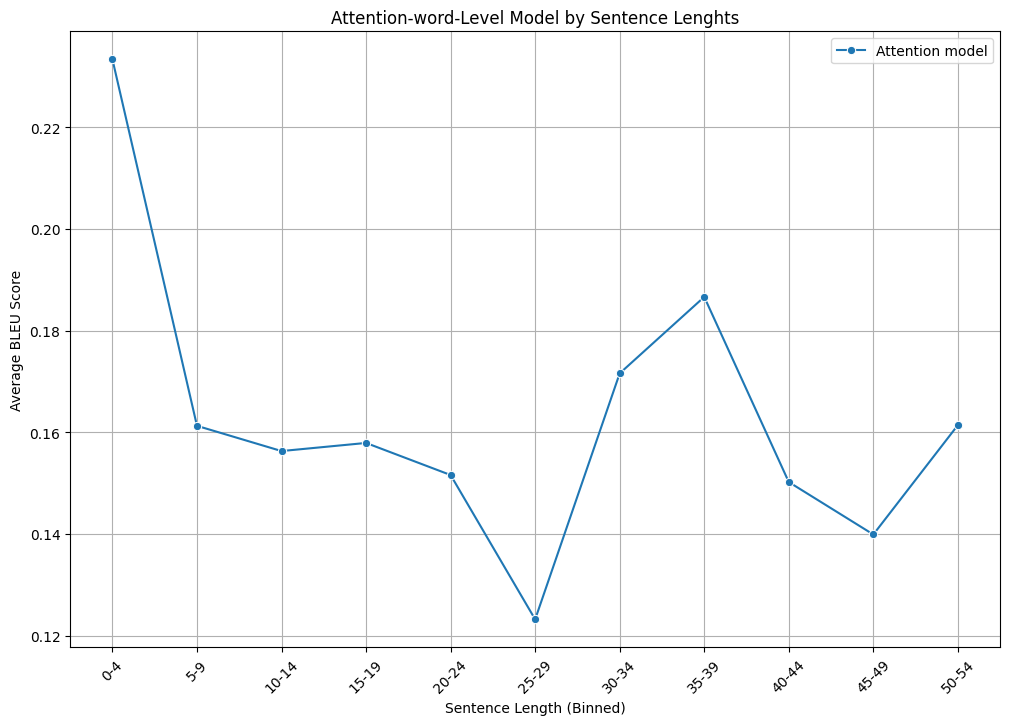

<Figure size 640x480 with 0 Axes>

In [31]:
### Plotting BLEU Score vs. Sentence Length
evaluation_df_wordbased = pd.read_csv('translations/rnn_en_to_pt_glove_wordlevel.csv')
evaluation_df = pd.read_csv('translations/translation_attention_evaluation_with_scores.csv')

evaluation_df['Sentence Length'] = evaluation_df['Source Sentence'].apply(lambda x: len(str(x).split()))

bins = np.arange(0, 60, 5)  

evaluation_df['Binned Length'] = pd.cut(evaluation_df['Sentence Length'], bins)

char_avg_bleu = evaluation_df.groupby('Binned Length')['BLEU Score'].mean().reset_index()

char_avg_bleu['Binned Length'] = char_avg_bleu['Binned Length'].apply(lambda x: f"{int(x.left)}-{int(x.right-1)}")

plt.figure(figsize=(12, 8))
sns.lineplot(data=char_avg_bleu, x='Binned Length', y='BLEU Score', label='Attention model', marker='o')

plt.title('Attention-word-Level Model by Sentence Lenghts')
plt.xlabel('Sentence Length (Binned)')
plt.ylabel('Average BLEU Score')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

plt.savefig('plot/attention_model_bleu_per_sentencelength.png')

/tmp/ipykernel_36665/2298689868.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attention_avg_bleu = evaluation_df.groupby('Binned Length')['BLEU Score'].mean().reset_index()
/tmp/ipykernel_36665/2298689868.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  char_avg_bleu = evaluation_df_char.groupby('Binned Length')['BLEU Score'].mean().reset_index()
/tmp/ipykernel_36665/2298689868.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sil

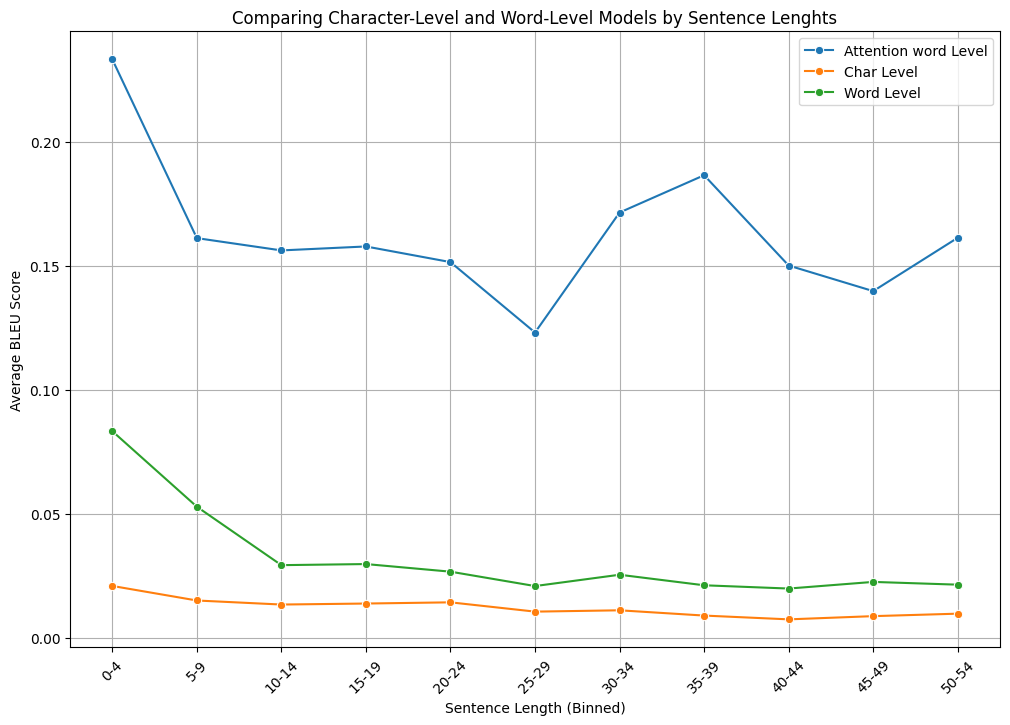

<Figure size 640x480 with 0 Axes>

In [32]:
### Plotting BLEU Score vs. Sentence Length
evaluation_df_wordbased = pd.read_csv('translations/rnn_en_to_pt_glove_wordlevel.csv')
evaluation_df_char = pd.read_csv('translations/translation_charmodel.csv')
evaluation_df = pd.read_csv('translations/translation_attention_evaluation_with_scores.csv')

evaluation_df['Sentence Length'] = evaluation_df['Source Sentence'].apply(lambda x: len(str(x).split()))
evaluation_df_char['Sentence Length'] = evaluation_df_char['Source Sentence'].apply(lambda x: len(str(x).split()))
evaluation_df_wordbased['Sentence Length'] = evaluation_df_wordbased['Source Sentence'].apply(lambda x: len(str(x).split()))

bins = np.arange(0, 60, 5)  

evaluation_df['Binned Length'] = pd.cut(evaluation_df['Sentence Length'], bins)
evaluation_df_char['Binned Length'] = pd.cut(evaluation_df_char['Sentence Length'], bins)
evaluation_df_wordbased['Binned Length'] = pd.cut(evaluation_df_wordbased['Sentence Length'], bins)

attention_avg_bleu = evaluation_df.groupby('Binned Length')['BLEU Score'].mean().reset_index()
char_avg_bleu = evaluation_df_char.groupby('Binned Length')['BLEU Score'].mean().reset_index()
word_avg_bleu = evaluation_df_wordbased.groupby('Binned Length')['BLEU Score'].mean().reset_index()

attention_avg_bleu['Binned Length'] = attention_avg_bleu['Binned Length'].apply(lambda x: f"{int(x.left)}-{int(x.right-1)}")
char_avg_bleu['Binned Length'] = char_avg_bleu['Binned Length'].apply(lambda x: f"{int(x.left)}-{int(x.right-1)}")
word_avg_bleu['Binned Length'] = word_avg_bleu['Binned Length'].apply(lambda x: f"{int(x.left)}-{int(x.right-1)}")

plt.figure(figsize=(12, 8))
sns.lineplot(data=attention_avg_bleu, x='Binned Length', y='BLEU Score', label='Attention word Level', marker='o')
sns.lineplot(data=char_avg_bleu, x='Binned Length', y='BLEU Score', label='Char Level', marker='o')
sns.lineplot(data=word_avg_bleu, x='Binned Length', y='BLEU Score', label='Word Level', marker='o')

plt.title('Comparing Character-Level and Word-Level Models by Sentence Lenghts')
plt.xlabel('Sentence Length (Binned)')
plt.ylabel('Average BLEU Score')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

plt.savefig('plot/attention_vs_charmodel_vs_wordmodel_bleu_per_sentencelength.png')

In [33]:
word_stats = {
    'Metric': ['BLEU Mean', 'BLEU Std Dev', 'BLEU 50%',  'BLEU Max', 'METEOR Mean', 'METEOR Std Dev',  'METEOR 50%',  'METEOR Max'],
    'Word-based': [
        evaluation_df_wordbased['BLEU Score'].mean(),
        evaluation_df_wordbased['BLEU Score'].std(),
        evaluation_df_wordbased['BLEU Score'].median(),
        evaluation_df_wordbased['BLEU Score'].max(),
        evaluation_df_wordbased['METEOR Score'].mean(),
        evaluation_df_wordbased['METEOR Score'].std(),
        evaluation_df_wordbased['METEOR Score'].median(),
        evaluation_df_wordbased['METEOR Score'].max()
    ]
}

char_stats = {
    'Metric': ['BLEU Mean', 'BLEU Std Dev', 'BLEU 50%',  'BLEU Max', 'METEOR Mean', 'METEOR Std Dev', 'METEOR 50%', 'METEOR Max'],
    'Attention-based': [
        evaluation_df['BLEU Score'].mean(),
        evaluation_df['BLEU Score'].std(),
        evaluation_df['BLEU Score'].median(),
        evaluation_df['BLEU Score'].max(),
        evaluation_df['METEOR Score'].mean(),
        evaluation_df['METEOR Score'].std(),
        evaluation_df['METEOR Score'].median(),
        evaluation_df['METEOR Score'].max()
    ]
}

word_df = pd.DataFrame(word_stats)
char_df = pd.DataFrame(char_stats)

comparison_df = pd.merge(word_df, char_df, on='Metric')

comparison_df

Metric  Word-based  Attention-based
0       BLEU Mean    0.030149         0.155334
1    BLEU Std Dev    0.056600         0.159588
2        BLEU 50%    0.017205         0.102819
3        BLEU Max    0.866878         1.000000
4     METEOR Mean    0.147865         0.397543
5  METEOR Std Dev    0.097056         0.185158
6      METEOR 50%    0.130435         0.381197
7      METEOR Max    0.976471         0.999624